In [1]:
import sys
import os
import collections
import functools
import asyncio

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import sklearn

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, WhiteKernel)
from scipy.interpolate import interp1d, UnivariateSpline

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [662]:
def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0, max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0, check_errors=True):
        # Check inputs for errors.
        if check_errors:
            if len(predictions) != len(labels):
                raise Exception('Numbers of predictions and labels must be the same.')

            for label in labels:
                if not label in (0, 1):
                    raise Exception('Labels must satisfy label == 0 or label == 1.')

            for prediction in predictions:
                if not prediction in (0, 1):
                    raise Exception('Predictions must satisfy prediction == 0 or prediction == 1.')

            if dt_early >= dt_optimal:
                raise Exception('The earliest beneficial time for predictions must be before the optimal time.')

            if dt_optimal >= dt_late:
                raise Exception('The optimal time for predictions must be before the latest beneficial time.')

        # Does the patient eventually have sepsis?
        if np.any(labels):
            is_septic = True
            t_sepsis = np.argmax(labels) - dt_optimal
        else:
            is_septic = False
            t_sepsis = float('inf')

        n = len(labels)

        # Define slopes and intercept points for utility functions of the form
        # u = m * t + b.
        m_1 = float(max_u_tp) / float(dt_optimal - dt_early)
        b_1 = -m_1 * dt_early
        m_2 = float(-max_u_tp) / float(dt_late - dt_optimal)
        b_2 = -m_2 * dt_late
        m_3 = float(min_u_fn) / float(dt_late - dt_optimal)
        b_3 = -m_3 * dt_optimal

        # Compare predicted and true conditions.
        u = np.zeros(n)
        for t in range(n):
            if t <= t_sepsis + dt_late:
                # TP
                if is_septic and predictions[t]:
                    if t <= t_sepsis + dt_optimal:
                        u[t] = max(m_1 * (t - t_sepsis) + b_1, u_fp)
                    elif t <= t_sepsis + dt_late:
                        u[t] = m_2 * (t - t_sepsis) + b_2
                # FP
                elif not is_septic and predictions[t]:
                    u[t] = u_fp
                # FN
                elif is_septic and not predictions[t]:
                    if t <= t_sepsis + dt_optimal:
                        u[t] = 0
                    elif t <= t_sepsis + dt_late:
                        u[t] = m_3 * (t - t_sepsis) + b_3
                # TN
                elif not is_septic and not predictions[t]:
                    u[t] = u_tn

        # Find total utility for patient.
        return np.sum(u)

In [642]:
def normalised_utility(y, preds, *args, **kwargs):
    dt_early   = -12
    dt_optimal = -6
    dt_late    = 3

    max_u_tp = 1
    min_u_fn = -2
    u_fp     = -0.05
    u_tn     = 0
    num_rows          = len(y)
    observed_predictions = preds
    best_predictions     = np.zeros(num_rows)
    worst_predictions    = np.zeros(num_rows)
    inaction_predictions = np.zeros(num_rows)

    if np.any(y):
        t_sepsis = np.argmax(y) - dt_optimal
        best_predictions[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, num_rows)] = 1
    worst_predictions = 1 - best_predictions
    
    observed_utility = compute_prediction_utility(y, observed_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
    best_utility     = compute_prediction_utility(y, best_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
    worst_utility    = compute_prediction_utility(y, worst_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)
    inaction_utility = compute_prediction_utility(y, inaction_predictions, dt_early, dt_optimal, dt_late, max_u_tp, min_u_fn, u_fp, u_tn)

    normalized_observed_utility = (observed_utility - inaction_utility) / (best_utility - inaction_utility)
    return normalized_observed_utility

In [364]:
df = pd.read_csv('challenge/training/p000009.psv', sep='|')

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 41 columns):
HR                  49 non-null float64
O2Sat               44 non-null float64
Temp                10 non-null float64
SBP                 42 non-null float64
MAP                 42 non-null float64
DBP                 0 non-null float64
Resp                50 non-null float64
EtCO2               0 non-null float64
BaseExcess          7 non-null float64
HCO3                2 non-null float64
FiO2                4 non-null float64
pH                  7 non-null float64
PaCO2               6 non-null float64
SaO2                4 non-null float64
AST                 1 non-null float64
BUN                 2 non-null float64
Alkalinephos        1 non-null float64
Calcium             2 non-null float64
Chloride            2 non-null float64
Creatinine          2 non-null float64
Bilirubin_direct    0 non-null float64
Glucose             2 non-null float64
Lactate             0 non-null fl

In [252]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0


In [253]:
df.describe()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
count,49.000000,44.000000,10.000000,42.000000,42.000000,0.0,50.000000,0.0,7.000000,2.00000,...,2.000000,0.0,2.000000,5.400000e+01,54.0,0.0,0.0,5.400000e+01,54.000000,54.0
mean,101.571429,91.477273,36.778000,126.809524,87.261905,NaN,24.820000,NaN,20.714286,46.50000,...,10.200000,NaN,327.500000,8.314000e+01,0.0,NaN,NaN,-3.000000e-02,27.500000,0.0
std,9.594378,3.460667,0.421078,22.422482,21.270465,NaN,4.106689,NaN,2.138090,2.12132,...,6.363961,NaN,14.849242,2.868859e-14,0.0,NaN,NaN,3.502025e-18,15.732133,0.0
min,76.000000,85.000000,36.110000,78.000000,44.000000,NaN,17.000000,NaN,18.000000,45.00000,...,5.700000,NaN,317.000000,8.314000e+01,0.0,NaN,NaN,-3.000000e-02,1.000000,0.0
25%,98.000000,89.000000,36.515000,111.875000,76.330000,NaN,22.000000,NaN,19.500000,45.75000,...,7.950000,NaN,322.250000,8.314000e+01,0.0,NaN,NaN,-3.000000e-02,14.250000,0.0
50%,104.000000,91.000000,36.725000,128.000000,87.915000,NaN,25.000000,NaN,20.000000,46.50000,...,10.200000,NaN,327.500000,8.314000e+01,0.0,NaN,NaN,-3.000000e-02,27.500000,0.0
75%,108.000000,93.000000,37.110000,138.750000,96.670000,NaN,28.750000,NaN,22.000000,47.25000,...,12.450000,NaN,332.750000,8.314000e+01,0.0,NaN,NaN,-3.000000e-02,40.750000,0.0
max,117.000000,100.000000,37.440000,181.000000,141.330000,NaN,32.000000,NaN,24.000000,48.00000,...,14.700000,NaN,338.000000,8.314000e+01,0.0,NaN,NaN,-3.000000e-02,54.000000,0.0


R^2 Score: 0.9972580964114346
Initial Kernel: 1**2 * Matern(length_scale=1e+03, nu=1.5) + WhiteKernel(noise_level=0.01)
Optimised: 33.4**2 * Matern(length_scale=30, nu=1.5) + WhiteKernel(noise_level=0.1)
LML: -72.7735283508099


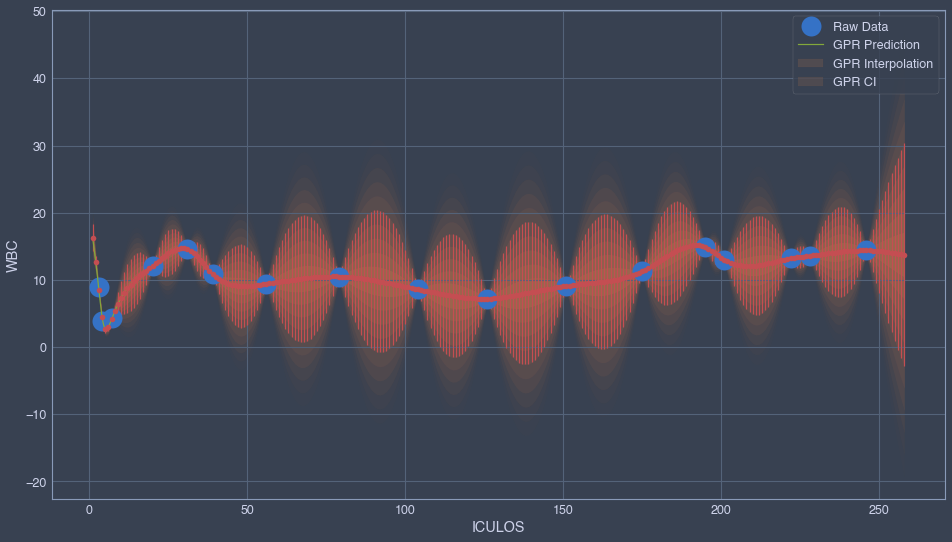

In [270]:
# --GPR + Kernel--
feature = 'WBC'
x = df[df[feature].isna() == False]['ICULOS']
kernel = 1.0 * Matern(length_scale=1e3, length_scale_bounds=(3e1, 1e4)) \
    + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e-1))
gpr = GaussianProcessRegressor(
    kernel=kernel,
    random_state=42,
    n_restarts_optimizer=50,
    normalize_y=True
).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][feature])
print("R^2 Score: %s\nInitial Kernel: %s\nOptimised: %s\nLML: %s" % (
        gpr.score(x.to_numpy().reshape(-1, 1), df.iloc[x.index][feature]),
        kernel,
        gpr.kernel_,
        gpr.log_marginal_likelihood(gpr.kernel_.theta)
    )
)
# Predictions
x_pred = np.linspace(df['ICULOS'].iloc[0], df['ICULOS'].iloc[-1], 1e4).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)
# --Plotting--
fig, ax = plt.subplots(figsize=(16, 9))
# Raw Data
ax.plot('ICULOS', feature, 'bo', data=df.iloc[x.index], markersize=20)
# Predicted Values
ax.plot(
    x_pred,
    y_pred,
    'g-',
    label='Predicted Function'
)
# Interpolated Values
x_pred = np.array(df['ICULOS']).reshape(-1, 1)
y_pred, y_std = gpr.predict(x_pred, return_std=True)
ax.errorbar(
    x_pred,
    y_pred,
    yerr=y_std,
    fmt='ro',
    label='Interpolated values',
)
# Confidence Interval
for i in range(10):
    ax.fill_between(
        x_pred.flatten(),
        y_pred - .2*y_std*(i+1), y_pred + .2*y_std*(i+1),
        alpha=0.125 * (10-i)/10,
        label='Confidence interval',
        color='y'
    )
# Threshold
# sns.lineplot(np.array([x.iloc[0]-10, x.iloc[-1]+10]).astype('datetime64[s]'), y=[90, 90], ax=ax)
ax.legend(['Raw Data', 'GPR Prediction', 'GPR Interpolation', 'GPR CI'])
ax.set_xlabel('ICULOS')
ax.set_ylabel(feature)
if 'CI' not in os.environ:
    # skip in continous integration
    plt.show()

In [136]:
for col in df.columns:
    print(col)
    if df[col].isna().all():
        df[col] = [0]*len(df)
        df['%s_std' % (col)] = [0]*len(df)
    elif col != 'ICULOS':
        x = df[df[col].isna() == False]['ICULOS']
        kernel = 1.0 * Matern(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) \
        + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e-1))
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            random_state=42,
            n_restarts_optimizer=50
        ).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][col])
        x_pred = np.array(df['ICULOS']).reshape(-1, 1)
        y_pred, y_std = gpr.predict(x_pred, return_std=True)
        df[col] = y_pred
        df['%s_std' % (col)] = y_std

HR
O2Sat
Temp
SBP
MAP
DBP
Resp
EtCO2
BaseExcess
HCO3
FiO2
pH
PaCO2
SaO2
AST
BUN
Alkalinephos
Calcium
Chloride
Creatinine
Bilirubin_direct
Glucose
Lactate
Magnesium
Phosphate
Potassium
Bilirubin_total
TroponinI
Hct
Hgb
PTT
WBC
Fibrinogen
Platelets
Age


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.68773346e-04, -2.63651625e+01,  1.75830156e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35591254e-05, -2.63650622e+01,  1.75830501e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.59848481e-04, -2.63651576e+01,  1.75830173e+01]), 'task

Gender
Unit1
Unit2
HospAdmTime
ICULOS
SepsisLabel


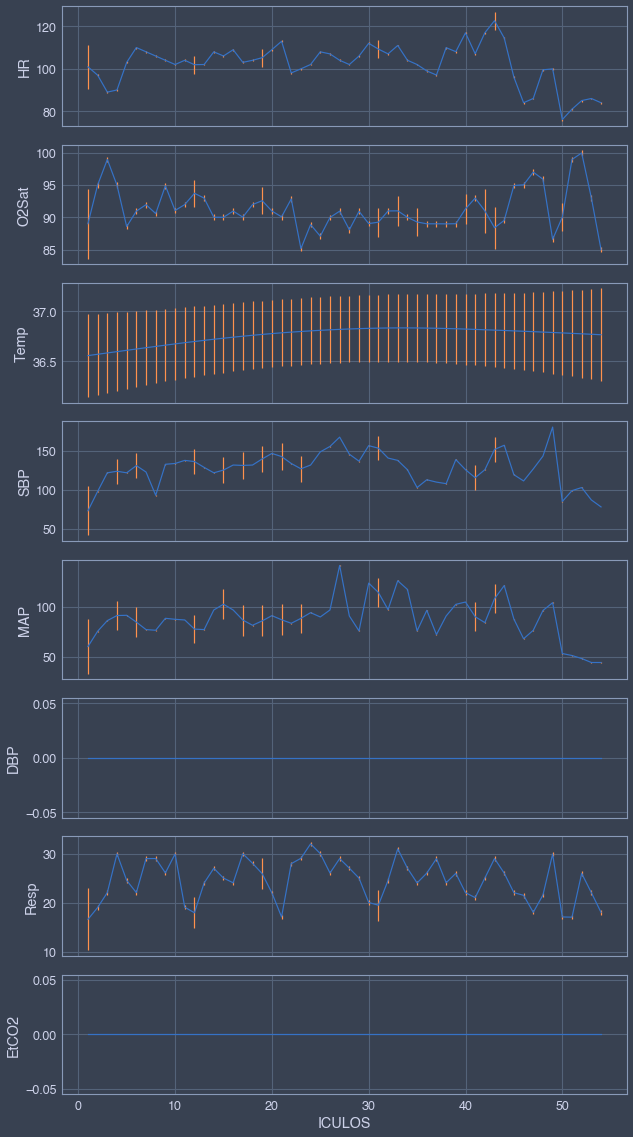

In [137]:
fig, ax = plt.subplots(8, 1, figsize=(9, 16), sharex=True)
for idx, measurement in enumerate(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']):
    ax[idx].errorbar(
        df['ICULOS'],
        df[measurement], df['%s_std' % (measurement)],
        ecolor='y'
    )
    ax[idx].set_ylabel(measurement)

plt.xlabel('ICULOS')
plt.tight_layout()

In [139]:
df.to_csv('challenge/interpolated/training/p000001.psv')

In [145]:
df.columns[34:]

Index(['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS',
       'SepsisLabel', 'HR_std', 'O2Sat_std', 'Temp_std', 'SBP_std', 'MAP_std',
       'DBP_std', 'Resp_std', 'EtCO2_std', 'BaseExcess_std', 'HCO3_std',
       'FiO2_std', 'pH_std', 'PaCO2_std', 'SaO2_std', 'AST_std', 'BUN_std',
       'Alkalinephos_std', 'Calcium_std'],
      dtype='object')

In [147]:
files = len(os.listdir("challenge/training/"))
for idx, file in enumerate(os.listdir('challenge/training/')):
    if file.split('.')[-1] == 'psv':
        df = pd.read_csv(f'challenge/training/{file}', sep='|')
        print(f'{idx}/{files}: {file}')
        for col in df.columns:
        #     print(col)
            if df[col].isna().all():
                df[col] = [0]*len(df)
                df['%s_std' % (col)] = [0]*len(df)
            elif col not in df.columns[34:]:
                x = df[df[col].isna() == False]['ICULOS']
                kernel = 1.0 * Matern(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) \
                + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e-1))
                gpr = GaussianProcessRegressor(
                    kernel=kernel,
                    random_state=42,
                    n_restarts_optimizer=5
                ).fit(x.to_numpy().reshape(-1, 1), df.iloc[x.index][col])
                x_pred = np.array(df['ICULOS']).reshape(-1, 1)
                y_pred, y_std = gpr.predict(x_pred, return_std=True)
                df[col] = y_pred
                df['%s_std' % (col)] = y_std

        df.to_csv('challenge/interpolated/training/%s' % (file))

1/20337: p000001.psv
2/20337: p000002.psv
3/20337: p000003.psv
4/20337: p000004.psv
5/20337: p000005.psv
6/20337: p000006.psv
7/20337: p000007.psv
8/20337: p000008.psv
9/20337: p000009.psv
10/20337: p000010.psv
11/20337: p000011.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12/20337: p000012.psv
13/20337: p000013.psv
14/20337: p000014.psv
15/20337: p000015.psv
16/20337: p000016.psv
17/20337: p000017.psv
18/20337: p000018.psv
19/20337: p000019.psv
20/20337: p000020.psv
21/20337: p000021.psv
22/20337: p000022.psv
23/20337: p000023.psv
24/20337: p000024.psv
25/20337: p000025.psv
26/20337: p000026.psv
27/20337: p000027.psv
28/20337: p000028.psv
29/20337: p000029.psv
30/20337: p000030.psv
31/20337: p000031.psv
32/20337: p000032.psv
33/20337: p000033.psv
34/20337: p000034.psv
35/20337: p000035.psv
36/20337: p000036.psv
37/20337: p000037.psv
38/20337: p000038.psv
39/20337: p000039.psv
40/20337: p000040.psv
41/20337: p000041.psv
42/20337: p000042.psv
43/20337: p000043.psv
44/20337: p000044.psv
45/20337: p000045.psv
46/20337: p000046.psv
47/20337: p000047.psv
48/20337: p000048.psv
49/20337: p000049.psv
50/20337: p000050.psv
51/20337: p000051.psv
52/20337: p000052.psv
53/20337: p000053.psv
54/20337: p000054.psv
55/20337: p000055.psv
56/20337: p000056.psv
57/20337: 

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.46441241e-06, -2.63656170e-05,  6.27009457e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


64/20337: p000064.psv
65/20337: p000065.psv
66/20337: p000066.psv
67/20337: p000067.psv
68/20337: p000068.psv
69/20337: p000069.psv
70/20337: p000070.psv
71/20337: p000071.psv
72/20337: p000072.psv
73/20337: p000073.psv
74/20337: p000074.psv
75/20337: p000075.psv
76/20337: p000076.psv
77/20337: p000077.psv
78/20337: p000078.psv
79/20337: p000079.psv
80/20337: p000080.psv
81/20337: p000081.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.23373848e-05, -6.52535546e-05, -1.61095775e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


82/20337: p000082.psv
83/20337: p000083.psv
84/20337: p000084.psv
85/20337: p000085.psv
86/20337: p000086.psv
87/20337: p000087.psv
88/20337: p000088.psv
89/20337: p000089.psv
90/20337: p000090.psv
91/20337: p000091.psv
92/20337: p000092.psv
93/20337: p000093.psv
94/20337: p000094.psv
95/20337: p000095.psv
96/20337: p000096.psv
97/20337: p000097.psv
98/20337: p000098.psv
99/20337: p000099.psv
100/20337: p000100.psv
101/20337: p000101.psv
102/20337: p000102.psv
103/20337: p000103.psv
104/20337: p000104.psv
105/20337: p000105.psv
106/20337: p000106.psv
107/20337: p000107.psv
108/20337: p000108.psv
109/20337: p000109.psv
110/20337: p000110.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.51295117e-05, -3.49577095e-05, -5.90493367e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


111/20337: p000111.psv
112/20337: p000112.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.43479291e-06, -1.90010875e-05,  1.93901622e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


113/20337: p000113.psv
114/20337: p000114.psv
115/20337: p000115.psv
116/20337: p000116.psv
117/20337: p000117.psv
118/20337: p000118.psv
119/20337: p000119.psv
120/20337: p000120.psv
121/20337: p000121.psv
122/20337: p000122.psv
123/20337: p000123.psv
124/20337: p000124.psv
125/20337: p000125.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.76706157e-06, -1.36895058e-01, -1.46749084e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


126/20337: p000126.psv
127/20337: p000127.psv
128/20337: p000128.psv
129/20337: p000129.psv
130/20337: p000130.psv
131/20337: p000131.psv
132/20337: p000132.psv
133/20337: p000133.psv
134/20337: p000134.psv
135/20337: p000135.psv
136/20337: p000136.psv
137/20337: p000137.psv
138/20337: p000138.psv
139/20337: p000139.psv
140/20337: p000140.psv
141/20337: p000141.psv
142/20337: p000142.psv
143/20337: p000143.psv
144/20337: p000144.psv
145/20337: p000145.psv
146/20337: p000146.psv
147/20337: p000147.psv
148/20337: p000148.psv
149/20337: p000149.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


150/20337: p000150.psv
151/20337: p000151.psv
152/20337: p000152.psv
153/20337: p000153.psv
154/20337: p000154.psv
155/20337: p000155.psv
156/20337: p000156.psv
157/20337: p000157.psv
158/20337: p000158.psv
159/20337: p000159.psv
160/20337: p000160.psv
161/20337: p000161.psv
162/20337: p000162.psv
163/20337: p000163.psv
164/20337: p000164.psv
165/20337: p000165.psv
166/20337: p000166.psv
167/20337: p000167.psv
168/20337: p000168.psv
169/20337: p000169.psv
170/20337: p000170.psv
171/20337: p000171.psv
172/20337: p000172.psv
173/20337: p000173.psv
174/20337: p000174.psv
175/20337: p000175.psv
176/20337: p000176.psv
177/20337: p000177.psv
178/20337: p000178.psv
179/20337: p000179.psv
180/20337: p000180.psv
181/20337: p000181.psv
182/20337: p000182.psv
183/20337: p000183.psv
184/20337: p000184.psv
185/20337: p000185.psv
186/20337: p000186.psv
187/20337: p000187.psv
188/20337: p000188.psv
189/20337: p000189.psv
190/20337: p000190.psv
191/20337: p000191.psv
192/20337: p000192.psv
193/20337: 

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.26892075e-06,  1.02966000e-05, -2.22278860e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


202/20337: p000202.psv
203/20337: p000203.psv
204/20337: p000204.psv
205/20337: p000205.psv
206/20337: p000206.psv
207/20337: p000207.psv
208/20337: p000208.psv
209/20337: p000209.psv
210/20337: p000210.psv
211/20337: p000211.psv
212/20337: p000212.psv
213/20337: p000213.psv
214/20337: p000214.psv
215/20337: p000215.psv
216/20337: p000216.psv
217/20337: p000217.psv
218/20337: p000218.psv
219/20337: p000219.psv
220/20337: p000220.psv
221/20337: p000221.psv
222/20337: p000222.psv
223/20337: p000223.psv
224/20337: p000224.psv
225/20337: p000225.psv
226/20337: p000226.psv
227/20337: p000227.psv
228/20337: p000228.psv
229/20337: p000229.psv
230/20337: p000230.psv
231/20337: p000231.psv
232/20337: p000232.psv
233/20337: p000233.psv
234/20337: p000234.psv
235/20337: p000235.psv
236/20337: p000236.psv
237/20337: p000237.psv
238/20337: p000238.psv
239/20337: p000239.psv
240/20337: p000240.psv
241/20337: p000241.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.42298619e-06, -2.58005095e-05, -3.23675129e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


242/20337: p000242.psv
243/20337: p000243.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04745122e-05,  3.37191716e-05, -7.35795489e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


244/20337: p000244.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.09411776e-05, -2.39012871e+00,  3.32376463e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


245/20337: p000245.psv
246/20337: p000246.psv
247/20337: p000247.psv
248/20337: p000248.psv
249/20337: p000249.psv
250/20337: p000250.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.22310885e-05, -2.73537291e-05,  1.18721720e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


251/20337: p000251.psv
252/20337: p000252.psv
253/20337: p000253.psv
254/20337: p000254.psv
255/20337: p000255.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


256/20337: p000256.psv
257/20337: p000257.psv
258/20337: p000258.psv
259/20337: p000259.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.86475372e-05, -4.08811424e-05,  3.07366196e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


260/20337: p000260.psv
261/20337: p000261.psv
262/20337: p000262.psv
263/20337: p000263.psv
264/20337: p000264.psv
265/20337: p000265.psv
266/20337: p000266.psv
267/20337: p000267.psv
268/20337: p000268.psv
269/20337: p000269.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.64919129e-06, -3.14379574e-05,  9.09178251e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


270/20337: p000270.psv
271/20337: p000271.psv
272/20337: p000272.psv
273/20337: p000273.psv
274/20337: p000274.psv
275/20337: p000275.psv
276/20337: p000276.psv
277/20337: p000277.psv
278/20337: p000278.psv
279/20337: p000279.psv
280/20337: p000280.psv
281/20337: p000281.psv
282/20337: p000282.psv
283/20337: p000283.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.50616073e-06, -3.10870952e-05,  1.00866566e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


284/20337: p000284.psv
285/20337: p000285.psv
286/20337: p000286.psv
287/20337: p000287.psv
288/20337: p000288.psv
289/20337: p000289.psv
290/20337: p000290.psv
291/20337: p000291.psv
292/20337: p000292.psv
293/20337: p000293.psv
294/20337: p000294.psv
295/20337: p000295.psv
296/20337: p000296.psv
297/20337: p000297.psv
298/20337: p000298.psv
299/20337: p000299.psv
300/20337: p000300.psv
301/20337: p000301.psv
302/20337: p000302.psv
303/20337: p000303.psv
304/20337: p000304.psv
305/20337: p000305.psv
306/20337: p000306.psv
307/20337: p000307.psv
308/20337: p000308.psv
309/20337: p000309.psv
310/20337: p000310.psv
311/20337: p000311.psv
312/20337: p000312.psv
313/20337: p000313.psv
314/20337: p000314.psv
315/20337: p000315.psv
316/20337: p000316.psv
317/20337: p000317.psv
318/20337: p000318.psv
319/20337: p000319.psv
320/20337: p000320.psv
321/20337: p000321.psv
322/20337: p000322.psv
323/20337: p000323.psv
324/20337: p000324.psv
325/20337: p000325.psv
326/20337: p000326.psv
327/20337: 

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


343/20337: p000343.psv
344/20337: p000344.psv
345/20337: p000345.psv
346/20337: p000346.psv
347/20337: p000347.psv
348/20337: p000348.psv
349/20337: p000349.psv
350/20337: p000350.psv
351/20337: p000351.psv
352/20337: p000352.psv
353/20337: p000353.psv
354/20337: p000354.psv
355/20337: p000355.psv
356/20337: p000356.psv
357/20337: p000357.psv
358/20337: p000358.psv
359/20337: p000359.psv
360/20337: p000360.psv
361/20337: p000361.psv
362/20337: p000362.psv
363/20337: p000363.psv
364/20337: p000364.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


365/20337: p000365.psv
366/20337: p000366.psv
367/20337: p000367.psv
368/20337: p000368.psv
369/20337: p000369.psv
370/20337: p000370.psv
371/20337: p000371.psv
372/20337: p000372.psv
373/20337: p000373.psv
374/20337: p000374.psv
375/20337: p000375.psv
376/20337: p000376.psv
377/20337: p000377.psv
378/20337: p000378.psv
379/20337: p000379.psv
380/20337: p000380.psv
381/20337: p000381.psv
382/20337: p000382.psv
383/20337: p000383.psv
384/20337: p000384.psv
385/20337: p000385.psv
386/20337: p000386.psv
387/20337: p000387.psv
388/20337: p000388.psv
389/20337: p000389.psv
390/20337: p000390.psv
391/20337: p000391.psv
392/20337: p000392.psv
393/20337: p000393.psv
394/20337: p000394.psv
395/20337: p000395.psv
396/20337: p000396.psv
397/20337: p000397.psv
398/20337: p000398.psv
399/20337: p000399.psv
400/20337: p000400.psv
401/20337: p000401.psv
402/20337: p000402.psv
403/20337: p000403.psv
404/20337: p000404.psv
405/20337: p000405.psv
406/20337: p000406.psv
407/20337: p000407.psv
408/20337: 

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.25107597e-05, -2.99976767e-05,  8.47391811e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


417/20337: p000417.psv
418/20337: p000418.psv
419/20337: p000419.psv
420/20337: p000420.psv
421/20337: p000421.psv
422/20337: p000422.psv
423/20337: p000423.psv
424/20337: p000424.psv
425/20337: p000425.psv
426/20337: p000426.psv
427/20337: p000427.psv
428/20337: p000428.psv
429/20337: p000429.psv
430/20337: p000430.psv
431/20337: p000431.psv
432/20337: p000432.psv
433/20337: p000433.psv
434/20337: p000434.psv
435/20337: p000435.psv
436/20337: p000436.psv
437/20337: p000437.psv
438/20337: p000438.psv
439/20337: p000439.psv
440/20337: p000440.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.27940381e-07,  2.68941775e-05, -5.56002286e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


441/20337: p000441.psv
442/20337: p000442.psv
443/20337: p000443.psv
444/20337: p000444.psv
445/20337: p000445.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.65714720e-06,  1.14804029e-05, -6.21976695e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


446/20337: p000446.psv
447/20337: p000447.psv
448/20337: p000448.psv
449/20337: p000449.psv
450/20337: p000450.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.76166137e-05,  4.54979196e-05, -1.24581268e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


451/20337: p000451.psv
452/20337: p000452.psv
453/20337: p000453.psv
454/20337: p000454.psv
455/20337: p000455.psv
456/20337: p000456.psv
457/20337: p000457.psv
458/20337: p000458.psv
459/20337: p000459.psv
460/20337: p000460.psv
461/20337: p000461.psv
462/20337: p000462.psv
463/20337: p000463.psv
464/20337: p000464.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.54497824e-05, -4.29608209e-05, -1.83997289e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


465/20337: p000465.psv
466/20337: p000466.psv
467/20337: p000467.psv
468/20337: p000468.psv
469/20337: p000469.psv
470/20337: p000470.psv
471/20337: p000471.psv
472/20337: p000472.psv
473/20337: p000473.psv
474/20337: p000474.psv
475/20337: p000475.psv
476/20337: p000476.psv
477/20337: p000477.psv
478/20337: p000478.psv
479/20337: p000479.psv
480/20337: p000480.psv
481/20337: p000481.psv
482/20337: p000482.psv
483/20337: p000483.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.41571569e-06, -2.16791589e-05,  2.34747199e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


484/20337: p000484.psv
485/20337: p000485.psv
486/20337: p000486.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


487/20337: p000487.psv
488/20337: p000488.psv
489/20337: p000489.psv
490/20337: p000490.psv
491/20337: p000491.psv
492/20337: p000492.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.29056029e-06,  1.69618361e-05, -3.85231221e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


493/20337: p000493.psv
494/20337: p000494.psv
495/20337: p000495.psv
496/20337: p000496.psv
497/20337: p000497.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.69426203e-05, -3.36604178e+00,  2.09500729e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


498/20337: p000498.psv
499/20337: p000499.psv
500/20337: p000500.psv
501/20337: p000501.psv
502/20337: p000502.psv
503/20337: p000503.psv
504/20337: p000504.psv
505/20337: p000505.psv
506/20337: p000506.psv
507/20337: p000507.psv
508/20337: p000508.psv
509/20337: p000509.psv
510/20337: p000510.psv
511/20337: p000511.psv
512/20337: p000512.psv
513/20337: p000513.psv
514/20337: p000514.psv
515/20337: p000515.psv
516/20337: p000516.psv
517/20337: p000517.psv
518/20337: p000518.psv
519/20337: p000519.psv
520/20337: p000520.psv
521/20337: p000521.psv
522/20337: p000522.psv
523/20337: p000523.psv
524/20337: p000524.psv
525/20337: p000525.psv
526/20337: p000526.psv
527/20337: p000527.psv
528/20337: p000528.psv
529/20337: p000529.psv
530/20337: p000530.psv
531/20337: p000531.psv
532/20337: p000532.psv
533/20337: p000533.psv
534/20337: p000534.psv
535/20337: p000535.psv
536/20337: p000536.psv
537/20337: p000537.psv
538/20337: p000538.psv
539/20337: p000539.psv
540/20337: p000540.psv
541/20337: 

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


558/20337: p000558.psv
559/20337: p000559.psv
560/20337: p000560.psv
561/20337: p000561.psv
562/20337: p000562.psv
563/20337: p000563.psv
564/20337: p000564.psv
565/20337: p000565.psv
566/20337: p000566.psv
567/20337: p000567.psv
568/20337: p000568.psv
569/20337: p000569.psv
570/20337: p000570.psv
571/20337: p000571.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


572/20337: p000572.psv
573/20337: p000573.psv
574/20337: p000574.psv
575/20337: p000575.psv
576/20337: p000576.psv
577/20337: p000577.psv
578/20337: p000578.psv
579/20337: p000579.psv
580/20337: p000580.psv
581/20337: p000581.psv
582/20337: p000582.psv
583/20337: p000583.psv
584/20337: p000584.psv
585/20337: p000585.psv
586/20337: p000586.psv
587/20337: p000587.psv
588/20337: p000588.psv
589/20337: p000589.psv
590/20337: p000590.psv
591/20337: p000591.psv
592/20337: p000592.psv
593/20337: p000593.psv
594/20337: p000594.psv
595/20337: p000595.psv
596/20337: p000596.psv
597/20337: p000597.psv
598/20337: p000598.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.58479267e-05, -2.94346484e-05,  1.47533122e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


599/20337: p000599.psv
600/20337: p000600.psv
601/20337: p000601.psv
602/20337: p000602.psv
603/20337: p000603.psv
604/20337: p000604.psv
605/20337: p000605.psv
606/20337: p000606.psv
607/20337: p000607.psv
608/20337: p000608.psv
609/20337: p000609.psv
610/20337: p000610.psv
611/20337: p000611.psv
612/20337: p000612.psv
613/20337: p000613.psv
614/20337: p000614.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.89221464e-05, -1.56955060e+00,  3.08404592e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


615/20337: p000615.psv
616/20337: p000616.psv
617/20337: p000617.psv
618/20337: p000618.psv
619/20337: p000619.psv
620/20337: p000620.psv
621/20337: p000621.psv
622/20337: p000622.psv
623/20337: p000623.psv
624/20337: p000624.psv
625/20337: p000625.psv
626/20337: p000626.psv
627/20337: p000627.psv
628/20337: p000628.psv
629/20337: p000629.psv
630/20337: p000630.psv
631/20337: p000631.psv
632/20337: p000632.psv
633/20337: p000633.psv
634/20337: p000634.psv
635/20337: p000635.psv
636/20337: p000636.psv
637/20337: p000637.psv
638/20337: p000638.psv
639/20337: p000639.psv
640/20337: p000640.psv
641/20337: p000641.psv
642/20337: p000642.psv
643/20337: p000643.psv
644/20337: p000644.psv
645/20337: p000645.psv
646/20337: p000646.psv
647/20337: p000647.psv
648/20337: p000648.psv
649/20337: p000649.psv
650/20337: p000650.psv
651/20337: p000651.psv
652/20337: p000652.psv
653/20337: p000653.psv
654/20337: p000654.psv
655/20337: p000655.psv
656/20337: p000656.psv
657/20337: p000657.psv
658/20337: 

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.91155481e-06,  1.42705318e-05,  4.02496809e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


751/20337: p000751.psv
752/20337: p000752.psv
753/20337: p000753.psv
754/20337: p000754.psv
755/20337: p000755.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.20969913e-06,  3.44997746e-05, -1.88107991e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


756/20337: p000756.psv
757/20337: p000757.psv
758/20337: p000758.psv
759/20337: p000759.psv
760/20337: p000760.psv
761/20337: p000761.psv
762/20337: p000762.psv
763/20337: p000763.psv
764/20337: p000764.psv
765/20337: p000765.psv
766/20337: p000766.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.54715804e-06, -1.47091981e-05, -1.20688490e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


767/20337: p000767.psv
768/20337: p000768.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.28180135e-06, -4.87020286e-05,  4.69676976e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


769/20337: p000769.psv
770/20337: p000770.psv
771/20337: p000771.psv
772/20337: p000772.psv
773/20337: p000773.psv
774/20337: p000774.psv
775/20337: p000775.psv
776/20337: p000776.psv
777/20337: p000777.psv
778/20337: p000778.psv
779/20337: p000779.psv
780/20337: p000780.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.61640037e-05,  8.08383452e-05, -9.62080652e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


781/20337: p000781.psv
782/20337: p000782.psv
783/20337: p000783.psv
784/20337: p000784.psv
785/20337: p000785.psv
786/20337: p000786.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.43838022e-05,  6.60610134e-05,  1.68179014e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


787/20337: p000787.psv
788/20337: p000788.psv
789/20337: p000789.psv
790/20337: p000790.psv
791/20337: p000791.psv
792/20337: p000792.psv
793/20337: p000793.psv
794/20337: p000794.psv
795/20337: p000795.psv
796/20337: p000796.psv
797/20337: p000797.psv
798/20337: p000798.psv
799/20337: p000799.psv
800/20337: p000800.psv
801/20337: p000801.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.27032303e-05, -2.52604217e-05, -4.00644836e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


802/20337: p000802.psv
803/20337: p000803.psv
804/20337: p000804.psv
805/20337: p000805.psv
806/20337: p000806.psv
807/20337: p000807.psv
808/20337: p000808.psv
809/20337: p000809.psv
810/20337: p000810.psv
811/20337: p000811.psv
812/20337: p000812.psv
813/20337: p000813.psv
814/20337: p000814.psv
815/20337: p000815.psv
816/20337: p000816.psv
817/20337: p000817.psv
818/20337: p000818.psv
819/20337: p000819.psv
820/20337: p000820.psv
821/20337: p000821.psv
822/20337: p000822.psv
823/20337: p000823.psv
824/20337: p000824.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07770102e-05,  2.64061891e-06,  2.72729198e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


825/20337: p000825.psv
826/20337: p000826.psv
827/20337: p000827.psv
828/20337: p000828.psv
829/20337: p000829.psv
830/20337: p000830.psv
831/20337: p000831.psv
832/20337: p000832.psv
833/20337: p000833.psv
834/20337: p000834.psv
835/20337: p000835.psv
836/20337: p000836.psv
837/20337: p000837.psv
838/20337: p000838.psv
839/20337: p000839.psv
840/20337: p000840.psv
841/20337: p000841.psv
842/20337: p000842.psv
843/20337: p000843.psv
844/20337: p000844.psv
845/20337: p000845.psv
846/20337: p000846.psv
847/20337: p000847.psv
848/20337: p000848.psv
849/20337: p000849.psv
850/20337: p000850.psv
851/20337: p000851.psv
852/20337: p000852.psv
853/20337: p000853.psv
854/20337: p000854.psv
855/20337: p000855.psv
856/20337: p000856.psv
857/20337: p000857.psv
858/20337: p000858.psv
859/20337: p000859.psv
860/20337: p000860.psv
861/20337: p000861.psv
862/20337: p000862.psv
863/20337: p000863.psv
864/20337: p000864.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.26068425e-06, -4.72699813e-05, -2.12647674e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


865/20337: p000865.psv
866/20337: p000866.psv
867/20337: p000867.psv
868/20337: p000868.psv
869/20337: p000869.psv
870/20337: p000870.psv
871/20337: p000871.psv
872/20337: p000872.psv
873/20337: p000873.psv
874/20337: p000874.psv
875/20337: p000875.psv
876/20337: p000876.psv
877/20337: p000877.psv
878/20337: p000878.psv
879/20337: p000879.psv
880/20337: p000880.psv
881/20337: p000881.psv
882/20337: p000882.psv
883/20337: p000883.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.54291362e-05, -8.28868849e+00,  3.06952308e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


884/20337: p000884.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.15209659e-05,  1.46019753e-06, -5.05135419e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


885/20337: p000885.psv
886/20337: p000886.psv
887/20337: p000887.psv
888/20337: p000888.psv
889/20337: p000889.psv
890/20337: p000890.psv
891/20337: p000891.psv
892/20337: p000892.psv
893/20337: p000893.psv
894/20337: p000894.psv
895/20337: p000895.psv
896/20337: p000896.psv
897/20337: p000897.psv
898/20337: p000898.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


899/20337: p000899.psv
900/20337: p000900.psv
901/20337: p000901.psv
902/20337: p000902.psv
903/20337: p000903.psv
904/20337: p000904.psv
905/20337: p000905.psv
906/20337: p000906.psv
907/20337: p000907.psv
908/20337: p000908.psv
909/20337: p000909.psv
910/20337: p000910.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.02539761e-05,  3.85951266e-05, -5.06622593e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


911/20337: p000911.psv
912/20337: p000912.psv
913/20337: p000913.psv
914/20337: p000914.psv
915/20337: p000915.psv
916/20337: p000916.psv
917/20337: p000917.psv
918/20337: p000918.psv
919/20337: p000919.psv
920/20337: p000920.psv
921/20337: p000921.psv
922/20337: p000922.psv
923/20337: p000923.psv
924/20337: p000924.psv
925/20337: p000925.psv
926/20337: p000926.psv
927/20337: p000927.psv
928/20337: p000928.psv
929/20337: p000929.psv
930/20337: p000930.psv
931/20337: p000931.psv
932/20337: p000932.psv
933/20337: p000933.psv
934/20337: p000934.psv
935/20337: p000935.psv
936/20337: p000936.psv
937/20337: p000937.psv
938/20337: p000938.psv
939/20337: p000939.psv
940/20337: p000940.psv
941/20337: p000941.psv
942/20337: p000942.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.66903841e-05, -3.25383651e+00,  2.47190066e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


943/20337: p000943.psv
944/20337: p000944.psv
945/20337: p000945.psv
946/20337: p000946.psv
947/20337: p000947.psv
948/20337: p000948.psv
949/20337: p000949.psv
950/20337: p000950.psv
951/20337: p000951.psv
952/20337: p000952.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


953/20337: p000953.psv
954/20337: p000954.psv
955/20337: p000955.psv
956/20337: p000956.psv
957/20337: p000957.psv
958/20337: p000958.psv
959/20337: p000959.psv
960/20337: p000960.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.12894655e-05,  3.22538850e-04,  5.85338430e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


961/20337: p000961.psv
962/20337: p000962.psv
963/20337: p000963.psv
964/20337: p000964.psv
965/20337: p000965.psv
966/20337: p000966.psv
967/20337: p000967.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.98823400e-05, -2.64993811e+00,  4.42839820e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


968/20337: p000968.psv
969/20337: p000969.psv
970/20337: p000970.psv
971/20337: p000971.psv
972/20337: p000972.psv
973/20337: p000973.psv
974/20337: p000974.psv
975/20337: p000975.psv
976/20337: p000976.psv
977/20337: p000977.psv
978/20337: p000978.psv
979/20337: p000979.psv
980/20337: p000980.psv
981/20337: p000981.psv
982/20337: p000982.psv
983/20337: p000983.psv
984/20337: p000984.psv
985/20337: p000985.psv
986/20337: p000986.psv
987/20337: p000987.psv
988/20337: p000988.psv
989/20337: p000989.psv
990/20337: p000990.psv
991/20337: p000991.psv
992/20337: p000992.psv
993/20337: p000993.psv
994/20337: p000994.psv
995/20337: p000995.psv
996/20337: p000996.psv
997/20337: p000997.psv
998/20337: p000998.psv
999/20337: p000999.psv
1000/20337: p001000.psv
1001/20337: p001001.psv
1002/20337: p001002.psv
1003/20337: p001003.psv
1004/20337: p001004.psv
1005/20337: p001005.psv
1006/20337: p001006.psv
1007/20337: p001007.psv
1008/20337: p001008.psv
1009/20337: p001009.psv
1010/20337: p001010.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.26181500e-05, -1.76505666e-04,  3.66277296e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


1021/20337: p001021.psv
1022/20337: p001022.psv
1023/20337: p001023.psv
1024/20337: p001024.psv
1025/20337: p001025.psv
1026/20337: p001026.psv
1027/20337: p001027.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.39699943e-06,  1.71833156e-05,  1.31205911e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


1028/20337: p001028.psv
1029/20337: p001029.psv
1030/20337: p001030.psv
1031/20337: p001031.psv
1032/20337: p001032.psv
1033/20337: p001033.psv
1034/20337: p001034.psv
1035/20337: p001035.psv
1036/20337: p001036.psv
1037/20337: p001037.psv
1038/20337: p001038.psv
1039/20337: p001039.psv
1040/20337: p001040.psv
1041/20337: p001041.psv
1042/20337: p001042.psv
1043/20337: p001043.psv
1044/20337: p001044.psv
1045/20337: p001045.psv
1046/20337: p001046.psv
1047/20337: p001047.psv
1048/20337: p001048.psv
1049/20337: p001049.psv
1050/20337: p001050.psv
1051/20337: p001051.psv
1052/20337: p001052.psv
1053/20337: p001053.psv
1054/20337: p001054.psv
1055/20337: p001055.psv
1056/20337: p001056.psv
1057/20337: p001057.psv
1058/20337: p001058.psv
1059/20337: p001059.psv
1060/20337: p001060.psv
1061/20337: p001061.psv
1062/20337: p001062.psv
1063/20337: p001063.psv
1064/20337: p001064.psv
1065/20337: p001065.psv
1066/20337: p001066.psv
1067/20337: p001067.psv
1068/20337: p001068.psv
1069/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.62888243e-05, -2.52310149e-05, -2.80055941e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


1095/20337: p001095.psv
1096/20337: p001096.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.99093035e-05, -1.64518485e+00,  2.79635254e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


1097/20337: p001097.psv
1098/20337: p001098.psv
1099/20337: p001099.psv
1100/20337: p001100.psv
1101/20337: p001101.psv
1102/20337: p001102.psv
1103/20337: p001103.psv
1104/20337: p001104.psv
1105/20337: p001105.psv
1106/20337: p001106.psv
1107/20337: p001107.psv
1108/20337: p001108.psv
1109/20337: p001109.psv
1110/20337: p001110.psv
1111/20337: p001111.psv
1112/20337: p001112.psv
1113/20337: p001113.psv
1114/20337: p001114.psv
1115/20337: p001115.psv
1116/20337: p001116.psv
1117/20337: p001117.psv
1118/20337: p001118.psv
1119/20337: p001119.psv
1120/20337: p001120.psv
1121/20337: p001121.psv
1122/20337: p001122.psv
1123/20337: p001123.psv
1124/20337: p001124.psv
1125/20337: p001125.psv
1126/20337: p001126.psv
1127/20337: p001127.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1128/20337: p001128.psv
1129/20337: p001129.psv
1130/20337: p001130.psv
1131/20337: p001131.psv
1132/20337: p001132.psv
1133/20337: p001133.psv
1134/20337: p001134.psv
1135/20337: p001135.psv
1136/20337: p001136.psv
1137/20337: p001137.psv
1138/20337: p001138.psv
1139/20337: p001139.psv
1140/20337: p001140.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.67115091e-06, -1.51195016e-05, -1.44336819e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


1141/20337: p001141.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.58608847e-05, -2.54885773e+00,  4.77137694e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


1142/20337: p001142.psv
1143/20337: p001143.psv
1144/20337: p001144.psv
1145/20337: p001145.psv
1146/20337: p001146.psv
1147/20337: p001147.psv
1148/20337: p001148.psv
1149/20337: p001149.psv
1150/20337: p001150.psv
1151/20337: p001151.psv
1152/20337: p001152.psv
1153/20337: p001153.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.27147941e-05,  1.37770369e-05, -4.42505733e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


1154/20337: p001154.psv
1155/20337: p001155.psv
1156/20337: p001156.psv
1157/20337: p001157.psv
1158/20337: p001158.psv
1159/20337: p001159.psv
1160/20337: p001160.psv
1161/20337: p001161.psv
1162/20337: p001162.psv
1163/20337: p001163.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.01961503e-05, -7.27396571e-05, -2.88153043e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


1164/20337: p001164.psv
1165/20337: p001165.psv
1166/20337: p001166.psv
1167/20337: p001167.psv
1168/20337: p001168.psv
1169/20337: p001169.psv
1170/20337: p001170.psv
1171/20337: p001171.psv
1172/20337: p001172.psv
1173/20337: p001173.psv
1174/20337: p001174.psv
1175/20337: p001175.psv
1176/20337: p001176.psv
1177/20337: p001177.psv
1178/20337: p001178.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1179/20337: p001179.psv
1180/20337: p001180.psv
1181/20337: p001181.psv
1182/20337: p001182.psv
1183/20337: p001183.psv
1184/20337: p001184.psv
1185/20337: p001185.psv
1186/20337: p001186.psv
1187/20337: p001187.psv
1188/20337: p001188.psv
1189/20337: p001189.psv
1190/20337: p001190.psv
1191/20337: p001191.psv
1192/20337: p001192.psv
1193/20337: p001193.psv
1194/20337: p001194.psv
1195/20337: p001195.psv
1196/20337: p001196.psv
1197/20337: p001197.psv
1198/20337: p001198.psv
1199/20337: p001199.psv
1200/20337: p001200.psv
1201/20337: p001201.psv
1202/20337: p001202.psv
1203/20337: p001203.psv
1204/20337: p001204.psv
1205/20337: p001205.psv
1206/20337: p001206.psv
1207/20337: p001207.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.07251142e-05, -1.45037223e-06, -2.04960098e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 101, 'nit': 33, 'warnflag': 2}
  ConvergenceWarning)


1208/20337: p001208.psv
1209/20337: p001209.psv
1210/20337: p001210.psv
1211/20337: p001211.psv
1212/20337: p001212.psv
1213/20337: p001213.psv
1214/20337: p001214.psv
1215/20337: p001215.psv
1216/20337: p001216.psv
1217/20337: p001217.psv
1218/20337: p001218.psv
1219/20337: p001219.psv
1220/20337: p001220.psv
1221/20337: p001221.psv
1222/20337: p001222.psv
1223/20337: p001223.psv
1224/20337: p001224.psv
1225/20337: p001225.psv
1226/20337: p001226.psv
1227/20337: p001227.psv
1228/20337: p001228.psv
1229/20337: p001229.psv
1230/20337: p001230.psv
1231/20337: p001231.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.31106381e-05, -4.64268941e-05, -5.81224314e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


1232/20337: p001232.psv
1233/20337: p001233.psv
1234/20337: p001234.psv
1235/20337: p001235.psv
1236/20337: p001236.psv
1237/20337: p001237.psv
1238/20337: p001238.psv
1239/20337: p001239.psv
1240/20337: p001240.psv
1241/20337: p001241.psv
1242/20337: p001242.psv
1243/20337: p001243.psv
1244/20337: p001244.psv
1245/20337: p001245.psv
1246/20337: p001246.psv
1247/20337: p001247.psv
1248/20337: p001248.psv
1249/20337: p001249.psv
1250/20337: p001250.psv
1251/20337: p001251.psv
1252/20337: p001252.psv
1253/20337: p001253.psv
1254/20337: p001254.psv
1255/20337: p001255.psv
1256/20337: p001256.psv
1257/20337: p001257.psv
1258/20337: p001258.psv
1259/20337: p001259.psv
1260/20337: p001260.psv
1261/20337: p001261.psv
1262/20337: p001262.psv
1263/20337: p001263.psv
1264/20337: p001264.psv
1265/20337: p001265.psv
1266/20337: p001266.psv
1267/20337: p001267.psv
1268/20337: p001268.psv
1269/20337: p001269.psv
1270/20337: p001270.psv
1271/20337: p001271.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1272/20337: p001272.psv
1273/20337: p001273.psv
1274/20337: p001274.psv
1275/20337: p001275.psv
1276/20337: p001276.psv
1277/20337: p001277.psv
1278/20337: p001278.psv
1279/20337: p001279.psv
1280/20337: p001280.psv
1281/20337: p001281.psv
1282/20337: p001282.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1283/20337: p001283.psv
1284/20337: p001284.psv
1285/20337: p001285.psv
1286/20337: p001286.psv
1287/20337: p001287.psv
1288/20337: p001288.psv
1289/20337: p001289.psv
1290/20337: p001290.psv
1291/20337: p001291.psv
1292/20337: p001292.psv
1293/20337: p001293.psv
1294/20337: p001294.psv
1295/20337: p001295.psv
1296/20337: p001296.psv
1297/20337: p001297.psv
1298/20337: p001298.psv
1299/20337: p001299.psv
1300/20337: p001300.psv
1301/20337: p001301.psv
1302/20337: p001302.psv
1303/20337: p001303.psv
1304/20337: p001304.psv
1305/20337: p001305.psv
1306/20337: p001306.psv
1307/20337: p001307.psv
1308/20337: p001308.psv
1309/20337: p001309.psv
1310/20337: p001310.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.79686685e-06, -1.53156666e-05,  3.92357203e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


1311/20337: p001311.psv
1312/20337: p001312.psv
1313/20337: p001313.psv
1314/20337: p001314.psv
1315/20337: p001315.psv
1316/20337: p001316.psv
1317/20337: p001317.psv
1318/20337: p001318.psv
1319/20337: p001319.psv
1320/20337: p001320.psv
1321/20337: p001321.psv
1322/20337: p001322.psv
1323/20337: p001323.psv
1324/20337: p001324.psv
1325/20337: p001325.psv
1326/20337: p001326.psv
1327/20337: p001327.psv
1328/20337: p001328.psv
1329/20337: p001329.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.12449377e-05, -1.38390868e+00, -5.34045911e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


1330/20337: p001330.psv
1331/20337: p001331.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.33390549e-05, -1.95895523e-05, -4.15226353e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


1332/20337: p001332.psv
1333/20337: p001333.psv
1334/20337: p001334.psv
1335/20337: p001335.psv
1336/20337: p001336.psv
1337/20337: p001337.psv
1338/20337: p001338.psv
1339/20337: p001339.psv
1340/20337: p001340.psv
1341/20337: p001341.psv
1342/20337: p001342.psv
1343/20337: p001343.psv
1344/20337: p001344.psv
1345/20337: p001345.psv
1346/20337: p001346.psv
1347/20337: p001347.psv
1348/20337: p001348.psv
1349/20337: p001349.psv
1350/20337: p001350.psv
1351/20337: p001351.psv
1352/20337: p001352.psv
1353/20337: p001353.psv
1354/20337: p001354.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1355/20337: p001355.psv
1356/20337: p001356.psv
1357/20337: p001357.psv
1358/20337: p001358.psv
1359/20337: p001359.psv
1360/20337: p001360.psv
1361/20337: p001361.psv
1362/20337: p001362.psv
1363/20337: p001363.psv
1364/20337: p001364.psv
1365/20337: p001365.psv
1366/20337: p001366.psv
1367/20337: p001367.psv
1368/20337: p001368.psv
1369/20337: p001369.psv
1370/20337: p001370.psv
1371/20337: p001371.psv
1372/20337: p001372.psv
1373/20337: p001373.psv
1374/20337: p001374.psv
1375/20337: p001375.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.03116035e-05, -1.68615375e+00,  2.70894473e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.13905007e-05,  2.03326867e-05, -1.62640917e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


1376/20337: p001376.psv
1377/20337: p001377.psv
1378/20337: p001378.psv
1379/20337: p001379.psv
1380/20337: p001380.psv
1381/20337: p001381.psv
1382/20337: p001382.psv
1383/20337: p001383.psv
1384/20337: p001384.psv
1385/20337: p001385.psv
1386/20337: p001386.psv
1387/20337: p001387.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1388/20337: p001388.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.31722752e-06,  1.99513085e-05, -2.61202901e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


1389/20337: p001389.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.06936613e-06, -2.16697090e-05,  1.51899629e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


1390/20337: p001390.psv
1391/20337: p001391.psv
1392/20337: p001392.psv
1393/20337: p001393.psv
1394/20337: p001394.psv
1395/20337: p001395.psv
1396/20337: p001396.psv
1397/20337: p001397.psv
1398/20337: p001398.psv
1399/20337: p001399.psv
1400/20337: p001400.psv
1401/20337: p001401.psv
1402/20337: p001402.psv
1403/20337: p001403.psv
1404/20337: p001404.psv
1405/20337: p001405.psv
1406/20337: p001406.psv
1407/20337: p001407.psv
1408/20337: p001408.psv
1409/20337: p001409.psv
1410/20337: p001410.psv
1411/20337: p001411.psv
1412/20337: p001412.psv
1413/20337: p001413.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.00579704e-05, -5.17554527e-07,  1.32930307e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


1414/20337: p001414.psv
1415/20337: p001415.psv
1416/20337: p001416.psv
1417/20337: p001417.psv
1418/20337: p001418.psv
1419/20337: p001419.psv
1420/20337: p001420.psv
1421/20337: p001421.psv
1422/20337: p001422.psv
1423/20337: p001423.psv
1424/20337: p001424.psv
1425/20337: p001425.psv
1426/20337: p001426.psv
1427/20337: p001427.psv
1428/20337: p001428.psv
1429/20337: p001429.psv
1430/20337: p001430.psv
1431/20337: p001431.psv
1432/20337: p001432.psv
1433/20337: p001433.psv
1434/20337: p001434.psv
1435/20337: p001435.psv
1436/20337: p001436.psv
1437/20337: p001437.psv
1438/20337: p001438.psv
1439/20337: p001439.psv
1440/20337: p001440.psv
1441/20337: p001441.psv
1442/20337: p001442.psv
1443/20337: p001443.psv
1444/20337: p001444.psv
1445/20337: p001445.psv
1446/20337: p001446.psv
1447/20337: p001447.psv
1448/20337: p001448.psv
1449/20337: p001449.psv
1450/20337: p001450.psv
1451/20337: p001451.psv
1452/20337: p001452.psv
1453/20337: p001453.psv
1454/20337: p001454.psv
1455/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.77360948e-06, -1.05746926e-05, -1.56698196e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


1470/20337: p001470.psv
1471/20337: p001471.psv
1472/20337: p001472.psv
1473/20337: p001473.psv
1474/20337: p001474.psv
1475/20337: p001475.psv
1476/20337: p001476.psv
1477/20337: p001477.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.03210041e-05, -2.13400311e-05, -8.08639607e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


1478/20337: p001478.psv
1479/20337: p001479.psv
1480/20337: p001480.psv
1481/20337: p001481.psv
1482/20337: p001482.psv
1483/20337: p001483.psv
1484/20337: p001484.psv
1485/20337: p001485.psv
1486/20337: p001486.psv
1487/20337: p001487.psv
1488/20337: p001488.psv
1489/20337: p001489.psv
1490/20337: p001490.psv
1491/20337: p001491.psv
1492/20337: p001492.psv
1493/20337: p001493.psv
1494/20337: p001494.psv
1495/20337: p001495.psv
1496/20337: p001496.psv
1497/20337: p001497.psv
1498/20337: p001498.psv
1499/20337: p001499.psv
1500/20337: p001500.psv
1501/20337: p001501.psv
1502/20337: p001502.psv
1503/20337: p001503.psv
1504/20337: p001504.psv
1505/20337: p001505.psv
1506/20337: p001506.psv
1507/20337: p001507.psv
1508/20337: p001508.psv
1509/20337: p001509.psv
1510/20337: p001510.psv
1511/20337: p001511.psv
1512/20337: p001512.psv
1513/20337: p001513.psv
1514/20337: p001514.psv
1515/20337: p001515.psv
1516/20337: p001516.psv
1517/20337: p001517.psv
1518/20337: p001518.psv
1519/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.59047956e-05,  8.88173462e-05, -7.68664541e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


1541/20337: p001541.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1542/20337: p001542.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.96869985e-07, -6.24528872e-01, -5.48599290e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


1543/20337: p001543.psv
1544/20337: p001544.psv
1545/20337: p001545.psv
1546/20337: p001546.psv
1547/20337: p001547.psv
1548/20337: p001548.psv
1549/20337: p001549.psv
1550/20337: p001550.psv
1551/20337: p001551.psv
1552/20337: p001552.psv
1553/20337: p001553.psv
1554/20337: p001554.psv
1555/20337: p001555.psv
1556/20337: p001556.psv
1557/20337: p001557.psv
1558/20337: p001558.psv
1559/20337: p001559.psv
1560/20337: p001560.psv
1561/20337: p001561.psv
1562/20337: p001562.psv
1563/20337: p001563.psv
1564/20337: p001564.psv
1565/20337: p001565.psv
1566/20337: p001566.psv
1567/20337: p001567.psv
1568/20337: p001568.psv
1569/20337: p001569.psv
1570/20337: p001570.psv
1571/20337: p001571.psv
1572/20337: p001572.psv
1573/20337: p001573.psv
1574/20337: p001574.psv
1575/20337: p001575.psv
1576/20337: p001576.psv
1577/20337: p001577.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.07245685e-05, -1.90646611e-05, -3.56191696e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


1578/20337: p001578.psv
1579/20337: p001579.psv
1580/20337: p001580.psv
1581/20337: p001581.psv
1582/20337: p001582.psv
1583/20337: p001583.psv
1584/20337: p001584.psv
1585/20337: p001585.psv
1586/20337: p001586.psv
1587/20337: p001587.psv
1588/20337: p001588.psv
1589/20337: p001589.psv
1590/20337: p001590.psv
1591/20337: p001591.psv
1592/20337: p001592.psv
1593/20337: p001593.psv
1594/20337: p001594.psv
1595/20337: p001595.psv
1596/20337: p001596.psv
1597/20337: p001597.psv
1598/20337: p001598.psv
1599/20337: p001599.psv
1600/20337: p001600.psv
1601/20337: p001601.psv
1602/20337: p001602.psv
1603/20337: p001603.psv
1604/20337: p001604.psv
1605/20337: p001605.psv
1606/20337: p001606.psv
1607/20337: p001607.psv
1608/20337: p001608.psv
1609/20337: p001609.psv
1610/20337: p001610.psv
1611/20337: p001611.psv
1612/20337: p001612.psv
1613/20337: p001613.psv
1614/20337: p001614.psv
1615/20337: p001615.psv
1616/20337: p001616.psv
1617/20337: p001617.psv
1618/20337: p001618.psv
1619/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.31833167e-05, -2.68358296e+00,  1.85107254e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


1628/20337: p001628.psv
1629/20337: p001629.psv
1630/20337: p001630.psv
1631/20337: p001631.psv
1632/20337: p001632.psv
1633/20337: p001633.psv
1634/20337: p001634.psv
1635/20337: p001635.psv
1636/20337: p001636.psv
1637/20337: p001637.psv
1638/20337: p001638.psv
1639/20337: p001639.psv
1640/20337: p001640.psv
1641/20337: p001641.psv
1642/20337: p001642.psv
1643/20337: p001643.psv
1644/20337: p001644.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.08259449e-06, -2.34290983e-05, -5.33090453e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


1645/20337: p001645.psv
1646/20337: p001646.psv
1647/20337: p001647.psv
1648/20337: p001648.psv
1649/20337: p001649.psv
1650/20337: p001650.psv
1651/20337: p001651.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.12578065e-05, -2.96890542e-06, -2.27642299e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


1652/20337: p001652.psv
1653/20337: p001653.psv
1654/20337: p001654.psv
1655/20337: p001655.psv
1656/20337: p001656.psv
1657/20337: p001657.psv
1658/20337: p001658.psv
1659/20337: p001659.psv
1660/20337: p001660.psv
1661/20337: p001661.psv
1662/20337: p001662.psv
1663/20337: p001663.psv
1664/20337: p001664.psv
1665/20337: p001665.psv
1666/20337: p001666.psv
1667/20337: p001667.psv
1668/20337: p001668.psv
1669/20337: p001669.psv
1670/20337: p001670.psv
1671/20337: p001671.psv
1672/20337: p001672.psv
1673/20337: p001673.psv
1674/20337: p001674.psv
1675/20337: p001675.psv
1676/20337: p001676.psv
1677/20337: p001677.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.84127781e-06, -2.14536345e-05,  1.08100589e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


1678/20337: p001678.psv
1679/20337: p001679.psv
1680/20337: p001680.psv
1681/20337: p001681.psv
1682/20337: p001682.psv
1683/20337: p001683.psv
1684/20337: p001684.psv
1685/20337: p001685.psv
1686/20337: p001686.psv
1687/20337: p001687.psv
1688/20337: p001688.psv
1689/20337: p001689.psv
1690/20337: p001690.psv
1691/20337: p001691.psv
1692/20337: p001692.psv
1693/20337: p001693.psv
1694/20337: p001694.psv
1695/20337: p001695.psv
1696/20337: p001696.psv
1697/20337: p001697.psv
1698/20337: p001698.psv
1699/20337: p001699.psv
1700/20337: p001700.psv
1701/20337: p001701.psv
1702/20337: p001702.psv
1703/20337: p001703.psv
1704/20337: p001704.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.14125791e-05, -2.46635775e+01,  1.36412143e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


1705/20337: p001705.psv
1706/20337: p001706.psv
1707/20337: p001707.psv
1708/20337: p001708.psv
1709/20337: p001709.psv
1710/20337: p001710.psv
1711/20337: p001711.psv
1712/20337: p001712.psv
1713/20337: p001713.psv
1714/20337: p001714.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.53617002e-05,  3.82438155e-05,  8.75266604e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


1715/20337: p001715.psv
1716/20337: p001716.psv
1717/20337: p001717.psv
1718/20337: p001718.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.33183401e-07,  1.35474908e-05,  2.09280370e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


1719/20337: p001719.psv
1720/20337: p001720.psv
1721/20337: p001721.psv
1722/20337: p001722.psv
1723/20337: p001723.psv
1724/20337: p001724.psv
1725/20337: p001725.psv
1726/20337: p001726.psv
1727/20337: p001727.psv
1728/20337: p001728.psv
1729/20337: p001729.psv
1730/20337: p001730.psv
1731/20337: p001731.psv
1732/20337: p001732.psv
1733/20337: p001733.psv
1734/20337: p001734.psv
1735/20337: p001735.psv
1736/20337: p001736.psv
1737/20337: p001737.psv
1738/20337: p001738.psv
1739/20337: p001739.psv
1740/20337: p001740.psv
1741/20337: p001741.psv
1742/20337: p001742.psv
1743/20337: p001743.psv
1744/20337: p001744.psv
1745/20337: p001745.psv
1746/20337: p001746.psv
1747/20337: p001747.psv
1748/20337: p001748.psv
1749/20337: p001749.psv
1750/20337: p001750.psv
1751/20337: p001751.psv
1752/20337: p001752.psv
1753/20337: p001753.psv
1754/20337: p001754.psv
1755/20337: p001755.psv
1756/20337: p001756.psv
1757/20337: p001757.psv
1758/20337: p001758.psv
1759/20337: p001759.psv
1760/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.30772730e-06, -1.05820168e-05,  1.43393676e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


1802/20337: p001802.psv
1803/20337: p001803.psv
1804/20337: p001804.psv
1805/20337: p001805.psv
1806/20337: p001806.psv
1807/20337: p001807.psv
1808/20337: p001808.psv
1809/20337: p001809.psv
1810/20337: p001810.psv
1811/20337: p001811.psv
1812/20337: p001812.psv
1813/20337: p001813.psv
1814/20337: p001814.psv
1815/20337: p001815.psv
1816/20337: p001816.psv
1817/20337: p001817.psv
1818/20337: p001818.psv
1819/20337: p001819.psv
1820/20337: p001820.psv
1821/20337: p001821.psv
1822/20337: p001822.psv
1823/20337: p001823.psv
1824/20337: p001824.psv
1825/20337: p001825.psv
1826/20337: p001826.psv
1827/20337: p001827.psv
1828/20337: p001828.psv
1829/20337: p001829.psv
1830/20337: p001830.psv
1831/20337: p001831.psv
1832/20337: p001832.psv
1833/20337: p001833.psv
1834/20337: p001834.psv
1835/20337: p001835.psv
1836/20337: p001836.psv
1837/20337: p001837.psv
1838/20337: p001838.psv
1839/20337: p001839.psv
1840/20337: p001840.psv
1841/20337: p001841.psv
1842/20337: p001842.psv
1843/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.14132802e-05, -1.75563287e-04,  1.78849493e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


1862/20337: p001862.psv
1863/20337: p001863.psv
1864/20337: p001864.psv
1865/20337: p001865.psv
1866/20337: p001866.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.39788743e-07, -2.72459447e-05, -1.11148369e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


1867/20337: p001867.psv
1868/20337: p001868.psv
1869/20337: p001869.psv
1870/20337: p001870.psv
1871/20337: p001871.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.29086436e-06, -3.19943606e-05, -5.86865984e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


1872/20337: p001872.psv
1873/20337: p001873.psv
1874/20337: p001874.psv
1875/20337: p001875.psv
1876/20337: p001876.psv
1877/20337: p001877.psv
1878/20337: p001878.psv
1879/20337: p001879.psv
1880/20337: p001880.psv
1881/20337: p001881.psv
1882/20337: p001882.psv
1883/20337: p001883.psv
1884/20337: p001884.psv
1885/20337: p001885.psv
1886/20337: p001886.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1887/20337: p001887.psv
1888/20337: p001888.psv
1889/20337: p001889.psv
1890/20337: p001890.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.22512608e-06, -1.13863318e-05,  9.91405999e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


1891/20337: p001891.psv
1892/20337: p001892.psv
1893/20337: p001893.psv
1894/20337: p001894.psv
1895/20337: p001895.psv
1896/20337: p001896.psv
1897/20337: p001897.psv
1898/20337: p001898.psv
1899/20337: p001899.psv
1900/20337: p001900.psv
1901/20337: p001901.psv
1902/20337: p001902.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.66259997e-05,  2.50446020e-05, -2.33399632e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


1903/20337: p001903.psv
1904/20337: p001904.psv
1905/20337: p001905.psv
1906/20337: p001906.psv
1907/20337: p001907.psv
1908/20337: p001908.psv
1909/20337: p001909.psv
1910/20337: p001910.psv
1911/20337: p001911.psv
1912/20337: p001912.psv
1913/20337: p001913.psv
1914/20337: p001914.psv
1915/20337: p001915.psv
1916/20337: p001916.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1917/20337: p001917.psv
1918/20337: p001918.psv
1919/20337: p001919.psv
1920/20337: p001920.psv
1921/20337: p001921.psv
1922/20337: p001922.psv
1923/20337: p001923.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.76808753e-05,  6.89551957e-05,  2.79976901e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


1924/20337: p001924.psv
1925/20337: p001925.psv
1926/20337: p001926.psv
1927/20337: p001927.psv
1928/20337: p001928.psv
1929/20337: p001929.psv
1930/20337: p001930.psv
1931/20337: p001931.psv
1932/20337: p001932.psv
1933/20337: p001933.psv
1934/20337: p001934.psv
1935/20337: p001935.psv
1936/20337: p001936.psv
1937/20337: p001937.psv
1938/20337: p001938.psv
1939/20337: p001939.psv
1940/20337: p001940.psv
1941/20337: p001941.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.60476520e-06,  1.82470200e-05, -1.46015714e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


1942/20337: p001942.psv
1943/20337: p001943.psv
1944/20337: p001944.psv
1945/20337: p001945.psv
1946/20337: p001946.psv
1947/20337: p001947.psv
1948/20337: p001948.psv
1949/20337: p001949.psv
1950/20337: p001950.psv
1951/20337: p001951.psv
1952/20337: p001952.psv
1953/20337: p001953.psv
1954/20337: p001954.psv
1955/20337: p001955.psv
1956/20337: p001956.psv
1957/20337: p001957.psv
1958/20337: p001958.psv
1959/20337: p001959.psv
1960/20337: p001960.psv
1961/20337: p001961.psv
1962/20337: p001962.psv
1963/20337: p001963.psv
1964/20337: p001964.psv
1965/20337: p001965.psv
1966/20337: p001966.psv
1967/20337: p001967.psv
1968/20337: p001968.psv
1969/20337: p001969.psv
1970/20337: p001970.psv
1971/20337: p001971.psv
1972/20337: p001972.psv
1973/20337: p001973.psv
1974/20337: p001974.psv
1975/20337: p001975.psv
1976/20337: p001976.psv
1977/20337: p001977.psv
1978/20337: p001978.psv
1979/20337: p001979.psv
1980/20337: p001980.psv
1981/20337: p001981.psv
1982/20337: p001982.psv
1983/20337: p001

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.24437502e-05, -1.57604498e+00,  8.02675740e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


1985/20337: p001985.psv
1986/20337: p001986.psv
1987/20337: p001987.psv
1988/20337: p001988.psv
1989/20337: p001989.psv
1990/20337: p001990.psv
1991/20337: p001991.psv
1992/20337: p001992.psv
1993/20337: p001993.psv
1994/20337: p001994.psv
1995/20337: p001995.psv
1996/20337: p001996.psv
1997/20337: p001997.psv
1998/20337: p001998.psv
1999/20337: p001999.psv
2000/20337: p002000.psv
2001/20337: p002001.psv
2002/20337: p002002.psv
2003/20337: p002003.psv
2004/20337: p002004.psv
2005/20337: p002005.psv
2006/20337: p002006.psv
2007/20337: p002007.psv
2008/20337: p002008.psv
2009/20337: p002009.psv
2010/20337: p002010.psv
2011/20337: p002011.psv
2012/20337: p002012.psv
2013/20337: p002013.psv
2014/20337: p002014.psv
2015/20337: p002015.psv
2016/20337: p002016.psv
2017/20337: p002017.psv
2018/20337: p002018.psv
2019/20337: p002019.psv
2020/20337: p002020.psv
2021/20337: p002021.psv
2022/20337: p002022.psv
2023/20337: p002023.psv
2024/20337: p002024.psv
2025/20337: p002025.psv
2026/20337: p002

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2054/20337: p002054.psv
2055/20337: p002055.psv
2056/20337: p002056.psv
2057/20337: p002057.psv
2058/20337: p002058.psv
2059/20337: p002059.psv
2060/20337: p002060.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.01113391e-06,  1.10423445e-05,  7.06555571e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


2061/20337: p002061.psv
2062/20337: p002062.psv
2063/20337: p002063.psv
2064/20337: p002064.psv
2065/20337: p002065.psv
2066/20337: p002066.psv
2067/20337: p002067.psv
2068/20337: p002068.psv
2069/20337: p002069.psv
2070/20337: p002070.psv
2071/20337: p002071.psv
2072/20337: p002072.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2073/20337: p002073.psv
2074/20337: p002074.psv
2075/20337: p002075.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.20469083e-05,  5.67218996e-05, -1.10878275e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.37255187e-07, -1.28530955e-05, -2.79708588e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


2076/20337: p002076.psv
2077/20337: p002077.psv
2078/20337: p002078.psv
2079/20337: p002079.psv
2080/20337: p002080.psv
2081/20337: p002081.psv
2082/20337: p002082.psv
2083/20337: p002083.psv
2084/20337: p002084.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.56343300e-05,  1.86378022e-04, -7.01826188e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


2085/20337: p002085.psv
2086/20337: p002086.psv
2087/20337: p002087.psv
2088/20337: p002088.psv
2089/20337: p002089.psv
2090/20337: p002090.psv
2091/20337: p002091.psv
2092/20337: p002092.psv
2093/20337: p002093.psv
2094/20337: p002094.psv
2095/20337: p002095.psv
2096/20337: p002096.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.81520976e-06,  3.43740240e-05, -1.33881390e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


2097/20337: p002097.psv
2098/20337: p002098.psv
2099/20337: p002099.psv
2100/20337: p002100.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.39467078e-06,  1.55120139e-05,  8.57485733e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.14112627e-05,  2.81056373e-05, -1.58578775e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


2101/20337: p002101.psv
2102/20337: p002102.psv
2103/20337: p002103.psv
2104/20337: p002104.psv
2105/20337: p002105.psv
2106/20337: p002106.psv
2107/20337: p002107.psv
2108/20337: p002108.psv
2109/20337: p002109.psv
2110/20337: p002110.psv
2111/20337: p002111.psv
2112/20337: p002112.psv
2113/20337: p002113.psv
2114/20337: p002114.psv
2115/20337: p002115.psv
2116/20337: p002116.psv
2117/20337: p002117.psv
2118/20337: p002118.psv
2119/20337: p002119.psv
2120/20337: p002120.psv
2121/20337: p002121.psv
2122/20337: p002122.psv
2123/20337: p002123.psv
2124/20337: p002124.psv
2125/20337: p002125.psv
2126/20337: p002126.psv
2127/20337: p002127.psv
2128/20337: p002128.psv
2129/20337: p002129.psv
2130/20337: p002130.psv
2131/20337: p002131.psv
2132/20337: p002132.psv
2133/20337: p002133.psv
2134/20337: p002134.psv
2135/20337: p002135.psv
2136/20337: p002136.psv
2137/20337: p002137.psv
2138/20337: p002138.psv
2139/20337: p002139.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.89236957e-05, -1.42656912e+01,  6.58226061e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2140/20337: p002140.psv
2141/20337: p002141.psv
2142/20337: p002142.psv
2143/20337: p002143.psv
2144/20337: p002144.psv
2145/20337: p002145.psv
2146/20337: p002146.psv
2147/20337: p002147.psv
2148/20337: p002148.psv
2149/20337: p002149.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.26042960e-05, -1.36078111e-05, -4.43996211e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


2150/20337: p002150.psv
2151/20337: p002151.psv
2152/20337: p002152.psv
2153/20337: p002153.psv
2154/20337: p002154.psv
2155/20337: p002155.psv
2156/20337: p002156.psv
2157/20337: p002157.psv
2158/20337: p002158.psv
2159/20337: p002159.psv
2160/20337: p002160.psv
2161/20337: p002161.psv
2162/20337: p002162.psv
2163/20337: p002163.psv
2164/20337: p002164.psv
2165/20337: p002165.psv
2166/20337: p002166.psv
2167/20337: p002167.psv
2168/20337: p002168.psv
2169/20337: p002169.psv
2170/20337: p002170.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.54766380e-04, -1.63559980e+01,  9.39002805e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


2171/20337: p002171.psv
2172/20337: p002172.psv
2173/20337: p002173.psv
2174/20337: p002174.psv
2175/20337: p002175.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.81893390e-05, -3.35725278e+00,  2.12431004e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2176/20337: p002176.psv
2177/20337: p002177.psv
2178/20337: p002178.psv
2179/20337: p002179.psv
2180/20337: p002180.psv
2181/20337: p002181.psv
2182/20337: p002182.psv
2183/20337: p002183.psv
2184/20337: p002184.psv
2185/20337: p002185.psv
2186/20337: p002186.psv
2187/20337: p002187.psv
2188/20337: p002188.psv
2189/20337: p002189.psv
2190/20337: p002190.psv
2191/20337: p002191.psv
2192/20337: p002192.psv
2193/20337: p002193.psv
2194/20337: p002194.psv
2195/20337: p002195.psv
2196/20337: p002196.psv
2197/20337: p002197.psv
2198/20337: p002198.psv
2199/20337: p002199.psv
2200/20337: p002200.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2201/20337: p002201.psv
2202/20337: p002202.psv
2203/20337: p002203.psv
2204/20337: p002204.psv
2205/20337: p002205.psv
2206/20337: p002206.psv
2207/20337: p002207.psv
2208/20337: p002208.psv
2209/20337: p002209.psv
2210/20337: p002210.psv
2211/20337: p002211.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.52261346e-05, -4.01907301e-05,  1.19821594e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


2212/20337: p002212.psv
2213/20337: p002213.psv
2214/20337: p002214.psv
2215/20337: p002215.psv
2216/20337: p002216.psv
2217/20337: p002217.psv
2218/20337: p002218.psv
2219/20337: p002219.psv
2220/20337: p002220.psv
2221/20337: p002221.psv
2222/20337: p002222.psv
2223/20337: p002223.psv
2224/20337: p002224.psv
2225/20337: p002225.psv
2226/20337: p002226.psv
2227/20337: p002227.psv
2228/20337: p002228.psv
2229/20337: p002229.psv
2230/20337: p002230.psv
2231/20337: p002231.psv
2232/20337: p002232.psv
2233/20337: p002233.psv
2234/20337: p002234.psv
2235/20337: p002235.psv
2236/20337: p002236.psv
2237/20337: p002237.psv
2238/20337: p002238.psv
2239/20337: p002239.psv
2240/20337: p002240.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2241/20337: p002241.psv
2242/20337: p002242.psv
2243/20337: p002243.psv
2244/20337: p002244.psv
2245/20337: p002245.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.63506830e-06, -1.26842387e-05,  1.20370524e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


2246/20337: p002246.psv
2247/20337: p002247.psv
2248/20337: p002248.psv
2249/20337: p002249.psv
2250/20337: p002250.psv
2251/20337: p002251.psv
2252/20337: p002252.psv
2253/20337: p002253.psv
2254/20337: p002254.psv
2255/20337: p002255.psv
2256/20337: p002256.psv
2257/20337: p002257.psv
2258/20337: p002258.psv
2259/20337: p002259.psv
2260/20337: p002260.psv
2261/20337: p002261.psv
2262/20337: p002262.psv
2263/20337: p002263.psv
2264/20337: p002264.psv
2265/20337: p002265.psv
2266/20337: p002266.psv
2267/20337: p002267.psv
2268/20337: p002268.psv
2269/20337: p002269.psv
2270/20337: p002270.psv
2271/20337: p002271.psv
2272/20337: p002272.psv
2273/20337: p002273.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.38268224e-05, -7.98305448e-06,  4.13577731e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


2274/20337: p002274.psv
2275/20337: p002275.psv
2276/20337: p002276.psv
2277/20337: p002277.psv
2278/20337: p002278.psv
2279/20337: p002279.psv
2280/20337: p002280.psv
2281/20337: p002281.psv
2282/20337: p002282.psv
2283/20337: p002283.psv
2284/20337: p002284.psv
2285/20337: p002285.psv
2286/20337: p002286.psv
2287/20337: p002287.psv
2288/20337: p002288.psv
2289/20337: p002289.psv
2290/20337: p002290.psv
2291/20337: p002291.psv
2292/20337: p002292.psv
2293/20337: p002293.psv
2294/20337: p002294.psv
2295/20337: p002295.psv
2296/20337: p002296.psv
2297/20337: p002297.psv
2298/20337: p002298.psv
2299/20337: p002299.psv
2300/20337: p002300.psv
2301/20337: p002301.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.05067874e-05, -5.19942431e+00,  9.74612796e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


2302/20337: p002302.psv
2303/20337: p002303.psv
2304/20337: p002304.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.04945926e-05, -2.67380051e-05,  5.33025587e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


2305/20337: p002305.psv
2306/20337: p002306.psv
2307/20337: p002307.psv
2308/20337: p002308.psv
2309/20337: p002309.psv
2310/20337: p002310.psv
2311/20337: p002311.psv
2312/20337: p002312.psv
2313/20337: p002313.psv
2314/20337: p002314.psv
2315/20337: p002315.psv
2316/20337: p002316.psv
2317/20337: p002317.psv
2318/20337: p002318.psv
2319/20337: p002319.psv
2320/20337: p002320.psv
2321/20337: p002321.psv
2322/20337: p002322.psv
2323/20337: p002323.psv
2324/20337: p002324.psv
2325/20337: p002325.psv
2326/20337: p002326.psv
2327/20337: p002327.psv
2328/20337: p002328.psv
2329/20337: p002329.psv
2330/20337: p002330.psv
2331/20337: p002331.psv
2332/20337: p002332.psv
2333/20337: p002333.psv
2334/20337: p002334.psv
2335/20337: p002335.psv
2336/20337: p002336.psv
2337/20337: p002337.psv
2338/20337: p002338.psv
2339/20337: p002339.psv
2340/20337: p002340.psv
2341/20337: p002341.psv
2342/20337: p002342.psv
2343/20337: p002343.psv
2344/20337: p002344.psv
2345/20337: p002345.psv
2346/20337: p002

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.92835339e-05, -9.40094124e-05,  1.90077180e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


2347/20337: p002347.psv
2348/20337: p002348.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.19377923e-05, -1.90736979e-05, -3.80814605e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


2349/20337: p002349.psv
2350/20337: p002350.psv
2351/20337: p002351.psv
2352/20337: p002352.psv
2353/20337: p002353.psv
2354/20337: p002354.psv
2355/20337: p002355.psv
2356/20337: p002356.psv
2357/20337: p002357.psv
2358/20337: p002358.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.73667341e-06,  2.02391874e-05, -9.88433467e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


2359/20337: p002359.psv
2360/20337: p002360.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2361/20337: p002361.psv
2362/20337: p002362.psv
2363/20337: p002363.psv
2364/20337: p002364.psv
2365/20337: p002365.psv
2366/20337: p002366.psv
2367/20337: p002367.psv
2368/20337: p002368.psv
2369/20337: p002369.psv
2370/20337: p002370.psv
2371/20337: p002371.psv
2372/20337: p002372.psv
2373/20337: p002373.psv
2374/20337: p002374.psv
2375/20337: p002375.psv
2376/20337: p002376.psv
2377/20337: p002377.psv
2378/20337: p002378.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2379/20337: p002379.psv
2380/20337: p002380.psv
2381/20337: p002381.psv
2382/20337: p002382.psv
2383/20337: p002383.psv
2384/20337: p002384.psv
2385/20337: p002385.psv
2386/20337: p002386.psv
2387/20337: p002387.psv
2388/20337: p002388.psv
2389/20337: p002389.psv
2390/20337: p002390.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2391/20337: p002391.psv
2392/20337: p002392.psv
2393/20337: p002393.psv
2394/20337: p002394.psv
2395/20337: p002395.psv
2396/20337: p002396.psv
2397/20337: p002397.psv
2398/20337: p002398.psv
2399/20337: p002399.psv
2400/20337: p002400.psv
2401/20337: p002401.psv
2402/20337: p002402.psv
2403/20337: p002403.psv
2404/20337: p002404.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.15826900e-06, -6.17453555e-05, -8.56434228e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)


2405/20337: p002405.psv
2406/20337: p002406.psv
2407/20337: p002407.psv
2408/20337: p002408.psv
2409/20337: p002409.psv
2410/20337: p002410.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.48126504e-05,  2.92762904e-06, -1.96004448e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


2411/20337: p002411.psv
2412/20337: p002412.psv
2413/20337: p002413.psv
2414/20337: p002414.psv
2415/20337: p002415.psv
2416/20337: p002416.psv
2417/20337: p002417.psv
2418/20337: p002418.psv
2419/20337: p002419.psv
2420/20337: p002420.psv
2421/20337: p002421.psv
2422/20337: p002422.psv
2423/20337: p002423.psv
2424/20337: p002424.psv
2425/20337: p002425.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.62663036e-06,  4.67326908e-06,  1.17016551e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


2426/20337: p002426.psv
2427/20337: p002427.psv
2428/20337: p002428.psv
2429/20337: p002429.psv
2430/20337: p002430.psv
2431/20337: p002431.psv
2432/20337: p002432.psv
2433/20337: p002433.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.32418661e-05, -8.44418230e-05,  1.26806861e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


2434/20337: p002434.psv
2435/20337: p002435.psv
2436/20337: p002436.psv
2437/20337: p002437.psv
2438/20337: p002438.psv
2439/20337: p002439.psv
2440/20337: p002440.psv
2441/20337: p002441.psv
2442/20337: p002442.psv
2443/20337: p002443.psv
2444/20337: p002444.psv
2445/20337: p002445.psv
2446/20337: p002446.psv
2447/20337: p002447.psv
2448/20337: p002448.psv
2449/20337: p002449.psv
2450/20337: p002450.psv
2451/20337: p002451.psv
2452/20337: p002452.psv
2453/20337: p002453.psv
2454/20337: p002454.psv
2455/20337: p002455.psv
2456/20337: p002456.psv
2457/20337: p002457.psv
2458/20337: p002458.psv
2459/20337: p002459.psv
2460/20337: p002460.psv
2461/20337: p002461.psv
2462/20337: p002462.psv
2463/20337: p002463.psv
2464/20337: p002464.psv
2465/20337: p002465.psv
2466/20337: p002466.psv
2467/20337: p002467.psv
2468/20337: p002468.psv
2469/20337: p002469.psv
2470/20337: p002470.psv
2471/20337: p002471.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.71732370e-06,  3.12463312e-05, -5.37443375e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


2472/20337: p002472.psv
2473/20337: p002473.psv
2474/20337: p002474.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.41410487e-06,  1.52044071e-05, -2.88409341e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


2475/20337: p002475.psv
2476/20337: p002476.psv
2477/20337: p002477.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.68794687e-05,  1.24049439e-04, -2.53729960e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


2478/20337: p002478.psv
2479/20337: p002479.psv
2480/20337: p002480.psv
2481/20337: p002481.psv
2482/20337: p002482.psv
2483/20337: p002483.psv
2484/20337: p002484.psv
2485/20337: p002485.psv
2486/20337: p002486.psv
2487/20337: p002487.psv
2488/20337: p002488.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.38553621e-05, -2.03607536e+00,  6.53178401e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


2489/20337: p002489.psv
2490/20337: p002490.psv
2491/20337: p002491.psv
2492/20337: p002492.psv
2493/20337: p002493.psv
2494/20337: p002494.psv
2495/20337: p002495.psv
2496/20337: p002496.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.45238571e-06,  3.91031129e-05,  3.13494885e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


2497/20337: p002497.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.69925613e-06,  1.36027490e-05,  1.34007648e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


2498/20337: p002498.psv
2499/20337: p002499.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.42487011e-05, -6.71263056e-08, -3.37879592e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


2500/20337: p002500.psv
2501/20337: p002501.psv
2502/20337: p002502.psv
2503/20337: p002503.psv
2504/20337: p002504.psv
2505/20337: p002505.psv
2506/20337: p002506.psv
2507/20337: p002507.psv
2508/20337: p002508.psv
2509/20337: p002509.psv
2510/20337: p002510.psv
2511/20337: p002511.psv
2512/20337: p002512.psv
2513/20337: p002513.psv
2514/20337: p002514.psv
2515/20337: p002515.psv
2516/20337: p002516.psv
2517/20337: p002517.psv
2518/20337: p002518.psv
2519/20337: p002519.psv
2520/20337: p002520.psv
2521/20337: p002521.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.37075835e-06,  1.30935839e-05, -4.28829943e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


2522/20337: p002522.psv
2523/20337: p002523.psv
2524/20337: p002524.psv
2525/20337: p002525.psv
2526/20337: p002526.psv
2527/20337: p002527.psv
2528/20337: p002528.psv
2529/20337: p002529.psv
2530/20337: p002530.psv
2531/20337: p002531.psv
2532/20337: p002532.psv
2533/20337: p002533.psv
2534/20337: p002534.psv
2535/20337: p002535.psv
2536/20337: p002536.psv
2537/20337: p002537.psv
2538/20337: p002538.psv
2539/20337: p002539.psv
2540/20337: p002540.psv
2541/20337: p002541.psv
2542/20337: p002542.psv
2543/20337: p002543.psv
2544/20337: p002544.psv
2545/20337: p002545.psv
2546/20337: p002546.psv
2547/20337: p002547.psv
2548/20337: p002548.psv
2549/20337: p002549.psv
2550/20337: p002550.psv
2551/20337: p002551.psv
2552/20337: p002552.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.19048000e-06, -1.09708243e-05, -3.06944222e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


2553/20337: p002553.psv
2554/20337: p002554.psv
2555/20337: p002555.psv
2556/20337: p002556.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35446675e-06, -4.31147318e-05, -1.83257813e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


2557/20337: p002557.psv
2558/20337: p002558.psv
2559/20337: p002559.psv
2560/20337: p002560.psv
2561/20337: p002561.psv
2562/20337: p002562.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.27151125e-05, -9.16764733e-01,  2.40266919e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


2563/20337: p002563.psv
2564/20337: p002564.psv
2565/20337: p002565.psv
2566/20337: p002566.psv
2567/20337: p002567.psv
2568/20337: p002568.psv
2569/20337: p002569.psv
2570/20337: p002570.psv
2571/20337: p002571.psv
2572/20337: p002572.psv
2573/20337: p002573.psv
2574/20337: p002574.psv
2575/20337: p002575.psv
2576/20337: p002576.psv
2577/20337: p002577.psv
2578/20337: p002578.psv
2579/20337: p002579.psv
2580/20337: p002580.psv
2581/20337: p002581.psv
2582/20337: p002582.psv
2583/20337: p002583.psv
2584/20337: p002584.psv
2585/20337: p002585.psv
2586/20337: p002586.psv
2587/20337: p002587.psv
2588/20337: p002588.psv
2589/20337: p002589.psv
2590/20337: p002590.psv
2591/20337: p002591.psv
2592/20337: p002592.psv
2593/20337: p002593.psv
2594/20337: p002594.psv
2595/20337: p002595.psv
2596/20337: p002596.psv
2597/20337: p002597.psv
2598/20337: p002598.psv
2599/20337: p002599.psv
2600/20337: p002600.psv
2601/20337: p002601.psv
2602/20337: p002602.psv
2603/20337: p002603.psv
2604/20337: p002

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59591436e-05, -1.70724846e+00,  2.63857187e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2608/20337: p002608.psv
2609/20337: p002609.psv
2610/20337: p002610.psv
2611/20337: p002611.psv
2612/20337: p002612.psv
2613/20337: p002613.psv
2614/20337: p002614.psv
2615/20337: p002615.psv
2616/20337: p002616.psv
2617/20337: p002617.psv
2618/20337: p002618.psv
2619/20337: p002619.psv
2620/20337: p002620.psv
2621/20337: p002621.psv
2622/20337: p002622.psv
2623/20337: p002623.psv
2624/20337: p002624.psv
2625/20337: p002625.psv
2626/20337: p002626.psv
2627/20337: p002627.psv
2628/20337: p002628.psv
2629/20337: p002629.psv
2630/20337: p002630.psv
2631/20337: p002631.psv
2632/20337: p002632.psv
2633/20337: p002633.psv
2634/20337: p002634.psv
2635/20337: p002635.psv
2636/20337: p002636.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2637/20337: p002637.psv
2638/20337: p002638.psv
2639/20337: p002639.psv
2640/20337: p002640.psv
2641/20337: p002641.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.23108088e-05,  1.06091964e-04, -4.71272992e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


2642/20337: p002642.psv
2643/20337: p002643.psv
2644/20337: p002644.psv
2645/20337: p002645.psv
2646/20337: p002646.psv
2647/20337: p002647.psv
2648/20337: p002648.psv
2649/20337: p002649.psv
2650/20337: p002650.psv
2651/20337: p002651.psv
2652/20337: p002652.psv
2653/20337: p002653.psv
2654/20337: p002654.psv
2655/20337: p002655.psv
2656/20337: p002656.psv
2657/20337: p002657.psv
2658/20337: p002658.psv
2659/20337: p002659.psv
2660/20337: p002660.psv
2661/20337: p002661.psv
2662/20337: p002662.psv
2663/20337: p002663.psv
2664/20337: p002664.psv
2665/20337: p002665.psv
2666/20337: p002666.psv
2667/20337: p002667.psv
2668/20337: p002668.psv
2669/20337: p002669.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.26488616e-05, -4.01611133e-05, -3.29211986e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


2670/20337: p002670.psv
2671/20337: p002671.psv
2672/20337: p002672.psv
2673/20337: p002673.psv
2674/20337: p002674.psv
2675/20337: p002675.psv
2676/20337: p002676.psv
2677/20337: p002677.psv
2678/20337: p002678.psv
2679/20337: p002679.psv
2680/20337: p002680.psv
2681/20337: p002681.psv
2682/20337: p002682.psv
2683/20337: p002683.psv
2684/20337: p002684.psv
2685/20337: p002685.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.20289624e-05, -5.46987082e+00,  5.07535538e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


2686/20337: p002686.psv
2687/20337: p002687.psv
2688/20337: p002688.psv
2689/20337: p002689.psv
2690/20337: p002690.psv
2691/20337: p002691.psv
2692/20337: p002692.psv
2693/20337: p002693.psv
2694/20337: p002694.psv
2695/20337: p002695.psv
2696/20337: p002696.psv
2697/20337: p002697.psv
2698/20337: p002698.psv
2699/20337: p002699.psv
2700/20337: p002700.psv
2701/20337: p002701.psv
2702/20337: p002702.psv
2703/20337: p002703.psv
2704/20337: p002704.psv
2705/20337: p002705.psv
2706/20337: p002706.psv
2707/20337: p002707.psv
2708/20337: p002708.psv
2709/20337: p002709.psv
2710/20337: p002710.psv
2711/20337: p002711.psv
2712/20337: p002712.psv
2713/20337: p002713.psv
2714/20337: p002714.psv
2715/20337: p002715.psv
2716/20337: p002716.psv
2717/20337: p002717.psv
2718/20337: p002718.psv
2719/20337: p002719.psv
2720/20337: p002720.psv
2721/20337: p002721.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2722/20337: p002722.psv
2723/20337: p002723.psv
2724/20337: p002724.psv
2725/20337: p002725.psv
2726/20337: p002726.psv
2727/20337: p002727.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.21803778e-05,  5.57279515e-07, -4.30264059e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


2728/20337: p002728.psv
2729/20337: p002729.psv
2730/20337: p002730.psv
2731/20337: p002731.psv
2732/20337: p002732.psv
2733/20337: p002733.psv
2734/20337: p002734.psv
2735/20337: p002735.psv
2736/20337: p002736.psv
2737/20337: p002737.psv
2738/20337: p002738.psv
2739/20337: p002739.psv
2740/20337: p002740.psv
2741/20337: p002741.psv
2742/20337: p002742.psv
2743/20337: p002743.psv
2744/20337: p002744.psv
2745/20337: p002745.psv
2746/20337: p002746.psv
2747/20337: p002747.psv
2748/20337: p002748.psv
2749/20337: p002749.psv
2750/20337: p002750.psv
2751/20337: p002751.psv
2752/20337: p002752.psv
2753/20337: p002753.psv
2754/20337: p002754.psv
2755/20337: p002755.psv
2756/20337: p002756.psv
2757/20337: p002757.psv
2758/20337: p002758.psv
2759/20337: p002759.psv
2760/20337: p002760.psv
2761/20337: p002761.psv
2762/20337: p002762.psv
2763/20337: p002763.psv
2764/20337: p002764.psv
2765/20337: p002765.psv
2766/20337: p002766.psv
2767/20337: p002767.psv
2768/20337: p002768.psv
2769/20337: p002

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2775/20337: p002775.psv
2776/20337: p002776.psv
2777/20337: p002777.psv
2778/20337: p002778.psv
2779/20337: p002779.psv
2780/20337: p002780.psv
2781/20337: p002781.psv
2782/20337: p002782.psv
2783/20337: p002783.psv
2784/20337: p002784.psv
2785/20337: p002785.psv
2786/20337: p002786.psv
2787/20337: p002787.psv
2788/20337: p002788.psv
2789/20337: p002789.psv
2790/20337: p002790.psv
2791/20337: p002791.psv
2792/20337: p002792.psv
2793/20337: p002793.psv
2794/20337: p002794.psv
2795/20337: p002795.psv
2796/20337: p002796.psv
2797/20337: p002797.psv
2798/20337: p002798.psv
2799/20337: p002799.psv
2800/20337: p002800.psv
2801/20337: p002801.psv
2802/20337: p002802.psv
2803/20337: p002803.psv
2804/20337: p002804.psv
2805/20337: p002805.psv
2806/20337: p002806.psv
2807/20337: p002807.psv
2808/20337: p002808.psv
2809/20337: p002809.psv
2810/20337: p002810.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.77095353e-06,  1.00369902e-05, -3.30268742e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


2811/20337: p002811.psv
2812/20337: p002812.psv
2813/20337: p002813.psv
2814/20337: p002814.psv
2815/20337: p002815.psv
2816/20337: p002816.psv
2817/20337: p002817.psv
2818/20337: p002818.psv
2819/20337: p002819.psv
2820/20337: p002820.psv
2821/20337: p002821.psv
2822/20337: p002822.psv
2823/20337: p002823.psv
2824/20337: p002824.psv
2825/20337: p002825.psv
2826/20337: p002826.psv
2827/20337: p002827.psv
2828/20337: p002828.psv
2829/20337: p002829.psv
2830/20337: p002830.psv
2831/20337: p002831.psv
2832/20337: p002832.psv
2833/20337: p002833.psv
2834/20337: p002834.psv
2835/20337: p002835.psv
2836/20337: p002836.psv
2837/20337: p002837.psv
2838/20337: p002838.psv
2839/20337: p002839.psv
2840/20337: p002840.psv
2841/20337: p002841.psv
2842/20337: p002842.psv
2843/20337: p002843.psv
2844/20337: p002844.psv
2845/20337: p002845.psv
2846/20337: p002846.psv
2847/20337: p002847.psv
2848/20337: p002848.psv
2849/20337: p002849.psv
2850/20337: p002850.psv
2851/20337: p002851.psv
2852/20337: p002

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.39781803e-05, -2.15190405e+00,  1.14806707e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


2854/20337: p002854.psv
2855/20337: p002855.psv
2856/20337: p002856.psv
2857/20337: p002857.psv
2858/20337: p002858.psv
2859/20337: p002859.psv
2860/20337: p002860.psv
2861/20337: p002861.psv
2862/20337: p002862.psv
2863/20337: p002863.psv
2864/20337: p002864.psv
2865/20337: p002865.psv
2866/20337: p002866.psv
2867/20337: p002867.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2868/20337: p002868.psv
2869/20337: p002869.psv
2870/20337: p002870.psv
2871/20337: p002871.psv
2872/20337: p002872.psv
2873/20337: p002873.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.10380352e-05,  9.77851744e-06,  4.05924339e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2874/20337: p002874.psv
2875/20337: p002875.psv
2876/20337: p002876.psv
2877/20337: p002877.psv
2878/20337: p002878.psv
2879/20337: p002879.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2880/20337: p002880.psv
2881/20337: p002881.psv
2882/20337: p002882.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.68347706e-06, -1.98024134e-05,  6.83062972e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


2883/20337: p002883.psv
2884/20337: p002884.psv
2885/20337: p002885.psv
2886/20337: p002886.psv
2887/20337: p002887.psv
2888/20337: p002888.psv
2889/20337: p002889.psv
2890/20337: p002890.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32833152e-05,  2.63743111e-05, -3.28952334e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


2891/20337: p002891.psv
2892/20337: p002892.psv
2893/20337: p002893.psv
2894/20337: p002894.psv
2895/20337: p002895.psv
2896/20337: p002896.psv
2897/20337: p002897.psv
2898/20337: p002898.psv
2899/20337: p002899.psv
2900/20337: p002900.psv
2901/20337: p002901.psv
2902/20337: p002902.psv
2903/20337: p002903.psv
2904/20337: p002904.psv
2905/20337: p002905.psv
2906/20337: p002906.psv
2907/20337: p002907.psv
2908/20337: p002908.psv
2909/20337: p002909.psv
2910/20337: p002910.psv
2911/20337: p002911.psv
2912/20337: p002912.psv
2913/20337: p002913.psv
2914/20337: p002914.psv
2915/20337: p002915.psv
2916/20337: p002916.psv
2917/20337: p002917.psv
2918/20337: p002918.psv
2919/20337: p002919.psv
2920/20337: p002920.psv
2921/20337: p002921.psv
2922/20337: p002922.psv
2923/20337: p002923.psv
2924/20337: p002924.psv
2925/20337: p002925.psv
2926/20337: p002926.psv
2927/20337: p002927.psv
2928/20337: p002928.psv
2929/20337: p002929.psv
2930/20337: p002930.psv
2931/20337: p002931.psv
2932/20337: p002

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


2974/20337: p002974.psv
2975/20337: p002975.psv
2976/20337: p002976.psv
2977/20337: p002977.psv
2978/20337: p002978.psv
2979/20337: p002979.psv
2980/20337: p002980.psv
2981/20337: p002981.psv
2982/20337: p002982.psv
2983/20337: p002983.psv
2984/20337: p002984.psv
2985/20337: p002985.psv
2986/20337: p002986.psv
2987/20337: p002987.psv
2988/20337: p002988.psv
2989/20337: p002989.psv
2990/20337: p002990.psv
2991/20337: p002991.psv
2992/20337: p002992.psv
2993/20337: p002993.psv
2994/20337: p002994.psv
2995/20337: p002995.psv
2996/20337: p002996.psv
2997/20337: p002997.psv
2998/20337: p002998.psv
2999/20337: p002999.psv
3000/20337: p003000.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.16432672e-05, -3.75963277e+00,  7.71637862e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


3001/20337: p003001.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3002/20337: p003002.psv
3003/20337: p003003.psv
3004/20337: p003004.psv
3005/20337: p003005.psv
3006/20337: p003006.psv
3007/20337: p003007.psv
3008/20337: p003008.psv
3009/20337: p003009.psv
3010/20337: p003010.psv
3011/20337: p003011.psv
3012/20337: p003012.psv
3013/20337: p003013.psv
3014/20337: p003014.psv
3015/20337: p003015.psv
3016/20337: p003016.psv
3017/20337: p003017.psv
3018/20337: p003018.psv
3019/20337: p003019.psv
3020/20337: p003020.psv
3021/20337: p003021.psv
3022/20337: p003022.psv
3023/20337: p003023.psv
3024/20337: p003024.psv
3025/20337: p003025.psv
3026/20337: p003026.psv
3027/20337: p003027.psv
3028/20337: p003028.psv
3029/20337: p003029.psv
3030/20337: p003030.psv
3031/20337: p003031.psv
3032/20337: p003032.psv
3033/20337: p003033.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.37072299e-06,  1.10603743e-05,  3.16026105e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


3034/20337: p003034.psv
3035/20337: p003035.psv
3036/20337: p003036.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.80656643e-05, -1.34752445e+00,  1.81617865e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


3037/20337: p003037.psv
3038/20337: p003038.psv
3039/20337: p003039.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.85489172e-06, -1.14321940e-05, -2.15437755e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.65803520e-06, -2.31282955e-05,  1.23756355e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3040/20337: p003040.psv
3041/20337: p003041.psv
3042/20337: p003042.psv
3043/20337: p003043.psv
3044/20337: p003044.psv
3045/20337: p003045.psv
3046/20337: p003046.psv
3047/20337: p003047.psv
3048/20337: p003048.psv
3049/20337: p003049.psv
3050/20337: p003050.psv
3051/20337: p003051.psv
3052/20337: p003052.psv
3053/20337: p003053.psv
3054/20337: p003054.psv
3055/20337: p003055.psv
3056/20337: p003056.psv
3057/20337: p003057.psv
3058/20337: p003058.psv
3059/20337: p003059.psv
3060/20337: p003060.psv
3061/20337: p003061.psv
3062/20337: p003062.psv
3063/20337: p003063.psv
3064/20337: p003064.psv
3065/20337: p003065.psv
3066/20337: p003066.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3067/20337: p003067.psv
3068/20337: p003068.psv
3069/20337: p003069.psv
3070/20337: p003070.psv
3071/20337: p003071.psv
3072/20337: p003072.psv
3073/20337: p003073.psv
3074/20337: p003074.psv
3075/20337: p003075.psv
3076/20337: p003076.psv
3077/20337: p003077.psv
3078/20337: p003078.psv
3079/20337: p003079.psv
3080/20337: p003080.psv
3081/20337: p003081.psv
3082/20337: p003082.psv
3083/20337: p003083.psv
3084/20337: p003084.psv
3085/20337: p003085.psv
3086/20337: p003086.psv
3087/20337: p003087.psv
3088/20337: p003088.psv
3089/20337: p003089.psv
3090/20337: p003090.psv
3091/20337: p003091.psv
3092/20337: p003092.psv
3093/20337: p003093.psv
3094/20337: p003094.psv
3095/20337: p003095.psv
3096/20337: p003096.psv
3097/20337: p003097.psv
3098/20337: p003098.psv
3099/20337: p003099.psv
3100/20337: p003100.psv
3101/20337: p003101.psv
3102/20337: p003102.psv
3103/20337: p003103.psv
3104/20337: p003104.psv
3105/20337: p003105.psv
3106/20337: p003106.psv
3107/20337: p003107.psv
3108/20337: p003

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.39837879e-06,  1.97297018e-05, -2.95283130e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


3110/20337: p003110.psv
3111/20337: p003111.psv
3112/20337: p003112.psv
3113/20337: p003113.psv
3114/20337: p003114.psv
3115/20337: p003115.psv
3116/20337: p003116.psv
3117/20337: p003117.psv
3118/20337: p003118.psv
3119/20337: p003119.psv
3120/20337: p003120.psv
3121/20337: p003121.psv
3122/20337: p003122.psv
3123/20337: p003123.psv
3124/20337: p003124.psv
3125/20337: p003125.psv
3126/20337: p003126.psv
3127/20337: p003127.psv
3128/20337: p003128.psv
3129/20337: p003129.psv
3130/20337: p003130.psv
3131/20337: p003131.psv
3132/20337: p003132.psv
3133/20337: p003133.psv
3134/20337: p003134.psv
3135/20337: p003135.psv
3136/20337: p003136.psv
3137/20337: p003137.psv
3138/20337: p003138.psv
3139/20337: p003139.psv
3140/20337: p003140.psv
3141/20337: p003141.psv
3142/20337: p003142.psv
3143/20337: p003143.psv
3144/20337: p003144.psv
3145/20337: p003145.psv
3146/20337: p003146.psv
3147/20337: p003147.psv
3148/20337: p003148.psv
3149/20337: p003149.psv
3150/20337: p003150.psv
3151/20337: p003

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.24085179e-06, -5.85770834e-05, -4.17131689e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


3158/20337: p003158.psv
3159/20337: p003159.psv
3160/20337: p003160.psv
3161/20337: p003161.psv
3162/20337: p003162.psv
3163/20337: p003163.psv
3164/20337: p003164.psv
3165/20337: p003165.psv
3166/20337: p003166.psv
3167/20337: p003167.psv
3168/20337: p003168.psv
3169/20337: p003169.psv
3170/20337: p003170.psv
3171/20337: p003171.psv
3172/20337: p003172.psv
3173/20337: p003173.psv
3174/20337: p003174.psv
3175/20337: p003175.psv
3176/20337: p003176.psv
3177/20337: p003177.psv
3178/20337: p003178.psv
3179/20337: p003179.psv
3180/20337: p003180.psv
3181/20337: p003181.psv
3182/20337: p003182.psv
3183/20337: p003183.psv
3184/20337: p003184.psv
3185/20337: p003185.psv
3186/20337: p003186.psv
3187/20337: p003187.psv
3188/20337: p003188.psv
3189/20337: p003189.psv
3190/20337: p003190.psv
3191/20337: p003191.psv
3192/20337: p003192.psv
3193/20337: p003193.psv
3194/20337: p003194.psv
3195/20337: p003195.psv
3196/20337: p003196.psv
3197/20337: p003197.psv
3198/20337: p003198.psv
3199/20337: p003

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3232/20337: p003232.psv
3233/20337: p003233.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3234/20337: p003234.psv
3235/20337: p003235.psv
3236/20337: p003236.psv
3237/20337: p003237.psv
3238/20337: p003238.psv
3239/20337: p003239.psv
3240/20337: p003240.psv
3241/20337: p003241.psv
3242/20337: p003242.psv
3243/20337: p003243.psv
3244/20337: p003244.psv
3245/20337: p003245.psv
3246/20337: p003246.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.19040758e-06, -4.29028544e-05,  5.63346630e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


3247/20337: p003247.psv
3248/20337: p003248.psv
3249/20337: p003249.psv
3250/20337: p003250.psv
3251/20337: p003251.psv
3252/20337: p003252.psv
3253/20337: p003253.psv
3254/20337: p003254.psv
3255/20337: p003255.psv
3256/20337: p003256.psv
3257/20337: p003257.psv
3258/20337: p003258.psv
3259/20337: p003259.psv
3260/20337: p003260.psv
3261/20337: p003261.psv
3262/20337: p003262.psv
3263/20337: p003263.psv
3264/20337: p003264.psv
3265/20337: p003265.psv
3266/20337: p003266.psv
3267/20337: p003267.psv
3268/20337: p003268.psv
3269/20337: p003269.psv
3270/20337: p003270.psv
3271/20337: p003271.psv
3272/20337: p003272.psv
3273/20337: p003273.psv
3274/20337: p003274.psv
3275/20337: p003275.psv
3276/20337: p003276.psv
3277/20337: p003277.psv
3278/20337: p003278.psv
3279/20337: p003279.psv
3280/20337: p003280.psv
3281/20337: p003281.psv
3282/20337: p003282.psv
3283/20337: p003283.psv
3284/20337: p003284.psv
3285/20337: p003285.psv
3286/20337: p003286.psv
3287/20337: p003287.psv
3288/20337: p003

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.95677569e-06,  2.15254101e-05,  8.56784895e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 97, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)


3292/20337: p003292.psv
3293/20337: p003293.psv
3294/20337: p003294.psv
3295/20337: p003295.psv
3296/20337: p003296.psv
3297/20337: p003297.psv
3298/20337: p003298.psv
3299/20337: p003299.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.24542555e-06,  1.23684653e-05, -3.54616514e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


3300/20337: p003300.psv
3301/20337: p003301.psv
3302/20337: p003302.psv
3303/20337: p003303.psv
3304/20337: p003304.psv
3305/20337: p003305.psv
3306/20337: p003306.psv
3307/20337: p003307.psv
3308/20337: p003308.psv
3309/20337: p003309.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.32085586e-05, -2.47700373e+00,  5.06977261e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07418746e-05, -2.47700795e+00,  5.06975839e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3310/20337: p003310.psv
3311/20337: p003311.psv
3312/20337: p003312.psv
3313/20337: p003313.psv
3314/20337: p003314.psv
3315/20337: p003315.psv
3316/20337: p003316.psv
3317/20337: p003317.psv
3318/20337: p003318.psv
3319/20337: p003319.psv
3320/20337: p003320.psv
3321/20337: p003321.psv
3322/20337: p003322.psv
3323/20337: p003323.psv
3324/20337: p003324.psv
3325/20337: p003325.psv
3326/20337: p003326.psv
3327/20337: p003327.psv
3328/20337: p003328.psv
3329/20337: p003329.psv
3330/20337: p003330.psv
3331/20337: p003331.psv
3332/20337: p003332.psv
3333/20337: p003333.psv
3334/20337: p003334.psv
3335/20337: p003335.psv
3336/20337: p003336.psv
3337/20337: p003337.psv
3338/20337: p003338.psv
3339/20337: p003339.psv
3340/20337: p003340.psv
3341/20337: p003341.psv
3342/20337: p003342.psv
3343/20337: p003343.psv
3344/20337: p003344.psv
3345/20337: p003345.psv
3346/20337: p003346.psv
3347/20337: p003347.psv
3348/20337: p003348.psv
3349/20337: p003349.psv
3350/20337: p003350.psv
3351/20337: p003

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.19984496e-05, -5.24554956e+00,  7.03601248e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


3392/20337: p003392.psv
3393/20337: p003393.psv
3394/20337: p003394.psv
3395/20337: p003395.psv
3396/20337: p003396.psv
3397/20337: p003397.psv
3398/20337: p003398.psv
3399/20337: p003399.psv
3400/20337: p003400.psv
3401/20337: p003401.psv
3402/20337: p003402.psv
3403/20337: p003403.psv
3404/20337: p003404.psv
3405/20337: p003405.psv
3406/20337: p003406.psv
3407/20337: p003407.psv
3408/20337: p003408.psv
3409/20337: p003409.psv
3410/20337: p003410.psv
3411/20337: p003411.psv
3412/20337: p003412.psv
3413/20337: p003413.psv
3414/20337: p003414.psv
3415/20337: p003415.psv
3416/20337: p003416.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3417/20337: p003417.psv
3418/20337: p003418.psv
3419/20337: p003419.psv
3420/20337: p003420.psv
3421/20337: p003421.psv
3422/20337: p003422.psv
3423/20337: p003423.psv
3424/20337: p003424.psv
3425/20337: p003425.psv
3426/20337: p003426.psv
3427/20337: p003427.psv
3428/20337: p003428.psv
3429/20337: p003429.psv
3430/20337: p003430.psv
3431/20337: p003431.psv
3432/20337: p003432.psv
3433/20337: p003433.psv
3434/20337: p003434.psv
3435/20337: p003435.psv
3436/20337: p003436.psv
3437/20337: p003437.psv
3438/20337: p003438.psv
3439/20337: p003439.psv
3440/20337: p003440.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.44516706e-06,  1.28657711e-05, -1.43618281e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


3441/20337: p003441.psv
3442/20337: p003442.psv
3443/20337: p003443.psv
3444/20337: p003444.psv
3445/20337: p003445.psv
3446/20337: p003446.psv
3447/20337: p003447.psv
3448/20337: p003448.psv
3449/20337: p003449.psv
3450/20337: p003450.psv
3451/20337: p003451.psv
3452/20337: p003452.psv
3453/20337: p003453.psv
3454/20337: p003454.psv
3455/20337: p003455.psv
3456/20337: p003456.psv
3457/20337: p003457.psv
3458/20337: p003458.psv
3459/20337: p003459.psv
3460/20337: p003460.psv
3461/20337: p003461.psv
3462/20337: p003462.psv
3463/20337: p003463.psv
3464/20337: p003464.psv
3465/20337: p003465.psv
3466/20337: p003466.psv
3467/20337: p003467.psv
3468/20337: p003468.psv
3469/20337: p003469.psv
3470/20337: p003470.psv
3471/20337: p003471.psv
3472/20337: p003472.psv
3473/20337: p003473.psv
3474/20337: p003474.psv
3475/20337: p003475.psv
3476/20337: p003476.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.21357938e-05,  4.54865297e-05, -2.77451560e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


3477/20337: p003477.psv
3478/20337: p003478.psv
3479/20337: p003479.psv
3480/20337: p003480.psv
3481/20337: p003481.psv
3482/20337: p003482.psv
3483/20337: p003483.psv
3484/20337: p003484.psv
3485/20337: p003485.psv
3486/20337: p003486.psv
3487/20337: p003487.psv
3488/20337: p003488.psv
3489/20337: p003489.psv
3490/20337: p003490.psv
3491/20337: p003491.psv
3492/20337: p003492.psv
3493/20337: p003493.psv
3494/20337: p003494.psv
3495/20337: p003495.psv
3496/20337: p003496.psv
3497/20337: p003497.psv
3498/20337: p003498.psv
3499/20337: p003499.psv
3500/20337: p003500.psv
3501/20337: p003501.psv
3502/20337: p003502.psv
3503/20337: p003503.psv
3504/20337: p003504.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.77446257e-06, -1.67829066e-05, -6.33530236e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


3505/20337: p003505.psv
3506/20337: p003506.psv
3507/20337: p003507.psv
3508/20337: p003508.psv
3509/20337: p003509.psv
3510/20337: p003510.psv
3511/20337: p003511.psv
3512/20337: p003512.psv
3513/20337: p003513.psv
3514/20337: p003514.psv
3515/20337: p003515.psv
3516/20337: p003516.psv
3517/20337: p003517.psv
3518/20337: p003518.psv
3519/20337: p003519.psv
3520/20337: p003520.psv
3521/20337: p003521.psv
3522/20337: p003522.psv
3523/20337: p003523.psv
3524/20337: p003524.psv
3525/20337: p003525.psv
3526/20337: p003526.psv
3527/20337: p003527.psv
3528/20337: p003528.psv
3529/20337: p003529.psv
3530/20337: p003530.psv
3531/20337: p003531.psv
3532/20337: p003532.psv
3533/20337: p003533.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.12205744e-05, -1.70028545e+00,  2.66180033e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3534/20337: p003534.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.89443004e-06, 9.84738074e-05, 6.59449931e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3535/20337: p003535.psv
3536/20337: p003536.psv
3537/20337: p003537.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91127413e-05,  4.06355375e-05, -7.16595065e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


3538/20337: p003538.psv
3539/20337: p003539.psv
3540/20337: p003540.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.29750234e-05, -1.18861705e-05, -4.75867790e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


3541/20337: p003541.psv
3542/20337: p003542.psv
3543/20337: p003543.psv
3544/20337: p003544.psv
3545/20337: p003545.psv
3546/20337: p003546.psv
3547/20337: p003547.psv
3548/20337: p003548.psv
3549/20337: p003549.psv
3550/20337: p003550.psv
3551/20337: p003551.psv
3552/20337: p003552.psv
3553/20337: p003553.psv
3554/20337: p003554.psv
3555/20337: p003555.psv
3556/20337: p003556.psv
3557/20337: p003557.psv
3558/20337: p003558.psv
3559/20337: p003559.psv
3560/20337: p003560.psv
3561/20337: p003561.psv
3562/20337: p003562.psv
3563/20337: p003563.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.52827888e-05,  2.39216241e-05, -2.79380078e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


3564/20337: p003564.psv
3565/20337: p003565.psv
3566/20337: p003566.psv
3567/20337: p003567.psv
3568/20337: p003568.psv
3569/20337: p003569.psv
3570/20337: p003570.psv
3571/20337: p003571.psv
3572/20337: p003572.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.64267874e-05, -2.63900747e-01, -1.17295213e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3573/20337: p003573.psv
3574/20337: p003574.psv
3575/20337: p003575.psv
3576/20337: p003576.psv
3577/20337: p003577.psv
3578/20337: p003578.psv
3579/20337: p003579.psv
3580/20337: p003580.psv
3581/20337: p003581.psv
3582/20337: p003582.psv
3583/20337: p003583.psv
3584/20337: p003584.psv
3585/20337: p003585.psv
3586/20337: p003586.psv
3587/20337: p003587.psv
3588/20337: p003588.psv
3589/20337: p003589.psv
3590/20337: p003590.psv
3591/20337: p003591.psv
3592/20337: p003592.psv
3593/20337: p003593.psv
3594/20337: p003594.psv
3595/20337: p003595.psv
3596/20337: p003596.psv
3597/20337: p003597.psv
3598/20337: p003598.psv
3599/20337: p003599.psv
3600/20337: p003600.psv
3601/20337: p003601.psv
3602/20337: p003602.psv
3603/20337: p003603.psv
3604/20337: p003604.psv
3605/20337: p003605.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.12996552e-07,  2.28564278e-05, -4.56070150e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


3606/20337: p003606.psv
3607/20337: p003607.psv
3608/20337: p003608.psv
3609/20337: p003609.psv
3610/20337: p003610.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.93266554e-06, -1.41689424e-05, -5.22757165e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


3611/20337: p003611.psv
3612/20337: p003612.psv
3613/20337: p003613.psv
3614/20337: p003614.psv
3615/20337: p003615.psv
3616/20337: p003616.psv
3617/20337: p003617.psv
3618/20337: p003618.psv
3619/20337: p003619.psv
3620/20337: p003620.psv
3621/20337: p003621.psv
3622/20337: p003622.psv
3623/20337: p003623.psv
3624/20337: p003624.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.08183231e-05,  3.39999006e-05,  1.09497219e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


3625/20337: p003625.psv
3626/20337: p003626.psv
3627/20337: p003627.psv
3628/20337: p003628.psv
3629/20337: p003629.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.37412717e-05,  7.03619704e-06, -5.24810525e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


3630/20337: p003630.psv
3631/20337: p003631.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3632/20337: p003632.psv
3633/20337: p003633.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3634/20337: p003634.psv
3635/20337: p003635.psv
3636/20337: p003636.psv
3637/20337: p003637.psv
3638/20337: p003638.psv
3639/20337: p003639.psv
3640/20337: p003640.psv
3641/20337: p003641.psv
3642/20337: p003642.psv
3643/20337: p003643.psv
3644/20337: p003644.psv
3645/20337: p003645.psv
3646/20337: p003646.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.32900313e-05, -9.45301949e-06,  1.01099551e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


3647/20337: p003647.psv
3648/20337: p003648.psv
3649/20337: p003649.psv
3650/20337: p003650.psv
3651/20337: p003651.psv
3652/20337: p003652.psv
3653/20337: p003653.psv
3654/20337: p003654.psv
3655/20337: p003655.psv
3656/20337: p003656.psv
3657/20337: p003657.psv
3658/20337: p003658.psv
3659/20337: p003659.psv
3660/20337: p003660.psv
3661/20337: p003661.psv
3662/20337: p003662.psv
3663/20337: p003663.psv
3664/20337: p003664.psv
3665/20337: p003665.psv
3666/20337: p003666.psv
3667/20337: p003667.psv
3668/20337: p003668.psv
3669/20337: p003669.psv
3670/20337: p003670.psv
3671/20337: p003671.psv
3672/20337: p003672.psv
3673/20337: p003673.psv
3674/20337: p003674.psv
3675/20337: p003675.psv
3676/20337: p003676.psv
3677/20337: p003677.psv
3678/20337: p003678.psv
3679/20337: p003679.psv
3680/20337: p003680.psv
3681/20337: p003681.psv
3682/20337: p003682.psv
3683/20337: p003683.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.32423011e-05, -7.77775426e-08, -3.03485508e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


3684/20337: p003684.psv
3685/20337: p003685.psv
3686/20337: p003686.psv
3687/20337: p003687.psv
3688/20337: p003688.psv
3689/20337: p003689.psv
3690/20337: p003690.psv
3691/20337: p003691.psv
3692/20337: p003692.psv
3693/20337: p003693.psv
3694/20337: p003694.psv
3695/20337: p003695.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.50663470e-06,  1.59314902e-05, -2.28990411e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3696/20337: p003696.psv
3697/20337: p003697.psv
3698/20337: p003698.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3699/20337: p003699.psv
3700/20337: p003700.psv
3701/20337: p003701.psv
3702/20337: p003702.psv
3703/20337: p003703.psv
3704/20337: p003704.psv
3705/20337: p003705.psv
3706/20337: p003706.psv
3707/20337: p003707.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3708/20337: p003708.psv
3709/20337: p003709.psv
3710/20337: p003710.psv
3711/20337: p003711.psv
3712/20337: p003712.psv
3713/20337: p003713.psv
3714/20337: p003714.psv
3715/20337: p003715.psv
3716/20337: p003716.psv
3717/20337: p003717.psv
3718/20337: p003718.psv
3719/20337: p003719.psv
3720/20337: p003720.psv
3721/20337: p003721.psv
3722/20337: p003722.psv
3723/20337: p003723.psv
3724/20337: p003724.psv
3725/20337: p003725.psv
3726/20337: p003726.psv
3727/20337: p003727.psv
3728/20337: p003728.psv
3729/20337: p003729.psv
3730/20337: p003730.psv
3731/20337: p003731.psv
3732/20337: p003732.psv
3733/20337: p003733.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03785424e-05,  2.39847994e-05,  1.50029773e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


3734/20337: p003734.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.16693536e-06,  1.04981536e-05, -7.50789724e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


3735/20337: p003735.psv
3736/20337: p003736.psv
3737/20337: p003737.psv
3738/20337: p003738.psv
3739/20337: p003739.psv
3740/20337: p003740.psv
3741/20337: p003741.psv
3742/20337: p003742.psv
3743/20337: p003743.psv
3744/20337: p003744.psv
3745/20337: p003745.psv
3746/20337: p003746.psv
3747/20337: p003747.psv
3748/20337: p003748.psv
3749/20337: p003749.psv
3750/20337: p003750.psv
3751/20337: p003751.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.32566277e-06, -1.17873243e-05,  1.00276880e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.73059922e-06,  1.18228973e-05, -6.00578963e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3752/20337: p003752.psv
3753/20337: p003753.psv
3754/20337: p003754.psv
3755/20337: p003755.psv
3756/20337: p003756.psv
3757/20337: p003757.psv
3758/20337: p003758.psv
3759/20337: p003759.psv
3760/20337: p003760.psv
3761/20337: p003761.psv
3762/20337: p003762.psv
3763/20337: p003763.psv
3764/20337: p003764.psv
3765/20337: p003765.psv
3766/20337: p003766.psv
3767/20337: p003767.psv
3768/20337: p003768.psv
3769/20337: p003769.psv
3770/20337: p003770.psv
3771/20337: p003771.psv
3772/20337: p003772.psv
3773/20337: p003773.psv
3774/20337: p003774.psv
3775/20337: p003775.psv
3776/20337: p003776.psv
3777/20337: p003777.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.69489717e-05, -1.07299435e-04, -2.64607495e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3778/20337: p003778.psv
3779/20337: p003779.psv
3780/20337: p003780.psv
3781/20337: p003781.psv
3782/20337: p003782.psv
3783/20337: p003783.psv
3784/20337: p003784.psv
3785/20337: p003785.psv
3786/20337: p003786.psv
3787/20337: p003787.psv
3788/20337: p003788.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.86488032e-05, -2.62218000e+00,  4.53460876e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


3789/20337: p003789.psv
3790/20337: p003790.psv
3791/20337: p003791.psv
3792/20337: p003792.psv
3793/20337: p003793.psv
3794/20337: p003794.psv
3795/20337: p003795.psv
3796/20337: p003796.psv
3797/20337: p003797.psv
3798/20337: p003798.psv
3799/20337: p003799.psv
3800/20337: p003800.psv
3801/20337: p003801.psv
3802/20337: p003802.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3803/20337: p003803.psv
3804/20337: p003804.psv
3805/20337: p003805.psv
3806/20337: p003806.psv
3807/20337: p003807.psv
3808/20337: p003808.psv
3809/20337: p003809.psv
3810/20337: p003810.psv
3811/20337: p003811.psv
3812/20337: p003812.psv
3813/20337: p003813.psv
3814/20337: p003814.psv
3815/20337: p003815.psv
3816/20337: p003816.psv
3817/20337: p003817.psv
3818/20337: p003818.psv
3819/20337: p003819.psv
3820/20337: p003820.psv
3821/20337: p003821.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.48176623e-05, -1.19240185e+00,  1.13792828e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


3822/20337: p003822.psv
3823/20337: p003823.psv
3824/20337: p003824.psv
3825/20337: p003825.psv
3826/20337: p003826.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.20717505e-05, -2.08465134e-05,  1.08156624e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


3827/20337: p003827.psv
3828/20337: p003828.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.34408997e-05,  2.46812021e-05, -3.06974683e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.37078427e-06,  2.23168836e-05,  1.63261620e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


3829/20337: p003829.psv
3830/20337: p003830.psv
3831/20337: p003831.psv
3832/20337: p003832.psv
3833/20337: p003833.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.91882316e-06, -2.08836351e-05,  5.40035834e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.32574083e-05, -1.33177156e-04,  5.40032783e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3834/20337: p003834.psv
3835/20337: p003835.psv
3836/20337: p003836.psv
3837/20337: p003837.psv
3838/20337: p003838.psv
3839/20337: p003839.psv
3840/20337: p003840.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.72895889e-05,  7.29261941e-05,  1.18345582e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


3841/20337: p003841.psv
3842/20337: p003842.psv
3843/20337: p003843.psv
3844/20337: p003844.psv
3845/20337: p003845.psv
3846/20337: p003846.psv
3847/20337: p003847.psv
3848/20337: p003848.psv
3849/20337: p003849.psv
3850/20337: p003850.psv
3851/20337: p003851.psv
3852/20337: p003852.psv
3853/20337: p003853.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.18499359e-06, -1.10157519e-05, -6.84513041e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


3854/20337: p003854.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.48770812e-06, 4.71487046e-05, 2.35543539e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


3855/20337: p003855.psv
3856/20337: p003856.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.12777813e-05,  3.90521974e-05,  8.92167766e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


3857/20337: p003857.psv
3858/20337: p003858.psv
3859/20337: p003859.psv
3860/20337: p003860.psv
3861/20337: p003861.psv
3862/20337: p003862.psv
3863/20337: p003863.psv
3864/20337: p003864.psv
3865/20337: p003865.psv
3866/20337: p003866.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3867/20337: p003867.psv
3868/20337: p003868.psv
3869/20337: p003869.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29528344e-05, -1.69260159e+00,  2.66358674e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


3870/20337: p003870.psv
3871/20337: p003871.psv
3872/20337: p003872.psv
3873/20337: p003873.psv
3874/20337: p003874.psv
3875/20337: p003875.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


3876/20337: p003876.psv
3877/20337: p003877.psv
3878/20337: p003878.psv
3879/20337: p003879.psv
3880/20337: p003880.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.01724201e-05,  9.96559501e-05, -4.37687310e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


3881/20337: p003881.psv
3882/20337: p003882.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.65881556e-05, -9.81392442e-01, -3.73382971e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


3883/20337: p003883.psv
3884/20337: p003884.psv
3885/20337: p003885.psv
3886/20337: p003886.psv
3887/20337: p003887.psv
3888/20337: p003888.psv
3889/20337: p003889.psv
3890/20337: p003890.psv
3891/20337: p003891.psv
3892/20337: p003892.psv
3893/20337: p003893.psv
3894/20337: p003894.psv
3895/20337: p003895.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.58758373e-05, -3.98825691e-05, -6.96434467e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


3896/20337: p003896.psv
3897/20337: p003897.psv
3898/20337: p003898.psv
3899/20337: p003899.psv
3900/20337: p003900.psv
3901/20337: p003901.psv
3902/20337: p003902.psv
3903/20337: p003903.psv
3904/20337: p003904.psv
3905/20337: p003905.psv
3906/20337: p003906.psv
3907/20337: p003907.psv
3908/20337: p003908.psv
3909/20337: p003909.psv
3910/20337: p003910.psv
3911/20337: p003911.psv
3912/20337: p003912.psv
3913/20337: p003913.psv
3914/20337: p003914.psv
3915/20337: p003915.psv
3916/20337: p003916.psv
3917/20337: p003917.psv
3918/20337: p003918.psv
3919/20337: p003919.psv
3920/20337: p003920.psv
3921/20337: p003921.psv
3922/20337: p003922.psv
3923/20337: p003923.psv
3924/20337: p003924.psv
3925/20337: p003925.psv
3926/20337: p003926.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.11810266e-06,  2.48517685e-05, -6.00332375e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


3927/20337: p003927.psv
3928/20337: p003928.psv
3929/20337: p003929.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07371068e-05,  2.29880215e-05, -8.60318327e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


3930/20337: p003930.psv
3931/20337: p003931.psv
3932/20337: p003932.psv
3933/20337: p003933.psv
3934/20337: p003934.psv
3935/20337: p003935.psv
3936/20337: p003936.psv
3937/20337: p003937.psv
3938/20337: p003938.psv
3939/20337: p003939.psv
3940/20337: p003940.psv
3941/20337: p003941.psv
3942/20337: p003942.psv
3943/20337: p003943.psv
3944/20337: p003944.psv
3945/20337: p003945.psv
3946/20337: p003946.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.75698774e-06,  1.93401991e-05, -3.84684183e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


3947/20337: p003947.psv
3948/20337: p003948.psv
3949/20337: p003949.psv
3950/20337: p003950.psv
3951/20337: p003951.psv
3952/20337: p003952.psv
3953/20337: p003953.psv
3954/20337: p003954.psv
3955/20337: p003955.psv
3956/20337: p003956.psv
3957/20337: p003957.psv
3958/20337: p003958.psv
3959/20337: p003959.psv
3960/20337: p003960.psv
3961/20337: p003961.psv
3962/20337: p003962.psv
3963/20337: p003963.psv
3964/20337: p003964.psv
3965/20337: p003965.psv
3966/20337: p003966.psv
3967/20337: p003967.psv
3968/20337: p003968.psv
3969/20337: p003969.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.66388342e-05, -2.97454214e-05,  4.06586576e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


3970/20337: p003970.psv
3971/20337: p003971.psv
3972/20337: p003972.psv
3973/20337: p003973.psv
3974/20337: p003974.psv
3975/20337: p003975.psv
3976/20337: p003976.psv
3977/20337: p003977.psv
3978/20337: p003978.psv
3979/20337: p003979.psv
3980/20337: p003980.psv
3981/20337: p003981.psv
3982/20337: p003982.psv
3983/20337: p003983.psv
3984/20337: p003984.psv
3985/20337: p003985.psv
3986/20337: p003986.psv
3987/20337: p003987.psv
3988/20337: p003988.psv
3989/20337: p003989.psv
3990/20337: p003990.psv
3991/20337: p003991.psv
3992/20337: p003992.psv
3993/20337: p003993.psv
3994/20337: p003994.psv
3995/20337: p003995.psv
3996/20337: p003996.psv
3997/20337: p003997.psv
3998/20337: p003998.psv
3999/20337: p003999.psv
4000/20337: p004000.psv
4001/20337: p004001.psv
4002/20337: p004002.psv
4003/20337: p004003.psv
4004/20337: p004004.psv
4005/20337: p004005.psv
4006/20337: p004006.psv
4007/20337: p004007.psv
4008/20337: p004008.psv
4009/20337: p004009.psv
4010/20337: p004010.psv
4011/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.68649684e-05,  1.04320631e-04, -1.86326391e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 36, 'warnflag': 2}
  ConvergenceWarning)


4036/20337: p004036.psv
4037/20337: p004037.psv
4038/20337: p004038.psv
4039/20337: p004039.psv
4040/20337: p004040.psv
4041/20337: p004041.psv
4042/20337: p004042.psv
4043/20337: p004043.psv
4044/20337: p004044.psv
4045/20337: p004045.psv
4046/20337: p004046.psv
4047/20337: p004047.psv
4048/20337: p004048.psv
4049/20337: p004049.psv
4050/20337: p004050.psv
4051/20337: p004051.psv
4052/20337: p004052.psv
4053/20337: p004053.psv
4054/20337: p004054.psv
4055/20337: p004055.psv
4056/20337: p004056.psv
4057/20337: p004057.psv
4058/20337: p004058.psv
4059/20337: p004059.psv
4060/20337: p004060.psv
4061/20337: p004061.psv
4062/20337: p004062.psv
4063/20337: p004063.psv
4064/20337: p004064.psv
4065/20337: p004065.psv
4066/20337: p004066.psv
4067/20337: p004067.psv
4068/20337: p004068.psv
4069/20337: p004069.psv
4070/20337: p004070.psv
4071/20337: p004071.psv
4072/20337: p004072.psv
4073/20337: p004073.psv
4074/20337: p004074.psv
4075/20337: p004075.psv
4076/20337: p004076.psv
4077/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.29005447e-05, -8.58928685e-05, -3.96664367e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


4126/20337: p004126.psv
4127/20337: p004127.psv
4128/20337: p004128.psv
4129/20337: p004129.psv
4130/20337: p004130.psv
4131/20337: p004131.psv
4132/20337: p004132.psv
4133/20337: p004133.psv
4134/20337: p004134.psv
4135/20337: p004135.psv
4136/20337: p004136.psv
4137/20337: p004137.psv
4138/20337: p004138.psv
4139/20337: p004139.psv
4140/20337: p004140.psv
4141/20337: p004141.psv
4142/20337: p004142.psv
4143/20337: p004143.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.90528328e-06,  1.38115851e-05, -1.86971708e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


4144/20337: p004144.psv
4145/20337: p004145.psv
4146/20337: p004146.psv
4147/20337: p004147.psv
4148/20337: p004148.psv
4149/20337: p004149.psv
4150/20337: p004150.psv
4151/20337: p004151.psv
4152/20337: p004152.psv
4153/20337: p004153.psv
4154/20337: p004154.psv
4155/20337: p004155.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.41843486e-07, -8.03694244e-06, -1.08534616e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


4156/20337: p004156.psv
4157/20337: p004157.psv
4158/20337: p004158.psv
4159/20337: p004159.psv
4160/20337: p004160.psv
4161/20337: p004161.psv
4162/20337: p004162.psv
4163/20337: p004163.psv
4164/20337: p004164.psv
4165/20337: p004165.psv
4166/20337: p004166.psv
4167/20337: p004167.psv
4168/20337: p004168.psv
4169/20337: p004169.psv
4170/20337: p004170.psv
4171/20337: p004171.psv
4172/20337: p004172.psv
4173/20337: p004173.psv
4174/20337: p004174.psv
4175/20337: p004175.psv
4176/20337: p004176.psv
4177/20337: p004177.psv
4178/20337: p004178.psv
4179/20337: p004179.psv
4180/20337: p004180.psv
4181/20337: p004181.psv
4182/20337: p004182.psv
4183/20337: p004183.psv
4184/20337: p004184.psv
4185/20337: p004185.psv
4186/20337: p004186.psv
4187/20337: p004187.psv
4188/20337: p004188.psv
4189/20337: p004189.psv
4190/20337: p004190.psv
4191/20337: p004191.psv
4192/20337: p004192.psv
4193/20337: p004193.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.96790606e-05,  1.22148484e-05, -1.68942207e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 28, 'warnflag': 2}
  ConvergenceWarning)


4194/20337: p004194.psv
4195/20337: p004195.psv
4196/20337: p004196.psv
4197/20337: p004197.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.72387642e-05, -6.46072772e-05,  1.48316158e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


4198/20337: p004198.psv
4199/20337: p004199.psv
4200/20337: p004200.psv
4201/20337: p004201.psv
4202/20337: p004202.psv
4203/20337: p004203.psv
4204/20337: p004204.psv
4205/20337: p004205.psv
4206/20337: p004206.psv
4207/20337: p004207.psv
4208/20337: p004208.psv
4209/20337: p004209.psv
4210/20337: p004210.psv
4211/20337: p004211.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.39177246e-06, -1.11900164e-05,  1.26620941e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.86682761e-05, -3.44216407e+00,  1.83838884e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4212/20337: p004212.psv
4213/20337: p004213.psv
4214/20337: p004214.psv
4215/20337: p004215.psv
4216/20337: p004216.psv
4217/20337: p004217.psv
4218/20337: p004218.psv
4219/20337: p004219.psv
4220/20337: p004220.psv
4221/20337: p004221.psv
4222/20337: p004222.psv
4223/20337: p004223.psv
4224/20337: p004224.psv
4225/20337: p004225.psv
4226/20337: p004226.psv
4227/20337: p004227.psv
4228/20337: p004228.psv
4229/20337: p004229.psv
4230/20337: p004230.psv
4231/20337: p004231.psv
4232/20337: p004232.psv
4233/20337: p004233.psv
4234/20337: p004234.psv
4235/20337: p004235.psv
4236/20337: p004236.psv
4237/20337: p004237.psv
4238/20337: p004238.psv
4239/20337: p004239.psv
4240/20337: p004240.psv
4241/20337: p004241.psv
4242/20337: p004242.psv
4243/20337: p004243.psv
4244/20337: p004244.psv
4245/20337: p004245.psv
4246/20337: p004246.psv
4247/20337: p004247.psv
4248/20337: p004248.psv
4249/20337: p004249.psv
4250/20337: p004250.psv
4251/20337: p004251.psv
4252/20337: p004252.psv
4253/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.27693672e-05, -2.04746999e-05, -4.67531316e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


4266/20337: p004266.psv
4267/20337: p004267.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.33506056e-06,  2.53090900e-05, -9.93359132e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


4268/20337: p004268.psv
4269/20337: p004269.psv
4270/20337: p004270.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.31334663e-05, -9.37780356e-05, -2.86769504e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


4271/20337: p004271.psv
4272/20337: p004272.psv
4273/20337: p004273.psv
4274/20337: p004274.psv
4275/20337: p004275.psv
4276/20337: p004276.psv
4277/20337: p004277.psv
4278/20337: p004278.psv
4279/20337: p004279.psv
4280/20337: p004280.psv
4281/20337: p004281.psv
4282/20337: p004282.psv
4283/20337: p004283.psv
4284/20337: p004284.psv
4285/20337: p004285.psv
4286/20337: p004286.psv
4287/20337: p004287.psv
4288/20337: p004288.psv
4289/20337: p004289.psv
4290/20337: p004290.psv
4291/20337: p004291.psv
4292/20337: p004292.psv
4293/20337: p004293.psv
4294/20337: p004294.psv
4295/20337: p004295.psv
4296/20337: p004296.psv
4297/20337: p004297.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.00157573e-04, -5.79036331e+00,  3.89825532e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


4298/20337: p004298.psv
4299/20337: p004299.psv
4300/20337: p004300.psv
4301/20337: p004301.psv
4302/20337: p004302.psv
4303/20337: p004303.psv
4304/20337: p004304.psv
4305/20337: p004305.psv
4306/20337: p004306.psv
4307/20337: p004307.psv
4308/20337: p004308.psv
4309/20337: p004309.psv
4310/20337: p004310.psv
4311/20337: p004311.psv
4312/20337: p004312.psv
4313/20337: p004313.psv
4314/20337: p004314.psv
4315/20337: p004315.psv
4316/20337: p004316.psv
4317/20337: p004317.psv
4318/20337: p004318.psv
4319/20337: p004319.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.08371785e-06, -4.19281605e-05,  1.25360536e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


4320/20337: p004320.psv
4321/20337: p004321.psv
4322/20337: p004322.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.54396538e-05, -2.22214558e-05, -2.60024747e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


4323/20337: p004323.psv
4324/20337: p004324.psv
4325/20337: p004325.psv
4326/20337: p004326.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4327/20337: p004327.psv
4328/20337: p004328.psv
4329/20337: p004329.psv
4330/20337: p004330.psv
4331/20337: p004331.psv
4332/20337: p004332.psv
4333/20337: p004333.psv
4334/20337: p004334.psv
4335/20337: p004335.psv
4336/20337: p004336.psv
4337/20337: p004337.psv
4338/20337: p004338.psv
4339/20337: p004339.psv
4340/20337: p004340.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.05970466e-05, -1.00703748e-05, -6.56857227e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


4341/20337: p004341.psv
4342/20337: p004342.psv
4343/20337: p004343.psv
4344/20337: p004344.psv
4345/20337: p004345.psv
4346/20337: p004346.psv
4347/20337: p004347.psv
4348/20337: p004348.psv
4349/20337: p004349.psv
4350/20337: p004350.psv
4351/20337: p004351.psv
4352/20337: p004352.psv
4353/20337: p004353.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.05855426e-06,  2.46997008e-05, -2.12168884e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


4354/20337: p004354.psv
4355/20337: p004355.psv
4356/20337: p004356.psv
4357/20337: p004357.psv
4358/20337: p004358.psv
4359/20337: p004359.psv
4360/20337: p004360.psv
4361/20337: p004361.psv
4362/20337: p004362.psv
4363/20337: p004363.psv
4364/20337: p004364.psv
4365/20337: p004365.psv
4366/20337: p004366.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4367/20337: p004367.psv
4368/20337: p004368.psv
4369/20337: p004369.psv
4370/20337: p004370.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.89734748e-06,  1.15946013e-05, -1.64100576e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


4371/20337: p004371.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.15552488e-07, -3.20150011e-05, -1.05531927e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


4372/20337: p004372.psv
4373/20337: p004373.psv
4374/20337: p004374.psv
4375/20337: p004375.psv
4376/20337: p004376.psv
4377/20337: p004377.psv
4378/20337: p004378.psv
4379/20337: p004379.psv
4380/20337: p004380.psv
4381/20337: p004381.psv
4382/20337: p004382.psv
4383/20337: p004383.psv
4384/20337: p004384.psv
4385/20337: p004385.psv
4386/20337: p004386.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4387/20337: p004387.psv
4388/20337: p004388.psv
4389/20337: p004389.psv
4390/20337: p004390.psv
4391/20337: p004391.psv
4392/20337: p004392.psv
4393/20337: p004393.psv
4394/20337: p004394.psv
4395/20337: p004395.psv
4396/20337: p004396.psv
4397/20337: p004397.psv
4398/20337: p004398.psv
4399/20337: p004399.psv
4400/20337: p004400.psv
4401/20337: p004401.psv
4402/20337: p004402.psv
4403/20337: p004403.psv
4404/20337: p004404.psv
4405/20337: p004405.psv
4406/20337: p004406.psv
4407/20337: p004407.psv
4408/20337: p004408.psv
4409/20337: p004409.psv
4410/20337: p004410.psv
4411/20337: p004411.psv
4412/20337: p004412.psv
4413/20337: p004413.psv
4414/20337: p004414.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.37536255e-06, -9.96473865e-06,  1.65181668e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 27, 'warnflag': 2}
  ConvergenceWarning)


4415/20337: p004415.psv
4416/20337: p004416.psv
4417/20337: p004417.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.59078360e-05, -1.70727091e+00,  2.63849685e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59591436e-05, -1.70724846e+00,  2.63857187e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4418/20337: p004418.psv
4419/20337: p004419.psv
4420/20337: p004420.psv
4421/20337: p004421.psv
4422/20337: p004422.psv
4423/20337: p004423.psv
4424/20337: p004424.psv
4425/20337: p004425.psv
4426/20337: p004426.psv
4427/20337: p004427.psv
4428/20337: p004428.psv
4429/20337: p004429.psv
4430/20337: p004430.psv
4431/20337: p004431.psv
4432/20337: p004432.psv
4433/20337: p004433.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4434/20337: p004434.psv
4435/20337: p004435.psv
4436/20337: p004436.psv
4437/20337: p004437.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.05677716e-05,  5.29386489e-05,  5.60130529e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


4438/20337: p004438.psv
4439/20337: p004439.psv
4440/20337: p004440.psv
4441/20337: p004441.psv
4442/20337: p004442.psv
4443/20337: p004443.psv
4444/20337: p004444.psv
4445/20337: p004445.psv
4446/20337: p004446.psv
4447/20337: p004447.psv
4448/20337: p004448.psv
4449/20337: p004449.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4450/20337: p004450.psv
4451/20337: p004451.psv
4452/20337: p004452.psv
4453/20337: p004453.psv
4454/20337: p004454.psv
4455/20337: p004455.psv
4456/20337: p004456.psv
4457/20337: p004457.psv
4458/20337: p004458.psv
4459/20337: p004459.psv
4460/20337: p004460.psv
4461/20337: p004461.psv
4462/20337: p004462.psv
4463/20337: p004463.psv
4464/20337: p004464.psv
4465/20337: p004465.psv
4466/20337: p004466.psv
4467/20337: p004467.psv
4468/20337: p004468.psv
4469/20337: p004469.psv
4470/20337: p004470.psv
4471/20337: p004471.psv
4472/20337: p004472.psv
4473/20337: p004473.psv
4474/20337: p004474.psv
4475/20337: p004475.psv
4476/20337: p004476.psv
4477/20337: p004477.psv
4478/20337: p004478.psv
4479/20337: p004479.psv
4480/20337: p004480.psv
4481/20337: p004481.psv
4482/20337: p004482.psv
4483/20337: p004483.psv
4484/20337: p004484.psv
4485/20337: p004485.psv
4486/20337: p004486.psv
4487/20337: p004487.psv
4488/20337: p004488.psv
4489/20337: p004489.psv
4490/20337: p004490.psv
4491/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4504/20337: p004504.psv
4505/20337: p004505.psv
4506/20337: p004506.psv
4507/20337: p004507.psv
4508/20337: p004508.psv
4509/20337: p004509.psv
4510/20337: p004510.psv
4511/20337: p004511.psv
4512/20337: p004512.psv
4513/20337: p004513.psv
4514/20337: p004514.psv
4515/20337: p004515.psv
4516/20337: p004516.psv
4517/20337: p004517.psv
4518/20337: p004518.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.66193887e-06, -8.97859818e-01, -1.33598178e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


4519/20337: p004519.psv
4520/20337: p004520.psv
4521/20337: p004521.psv
4522/20337: p004522.psv
4523/20337: p004523.psv
4524/20337: p004524.psv
4525/20337: p004525.psv
4526/20337: p004526.psv
4527/20337: p004527.psv
4528/20337: p004528.psv
4529/20337: p004529.psv
4530/20337: p004530.psv
4531/20337: p004531.psv
4532/20337: p004532.psv
4533/20337: p004533.psv
4534/20337: p004534.psv
4535/20337: p004535.psv
4536/20337: p004536.psv
4537/20337: p004537.psv
4538/20337: p004538.psv
4539/20337: p004539.psv
4540/20337: p004540.psv
4541/20337: p004541.psv
4542/20337: p004542.psv
4543/20337: p004543.psv
4544/20337: p004544.psv
4545/20337: p004545.psv
4546/20337: p004546.psv
4547/20337: p004547.psv
4548/20337: p004548.psv
4549/20337: p004549.psv
4550/20337: p004550.psv
4551/20337: p004551.psv
4552/20337: p004552.psv
4553/20337: p004553.psv
4554/20337: p004554.psv
4555/20337: p004555.psv
4556/20337: p004556.psv
4557/20337: p004557.psv
4558/20337: p004558.psv
4559/20337: p004559.psv
4560/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.35685865e-07,  1.36441630e-04, -2.97366118e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


4565/20337: p004565.psv
4566/20337: p004566.psv
4567/20337: p004567.psv
4568/20337: p004568.psv
4569/20337: p004569.psv
4570/20337: p004570.psv
4571/20337: p004571.psv
4572/20337: p004572.psv
4573/20337: p004573.psv
4574/20337: p004574.psv
4575/20337: p004575.psv
4576/20337: p004576.psv
4577/20337: p004577.psv
4578/20337: p004578.psv
4579/20337: p004579.psv
4580/20337: p004580.psv
4581/20337: p004581.psv
4582/20337: p004582.psv
4583/20337: p004583.psv
4584/20337: p004584.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4585/20337: p004585.psv
4586/20337: p004586.psv
4587/20337: p004587.psv
4588/20337: p004588.psv
4589/20337: p004589.psv
4590/20337: p004590.psv
4591/20337: p004591.psv
4592/20337: p004592.psv
4593/20337: p004593.psv
4594/20337: p004594.psv
4595/20337: p004595.psv
4596/20337: p004596.psv
4597/20337: p004597.psv
4598/20337: p004598.psv
4599/20337: p004599.psv
4600/20337: p004600.psv
4601/20337: p004601.psv
4602/20337: p004602.psv
4603/20337: p004603.psv
4604/20337: p004604.psv
4605/20337: p004605.psv
4606/20337: p004606.psv
4607/20337: p004607.psv
4608/20337: p004608.psv
4609/20337: p004609.psv
4610/20337: p004610.psv
4611/20337: p004611.psv
4612/20337: p004612.psv
4613/20337: p004613.psv
4614/20337: p004614.psv
4615/20337: p004615.psv
4616/20337: p004616.psv
4617/20337: p004617.psv
4618/20337: p004618.psv
4619/20337: p004619.psv
4620/20337: p004620.psv
4621/20337: p004621.psv
4622/20337: p004622.psv
4623/20337: p004623.psv
4624/20337: p004624.psv
4625/20337: p004625.psv
4626/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.32153998e-05, -3.94691113e-05,  5.90646543e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


4640/20337: p004640.psv
4641/20337: p004641.psv
4642/20337: p004642.psv
4643/20337: p004643.psv
4644/20337: p004644.psv
4645/20337: p004645.psv
4646/20337: p004646.psv
4647/20337: p004647.psv
4648/20337: p004648.psv
4649/20337: p004649.psv
4650/20337: p004650.psv
4651/20337: p004651.psv
4652/20337: p004652.psv
4653/20337: p004653.psv
4654/20337: p004654.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.05518848e-05, -2.86681707e+00,  3.71432304e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


4655/20337: p004655.psv
4656/20337: p004656.psv
4657/20337: p004657.psv
4658/20337: p004658.psv
4659/20337: p004659.psv
4660/20337: p004660.psv
4661/20337: p004661.psv
4662/20337: p004662.psv
4663/20337: p004663.psv
4664/20337: p004664.psv
4665/20337: p004665.psv
4666/20337: p004666.psv
4667/20337: p004667.psv
4668/20337: p004668.psv
4669/20337: p004669.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.79279596e-07, 1.81579979e-05, 1.67911448e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


4670/20337: p004670.psv
4671/20337: p004671.psv
4672/20337: p004672.psv
4673/20337: p004673.psv
4674/20337: p004674.psv
4675/20337: p004675.psv
4676/20337: p004676.psv
4677/20337: p004677.psv
4678/20337: p004678.psv
4679/20337: p004679.psv
4680/20337: p004680.psv
4681/20337: p004681.psv
4682/20337: p004682.psv
4683/20337: p004683.psv
4684/20337: p004684.psv
4685/20337: p004685.psv
4686/20337: p004686.psv
4687/20337: p004687.psv
4688/20337: p004688.psv
4689/20337: p004689.psv
4690/20337: p004690.psv
4691/20337: p004691.psv
4692/20337: p004692.psv
4693/20337: p004693.psv
4694/20337: p004694.psv
4695/20337: p004695.psv
4696/20337: p004696.psv
4697/20337: p004697.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.67434069e-05,  1.81496163e-04, -5.02766311e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


4698/20337: p004698.psv
4699/20337: p004699.psv
4700/20337: p004700.psv
4701/20337: p004701.psv
4702/20337: p004702.psv
4703/20337: p004703.psv
4704/20337: p004704.psv
4705/20337: p004705.psv
4706/20337: p004706.psv
4707/20337: p004707.psv
4708/20337: p004708.psv
4709/20337: p004709.psv
4710/20337: p004710.psv
4711/20337: p004711.psv
4712/20337: p004712.psv
4713/20337: p004713.psv
4714/20337: p004714.psv
4715/20337: p004715.psv
4716/20337: p004716.psv
4717/20337: p004717.psv
4718/20337: p004718.psv
4719/20337: p004719.psv
4720/20337: p004720.psv
4721/20337: p004721.psv
4722/20337: p004722.psv
4723/20337: p004723.psv
4724/20337: p004724.psv
4725/20337: p004725.psv
4726/20337: p004726.psv
4727/20337: p004727.psv
4728/20337: p004728.psv
4729/20337: p004729.psv
4730/20337: p004730.psv
4731/20337: p004731.psv
4732/20337: p004732.psv
4733/20337: p004733.psv
4734/20337: p004734.psv
4735/20337: p004735.psv
4736/20337: p004736.psv
4737/20337: p004737.psv
4738/20337: p004738.psv
4739/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.77480498e-06,  2.01717772e-05, -1.15444831e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


4742/20337: p004742.psv
4743/20337: p004743.psv
4744/20337: p004744.psv
4745/20337: p004745.psv
4746/20337: p004746.psv
4747/20337: p004747.psv
4748/20337: p004748.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.87750707e-05, -3.49983971e-05, -3.66675651e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


4749/20337: p004749.psv
4750/20337: p004750.psv
4751/20337: p004751.psv
4752/20337: p004752.psv
4753/20337: p004753.psv
4754/20337: p004754.psv
4755/20337: p004755.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.26019255e-06,  1.02806867e-05, -1.90449763e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


4756/20337: p004756.psv
4757/20337: p004757.psv
4758/20337: p004758.psv
4759/20337: p004759.psv
4760/20337: p004760.psv
4761/20337: p004761.psv
4762/20337: p004762.psv
4763/20337: p004763.psv
4764/20337: p004764.psv
4765/20337: p004765.psv
4766/20337: p004766.psv
4767/20337: p004767.psv
4768/20337: p004768.psv
4769/20337: p004769.psv
4770/20337: p004770.psv
4771/20337: p004771.psv
4772/20337: p004772.psv
4773/20337: p004773.psv
4774/20337: p004774.psv
4775/20337: p004775.psv
4776/20337: p004776.psv
4777/20337: p004777.psv
4778/20337: p004778.psv
4779/20337: p004779.psv
4780/20337: p004780.psv
4781/20337: p004781.psv
4782/20337: p004782.psv
4783/20337: p004783.psv
4784/20337: p004784.psv
4785/20337: p004785.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


4786/20337: p004786.psv
4787/20337: p004787.psv
4788/20337: p004788.psv
4789/20337: p004789.psv
4790/20337: p004790.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.32158481e-06, -6.61931016e-07,  2.35184862e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


4791/20337: p004791.psv
4792/20337: p004792.psv
4793/20337: p004793.psv
4794/20337: p004794.psv
4795/20337: p004795.psv
4796/20337: p004796.psv
4797/20337: p004797.psv
4798/20337: p004798.psv
4799/20337: p004799.psv
4800/20337: p004800.psv
4801/20337: p004801.psv
4802/20337: p004802.psv
4803/20337: p004803.psv
4804/20337: p004804.psv
4805/20337: p004805.psv
4806/20337: p004806.psv
4807/20337: p004807.psv
4808/20337: p004808.psv
4809/20337: p004809.psv
4810/20337: p004810.psv
4811/20337: p004811.psv
4812/20337: p004812.psv
4813/20337: p004813.psv
4814/20337: p004814.psv
4815/20337: p004815.psv
4816/20337: p004816.psv
4817/20337: p004817.psv
4818/20337: p004818.psv
4819/20337: p004819.psv
4820/20337: p004820.psv
4821/20337: p004821.psv
4822/20337: p004822.psv
4823/20337: p004823.psv
4824/20337: p004824.psv
4825/20337: p004825.psv
4826/20337: p004826.psv
4827/20337: p004827.psv
4828/20337: p004828.psv
4829/20337: p004829.psv
4830/20337: p004830.psv
4831/20337: p004831.psv
4832/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.36235030e-06,  3.09530222e-05, -1.17932457e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


4838/20337: p004838.psv
4839/20337: p004839.psv
4840/20337: p004840.psv
4841/20337: p004841.psv
4842/20337: p004842.psv
4843/20337: p004843.psv
4844/20337: p004844.psv
4845/20337: p004845.psv
4846/20337: p004846.psv
4847/20337: p004847.psv
4848/20337: p004848.psv
4849/20337: p004849.psv
4850/20337: p004850.psv
4851/20337: p004851.psv
4852/20337: p004852.psv
4853/20337: p004853.psv
4854/20337: p004854.psv
4855/20337: p004855.psv
4856/20337: p004856.psv
4857/20337: p004857.psv
4858/20337: p004858.psv
4859/20337: p004859.psv
4860/20337: p004860.psv
4861/20337: p004861.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.29664680e-06,  1.24057121e-05,  1.74011368e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


4862/20337: p004862.psv
4863/20337: p004863.psv
4864/20337: p004864.psv
4865/20337: p004865.psv
4866/20337: p004866.psv
4867/20337: p004867.psv
4868/20337: p004868.psv
4869/20337: p004869.psv
4870/20337: p004870.psv
4871/20337: p004871.psv
4872/20337: p004872.psv
4873/20337: p004873.psv
4874/20337: p004874.psv
4875/20337: p004875.psv
4876/20337: p004876.psv
4877/20337: p004877.psv
4878/20337: p004878.psv
4879/20337: p004879.psv
4880/20337: p004880.psv
4881/20337: p004881.psv
4882/20337: p004882.psv
4883/20337: p004883.psv
4884/20337: p004884.psv
4885/20337: p004885.psv
4886/20337: p004886.psv
4887/20337: p004887.psv
4888/20337: p004888.psv
4889/20337: p004889.psv
4890/20337: p004890.psv
4891/20337: p004891.psv
4892/20337: p004892.psv
4893/20337: p004893.psv
4894/20337: p004894.psv
4895/20337: p004895.psv
4896/20337: p004896.psv
4897/20337: p004897.psv
4898/20337: p004898.psv
4899/20337: p004899.psv
4900/20337: p004900.psv
4901/20337: p004901.psv
4902/20337: p004902.psv
4903/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.62961333e-05,  5.19528640e-05, -6.50135472e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


4905/20337: p004905.psv
4906/20337: p004906.psv
4907/20337: p004907.psv
4908/20337: p004908.psv
4909/20337: p004909.psv
4910/20337: p004910.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.91365221e-06, -3.31092835e-05, -3.56732021e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


4911/20337: p004911.psv
4912/20337: p004912.psv
4913/20337: p004913.psv
4914/20337: p004914.psv
4915/20337: p004915.psv
4916/20337: p004916.psv
4917/20337: p004917.psv
4918/20337: p004918.psv
4919/20337: p004919.psv
4920/20337: p004920.psv
4921/20337: p004921.psv
4922/20337: p004922.psv
4923/20337: p004923.psv
4924/20337: p004924.psv
4925/20337: p004925.psv
4926/20337: p004926.psv
4927/20337: p004927.psv
4928/20337: p004928.psv
4929/20337: p004929.psv
4930/20337: p004930.psv
4931/20337: p004931.psv
4932/20337: p004932.psv
4933/20337: p004933.psv
4934/20337: p004934.psv
4935/20337: p004935.psv
4936/20337: p004936.psv
4937/20337: p004937.psv
4938/20337: p004938.psv
4939/20337: p004939.psv
4940/20337: p004940.psv
4941/20337: p004941.psv
4942/20337: p004942.psv
4943/20337: p004943.psv
4944/20337: p004944.psv
4945/20337: p004945.psv
4946/20337: p004946.psv
4947/20337: p004947.psv
4948/20337: p004948.psv
4949/20337: p004949.psv
4950/20337: p004950.psv
4951/20337: p004951.psv
4952/20337: p004

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.04598361e-05, -6.44189132e-05,  4.14671649e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


4959/20337: p004959.psv
4960/20337: p004960.psv
4961/20337: p004961.psv
4962/20337: p004962.psv
4963/20337: p004963.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.65563358e-07, -4.55045736e-01,  1.05558309e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


4964/20337: p004964.psv
4965/20337: p004965.psv
4966/20337: p004966.psv
4967/20337: p004967.psv
4968/20337: p004968.psv
4969/20337: p004969.psv
4970/20337: p004970.psv
4971/20337: p004971.psv
4972/20337: p004972.psv
4973/20337: p004973.psv
4974/20337: p004974.psv
4975/20337: p004975.psv
4976/20337: p004976.psv
4977/20337: p004977.psv
4978/20337: p004978.psv
4979/20337: p004979.psv
4980/20337: p004980.psv
4981/20337: p004981.psv
4982/20337: p004982.psv
4983/20337: p004983.psv
4984/20337: p004984.psv
4985/20337: p004985.psv
4986/20337: p004986.psv
4987/20337: p004987.psv
4988/20337: p004988.psv
4989/20337: p004989.psv
4990/20337: p004990.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.86912507e-06, -1.19602659e-05,  1.30687158e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


4991/20337: p004991.psv
4992/20337: p004992.psv
4993/20337: p004993.psv
4994/20337: p004994.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.74250454e-05, -8.02999930e-01, -7.02852134e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


4995/20337: p004995.psv
4996/20337: p004996.psv
4997/20337: p004997.psv
4998/20337: p004998.psv
4999/20337: p004999.psv
5000/20337: p005000.psv
5001/20337: p005001.psv
5002/20337: p005002.psv
5003/20337: p005003.psv
5004/20337: p005004.psv
5005/20337: p005005.psv
5006/20337: p005006.psv
5007/20337: p005007.psv
5008/20337: p005008.psv
5009/20337: p005009.psv
5010/20337: p005010.psv
5011/20337: p005011.psv
5012/20337: p005012.psv
5013/20337: p005013.psv
5014/20337: p005014.psv
5015/20337: p005015.psv
5016/20337: p005016.psv
5017/20337: p005017.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5018/20337: p005018.psv
5019/20337: p005019.psv
5020/20337: p005020.psv
5021/20337: p005021.psv
5022/20337: p005022.psv
5023/20337: p005023.psv
5024/20337: p005024.psv
5025/20337: p005025.psv
5026/20337: p005026.psv
5027/20337: p005027.psv
5028/20337: p005028.psv
5029/20337: p005029.psv
5030/20337: p005030.psv
5031/20337: p005031.psv
5032/20337: p005032.psv
5033/20337: p005033.psv
5034/20337: p005034.psv
5035/20337: p005035.psv
5036/20337: p005036.psv
5037/20337: p005037.psv
5038/20337: p005038.psv
5039/20337: p005039.psv
5040/20337: p005040.psv
5041/20337: p005041.psv
5042/20337: p005042.psv
5043/20337: p005043.psv
5044/20337: p005044.psv
5045/20337: p005045.psv
5046/20337: p005046.psv
5047/20337: p005047.psv
5048/20337: p005048.psv
5049/20337: p005049.psv
5050/20337: p005050.psv
5051/20337: p005051.psv
5052/20337: p005052.psv
5053/20337: p005053.psv
5054/20337: p005054.psv
5055/20337: p005055.psv
5056/20337: p005056.psv
5057/20337: p005057.psv
5058/20337: p005058.psv
5059/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.07275875e-05, -6.71848740e-05, -2.78829681e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


5079/20337: p005079.psv
5080/20337: p005080.psv
5081/20337: p005081.psv
5082/20337: p005082.psv
5083/20337: p005083.psv
5084/20337: p005084.psv
5085/20337: p005085.psv
5086/20337: p005086.psv
5087/20337: p005087.psv
5088/20337: p005088.psv
5089/20337: p005089.psv
5090/20337: p005090.psv
5091/20337: p005091.psv
5092/20337: p005092.psv
5093/20337: p005093.psv
5094/20337: p005094.psv
5095/20337: p005095.psv
5096/20337: p005096.psv
5097/20337: p005097.psv
5098/20337: p005098.psv
5099/20337: p005099.psv
5100/20337: p005100.psv
5101/20337: p005101.psv
5102/20337: p005102.psv
5103/20337: p005103.psv
5104/20337: p005104.psv
5105/20337: p005105.psv
5106/20337: p005106.psv
5107/20337: p005107.psv
5108/20337: p005108.psv
5109/20337: p005109.psv
5110/20337: p005110.psv
5111/20337: p005111.psv
5112/20337: p005112.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5113/20337: p005113.psv
5114/20337: p005114.psv
5115/20337: p005115.psv
5116/20337: p005116.psv
5117/20337: p005117.psv
5118/20337: p005118.psv
5119/20337: p005119.psv
5120/20337: p005120.psv
5121/20337: p005121.psv
5122/20337: p005122.psv
5123/20337: p005123.psv
5124/20337: p005124.psv
5125/20337: p005125.psv
5126/20337: p005126.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.86453417e-05, -5.75076572e-05, -1.07481140e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


5127/20337: p005127.psv
5128/20337: p005128.psv
5129/20337: p005129.psv
5130/20337: p005130.psv
5131/20337: p005131.psv
5132/20337: p005132.psv
5133/20337: p005133.psv
5134/20337: p005134.psv
5135/20337: p005135.psv
5136/20337: p005136.psv
5137/20337: p005137.psv
5138/20337: p005138.psv
5139/20337: p005139.psv
5140/20337: p005140.psv
5141/20337: p005141.psv
5142/20337: p005142.psv
5143/20337: p005143.psv
5144/20337: p005144.psv
5145/20337: p005145.psv
5146/20337: p005146.psv
5147/20337: p005147.psv
5148/20337: p005148.psv
5149/20337: p005149.psv
5150/20337: p005150.psv
5151/20337: p005151.psv
5152/20337: p005152.psv
5153/20337: p005153.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.14264403e-05, -9.69723310e-01, -2.01863577e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)


5154/20337: p005154.psv
5155/20337: p005155.psv
5156/20337: p005156.psv
5157/20337: p005157.psv
5158/20337: p005158.psv
5159/20337: p005159.psv
5160/20337: p005160.psv
5161/20337: p005161.psv
5162/20337: p005162.psv
5163/20337: p005163.psv
5164/20337: p005164.psv
5165/20337: p005165.psv
5166/20337: p005166.psv
5167/20337: p005167.psv
5168/20337: p005168.psv
5169/20337: p005169.psv
5170/20337: p005170.psv
5171/20337: p005171.psv
5172/20337: p005172.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.12602517e-05, -5.59458338e-05,  8.39440991e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 28, 'warnflag': 2}
  ConvergenceWarning)


5173/20337: p005173.psv
5174/20337: p005174.psv
5175/20337: p005175.psv
5176/20337: p005176.psv
5177/20337: p005177.psv
5178/20337: p005178.psv
5179/20337: p005179.psv
5180/20337: p005180.psv
5181/20337: p005181.psv
5182/20337: p005182.psv
5183/20337: p005183.psv
5184/20337: p005184.psv
5185/20337: p005185.psv
5186/20337: p005186.psv
5187/20337: p005187.psv
5188/20337: p005188.psv
5189/20337: p005189.psv
5190/20337: p005190.psv
5191/20337: p005191.psv
5192/20337: p005192.psv
5193/20337: p005193.psv
5194/20337: p005194.psv
5195/20337: p005195.psv
5196/20337: p005196.psv
5197/20337: p005197.psv
5198/20337: p005198.psv
5199/20337: p005199.psv
5200/20337: p005200.psv
5201/20337: p005201.psv
5202/20337: p005202.psv
5203/20337: p005203.psv
5204/20337: p005204.psv
5205/20337: p005205.psv
5206/20337: p005206.psv
5207/20337: p005207.psv
5208/20337: p005208.psv
5209/20337: p005209.psv
5210/20337: p005210.psv
5211/20337: p005211.psv
5212/20337: p005212.psv
5213/20337: p005213.psv
5214/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.37270455e-05,  6.06725925e-05, -1.69088902e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


5227/20337: p005227.psv
5228/20337: p005228.psv
5229/20337: p005229.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.33691356e-05, -1.27586536e-05, -1.97116730e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


5230/20337: p005230.psv
5231/20337: p005231.psv
5232/20337: p005232.psv
5233/20337: p005233.psv
5234/20337: p005234.psv
5235/20337: p005235.psv
5236/20337: p005236.psv
5237/20337: p005237.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.04920782e-05,  6.33228599e-05, -3.82395225e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


5238/20337: p005238.psv
5239/20337: p005239.psv
5240/20337: p005240.psv
5241/20337: p005241.psv
5242/20337: p005242.psv
5243/20337: p005243.psv
5244/20337: p005244.psv
5245/20337: p005245.psv
5246/20337: p005246.psv
5247/20337: p005247.psv
5248/20337: p005248.psv
5249/20337: p005249.psv
5250/20337: p005250.psv
5251/20337: p005251.psv
5252/20337: p005252.psv
5253/20337: p005253.psv
5254/20337: p005254.psv
5255/20337: p005255.psv
5256/20337: p005256.psv
5257/20337: p005257.psv
5258/20337: p005258.psv
5259/20337: p005259.psv
5260/20337: p005260.psv
5261/20337: p005261.psv
5262/20337: p005262.psv
5263/20337: p005263.psv
5264/20337: p005264.psv
5265/20337: p005265.psv
5266/20337: p005266.psv
5267/20337: p005267.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5268/20337: p005268.psv
5269/20337: p005269.psv
5270/20337: p005270.psv
5271/20337: p005271.psv
5272/20337: p005272.psv
5273/20337: p005273.psv
5274/20337: p005274.psv
5275/20337: p005275.psv
5276/20337: p005276.psv
5277/20337: p005277.psv
5278/20337: p005278.psv
5279/20337: p005279.psv
5280/20337: p005280.psv
5281/20337: p005281.psv
5282/20337: p005282.psv
5283/20337: p005283.psv
5284/20337: p005284.psv
5285/20337: p005285.psv
5286/20337: p005286.psv
5287/20337: p005287.psv
5288/20337: p005288.psv
5289/20337: p005289.psv
5290/20337: p005290.psv
5291/20337: p005291.psv
5292/20337: p005292.psv
5293/20337: p005293.psv
5294/20337: p005294.psv
5295/20337: p005295.psv
5296/20337: p005296.psv
5297/20337: p005297.psv
5298/20337: p005298.psv
5299/20337: p005299.psv
5300/20337: p005300.psv
5301/20337: p005301.psv
5302/20337: p005302.psv
5303/20337: p005303.psv
5304/20337: p005304.psv
5305/20337: p005305.psv
5306/20337: p005306.psv
5307/20337: p005307.psv
5308/20337: p005308.psv
5309/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.40315418e-05, -6.06836153e-05,  7.47509537e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


5335/20337: p005335.psv
5336/20337: p005336.psv
5337/20337: p005337.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5338/20337: p005338.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.22082586e-06,  7.79833880e-05, -8.07639354e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


5339/20337: p005339.psv
5340/20337: p005340.psv
5341/20337: p005341.psv
5342/20337: p005342.psv
5343/20337: p005343.psv
5344/20337: p005344.psv
5345/20337: p005345.psv
5346/20337: p005346.psv
5347/20337: p005347.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.06445514e-05, -2.46356024e+00,  5.08027300e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


5348/20337: p005348.psv
5349/20337: p005349.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.51984078e-06,  2.49286289e-05,  2.66486441e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


5350/20337: p005350.psv
5351/20337: p005351.psv
5352/20337: p005352.psv
5353/20337: p005353.psv
5354/20337: p005354.psv
5355/20337: p005355.psv
5356/20337: p005356.psv
5357/20337: p005357.psv
5358/20337: p005358.psv
5359/20337: p005359.psv
5360/20337: p005360.psv
5361/20337: p005361.psv
5362/20337: p005362.psv
5363/20337: p005363.psv
5364/20337: p005364.psv
5365/20337: p005365.psv
5366/20337: p005366.psv
5367/20337: p005367.psv
5368/20337: p005368.psv
5369/20337: p005369.psv
5370/20337: p005370.psv
5371/20337: p005371.psv
5372/20337: p005372.psv
5373/20337: p005373.psv
5374/20337: p005374.psv
5375/20337: p005375.psv
5376/20337: p005376.psv
5377/20337: p005377.psv
5378/20337: p005378.psv
5379/20337: p005379.psv
5380/20337: p005380.psv
5381/20337: p005381.psv
5382/20337: p005382.psv
5383/20337: p005383.psv
5384/20337: p005384.psv
5385/20337: p005385.psv
5386/20337: p005386.psv
5387/20337: p005387.psv
5388/20337: p005388.psv
5389/20337: p005389.psv
5390/20337: p005390.psv
5391/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.67640762e-05, -3.37646631e-05, -1.72176914e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


5424/20337: p005424.psv
5425/20337: p005425.psv
5426/20337: p005426.psv
5427/20337: p005427.psv
5428/20337: p005428.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.64918378e-06, -1.04607866e-05,  5.68366090e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


5429/20337: p005429.psv
5430/20337: p005430.psv
5431/20337: p005431.psv
5432/20337: p005432.psv
5433/20337: p005433.psv
5434/20337: p005434.psv
5435/20337: p005435.psv
5436/20337: p005436.psv
5437/20337: p005437.psv
5438/20337: p005438.psv
5439/20337: p005439.psv
5440/20337: p005440.psv
5441/20337: p005441.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.33725443e-05, -8.39005418e-01, -5.13192567e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


5442/20337: p005442.psv
5443/20337: p005443.psv
5444/20337: p005444.psv
5445/20337: p005445.psv
5446/20337: p005446.psv
5447/20337: p005447.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.36410098e-05, -1.18538959e-04,  2.50207173e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


5448/20337: p005448.psv
5449/20337: p005449.psv
5450/20337: p005450.psv
5451/20337: p005451.psv
5452/20337: p005452.psv
5453/20337: p005453.psv
5454/20337: p005454.psv
5455/20337: p005455.psv
5456/20337: p005456.psv
5457/20337: p005457.psv
5458/20337: p005458.psv
5459/20337: p005459.psv
5460/20337: p005460.psv
5461/20337: p005461.psv
5462/20337: p005462.psv
5463/20337: p005463.psv
5464/20337: p005464.psv
5465/20337: p005465.psv
5466/20337: p005466.psv
5467/20337: p005467.psv
5468/20337: p005468.psv
5469/20337: p005469.psv
5470/20337: p005470.psv
5471/20337: p005471.psv
5472/20337: p005472.psv
5473/20337: p005473.psv
5474/20337: p005474.psv
5475/20337: p005475.psv
5476/20337: p005476.psv
5477/20337: p005477.psv
5478/20337: p005478.psv
5479/20337: p005479.psv
5480/20337: p005480.psv
5481/20337: p005481.psv
5482/20337: p005482.psv
5483/20337: p005483.psv
5484/20337: p005484.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.42426312e-05, -1.92314855e+01,  9.93612255e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5485/20337: p005485.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.05814688e-05, -3.91617400e-01, -2.42933259e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


5486/20337: p005486.psv
5487/20337: p005487.psv
5488/20337: p005488.psv
5489/20337: p005489.psv
5490/20337: p005490.psv
5491/20337: p005491.psv
5492/20337: p005492.psv
5493/20337: p005493.psv
5494/20337: p005494.psv
5495/20337: p005495.psv
5496/20337: p005496.psv
5497/20337: p005497.psv
5498/20337: p005498.psv
5499/20337: p005499.psv
5500/20337: p005500.psv
5501/20337: p005501.psv
5502/20337: p005502.psv
5503/20337: p005503.psv
5504/20337: p005504.psv
5505/20337: p005505.psv
5506/20337: p005506.psv
5507/20337: p005507.psv
5508/20337: p005508.psv
5509/20337: p005509.psv
5510/20337: p005510.psv
5511/20337: p005511.psv
5512/20337: p005512.psv
5513/20337: p005513.psv
5514/20337: p005514.psv
5515/20337: p005515.psv
5516/20337: p005516.psv
5517/20337: p005517.psv
5518/20337: p005518.psv
5519/20337: p005519.psv
5520/20337: p005520.psv
5521/20337: p005521.psv
5522/20337: p005522.psv
5523/20337: p005523.psv
5524/20337: p005524.psv
5525/20337: p005525.psv
5526/20337: p005526.psv
5527/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5539/20337: p005539.psv
5540/20337: p005540.psv
5541/20337: p005541.psv
5542/20337: p005542.psv
5543/20337: p005543.psv
5544/20337: p005544.psv
5545/20337: p005545.psv
5546/20337: p005546.psv
5547/20337: p005547.psv
5548/20337: p005548.psv
5549/20337: p005549.psv
5550/20337: p005550.psv
5551/20337: p005551.psv
5552/20337: p005552.psv
5553/20337: p005553.psv
5554/20337: p005554.psv
5555/20337: p005555.psv
5556/20337: p005556.psv
5557/20337: p005557.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.48928108e-06, 8.41215101e-06, 1.86758489e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


5558/20337: p005558.psv
5559/20337: p005559.psv
5560/20337: p005560.psv
5561/20337: p005561.psv
5562/20337: p005562.psv
5563/20337: p005563.psv
5564/20337: p005564.psv
5565/20337: p005565.psv
5566/20337: p005566.psv
5567/20337: p005567.psv
5568/20337: p005568.psv
5569/20337: p005569.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5570/20337: p005570.psv
5571/20337: p005571.psv
5572/20337: p005572.psv
5573/20337: p005573.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.31750637e-05, -6.19939441e-06,  8.75000696e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


5574/20337: p005574.psv
5575/20337: p005575.psv
5576/20337: p005576.psv
5577/20337: p005577.psv
5578/20337: p005578.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.15862343e-06,  1.16988849e-05, -1.03711111e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


5579/20337: p005579.psv
5580/20337: p005580.psv
5581/20337: p005581.psv
5582/20337: p005582.psv
5583/20337: p005583.psv
5584/20337: p005584.psv
5585/20337: p005585.psv
5586/20337: p005586.psv
5587/20337: p005587.psv
5588/20337: p005588.psv
5589/20337: p005589.psv
5590/20337: p005590.psv
5591/20337: p005591.psv
5592/20337: p005592.psv
5593/20337: p005593.psv
5594/20337: p005594.psv
5595/20337: p005595.psv
5596/20337: p005596.psv
5597/20337: p005597.psv
5598/20337: p005598.psv
5599/20337: p005599.psv
5600/20337: p005600.psv
5601/20337: p005601.psv
5602/20337: p005602.psv
5603/20337: p005603.psv
5604/20337: p005604.psv
5605/20337: p005605.psv
5606/20337: p005606.psv
5607/20337: p005607.psv
5608/20337: p005608.psv
5609/20337: p005609.psv
5610/20337: p005610.psv
5611/20337: p005611.psv
5612/20337: p005612.psv
5613/20337: p005613.psv
5614/20337: p005614.psv
5615/20337: p005615.psv
5616/20337: p005616.psv
5617/20337: p005617.psv
5618/20337: p005618.psv
5619/20337: p005619.psv
5620/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.70944220e-05,  6.17332380e-05, -2.42661148e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


5633/20337: p005633.psv
5634/20337: p005634.psv
5635/20337: p005635.psv
5636/20337: p005636.psv
5637/20337: p005637.psv
5638/20337: p005638.psv
5639/20337: p005639.psv
5640/20337: p005640.psv
5641/20337: p005641.psv
5642/20337: p005642.psv
5643/20337: p005643.psv
5644/20337: p005644.psv
5645/20337: p005645.psv
5646/20337: p005646.psv
5647/20337: p005647.psv
5648/20337: p005648.psv
5649/20337: p005649.psv
5650/20337: p005650.psv
5651/20337: p005651.psv
5652/20337: p005652.psv
5653/20337: p005653.psv
5654/20337: p005654.psv
5655/20337: p005655.psv
5656/20337: p005656.psv
5657/20337: p005657.psv
5658/20337: p005658.psv
5659/20337: p005659.psv
5660/20337: p005660.psv
5661/20337: p005661.psv
5662/20337: p005662.psv
5663/20337: p005663.psv
5664/20337: p005664.psv
5665/20337: p005665.psv
5666/20337: p005666.psv
5667/20337: p005667.psv
5668/20337: p005668.psv
5669/20337: p005669.psv
5670/20337: p005670.psv
5671/20337: p005671.psv
5672/20337: p005672.psv
5673/20337: p005673.psv
5674/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.67461448e-05, -8.86135881e-05, -2.78805083e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


5714/20337: p005714.psv
5715/20337: p005715.psv
5716/20337: p005716.psv
5717/20337: p005717.psv
5718/20337: p005718.psv
5719/20337: p005719.psv
5720/20337: p005720.psv
5721/20337: p005721.psv
5722/20337: p005722.psv
5723/20337: p005723.psv
5724/20337: p005724.psv
5725/20337: p005725.psv
5726/20337: p005726.psv
5727/20337: p005727.psv
5728/20337: p005728.psv
5729/20337: p005729.psv
5730/20337: p005730.psv
5731/20337: p005731.psv
5732/20337: p005732.psv
5733/20337: p005733.psv
5734/20337: p005734.psv
5735/20337: p005735.psv
5736/20337: p005736.psv
5737/20337: p005737.psv
5738/20337: p005738.psv
5739/20337: p005739.psv
5740/20337: p005740.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.61661148e-06, -1.09190823e-05,  3.99766171e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


5741/20337: p005741.psv
5742/20337: p005742.psv
5743/20337: p005743.psv
5744/20337: p005744.psv
5745/20337: p005745.psv
5746/20337: p005746.psv
5747/20337: p005747.psv
5748/20337: p005748.psv
5749/20337: p005749.psv
5750/20337: p005750.psv
5751/20337: p005751.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5752/20337: p005752.psv
5753/20337: p005753.psv
5754/20337: p005754.psv
5755/20337: p005755.psv
5756/20337: p005756.psv
5757/20337: p005757.psv
5758/20337: p005758.psv
5759/20337: p005759.psv
5760/20337: p005760.psv
5761/20337: p005761.psv
5762/20337: p005762.psv
5763/20337: p005763.psv
5764/20337: p005764.psv
5765/20337: p005765.psv
5766/20337: p005766.psv
5767/20337: p005767.psv
5768/20337: p005768.psv
5769/20337: p005769.psv
5770/20337: p005770.psv
5771/20337: p005771.psv
5772/20337: p005772.psv
5773/20337: p005773.psv
5774/20337: p005774.psv
5775/20337: p005775.psv
5776/20337: p005776.psv
5777/20337: p005777.psv
5778/20337: p005778.psv
5779/20337: p005779.psv
5780/20337: p005780.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.45757679e-05, -6.09057251e-06, -4.99125015e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 27, 'warnflag': 2}
  ConvergenceWarning)


5781/20337: p005781.psv
5782/20337: p005782.psv
5783/20337: p005783.psv
5784/20337: p005784.psv
5785/20337: p005785.psv
5786/20337: p005786.psv
5787/20337: p005787.psv
5788/20337: p005788.psv
5789/20337: p005789.psv
5790/20337: p005790.psv
5791/20337: p005791.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5792/20337: p005792.psv
5793/20337: p005793.psv
5794/20337: p005794.psv
5795/20337: p005795.psv
5796/20337: p005796.psv
5797/20337: p005797.psv
5798/20337: p005798.psv
5799/20337: p005799.psv
5800/20337: p005800.psv
5801/20337: p005801.psv
5802/20337: p005802.psv
5803/20337: p005803.psv
5804/20337: p005804.psv
5805/20337: p005805.psv
5806/20337: p005806.psv
5807/20337: p005807.psv
5808/20337: p005808.psv
5809/20337: p005809.psv
5810/20337: p005810.psv
5811/20337: p005811.psv
5812/20337: p005812.psv
5813/20337: p005813.psv
5814/20337: p005814.psv
5815/20337: p005815.psv
5816/20337: p005816.psv
5817/20337: p005817.psv
5818/20337: p005818.psv
5819/20337: p005819.psv
5820/20337: p005820.psv
5821/20337: p005821.psv
5822/20337: p005822.psv
5823/20337: p005823.psv
5824/20337: p005824.psv
5825/20337: p005825.psv
5826/20337: p005826.psv
5827/20337: p005827.psv
5828/20337: p005828.psv
5829/20337: p005829.psv
5830/20337: p005830.psv
5831/20337: p005831.psv
5832/20337: p005832.psv
5833/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91299245e-04, -1.67894765e+01,  8.24505148e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5851/20337: p005851.psv
5852/20337: p005852.psv
5853/20337: p005853.psv
5854/20337: p005854.psv
5855/20337: p005855.psv
5856/20337: p005856.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.32330763e-06,  2.75711379e-05, -4.42804241e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


5857/20337: p005857.psv
5858/20337: p005858.psv
5859/20337: p005859.psv
5860/20337: p005860.psv
5861/20337: p005861.psv
5862/20337: p005862.psv
5863/20337: p005863.psv
5864/20337: p005864.psv
5865/20337: p005865.psv
5866/20337: p005866.psv
5867/20337: p005867.psv
5868/20337: p005868.psv
5869/20337: p005869.psv
5870/20337: p005870.psv
5871/20337: p005871.psv
5872/20337: p005872.psv
5873/20337: p005873.psv
5874/20337: p005874.psv
5875/20337: p005875.psv
5876/20337: p005876.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


5877/20337: p005877.psv
5878/20337: p005878.psv
5879/20337: p005879.psv
5880/20337: p005880.psv
5881/20337: p005881.psv
5882/20337: p005882.psv
5883/20337: p005883.psv
5884/20337: p005884.psv
5885/20337: p005885.psv
5886/20337: p005886.psv
5887/20337: p005887.psv
5888/20337: p005888.psv
5889/20337: p005889.psv
5890/20337: p005890.psv
5891/20337: p005891.psv
5892/20337: p005892.psv
5893/20337: p005893.psv
5894/20337: p005894.psv
5895/20337: p005895.psv
5896/20337: p005896.psv
5897/20337: p005897.psv
5898/20337: p005898.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.68651853e-05, -6.74540869e-05,  2.41821367e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


5899/20337: p005899.psv
5900/20337: p005900.psv
5901/20337: p005901.psv
5902/20337: p005902.psv
5903/20337: p005903.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.93897124e-06, -1.61154717e-05,  1.09430827e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


5904/20337: p005904.psv
5905/20337: p005905.psv
5906/20337: p005906.psv
5907/20337: p005907.psv
5908/20337: p005908.psv
5909/20337: p005909.psv
5910/20337: p005910.psv
5911/20337: p005911.psv
5912/20337: p005912.psv
5913/20337: p005913.psv
5914/20337: p005914.psv
5915/20337: p005915.psv
5916/20337: p005916.psv
5917/20337: p005917.psv
5918/20337: p005918.psv
5919/20337: p005919.psv
5920/20337: p005920.psv
5921/20337: p005921.psv
5922/20337: p005922.psv
5923/20337: p005923.psv
5924/20337: p005924.psv
5925/20337: p005925.psv
5926/20337: p005926.psv
5927/20337: p005927.psv
5928/20337: p005928.psv
5929/20337: p005929.psv
5930/20337: p005930.psv
5931/20337: p005931.psv
5932/20337: p005932.psv
5933/20337: p005933.psv
5934/20337: p005934.psv
5935/20337: p005935.psv
5936/20337: p005936.psv
5937/20337: p005937.psv
5938/20337: p005938.psv
5939/20337: p005939.psv
5940/20337: p005940.psv
5941/20337: p005941.psv
5942/20337: p005942.psv
5943/20337: p005943.psv
5944/20337: p005944.psv
5945/20337: p005

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.01656905e-06,  3.67138410e-05,  1.57652952e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


5963/20337: p005963.psv
5964/20337: p005964.psv
5965/20337: p005965.psv
5966/20337: p005966.psv
5967/20337: p005967.psv
5968/20337: p005968.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.77468792e-07, -1.30843659e-05, -3.86385441e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


5969/20337: p005969.psv
5970/20337: p005970.psv
5971/20337: p005971.psv
5972/20337: p005972.psv
5973/20337: p005973.psv
5974/20337: p005974.psv
5975/20337: p005975.psv
5976/20337: p005976.psv
5977/20337: p005977.psv
5978/20337: p005978.psv
5979/20337: p005979.psv
5980/20337: p005980.psv
5981/20337: p005981.psv
5982/20337: p005982.psv
5983/20337: p005983.psv
5984/20337: p005984.psv
5985/20337: p005985.psv
5986/20337: p005986.psv
5987/20337: p005987.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.56827649e-06, -8.02789923e-01,  1.23531692e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


5988/20337: p005988.psv
5989/20337: p005989.psv
5990/20337: p005990.psv
5991/20337: p005991.psv
5992/20337: p005992.psv
5993/20337: p005993.psv
5994/20337: p005994.psv
5995/20337: p005995.psv
5996/20337: p005996.psv
5997/20337: p005997.psv
5998/20337: p005998.psv
5999/20337: p005999.psv
6000/20337: p006000.psv
6001/20337: p006001.psv
6002/20337: p006002.psv
6003/20337: p006003.psv
6004/20337: p006004.psv
6005/20337: p006005.psv
6006/20337: p006006.psv
6007/20337: p006007.psv
6008/20337: p006008.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6009/20337: p006009.psv
6010/20337: p006010.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.82294376e-06, -1.39633712e-05, -9.20377765e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


6011/20337: p006011.psv
6012/20337: p006012.psv
6013/20337: p006013.psv
6014/20337: p006014.psv
6015/20337: p006015.psv
6016/20337: p006016.psv
6017/20337: p006017.psv
6018/20337: p006018.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.24607065e-05, -1.26536451e+00,  2.68140520e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


6019/20337: p006019.psv
6020/20337: p006020.psv
6021/20337: p006021.psv
6022/20337: p006022.psv
6023/20337: p006023.psv
6024/20337: p006024.psv
6025/20337: p006025.psv
6026/20337: p006026.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.52772256e-05,  1.67644180e-05, -5.02801979e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


6027/20337: p006027.psv
6028/20337: p006028.psv
6029/20337: p006029.psv
6030/20337: p006030.psv
6031/20337: p006031.psv
6032/20337: p006032.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.13729834e-06, -1.54005869e-05,  6.48567518e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


6033/20337: p006033.psv
6034/20337: p006034.psv
6035/20337: p006035.psv
6036/20337: p006036.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6037/20337: p006037.psv
6038/20337: p006038.psv
6039/20337: p006039.psv
6040/20337: p006040.psv
6041/20337: p006041.psv
6042/20337: p006042.psv
6043/20337: p006043.psv
6044/20337: p006044.psv
6045/20337: p006045.psv
6046/20337: p006046.psv
6047/20337: p006047.psv
6048/20337: p006048.psv
6049/20337: p006049.psv
6050/20337: p006050.psv
6051/20337: p006051.psv
6052/20337: p006052.psv
6053/20337: p006053.psv
6054/20337: p006054.psv
6055/20337: p006055.psv
6056/20337: p006056.psv
6057/20337: p006057.psv
6058/20337: p006058.psv
6059/20337: p006059.psv
6060/20337: p006060.psv
6061/20337: p006061.psv
6062/20337: p006062.psv
6063/20337: p006063.psv
6064/20337: p006064.psv
6065/20337: p006065.psv
6066/20337: p006066.psv
6067/20337: p006067.psv
6068/20337: p006068.psv
6069/20337: p006069.psv
6070/20337: p006070.psv
6071/20337: p006071.psv
6072/20337: p006072.psv
6073/20337: p006073.psv
6074/20337: p006074.psv
6075/20337: p006075.psv
6076/20337: p006076.psv
6077/20337: p006077.psv
6078/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6102/20337: p006102.psv
6103/20337: p006103.psv
6104/20337: p006104.psv
6105/20337: p006105.psv
6106/20337: p006106.psv
6107/20337: p006107.psv
6108/20337: p006108.psv
6109/20337: p006109.psv
6110/20337: p006110.psv
6111/20337: p006111.psv
6112/20337: p006112.psv
6113/20337: p006113.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6114/20337: p006114.psv
6115/20337: p006115.psv
6116/20337: p006116.psv
6117/20337: p006117.psv
6118/20337: p006118.psv
6119/20337: p006119.psv
6120/20337: p006120.psv
6121/20337: p006121.psv
6122/20337: p006122.psv
6123/20337: p006123.psv
6124/20337: p006124.psv
6125/20337: p006125.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.93977449e-06, -1.18878039e-05,  2.18155643e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


6126/20337: p006126.psv
6127/20337: p006127.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.43786608e-05,  5.49119187e-06, -1.38616464e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


6128/20337: p006128.psv
6129/20337: p006129.psv
6130/20337: p006130.psv
6131/20337: p006131.psv
6132/20337: p006132.psv
6133/20337: p006133.psv
6134/20337: p006134.psv
6135/20337: p006135.psv
6136/20337: p006136.psv
6137/20337: p006137.psv
6138/20337: p006138.psv
6139/20337: p006139.psv
6140/20337: p006140.psv
6141/20337: p006141.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6142/20337: p006142.psv
6143/20337: p006143.psv
6144/20337: p006144.psv
6145/20337: p006145.psv
6146/20337: p006146.psv
6147/20337: p006147.psv
6148/20337: p006148.psv
6149/20337: p006149.psv
6150/20337: p006150.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.63590157e-05,  4.58959012e-05,  1.14256674e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


6151/20337: p006151.psv
6152/20337: p006152.psv
6153/20337: p006153.psv
6154/20337: p006154.psv
6155/20337: p006155.psv
6156/20337: p006156.psv
6157/20337: p006157.psv
6158/20337: p006158.psv
6159/20337: p006159.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6160/20337: p006160.psv
6161/20337: p006161.psv
6162/20337: p006162.psv
6163/20337: p006163.psv
6164/20337: p006164.psv
6165/20337: p006165.psv
6166/20337: p006166.psv
6167/20337: p006167.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.00494126e-05, -3.67034519e-06,  1.57226775e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 27, 'warnflag': 2}
  ConvergenceWarning)


6168/20337: p006168.psv
6169/20337: p006169.psv
6170/20337: p006170.psv
6171/20337: p006171.psv
6172/20337: p006172.psv
6173/20337: p006173.psv
6174/20337: p006174.psv
6175/20337: p006175.psv
6176/20337: p006176.psv
6177/20337: p006177.psv
6178/20337: p006178.psv
6179/20337: p006179.psv
6180/20337: p006180.psv
6181/20337: p006181.psv
6182/20337: p006182.psv
6183/20337: p006183.psv
6184/20337: p006184.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.07232853e-05,  1.54971294e-04, -1.53797680e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


6185/20337: p006185.psv
6186/20337: p006186.psv
6187/20337: p006187.psv
6188/20337: p006188.psv
6189/20337: p006189.psv
6190/20337: p006190.psv
6191/20337: p006191.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6192/20337: p006192.psv
6193/20337: p006193.psv
6194/20337: p006194.psv
6195/20337: p006195.psv
6196/20337: p006196.psv
6197/20337: p006197.psv
6198/20337: p006198.psv
6199/20337: p006199.psv
6200/20337: p006200.psv
6201/20337: p006201.psv
6202/20337: p006202.psv
6203/20337: p006203.psv
6204/20337: p006204.psv
6205/20337: p006205.psv
6206/20337: p006206.psv
6207/20337: p006207.psv
6208/20337: p006208.psv
6209/20337: p006209.psv
6210/20337: p006210.psv
6211/20337: p006211.psv
6212/20337: p006212.psv
6213/20337: p006213.psv
6214/20337: p006214.psv
6215/20337: p006215.psv
6216/20337: p006216.psv
6217/20337: p006217.psv
6218/20337: p006218.psv
6219/20337: p006219.psv
6220/20337: p006220.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.29486398e-05, -4.72348623e-05,  5.69498664e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


6221/20337: p006221.psv
6222/20337: p006222.psv
6223/20337: p006223.psv
6224/20337: p006224.psv
6225/20337: p006225.psv
6226/20337: p006226.psv
6227/20337: p006227.psv
6228/20337: p006228.psv
6229/20337: p006229.psv
6230/20337: p006230.psv
6231/20337: p006231.psv
6232/20337: p006232.psv
6233/20337: p006233.psv
6234/20337: p006234.psv
6235/20337: p006235.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.34870958e-06,  2.51979548e-05, -1.71607396e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


6236/20337: p006236.psv
6237/20337: p006237.psv
6238/20337: p006238.psv
6239/20337: p006239.psv
6240/20337: p006240.psv
6241/20337: p006241.psv
6242/20337: p006242.psv
6243/20337: p006243.psv
6244/20337: p006244.psv
6245/20337: p006245.psv
6246/20337: p006246.psv
6247/20337: p006247.psv
6248/20337: p006248.psv
6249/20337: p006249.psv
6250/20337: p006250.psv
6251/20337: p006251.psv
6252/20337: p006252.psv
6253/20337: p006253.psv
6254/20337: p006254.psv
6255/20337: p006255.psv
6256/20337: p006256.psv
6257/20337: p006257.psv
6258/20337: p006258.psv
6259/20337: p006259.psv
6260/20337: p006260.psv
6261/20337: p006261.psv
6262/20337: p006262.psv
6263/20337: p006263.psv
6264/20337: p006264.psv
6265/20337: p006265.psv
6266/20337: p006266.psv
6267/20337: p006267.psv
6268/20337: p006268.psv
6269/20337: p006269.psv
6270/20337: p006270.psv
6271/20337: p006271.psv
6272/20337: p006272.psv
6273/20337: p006273.psv
6274/20337: p006274.psv
6275/20337: p006275.psv
6276/20337: p006276.psv
6277/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.24429353e-04, -2.49577199e+01,  1.35444220e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


6356/20337: p006356.psv
6357/20337: p006357.psv
6358/20337: p006358.psv
6359/20337: p006359.psv
6360/20337: p006360.psv
6361/20337: p006361.psv
6362/20337: p006362.psv
6363/20337: p006363.psv
6364/20337: p006364.psv
6365/20337: p006365.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.13233546e-06,  2.58838862e-05, -8.36745557e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


6366/20337: p006366.psv
6367/20337: p006367.psv
6368/20337: p006368.psv
6369/20337: p006369.psv
6370/20337: p006370.psv
6371/20337: p006371.psv
6372/20337: p006372.psv
6373/20337: p006373.psv
6374/20337: p006374.psv
6375/20337: p006375.psv
6376/20337: p006376.psv
6377/20337: p006377.psv
6378/20337: p006378.psv
6379/20337: p006379.psv
6380/20337: p006380.psv
6381/20337: p006381.psv
6382/20337: p006382.psv
6383/20337: p006383.psv
6384/20337: p006384.psv
6385/20337: p006385.psv
6386/20337: p006386.psv
6387/20337: p006387.psv
6388/20337: p006388.psv
6389/20337: p006389.psv
6390/20337: p006390.psv
6391/20337: p006391.psv
6392/20337: p006392.psv
6393/20337: p006393.psv
6394/20337: p006394.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.66878951e-05, -9.97476068e-05, -9.87904937e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


6395/20337: p006395.psv
6396/20337: p006396.psv
6397/20337: p006397.psv
6398/20337: p006398.psv
6399/20337: p006399.psv
6400/20337: p006400.psv
6401/20337: p006401.psv
6402/20337: p006402.psv
6403/20337: p006403.psv
6404/20337: p006404.psv
6405/20337: p006405.psv
6406/20337: p006406.psv
6407/20337: p006407.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.66482292e-04, -6.18614157e+00,  2.66395273e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6408/20337: p006408.psv
6409/20337: p006409.psv
6410/20337: p006410.psv
6411/20337: p006411.psv
6412/20337: p006412.psv
6413/20337: p006413.psv
6414/20337: p006414.psv
6415/20337: p006415.psv
6416/20337: p006416.psv
6417/20337: p006417.psv
6418/20337: p006418.psv
6419/20337: p006419.psv
6420/20337: p006420.psv
6421/20337: p006421.psv
6422/20337: p006422.psv
6423/20337: p006423.psv
6424/20337: p006424.psv
6425/20337: p006425.psv
6426/20337: p006426.psv
6427/20337: p006427.psv
6428/20337: p006428.psv
6429/20337: p006429.psv
6430/20337: p006430.psv
6431/20337: p006431.psv
6432/20337: p006432.psv
6433/20337: p006433.psv
6434/20337: p006434.psv
6435/20337: p006435.psv
6436/20337: p006436.psv
6437/20337: p006437.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.86669046e-06, -1.52600102e-05, -2.20548506e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


6438/20337: p006438.psv
6439/20337: p006439.psv
6440/20337: p006440.psv
6441/20337: p006441.psv
6442/20337: p006442.psv
6443/20337: p006443.psv
6444/20337: p006444.psv
6445/20337: p006445.psv
6446/20337: p006446.psv
6447/20337: p006447.psv
6448/20337: p006448.psv
6449/20337: p006449.psv
6450/20337: p006450.psv
6451/20337: p006451.psv
6452/20337: p006452.psv
6453/20337: p006453.psv
6454/20337: p006454.psv
6455/20337: p006455.psv
6456/20337: p006456.psv
6457/20337: p006457.psv
6458/20337: p006458.psv
6459/20337: p006459.psv
6460/20337: p006460.psv
6461/20337: p006461.psv
6462/20337: p006462.psv
6463/20337: p006463.psv
6464/20337: p006464.psv
6465/20337: p006465.psv
6466/20337: p006466.psv
6467/20337: p006467.psv
6468/20337: p006468.psv
6469/20337: p006469.psv
6470/20337: p006470.psv
6471/20337: p006471.psv
6472/20337: p006472.psv
6473/20337: p006473.psv
6474/20337: p006474.psv
6475/20337: p006475.psv
6476/20337: p006476.psv
6477/20337: p006477.psv
6478/20337: p006478.psv
6479/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6497/20337: p006497.psv
6498/20337: p006498.psv
6499/20337: p006499.psv
6500/20337: p006500.psv
6501/20337: p006501.psv
6502/20337: p006502.psv
6503/20337: p006503.psv
6504/20337: p006504.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.41203951e-05, -8.98360228e-05,  1.67009618e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


6505/20337: p006505.psv
6506/20337: p006506.psv
6507/20337: p006507.psv
6508/20337: p006508.psv
6509/20337: p006509.psv
6510/20337: p006510.psv
6511/20337: p006511.psv
6512/20337: p006512.psv
6513/20337: p006513.psv
6514/20337: p006514.psv
6515/20337: p006515.psv
6516/20337: p006516.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.22485173e-05, -2.47702594e+00,  5.06969844e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.35723162e-05, -2.47702299e+00,  5.06970817e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6517/20337: p006517.psv
6518/20337: p006518.psv
6519/20337: p006519.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.12331556e-05,  8.59314532e-05, -4.14871996e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


6520/20337: p006520.psv
6521/20337: p006521.psv
6522/20337: p006522.psv
6523/20337: p006523.psv
6524/20337: p006524.psv
6525/20337: p006525.psv
6526/20337: p006526.psv
6527/20337: p006527.psv
6528/20337: p006528.psv
6529/20337: p006529.psv
6530/20337: p006530.psv
6531/20337: p006531.psv
6532/20337: p006532.psv
6533/20337: p006533.psv
6534/20337: p006534.psv
6535/20337: p006535.psv
6536/20337: p006536.psv
6537/20337: p006537.psv
6538/20337: p006538.psv
6539/20337: p006539.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.78866003e-05,  1.35462477e-05, -4.63998565e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


6540/20337: p006540.psv
6541/20337: p006541.psv
6542/20337: p006542.psv
6543/20337: p006543.psv
6544/20337: p006544.psv
6545/20337: p006545.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.45248693e-06,  2.00026465e-05, -1.38288624e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


6546/20337: p006546.psv
6547/20337: p006547.psv
6548/20337: p006548.psv
6549/20337: p006549.psv
6550/20337: p006550.psv
6551/20337: p006551.psv
6552/20337: p006552.psv
6553/20337: p006553.psv
6554/20337: p006554.psv
6555/20337: p006555.psv
6556/20337: p006556.psv
6557/20337: p006557.psv
6558/20337: p006558.psv
6559/20337: p006559.psv
6560/20337: p006560.psv
6561/20337: p006561.psv
6562/20337: p006562.psv
6563/20337: p006563.psv
6564/20337: p006564.psv
6565/20337: p006565.psv
6566/20337: p006566.psv
6567/20337: p006567.psv
6568/20337: p006568.psv
6569/20337: p006569.psv
6570/20337: p006570.psv
6571/20337: p006571.psv
6572/20337: p006572.psv
6573/20337: p006573.psv
6574/20337: p006574.psv
6575/20337: p006575.psv
6576/20337: p006576.psv
6577/20337: p006577.psv
6578/20337: p006578.psv
6579/20337: p006579.psv
6580/20337: p006580.psv
6581/20337: p006581.psv
6582/20337: p006582.psv
6583/20337: p006583.psv
6584/20337: p006584.psv
6585/20337: p006585.psv
6586/20337: p006586.psv
6587/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.34989023e-05,  2.13544142e-05, -5.76746303e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6597/20337: p006597.psv
6598/20337: p006598.psv
6599/20337: p006599.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6600/20337: p006600.psv
6601/20337: p006601.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.19950905e-05,  1.19273414e-05, -3.00354033e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


6602/20337: p006602.psv
6603/20337: p006603.psv
6604/20337: p006604.psv
6605/20337: p006605.psv
6606/20337: p006606.psv
6607/20337: p006607.psv
6608/20337: p006608.psv
6609/20337: p006609.psv
6610/20337: p006610.psv
6611/20337: p006611.psv
6612/20337: p006612.psv
6613/20337: p006613.psv
6614/20337: p006614.psv
6615/20337: p006615.psv
6616/20337: p006616.psv
6617/20337: p006617.psv
6618/20337: p006618.psv
6619/20337: p006619.psv
6620/20337: p006620.psv
6621/20337: p006621.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.17633499e-05, -3.09132333e-05,  5.10516558e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


6622/20337: p006622.psv
6623/20337: p006623.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.73108331e-06, -3.29656059e-05, -2.80313663e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


6624/20337: p006624.psv
6625/20337: p006625.psv
6626/20337: p006626.psv
6627/20337: p006627.psv
6628/20337: p006628.psv
6629/20337: p006629.psv
6630/20337: p006630.psv
6631/20337: p006631.psv
6632/20337: p006632.psv
6633/20337: p006633.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.00785245e-06,  2.29814841e-05,  1.75421813e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.75106504e-05,  2.16532321e-04,  1.75413383e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


6634/20337: p006634.psv
6635/20337: p006635.psv
6636/20337: p006636.psv
6637/20337: p006637.psv
6638/20337: p006638.psv
6639/20337: p006639.psv
6640/20337: p006640.psv
6641/20337: p006641.psv
6642/20337: p006642.psv
6643/20337: p006643.psv
6644/20337: p006644.psv
6645/20337: p006645.psv
6646/20337: p006646.psv
6647/20337: p006647.psv
6648/20337: p006648.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.12708876e-05, -1.14379812e-05,  2.67476441e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


6649/20337: p006649.psv
6650/20337: p006650.psv
6651/20337: p006651.psv
6652/20337: p006652.psv
6653/20337: p006653.psv
6654/20337: p006654.psv
6655/20337: p006655.psv
6656/20337: p006656.psv
6657/20337: p006657.psv
6658/20337: p006658.psv
6659/20337: p006659.psv
6660/20337: p006660.psv
6661/20337: p006661.psv
6662/20337: p006662.psv
6663/20337: p006663.psv
6664/20337: p006664.psv
6665/20337: p006665.psv
6666/20337: p006666.psv
6667/20337: p006667.psv
6668/20337: p006668.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.28912870e-06,  8.69312309e-06,  1.02870236e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


6669/20337: p006669.psv
6670/20337: p006670.psv
6671/20337: p006671.psv
6672/20337: p006672.psv
6673/20337: p006673.psv
6674/20337: p006674.psv
6675/20337: p006675.psv
6676/20337: p006676.psv
6677/20337: p006677.psv
6678/20337: p006678.psv
6679/20337: p006679.psv
6680/20337: p006680.psv
6681/20337: p006681.psv
6682/20337: p006682.psv
6683/20337: p006683.psv
6684/20337: p006684.psv
6685/20337: p006685.psv
6686/20337: p006686.psv
6687/20337: p006687.psv
6688/20337: p006688.psv
6689/20337: p006689.psv
6690/20337: p006690.psv
6691/20337: p006691.psv
6692/20337: p006692.psv
6693/20337: p006693.psv
6694/20337: p006694.psv
6695/20337: p006695.psv
6696/20337: p006696.psv
6697/20337: p006697.psv
6698/20337: p006698.psv
6699/20337: p006699.psv
6700/20337: p006700.psv
6701/20337: p006701.psv
6702/20337: p006702.psv
6703/20337: p006703.psv
6704/20337: p006704.psv
6705/20337: p006705.psv
6706/20337: p006706.psv
6707/20337: p006707.psv
6708/20337: p006708.psv
6709/20337: p006709.psv
6710/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.98825728e-05, -2.64993811e+00,  4.42839820e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


6724/20337: p006724.psv
6725/20337: p006725.psv
6726/20337: p006726.psv
6727/20337: p006727.psv
6728/20337: p006728.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.59296017e-06,  1.42578391e-05, -2.75390538e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


6729/20337: p006729.psv
6730/20337: p006730.psv
6731/20337: p006731.psv
6732/20337: p006732.psv
6733/20337: p006733.psv
6734/20337: p006734.psv
6735/20337: p006735.psv
6736/20337: p006736.psv
6737/20337: p006737.psv
6738/20337: p006738.psv
6739/20337: p006739.psv
6740/20337: p006740.psv
6741/20337: p006741.psv
6742/20337: p006742.psv
6743/20337: p006743.psv
6744/20337: p006744.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.66903841e-05, -3.25383651e+00,  2.47190066e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6745/20337: p006745.psv
6746/20337: p006746.psv
6747/20337: p006747.psv
6748/20337: p006748.psv
6749/20337: p006749.psv
6750/20337: p006750.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.60191796e-06, -7.19870588e-05, -2.45693072e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


6751/20337: p006751.psv
6752/20337: p006752.psv
6753/20337: p006753.psv
6754/20337: p006754.psv
6755/20337: p006755.psv
6756/20337: p006756.psv
6757/20337: p006757.psv
6758/20337: p006758.psv
6759/20337: p006759.psv
6760/20337: p006760.psv
6761/20337: p006761.psv
6762/20337: p006762.psv
6763/20337: p006763.psv
6764/20337: p006764.psv
6765/20337: p006765.psv
6766/20337: p006766.psv
6767/20337: p006767.psv
6768/20337: p006768.psv
6769/20337: p006769.psv
6770/20337: p006770.psv
6771/20337: p006771.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.12873453e-06, -1.77385260e-05,  2.58139952e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.88950900e-06,  1.87831326e-05, -8.79906483e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


6772/20337: p006772.psv
6773/20337: p006773.psv
6774/20337: p006774.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6775/20337: p006775.psv
6776/20337: p006776.psv
6777/20337: p006777.psv
6778/20337: p006778.psv
6779/20337: p006779.psv
6780/20337: p006780.psv
6781/20337: p006781.psv
6782/20337: p006782.psv
6783/20337: p006783.psv
6784/20337: p006784.psv
6785/20337: p006785.psv
6786/20337: p006786.psv
6787/20337: p006787.psv
6788/20337: p006788.psv
6789/20337: p006789.psv
6790/20337: p006790.psv
6791/20337: p006791.psv
6792/20337: p006792.psv
6793/20337: p006793.psv
6794/20337: p006794.psv
6795/20337: p006795.psv
6796/20337: p006796.psv
6797/20337: p006797.psv
6798/20337: p006798.psv
6799/20337: p006799.psv
6800/20337: p006800.psv
6801/20337: p006801.psv
6802/20337: p006802.psv
6803/20337: p006803.psv
6804/20337: p006804.psv
6805/20337: p006805.psv
6806/20337: p006806.psv
6807/20337: p006807.psv
6808/20337: p006808.psv
6809/20337: p006809.psv
6810/20337: p006810.psv
6811/20337: p006811.psv
6812/20337: p006812.psv
6813/20337: p006813.psv
6814/20337: p006814.psv
6815/20337: p006815.psv
6816/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.39765907e-05, -1.05076458e+00,  9.84391163e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.33789727e-05, -1.05076654e+00,  9.84390454e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


6820/20337: p006820.psv
6821/20337: p006821.psv
6822/20337: p006822.psv
6823/20337: p006823.psv
6824/20337: p006824.psv
6825/20337: p006825.psv
6826/20337: p006826.psv
6827/20337: p006827.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


6828/20337: p006828.psv
6829/20337: p006829.psv
6830/20337: p006830.psv
6831/20337: p006831.psv
6832/20337: p006832.psv
6833/20337: p006833.psv
6834/20337: p006834.psv
6835/20337: p006835.psv
6836/20337: p006836.psv
6837/20337: p006837.psv
6838/20337: p006838.psv
6839/20337: p006839.psv
6840/20337: p006840.psv
6841/20337: p006841.psv
6842/20337: p006842.psv
6843/20337: p006843.psv
6844/20337: p006844.psv
6845/20337: p006845.psv
6846/20337: p006846.psv
6847/20337: p006847.psv
6848/20337: p006848.psv
6849/20337: p006849.psv
6850/20337: p006850.psv
6851/20337: p006851.psv
6852/20337: p006852.psv
6853/20337: p006853.psv
6854/20337: p006854.psv
6855/20337: p006855.psv
6856/20337: p006856.psv
6857/20337: p006857.psv
6858/20337: p006858.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.64745870e-08,  2.05209711e-05, -5.07783805e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


6859/20337: p006859.psv
6860/20337: p006860.psv
6861/20337: p006861.psv
6862/20337: p006862.psv
6863/20337: p006863.psv
6864/20337: p006864.psv
6865/20337: p006865.psv
6866/20337: p006866.psv
6867/20337: p006867.psv
6868/20337: p006868.psv
6869/20337: p006869.psv
6870/20337: p006870.psv
6871/20337: p006871.psv
6872/20337: p006872.psv
6873/20337: p006873.psv
6874/20337: p006874.psv
6875/20337: p006875.psv
6876/20337: p006876.psv
6877/20337: p006877.psv
6878/20337: p006878.psv
6879/20337: p006879.psv
6880/20337: p006880.psv
6881/20337: p006881.psv
6882/20337: p006882.psv
6883/20337: p006883.psv
6884/20337: p006884.psv
6885/20337: p006885.psv
6886/20337: p006886.psv
6887/20337: p006887.psv
6888/20337: p006888.psv
6889/20337: p006889.psv
6890/20337: p006890.psv
6891/20337: p006891.psv
6892/20337: p006892.psv
6893/20337: p006893.psv
6894/20337: p006894.psv
6895/20337: p006895.psv
6896/20337: p006896.psv
6897/20337: p006897.psv
6898/20337: p006898.psv
6899/20337: p006899.psv
6900/20337: p006

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.39083713e-05, -6.25468908e+00,  2.42525808e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 98, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


6915/20337: p006915.psv
6916/20337: p006916.psv
6917/20337: p006917.psv
6918/20337: p006918.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.17217423e-05, -9.96619199e-01,  5.04832002e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


6919/20337: p006919.psv
6920/20337: p006920.psv
6921/20337: p006921.psv
6922/20337: p006922.psv
6923/20337: p006923.psv
6924/20337: p006924.psv
6925/20337: p006925.psv
6926/20337: p006926.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.74704037e-05, -5.24032576e-05,  2.10743673e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


6927/20337: p006927.psv
6928/20337: p006928.psv
6929/20337: p006929.psv
6930/20337: p006930.psv
6931/20337: p006931.psv
6932/20337: p006932.psv
6933/20337: p006933.psv
6934/20337: p006934.psv
6935/20337: p006935.psv
6936/20337: p006936.psv
6937/20337: p006937.psv
6938/20337: p006938.psv
6939/20337: p006939.psv
6940/20337: p006940.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.64698504e-05, -2.67505978e-05,  2.28904678e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


6941/20337: p006941.psv
6942/20337: p006942.psv
6943/20337: p006943.psv
6944/20337: p006944.psv
6945/20337: p006945.psv
6946/20337: p006946.psv
6947/20337: p006947.psv
6948/20337: p006948.psv
6949/20337: p006949.psv
6950/20337: p006950.psv
6951/20337: p006951.psv
6952/20337: p006952.psv
6953/20337: p006953.psv
6954/20337: p006954.psv
6955/20337: p006955.psv
6956/20337: p006956.psv
6957/20337: p006957.psv
6958/20337: p006958.psv
6959/20337: p006959.psv
6960/20337: p006960.psv
6961/20337: p006961.psv
6962/20337: p006962.psv
6963/20337: p006963.psv
6964/20337: p006964.psv
6965/20337: p006965.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.79356788e-06,  1.21060250e-05, -6.80488755e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


6966/20337: p006966.psv
6967/20337: p006967.psv
6968/20337: p006968.psv
6969/20337: p006969.psv
6970/20337: p006970.psv
6971/20337: p006971.psv
6972/20337: p006972.psv
6973/20337: p006973.psv
6974/20337: p006974.psv
6975/20337: p006975.psv
6976/20337: p006976.psv
6977/20337: p006977.psv
6978/20337: p006978.psv
6979/20337: p006979.psv
6980/20337: p006980.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.01664191e-05, -2.44948556e-01,  9.04997661e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


6981/20337: p006981.psv
6982/20337: p006982.psv
6983/20337: p006983.psv
6984/20337: p006984.psv
6985/20337: p006985.psv
6986/20337: p006986.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.41074320e-05, -4.86991884e-05,  1.83663441e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


6987/20337: p006987.psv
6988/20337: p006988.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.97376950e-05,  1.11804516e-04, -2.74811400e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


6989/20337: p006989.psv
6990/20337: p006990.psv
6991/20337: p006991.psv
6992/20337: p006992.psv
6993/20337: p006993.psv
6994/20337: p006994.psv
6995/20337: p006995.psv
6996/20337: p006996.psv
6997/20337: p006997.psv
6998/20337: p006998.psv
6999/20337: p006999.psv
7000/20337: p007000.psv
7001/20337: p007001.psv
7002/20337: p007002.psv
7003/20337: p007003.psv
7004/20337: p007004.psv
7005/20337: p007005.psv
7006/20337: p007006.psv
7007/20337: p007007.psv
7008/20337: p007008.psv
7009/20337: p007009.psv
7010/20337: p007010.psv
7011/20337: p007011.psv
7012/20337: p007012.psv
7013/20337: p007013.psv
7014/20337: p007014.psv
7015/20337: p007015.psv
7016/20337: p007016.psv
7017/20337: p007017.psv
7018/20337: p007018.psv
7019/20337: p007019.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.71098102e-05,  5.61419997e-05, -5.33332592e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 32, 'warnflag': 2}
  ConvergenceWarning)


7020/20337: p007020.psv
7021/20337: p007021.psv
7022/20337: p007022.psv
7023/20337: p007023.psv
7024/20337: p007024.psv
7025/20337: p007025.psv
7026/20337: p007026.psv
7027/20337: p007027.psv
7028/20337: p007028.psv
7029/20337: p007029.psv
7030/20337: p007030.psv
7031/20337: p007031.psv
7032/20337: p007032.psv
7033/20337: p007033.psv
7034/20337: p007034.psv
7035/20337: p007035.psv
7036/20337: p007036.psv
7037/20337: p007037.psv
7038/20337: p007038.psv
7039/20337: p007039.psv
7040/20337: p007040.psv
7041/20337: p007041.psv
7042/20337: p007042.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.33965223e-05,  3.82453988e-05,  2.37417421e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


7043/20337: p007043.psv
7044/20337: p007044.psv
7045/20337: p007045.psv
7046/20337: p007046.psv
7047/20337: p007047.psv
7048/20337: p007048.psv
7049/20337: p007049.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.56749884e-05, -4.21094331e-05, -2.70726553e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


7050/20337: p007050.psv
7051/20337: p007051.psv
7052/20337: p007052.psv
7053/20337: p007053.psv
7054/20337: p007054.psv
7055/20337: p007055.psv
7056/20337: p007056.psv
7057/20337: p007057.psv
7058/20337: p007058.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.77906377e-06, -1.68717363e-05, -8.88636758e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


7059/20337: p007059.psv
7060/20337: p007060.psv
7061/20337: p007061.psv
7062/20337: p007062.psv
7063/20337: p007063.psv
7064/20337: p007064.psv
7065/20337: p007065.psv
7066/20337: p007066.psv
7067/20337: p007067.psv
7068/20337: p007068.psv
7069/20337: p007069.psv
7070/20337: p007070.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.63082350e-05,  1.84477039e-05,  5.12744145e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


7071/20337: p007071.psv
7072/20337: p007072.psv
7073/20337: p007073.psv
7074/20337: p007074.psv
7075/20337: p007075.psv
7076/20337: p007076.psv
7077/20337: p007077.psv
7078/20337: p007078.psv
7079/20337: p007079.psv
7080/20337: p007080.psv
7081/20337: p007081.psv
7082/20337: p007082.psv
7083/20337: p007083.psv
7084/20337: p007084.psv
7085/20337: p007085.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.92792424e-06, -1.23404218e-05,  2.32779072e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


7086/20337: p007086.psv
7087/20337: p007087.psv
7088/20337: p007088.psv
7089/20337: p007089.psv
7090/20337: p007090.psv
7091/20337: p007091.psv
7092/20337: p007092.psv
7093/20337: p007093.psv
7094/20337: p007094.psv
7095/20337: p007095.psv
7096/20337: p007096.psv
7097/20337: p007097.psv
7098/20337: p007098.psv
7099/20337: p007099.psv
7100/20337: p007100.psv
7101/20337: p007101.psv
7102/20337: p007102.psv
7103/20337: p007103.psv
7104/20337: p007104.psv
7105/20337: p007105.psv
7106/20337: p007106.psv
7107/20337: p007107.psv
7108/20337: p007108.psv
7109/20337: p007109.psv
7110/20337: p007110.psv
7111/20337: p007111.psv
7112/20337: p007112.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.49558932e-05, -6.59148893e-05, -1.21918081e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


7113/20337: p007113.psv
7114/20337: p007114.psv
7115/20337: p007115.psv
7116/20337: p007116.psv
7117/20337: p007117.psv
7118/20337: p007118.psv
7119/20337: p007119.psv
7120/20337: p007120.psv
7121/20337: p007121.psv
7122/20337: p007122.psv
7123/20337: p007123.psv
7124/20337: p007124.psv
7125/20337: p007125.psv
7126/20337: p007126.psv
7127/20337: p007127.psv
7128/20337: p007128.psv
7129/20337: p007129.psv
7130/20337: p007130.psv
7131/20337: p007131.psv
7132/20337: p007132.psv
7133/20337: p007133.psv
7134/20337: p007134.psv
7135/20337: p007135.psv
7136/20337: p007136.psv
7137/20337: p007137.psv
7138/20337: p007138.psv
7139/20337: p007139.psv
7140/20337: p007140.psv
7141/20337: p007141.psv
7142/20337: p007142.psv
7143/20337: p007143.psv
7144/20337: p007144.psv
7145/20337: p007145.psv
7146/20337: p007146.psv
7147/20337: p007147.psv
7148/20337: p007148.psv
7149/20337: p007149.psv
7150/20337: p007150.psv
7151/20337: p007151.psv
7152/20337: p007152.psv
7153/20337: p007153.psv
7154/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7157/20337: p007157.psv
7158/20337: p007158.psv
7159/20337: p007159.psv
7160/20337: p007160.psv
7161/20337: p007161.psv
7162/20337: p007162.psv
7163/20337: p007163.psv
7164/20337: p007164.psv
7165/20337: p007165.psv
7166/20337: p007166.psv
7167/20337: p007167.psv
7168/20337: p007168.psv
7169/20337: p007169.psv
7170/20337: p007170.psv
7171/20337: p007171.psv
7172/20337: p007172.psv
7173/20337: p007173.psv
7174/20337: p007174.psv
7175/20337: p007175.psv
7176/20337: p007176.psv
7177/20337: p007177.psv
7178/20337: p007178.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.28035645e-05, -3.89755290e+00,  2.86172680e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


7179/20337: p007179.psv
7180/20337: p007180.psv
7181/20337: p007181.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.71542545e-07, 1.16124412e-05, 1.35897398e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 97, 'nit': 38, 'warnflag': 2}
  ConvergenceWarning)


7182/20337: p007182.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.30317458e-06, -3.16013790e-05, -1.39407166e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


7183/20337: p007183.psv
7184/20337: p007184.psv
7185/20337: p007185.psv
7186/20337: p007186.psv
7187/20337: p007187.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.06354018e-05, -3.15159018e-05,  1.08409561e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 29, 'warnflag': 2}
  ConvergenceWarning)


7188/20337: p007188.psv
7189/20337: p007189.psv
7190/20337: p007190.psv
7191/20337: p007191.psv
7192/20337: p007192.psv
7193/20337: p007193.psv
7194/20337: p007194.psv
7195/20337: p007195.psv
7196/20337: p007196.psv
7197/20337: p007197.psv
7198/20337: p007198.psv
7199/20337: p007199.psv
7200/20337: p007200.psv
7201/20337: p007201.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.20236073e-05, -1.92134698e+00,  2.69162692e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


7202/20337: p007202.psv
7203/20337: p007203.psv
7204/20337: p007204.psv
7205/20337: p007205.psv
7206/20337: p007206.psv
7207/20337: p007207.psv
7208/20337: p007208.psv
7209/20337: p007209.psv
7210/20337: p007210.psv
7211/20337: p007211.psv
7212/20337: p007212.psv
7213/20337: p007213.psv
7214/20337: p007214.psv
7215/20337: p007215.psv
7216/20337: p007216.psv
7217/20337: p007217.psv
7218/20337: p007218.psv
7219/20337: p007219.psv
7220/20337: p007220.psv
7221/20337: p007221.psv
7222/20337: p007222.psv
7223/20337: p007223.psv
7224/20337: p007224.psv
7225/20337: p007225.psv
7226/20337: p007226.psv
7227/20337: p007227.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.80307902e-05, -2.62789252e+00,  4.51012698e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


7228/20337: p007228.psv
7229/20337: p007229.psv
7230/20337: p007230.psv
7231/20337: p007231.psv
7232/20337: p007232.psv
7233/20337: p007233.psv
7234/20337: p007234.psv
7235/20337: p007235.psv
7236/20337: p007236.psv
7237/20337: p007237.psv
7238/20337: p007238.psv
7239/20337: p007239.psv
7240/20337: p007240.psv
7241/20337: p007241.psv
7242/20337: p007242.psv
7243/20337: p007243.psv
7244/20337: p007244.psv
7245/20337: p007245.psv
7246/20337: p007246.psv
7247/20337: p007247.psv
7248/20337: p007248.psv
7249/20337: p007249.psv
7250/20337: p007250.psv
7251/20337: p007251.psv
7252/20337: p007252.psv
7253/20337: p007253.psv
7254/20337: p007254.psv
7255/20337: p007255.psv
7256/20337: p007256.psv
7257/20337: p007257.psv
7258/20337: p007258.psv
7259/20337: p007259.psv
7260/20337: p007260.psv
7261/20337: p007261.psv
7262/20337: p007262.psv
7263/20337: p007263.psv
7264/20337: p007264.psv
7265/20337: p007265.psv
7266/20337: p007266.psv
7267/20337: p007267.psv
7268/20337: p007268.psv
7269/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.25192037e-05,  2.46675144e-05, -2.85385464e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


7276/20337: p007276.psv
7277/20337: p007277.psv
7278/20337: p007278.psv
7279/20337: p007279.psv
7280/20337: p007280.psv
7281/20337: p007281.psv
7282/20337: p007282.psv
7283/20337: p007283.psv
7284/20337: p007284.psv
7285/20337: p007285.psv
7286/20337: p007286.psv
7287/20337: p007287.psv
7288/20337: p007288.psv
7289/20337: p007289.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.44398005e-06,  3.47198973e-05, -1.64290227e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


7290/20337: p007290.psv
7291/20337: p007291.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.00257044e-06,  1.66448843e-05,  1.48340749e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 29, 'warnflag': 2}
  ConvergenceWarning)


7292/20337: p007292.psv
7293/20337: p007293.psv
7294/20337: p007294.psv
7295/20337: p007295.psv
7296/20337: p007296.psv
7297/20337: p007297.psv
7298/20337: p007298.psv
7299/20337: p007299.psv
7300/20337: p007300.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.40248389e-05, -1.48143384e-05,  9.31380142e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


7301/20337: p007301.psv
7302/20337: p007302.psv
7303/20337: p007303.psv
7304/20337: p007304.psv
7305/20337: p007305.psv
7306/20337: p007306.psv
7307/20337: p007307.psv
7308/20337: p007308.psv
7309/20337: p007309.psv
7310/20337: p007310.psv
7311/20337: p007311.psv
7312/20337: p007312.psv
7313/20337: p007313.psv
7314/20337: p007314.psv
7315/20337: p007315.psv
7316/20337: p007316.psv
7317/20337: p007317.psv
7318/20337: p007318.psv
7319/20337: p007319.psv
7320/20337: p007320.psv
7321/20337: p007321.psv
7322/20337: p007322.psv
7323/20337: p007323.psv
7324/20337: p007324.psv
7325/20337: p007325.psv
7326/20337: p007326.psv
7327/20337: p007327.psv
7328/20337: p007328.psv
7329/20337: p007329.psv
7330/20337: p007330.psv
7331/20337: p007331.psv
7332/20337: p007332.psv
7333/20337: p007333.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.54377938e-05, -1.26846235e-05, -3.36787527e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


7334/20337: p007334.psv
7335/20337: p007335.psv
7336/20337: p007336.psv
7337/20337: p007337.psv
7338/20337: p007338.psv
7339/20337: p007339.psv
7340/20337: p007340.psv
7341/20337: p007341.psv
7342/20337: p007342.psv
7343/20337: p007343.psv
7344/20337: p007344.psv
7345/20337: p007345.psv
7346/20337: p007346.psv
7347/20337: p007347.psv
7348/20337: p007348.psv
7349/20337: p007349.psv
7350/20337: p007350.psv
7351/20337: p007351.psv
7352/20337: p007352.psv
7353/20337: p007353.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.29137380e-06, -1.54698015e-05, -2.78588083e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.16328119e-05,  6.32860468e-06, -1.99754671e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


7354/20337: p007354.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.35714480e-06,  1.25112826e-05, -2.74368298e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


7355/20337: p007355.psv
7356/20337: p007356.psv
7357/20337: p007357.psv
7358/20337: p007358.psv
7359/20337: p007359.psv
7360/20337: p007360.psv
7361/20337: p007361.psv
7362/20337: p007362.psv
7363/20337: p007363.psv
7364/20337: p007364.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.61064496e-05, -3.63144901e-05, -1.47623062e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


7365/20337: p007365.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7366/20337: p007366.psv
7367/20337: p007367.psv
7368/20337: p007368.psv
7369/20337: p007369.psv
7370/20337: p007370.psv
7371/20337: p007371.psv
7372/20337: p007372.psv
7373/20337: p007373.psv
7374/20337: p007374.psv
7375/20337: p007375.psv
7376/20337: p007376.psv
7377/20337: p007377.psv
7378/20337: p007378.psv
7379/20337: p007379.psv
7380/20337: p007380.psv
7381/20337: p007381.psv
7382/20337: p007382.psv
7383/20337: p007383.psv
7384/20337: p007384.psv
7385/20337: p007385.psv
7386/20337: p007386.psv
7387/20337: p007387.psv
7388/20337: p007388.psv
7389/20337: p007389.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.63670671e-06,  2.59710626e-05, -2.58754371e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


7390/20337: p007390.psv
7391/20337: p007391.psv
7392/20337: p007392.psv
7393/20337: p007393.psv
7394/20337: p007394.psv
7395/20337: p007395.psv
7396/20337: p007396.psv
7397/20337: p007397.psv
7398/20337: p007398.psv
7399/20337: p007399.psv
7400/20337: p007400.psv
7401/20337: p007401.psv
7402/20337: p007402.psv
7403/20337: p007403.psv
7404/20337: p007404.psv
7405/20337: p007405.psv
7406/20337: p007406.psv
7407/20337: p007407.psv
7408/20337: p007408.psv
7409/20337: p007409.psv
7410/20337: p007410.psv
7411/20337: p007411.psv
7412/20337: p007412.psv
7413/20337: p007413.psv
7414/20337: p007414.psv
7415/20337: p007415.psv
7416/20337: p007416.psv
7417/20337: p007417.psv
7418/20337: p007418.psv
7419/20337: p007419.psv
7420/20337: p007420.psv
7421/20337: p007421.psv
7422/20337: p007422.psv
7423/20337: p007423.psv
7424/20337: p007424.psv
7425/20337: p007425.psv
7426/20337: p007426.psv
7427/20337: p007427.psv
7428/20337: p007428.psv
7429/20337: p007429.psv
7430/20337: p007430.psv
7431/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.22324592e-06,  2.66896496e-05, -1.23435686e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


7433/20337: p007433.psv
7434/20337: p007434.psv
7435/20337: p007435.psv
7436/20337: p007436.psv
7437/20337: p007437.psv
7438/20337: p007438.psv
7439/20337: p007439.psv
7440/20337: p007440.psv
7441/20337: p007441.psv
7442/20337: p007442.psv
7443/20337: p007443.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.74424622e-06,  1.86419710e-05, -4.14085599e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


7444/20337: p007444.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7445/20337: p007445.psv
7446/20337: p007446.psv
7447/20337: p007447.psv
7448/20337: p007448.psv
7449/20337: p007449.psv
7450/20337: p007450.psv
7451/20337: p007451.psv
7452/20337: p007452.psv
7453/20337: p007453.psv
7454/20337: p007454.psv
7455/20337: p007455.psv
7456/20337: p007456.psv
7457/20337: p007457.psv
7458/20337: p007458.psv
7459/20337: p007459.psv
7460/20337: p007460.psv
7461/20337: p007461.psv
7462/20337: p007462.psv
7463/20337: p007463.psv
7464/20337: p007464.psv
7465/20337: p007465.psv
7466/20337: p007466.psv
7467/20337: p007467.psv
7468/20337: p007468.psv
7469/20337: p007469.psv
7470/20337: p007470.psv
7471/20337: p007471.psv
7472/20337: p007472.psv
7473/20337: p007473.psv
7474/20337: p007474.psv
7475/20337: p007475.psv
7476/20337: p007476.psv
7477/20337: p007477.psv
7478/20337: p007478.psv
7479/20337: p007479.psv
7480/20337: p007480.psv
7481/20337: p007481.psv
7482/20337: p007482.psv
7483/20337: p007483.psv
7484/20337: p007484.psv
7485/20337: p007485.psv
7486/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91299245e-04, -1.67894765e+01,  8.24505148e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7490/20337: p007490.psv
7491/20337: p007491.psv
7492/20337: p007492.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.20404472e-05, -3.25802211e+00, -4.71101910e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


7493/20337: p007493.psv
7494/20337: p007494.psv
7495/20337: p007495.psv
7496/20337: p007496.psv
7497/20337: p007497.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.21398965e-06, -3.83567640e-05,  1.34609923e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 100, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


7498/20337: p007498.psv
7499/20337: p007499.psv
7500/20337: p007500.psv
7501/20337: p007501.psv
7502/20337: p007502.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.42486533e-05, -1.01881704e+00, -1.55473019e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


7503/20337: p007503.psv
7504/20337: p007504.psv
7505/20337: p007505.psv
7506/20337: p007506.psv
7507/20337: p007507.psv
7508/20337: p007508.psv
7509/20337: p007509.psv
7510/20337: p007510.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.47873026e-05, -2.47702679e+00,  5.06969548e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7511/20337: p007511.psv
7512/20337: p007512.psv
7513/20337: p007513.psv
7514/20337: p007514.psv
7515/20337: p007515.psv
7516/20337: p007516.psv
7517/20337: p007517.psv
7518/20337: p007518.psv
7519/20337: p007519.psv
7520/20337: p007520.psv
7521/20337: p007521.psv
7522/20337: p007522.psv
7523/20337: p007523.psv
7524/20337: p007524.psv
7525/20337: p007525.psv
7526/20337: p007526.psv
7527/20337: p007527.psv
7528/20337: p007528.psv
7529/20337: p007529.psv
7530/20337: p007530.psv
7531/20337: p007531.psv
7532/20337: p007532.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.47493825e-05, -6.63687710e-05, -2.21239085e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


7533/20337: p007533.psv
7534/20337: p007534.psv
7535/20337: p007535.psv
7536/20337: p007536.psv
7537/20337: p007537.psv
7538/20337: p007538.psv
7539/20337: p007539.psv
7540/20337: p007540.psv
7541/20337: p007541.psv
7542/20337: p007542.psv
7543/20337: p007543.psv
7544/20337: p007544.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.50684218e-06,  1.21133403e-05,  2.91824857e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


7545/20337: p007545.psv
7546/20337: p007546.psv
7547/20337: p007547.psv
7548/20337: p007548.psv
7549/20337: p007549.psv
7550/20337: p007550.psv
7551/20337: p007551.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.55025100e-05, -1.11855260e-04, -3.96438904e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


7552/20337: p007552.psv
7553/20337: p007553.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.84310146e-06,  1.10103716e-05,  5.84536466e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


7554/20337: p007554.psv
7555/20337: p007555.psv
7556/20337: p007556.psv
7557/20337: p007557.psv
7558/20337: p007558.psv
7559/20337: p007559.psv
7560/20337: p007560.psv
7561/20337: p007561.psv
7562/20337: p007562.psv
7563/20337: p007563.psv
7564/20337: p007564.psv
7565/20337: p007565.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.18726494e-06, -1.54208251e-05, -1.90739159e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


7566/20337: p007566.psv
7567/20337: p007567.psv
7568/20337: p007568.psv
7569/20337: p007569.psv
7570/20337: p007570.psv
7571/20337: p007571.psv
7572/20337: p007572.psv
7573/20337: p007573.psv
7574/20337: p007574.psv
7575/20337: p007575.psv
7576/20337: p007576.psv
7577/20337: p007577.psv
7578/20337: p007578.psv
7579/20337: p007579.psv
7580/20337: p007580.psv
7581/20337: p007581.psv
7582/20337: p007582.psv
7583/20337: p007583.psv
7584/20337: p007584.psv
7585/20337: p007585.psv
7586/20337: p007586.psv
7587/20337: p007587.psv
7588/20337: p007588.psv
7589/20337: p007589.psv
7590/20337: p007590.psv
7591/20337: p007591.psv
7592/20337: p007592.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.88223283e-05, -2.50397758e-05,  1.90632394e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


7593/20337: p007593.psv
7594/20337: p007594.psv
7595/20337: p007595.psv
7596/20337: p007596.psv
7597/20337: p007597.psv
7598/20337: p007598.psv
7599/20337: p007599.psv
7600/20337: p007600.psv
7601/20337: p007601.psv
7602/20337: p007602.psv
7603/20337: p007603.psv
7604/20337: p007604.psv
7605/20337: p007605.psv
7606/20337: p007606.psv
7607/20337: p007607.psv
7608/20337: p007608.psv
7609/20337: p007609.psv
7610/20337: p007610.psv
7611/20337: p007611.psv
7612/20337: p007612.psv
7613/20337: p007613.psv
7614/20337: p007614.psv
7615/20337: p007615.psv
7616/20337: p007616.psv
7617/20337: p007617.psv
7618/20337: p007618.psv
7619/20337: p007619.psv
7620/20337: p007620.psv
7621/20337: p007621.psv
7622/20337: p007622.psv
7623/20337: p007623.psv
7624/20337: p007624.psv
7625/20337: p007625.psv
7626/20337: p007626.psv
7627/20337: p007627.psv
7628/20337: p007628.psv
7629/20337: p007629.psv
7630/20337: p007630.psv
7631/20337: p007631.psv
7632/20337: p007632.psv
7633/20337: p007633.psv
7634/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.28705778e-05, -1.33921595e-05, -2.83303458e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


7636/20337: p007636.psv
7637/20337: p007637.psv
7638/20337: p007638.psv
7639/20337: p007639.psv
7640/20337: p007640.psv
7641/20337: p007641.psv
7642/20337: p007642.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7643/20337: p007643.psv
7644/20337: p007644.psv
7645/20337: p007645.psv
7646/20337: p007646.psv
7647/20337: p007647.psv
7648/20337: p007648.psv
7649/20337: p007649.psv
7650/20337: p007650.psv
7651/20337: p007651.psv
7652/20337: p007652.psv
7653/20337: p007653.psv
7654/20337: p007654.psv
7655/20337: p007655.psv
7656/20337: p007656.psv
7657/20337: p007657.psv
7658/20337: p007658.psv
7659/20337: p007659.psv
7660/20337: p007660.psv
7661/20337: p007661.psv
7662/20337: p007662.psv
7663/20337: p007663.psv
7664/20337: p007664.psv
7665/20337: p007665.psv
7666/20337: p007666.psv
7667/20337: p007667.psv
7668/20337: p007668.psv
7669/20337: p007669.psv
7670/20337: p007670.psv
7671/20337: p007671.psv
7672/20337: p007672.psv
7673/20337: p007673.psv
7674/20337: p007674.psv
7675/20337: p007675.psv
7676/20337: p007676.psv
7677/20337: p007677.psv
7678/20337: p007678.psv
7679/20337: p007679.psv
7680/20337: p007680.psv
7681/20337: p007681.psv
7682/20337: p007682.psv
7683/20337: p007683.psv
7684/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.62085944e-05, -7.49630726e-01, -2.23564396e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


7739/20337: p007739.psv
7740/20337: p007740.psv
7741/20337: p007741.psv
7742/20337: p007742.psv
7743/20337: p007743.psv
7744/20337: p007744.psv
7745/20337: p007745.psv
7746/20337: p007746.psv
7747/20337: p007747.psv
7748/20337: p007748.psv
7749/20337: p007749.psv
7750/20337: p007750.psv
7751/20337: p007751.psv
7752/20337: p007752.psv
7753/20337: p007753.psv
7754/20337: p007754.psv
7755/20337: p007755.psv
7756/20337: p007756.psv
7757/20337: p007757.psv
7758/20337: p007758.psv
7759/20337: p007759.psv
7760/20337: p007760.psv
7761/20337: p007761.psv
7762/20337: p007762.psv
7763/20337: p007763.psv
7764/20337: p007764.psv
7765/20337: p007765.psv
7766/20337: p007766.psv
7767/20337: p007767.psv
7768/20337: p007768.psv
7769/20337: p007769.psv
7770/20337: p007770.psv
7771/20337: p007771.psv
7772/20337: p007772.psv
7773/20337: p007773.psv
7774/20337: p007774.psv
7775/20337: p007775.psv
7776/20337: p007776.psv
7777/20337: p007777.psv
7778/20337: p007778.psv
7779/20337: p007779.psv
7780/20337: p007

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.19946664e-05,  7.91164204e-05, -2.57166315e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


7789/20337: p007789.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07771775e-05,  5.60106136e-05,  6.12478199e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


7790/20337: p007790.psv
7791/20337: p007791.psv
7792/20337: p007792.psv
7793/20337: p007793.psv
7794/20337: p007794.psv
7795/20337: p007795.psv
7796/20337: p007796.psv
7797/20337: p007797.psv
7798/20337: p007798.psv
7799/20337: p007799.psv
7800/20337: p007800.psv
7801/20337: p007801.psv
7802/20337: p007802.psv
7803/20337: p007803.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.31331214e-05, -2.27369994e-01, -1.26923517e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 89, 'nit': 27, 'warnflag': 2}
  ConvergenceWarning)


7804/20337: p007804.psv
7805/20337: p007805.psv
7806/20337: p007806.psv
7807/20337: p007807.psv
7808/20337: p007808.psv
7809/20337: p007809.psv
7810/20337: p007810.psv
7811/20337: p007811.psv
7812/20337: p007812.psv
7813/20337: p007813.psv
7814/20337: p007814.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.49316761e-05,  1.33510464e-04, -1.02134335e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


7815/20337: p007815.psv
7816/20337: p007816.psv
7817/20337: p007817.psv
7818/20337: p007818.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7819/20337: p007819.psv
7820/20337: p007820.psv
7821/20337: p007821.psv
7822/20337: p007822.psv
7823/20337: p007823.psv
7824/20337: p007824.psv
7825/20337: p007825.psv
7826/20337: p007826.psv
7827/20337: p007827.psv
7828/20337: p007828.psv
7829/20337: p007829.psv
7830/20337: p007830.psv
7831/20337: p007831.psv
7832/20337: p007832.psv
7833/20337: p007833.psv
7834/20337: p007834.psv
7835/20337: p007835.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.88955014e-06, -1.09409560e-05, -2.37425450e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


7836/20337: p007836.psv
7837/20337: p007837.psv
7838/20337: p007838.psv
7839/20337: p007839.psv
7840/20337: p007840.psv
7841/20337: p007841.psv
7842/20337: p007842.psv
7843/20337: p007843.psv
7844/20337: p007844.psv
7845/20337: p007845.psv
7846/20337: p007846.psv
7847/20337: p007847.psv
7848/20337: p007848.psv
7849/20337: p007849.psv
7850/20337: p007850.psv
7851/20337: p007851.psv
7852/20337: p007852.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.59974500e-06, -1.84148507e-05, -9.47501284e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 28, 'warnflag': 2}
  ConvergenceWarning)


7853/20337: p007853.psv
7854/20337: p007854.psv
7855/20337: p007855.psv
7856/20337: p007856.psv
7857/20337: p007857.psv
7858/20337: p007858.psv
7859/20337: p007859.psv
7860/20337: p007860.psv
7861/20337: p007861.psv
7862/20337: p007862.psv
7863/20337: p007863.psv
7864/20337: p007864.psv
7865/20337: p007865.psv
7866/20337: p007866.psv
7867/20337: p007867.psv
7868/20337: p007868.psv
7869/20337: p007869.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


7870/20337: p007870.psv
7871/20337: p007871.psv
7872/20337: p007872.psv
7873/20337: p007873.psv
7874/20337: p007874.psv
7875/20337: p007875.psv
7876/20337: p007876.psv
7877/20337: p007877.psv
7878/20337: p007878.psv
7879/20337: p007879.psv
7880/20337: p007880.psv
7881/20337: p007881.psv
7882/20337: p007882.psv
7883/20337: p007883.psv
7884/20337: p007884.psv
7885/20337: p007885.psv
7886/20337: p007886.psv
7887/20337: p007887.psv
7888/20337: p007888.psv
7889/20337: p007889.psv
7890/20337: p007890.psv
7891/20337: p007891.psv
7892/20337: p007892.psv
7893/20337: p007893.psv
7894/20337: p007894.psv
7895/20337: p007895.psv
7896/20337: p007896.psv
7897/20337: p007897.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.32269734e-05, -2.76137908e-05, -1.38456123e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


7898/20337: p007898.psv
7899/20337: p007899.psv
7900/20337: p007900.psv
7901/20337: p007901.psv
7902/20337: p007902.psv
7903/20337: p007903.psv
7904/20337: p007904.psv
7905/20337: p007905.psv
7906/20337: p007906.psv
7907/20337: p007907.psv
7908/20337: p007908.psv
7909/20337: p007909.psv
7910/20337: p007910.psv
7911/20337: p007911.psv
7912/20337: p007912.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.00093164e-05,  4.23946912e-05,  5.93634857e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


7913/20337: p007913.psv
7914/20337: p007914.psv
7915/20337: p007915.psv
7916/20337: p007916.psv
7917/20337: p007917.psv
7918/20337: p007918.psv
7919/20337: p007919.psv
7920/20337: p007920.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.69242892e-05, -3.55983738e-05,  2.87014594e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


7921/20337: p007921.psv
7922/20337: p007922.psv
7923/20337: p007923.psv
7924/20337: p007924.psv
7925/20337: p007925.psv
7926/20337: p007926.psv
7927/20337: p007927.psv
7928/20337: p007928.psv
7929/20337: p007929.psv
7930/20337: p007930.psv
7931/20337: p007931.psv
7932/20337: p007932.psv
7933/20337: p007933.psv
7934/20337: p007934.psv
7935/20337: p007935.psv
7936/20337: p007936.psv
7937/20337: p007937.psv
7938/20337: p007938.psv
7939/20337: p007939.psv
7940/20337: p007940.psv
7941/20337: p007941.psv
7942/20337: p007942.psv
7943/20337: p007943.psv
7944/20337: p007944.psv
7945/20337: p007945.psv
7946/20337: p007946.psv
7947/20337: p007947.psv
7948/20337: p007948.psv
7949/20337: p007949.psv
7950/20337: p007950.psv
7951/20337: p007951.psv
7952/20337: p007952.psv
7953/20337: p007953.psv
7954/20337: p007954.psv
7955/20337: p007955.psv
7956/20337: p007956.psv
7957/20337: p007957.psv
7958/20337: p007958.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.60504089e-06,  4.03517634e-05,  8.11396353e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


7959/20337: p007959.psv
7960/20337: p007960.psv
7961/20337: p007961.psv
7962/20337: p007962.psv
7963/20337: p007963.psv
7964/20337: p007964.psv
7965/20337: p007965.psv
7966/20337: p007966.psv
7967/20337: p007967.psv
7968/20337: p007968.psv
7969/20337: p007969.psv
7970/20337: p007970.psv
7971/20337: p007971.psv
7972/20337: p007972.psv
7973/20337: p007973.psv
7974/20337: p007974.psv
7975/20337: p007975.psv
7976/20337: p007976.psv
7977/20337: p007977.psv
7978/20337: p007978.psv
7979/20337: p007979.psv
7980/20337: p007980.psv
7981/20337: p007981.psv
7982/20337: p007982.psv
7983/20337: p007983.psv
7984/20337: p007984.psv
7985/20337: p007985.psv
7986/20337: p007986.psv
7987/20337: p007987.psv
7988/20337: p007988.psv
7989/20337: p007989.psv
7990/20337: p007990.psv
7991/20337: p007991.psv
7992/20337: p007992.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.64307348e-05, -3.84389653e-05, -1.20736985e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


7993/20337: p007993.psv
7994/20337: p007994.psv
7995/20337: p007995.psv
7996/20337: p007996.psv
7997/20337: p007997.psv
7998/20337: p007998.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.48328613e-05, -4.72847586e+00,  7.46677306e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


7999/20337: p007999.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.31356057e-06, -6.92574877e-01,  1.38323951e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


8000/20337: p008000.psv
8001/20337: p008001.psv
8002/20337: p008002.psv
8003/20337: p008003.psv
8004/20337: p008004.psv
8005/20337: p008005.psv
8006/20337: p008006.psv
8007/20337: p008007.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8008/20337: p008008.psv
8009/20337: p008009.psv
8010/20337: p008010.psv
8011/20337: p008011.psv
8012/20337: p008012.psv
8013/20337: p008013.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.64129571e-05,  8.97721274e-05, -4.95134715e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


8014/20337: p008014.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.02284128e-05, -1.33858206e-04, -2.17244816e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


8015/20337: p008015.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.88950471e-05,  3.87833935e-06, -4.70728760e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


8016/20337: p008016.psv
8017/20337: p008017.psv
8018/20337: p008018.psv
8019/20337: p008019.psv
8020/20337: p008020.psv
8021/20337: p008021.psv
8022/20337: p008022.psv
8023/20337: p008023.psv
8024/20337: p008024.psv
8025/20337: p008025.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8026/20337: p008026.psv
8027/20337: p008027.psv
8028/20337: p008028.psv
8029/20337: p008029.psv
8030/20337: p008030.psv
8031/20337: p008031.psv
8032/20337: p008032.psv
8033/20337: p008033.psv
8034/20337: p008034.psv
8035/20337: p008035.psv
8036/20337: p008036.psv
8037/20337: p008037.psv
8038/20337: p008038.psv
8039/20337: p008039.psv
8040/20337: p008040.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.50650740e-05, -7.44141578e+00,  2.35164909e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


8041/20337: p008041.psv
8042/20337: p008042.psv
8043/20337: p008043.psv
8044/20337: p008044.psv
8045/20337: p008045.psv
8046/20337: p008046.psv
8047/20337: p008047.psv
8048/20337: p008048.psv
8049/20337: p008049.psv
8050/20337: p008050.psv
8051/20337: p008051.psv
8052/20337: p008052.psv
8053/20337: p008053.psv
8054/20337: p008054.psv
8055/20337: p008055.psv
8056/20337: p008056.psv
8057/20337: p008057.psv
8058/20337: p008058.psv
8059/20337: p008059.psv
8060/20337: p008060.psv
8061/20337: p008061.psv
8062/20337: p008062.psv
8063/20337: p008063.psv
8064/20337: p008064.psv
8065/20337: p008065.psv
8066/20337: p008066.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8067/20337: p008067.psv
8068/20337: p008068.psv
8069/20337: p008069.psv
8070/20337: p008070.psv
8071/20337: p008071.psv
8072/20337: p008072.psv
8073/20337: p008073.psv
8074/20337: p008074.psv
8075/20337: p008075.psv
8076/20337: p008076.psv
8077/20337: p008077.psv
8078/20337: p008078.psv
8079/20337: p008079.psv
8080/20337: p008080.psv
8081/20337: p008081.psv
8082/20337: p008082.psv
8083/20337: p008083.psv
8084/20337: p008084.psv
8085/20337: p008085.psv
8086/20337: p008086.psv
8087/20337: p008087.psv
8088/20337: p008088.psv
8089/20337: p008089.psv
8090/20337: p008090.psv
8091/20337: p008091.psv
8092/20337: p008092.psv
8093/20337: p008093.psv
8094/20337: p008094.psv
8095/20337: p008095.psv
8096/20337: p008096.psv
8097/20337: p008097.psv
8098/20337: p008098.psv
8099/20337: p008099.psv
8100/20337: p008100.psv
8101/20337: p008101.psv
8102/20337: p008102.psv
8103/20337: p008103.psv
8104/20337: p008104.psv
8105/20337: p008105.psv
8106/20337: p008106.psv
8107/20337: p008107.psv
8108/20337: p008

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.06405494e-05,  4.66054682e-05,  3.51701928e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


8111/20337: p008111.psv
8112/20337: p008112.psv
8113/20337: p008113.psv
8114/20337: p008114.psv
8115/20337: p008115.psv
8116/20337: p008116.psv
8117/20337: p008117.psv
8118/20337: p008118.psv
8119/20337: p008119.psv
8120/20337: p008120.psv
8121/20337: p008121.psv
8122/20337: p008122.psv
8123/20337: p008123.psv
8124/20337: p008124.psv
8125/20337: p008125.psv
8126/20337: p008126.psv
8127/20337: p008127.psv
8128/20337: p008128.psv
8129/20337: p008129.psv
8130/20337: p008130.psv
8131/20337: p008131.psv
8132/20337: p008132.psv
8133/20337: p008133.psv
8134/20337: p008134.psv
8135/20337: p008135.psv
8136/20337: p008136.psv
8137/20337: p008137.psv
8138/20337: p008138.psv
8139/20337: p008139.psv
8140/20337: p008140.psv
8141/20337: p008141.psv
8142/20337: p008142.psv
8143/20337: p008143.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03038619e-05, -6.64842960e-01,  3.19183303e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


8144/20337: p008144.psv
8145/20337: p008145.psv
8146/20337: p008146.psv
8147/20337: p008147.psv
8148/20337: p008148.psv
8149/20337: p008149.psv
8150/20337: p008150.psv
8151/20337: p008151.psv
8152/20337: p008152.psv
8153/20337: p008153.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.75037473e-06,  2.09296476e-05, -3.35981782e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


8154/20337: p008154.psv
8155/20337: p008155.psv
8156/20337: p008156.psv
8157/20337: p008157.psv
8158/20337: p008158.psv
8159/20337: p008159.psv
8160/20337: p008160.psv
8161/20337: p008161.psv
8162/20337: p008162.psv
8163/20337: p008163.psv
8164/20337: p008164.psv
8165/20337: p008165.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.81005599e-06,  1.79773260e-05, -2.98431115e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 104, 'nit': 28, 'warnflag': 2}
  ConvergenceWarning)


8166/20337: p008166.psv
8167/20337: p008167.psv
8168/20337: p008168.psv
8169/20337: p008169.psv
8170/20337: p008170.psv
8171/20337: p008171.psv
8172/20337: p008172.psv
8173/20337: p008173.psv
8174/20337: p008174.psv
8175/20337: p008175.psv
8176/20337: p008176.psv
8177/20337: p008177.psv
8178/20337: p008178.psv
8179/20337: p008179.psv
8180/20337: p008180.psv
8181/20337: p008181.psv
8182/20337: p008182.psv
8183/20337: p008183.psv
8184/20337: p008184.psv
8185/20337: p008185.psv
8186/20337: p008186.psv
8187/20337: p008187.psv
8188/20337: p008188.psv
8189/20337: p008189.psv
8190/20337: p008190.psv
8191/20337: p008191.psv
8192/20337: p008192.psv
8193/20337: p008193.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.20689529e-05, -2.24541782e+00,  1.39639538e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


8194/20337: p008194.psv
8195/20337: p008195.psv
8196/20337: p008196.psv
8197/20337: p008197.psv
8198/20337: p008198.psv
8199/20337: p008199.psv
8200/20337: p008200.psv
8201/20337: p008201.psv
8202/20337: p008202.psv
8203/20337: p008203.psv
8204/20337: p008204.psv
8205/20337: p008205.psv
8206/20337: p008206.psv
8207/20337: p008207.psv
8208/20337: p008208.psv
8209/20337: p008209.psv
8210/20337: p008210.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.99203839e-06,  1.94188751e-05,  5.14611113e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


8211/20337: p008211.psv
8212/20337: p008212.psv
8213/20337: p008213.psv
8214/20337: p008214.psv
8215/20337: p008215.psv
8216/20337: p008216.psv
8217/20337: p008217.psv
8218/20337: p008218.psv
8219/20337: p008219.psv
8220/20337: p008220.psv
8221/20337: p008221.psv
8222/20337: p008222.psv
8223/20337: p008223.psv
8224/20337: p008224.psv
8225/20337: p008225.psv
8226/20337: p008226.psv
8227/20337: p008227.psv
8228/20337: p008228.psv
8229/20337: p008229.psv
8230/20337: p008230.psv
8231/20337: p008231.psv
8232/20337: p008232.psv
8233/20337: p008233.psv
8234/20337: p008234.psv
8235/20337: p008235.psv
8236/20337: p008236.psv
8237/20337: p008237.psv
8238/20337: p008238.psv
8239/20337: p008239.psv
8240/20337: p008240.psv
8241/20337: p008241.psv
8242/20337: p008242.psv
8243/20337: p008243.psv
8244/20337: p008244.psv
8245/20337: p008245.psv
8246/20337: p008246.psv
8247/20337: p008247.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.86064299e-07,  1.30306193e-05, -4.60307300e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


8248/20337: p008248.psv
8249/20337: p008249.psv
8250/20337: p008250.psv
8251/20337: p008251.psv
8252/20337: p008252.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.11712143e-05, -1.41273187e+00,  7.79974413e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


8253/20337: p008253.psv
8254/20337: p008254.psv
8255/20337: p008255.psv
8256/20337: p008256.psv
8257/20337: p008257.psv
8258/20337: p008258.psv
8259/20337: p008259.psv
8260/20337: p008260.psv
8261/20337: p008261.psv
8262/20337: p008262.psv
8263/20337: p008263.psv
8264/20337: p008264.psv
8265/20337: p008265.psv
8266/20337: p008266.psv
8267/20337: p008267.psv
8268/20337: p008268.psv
8269/20337: p008269.psv
8270/20337: p008270.psv
8271/20337: p008271.psv
8272/20337: p008272.psv
8273/20337: p008273.psv
8274/20337: p008274.psv
8275/20337: p008275.psv
8276/20337: p008276.psv
8277/20337: p008277.psv
8278/20337: p008278.psv
8279/20337: p008279.psv
8280/20337: p008280.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.42084173e-06, -8.11934398e-06, -1.01017073e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


8281/20337: p008281.psv
8282/20337: p008282.psv
8283/20337: p008283.psv
8284/20337: p008284.psv
8285/20337: p008285.psv
8286/20337: p008286.psv
8287/20337: p008287.psv
8288/20337: p008288.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.35375977e-06,  1.14148341e-05,  8.16447488e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.12168491e-05, -1.70028545e+00,  2.66180035e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris

8289/20337: p008289.psv
8290/20337: p008290.psv
8291/20337: p008291.psv
8292/20337: p008292.psv
8293/20337: p008293.psv
8294/20337: p008294.psv
8295/20337: p008295.psv
8296/20337: p008296.psv
8297/20337: p008297.psv
8298/20337: p008298.psv
8299/20337: p008299.psv
8300/20337: p008300.psv
8301/20337: p008301.psv
8302/20337: p008302.psv
8303/20337: p008303.psv
8304/20337: p008304.psv
8305/20337: p008305.psv
8306/20337: p008306.psv
8307/20337: p008307.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.44214451e-05, -8.28868900e+00,  3.06952291e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8308/20337: p008308.psv
8309/20337: p008309.psv
8310/20337: p008310.psv
8311/20337: p008311.psv
8312/20337: p008312.psv
8313/20337: p008313.psv
8314/20337: p008314.psv
8315/20337: p008315.psv
8316/20337: p008316.psv
8317/20337: p008317.psv
8318/20337: p008318.psv
8319/20337: p008319.psv
8320/20337: p008320.psv
8321/20337: p008321.psv
8322/20337: p008322.psv
8323/20337: p008323.psv
8324/20337: p008324.psv
8325/20337: p008325.psv
8326/20337: p008326.psv
8327/20337: p008327.psv
8328/20337: p008328.psv
8329/20337: p008329.psv
8330/20337: p008330.psv
8331/20337: p008331.psv
8332/20337: p008332.psv
8333/20337: p008333.psv
8334/20337: p008334.psv
8335/20337: p008335.psv
8336/20337: p008336.psv
8337/20337: p008337.psv
8338/20337: p008338.psv
8339/20337: p008339.psv
8340/20337: p008340.psv
8341/20337: p008341.psv
8342/20337: p008342.psv
8343/20337: p008343.psv
8344/20337: p008344.psv
8345/20337: p008345.psv
8346/20337: p008346.psv
8347/20337: p008347.psv
8348/20337: p008348.psv
8349/20337: p008

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8362/20337: p008362.psv
8363/20337: p008363.psv
8364/20337: p008364.psv
8365/20337: p008365.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.11706224e-05,  9.32213059e-05, -9.67863977e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


8366/20337: p008366.psv
8367/20337: p008367.psv
8368/20337: p008368.psv
8369/20337: p008369.psv
8370/20337: p008370.psv
8371/20337: p008371.psv
8372/20337: p008372.psv
8373/20337: p008373.psv
8374/20337: p008374.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.59078360e-05, -1.70727091e+00,  2.63849685e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59591436e-05, -1.70724846e+00,  2.63857187e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8375/20337: p008375.psv
8376/20337: p008376.psv
8377/20337: p008377.psv
8378/20337: p008378.psv
8379/20337: p008379.psv
8380/20337: p008380.psv
8381/20337: p008381.psv
8382/20337: p008382.psv
8383/20337: p008383.psv
8384/20337: p008384.psv
8385/20337: p008385.psv
8386/20337: p008386.psv
8387/20337: p008387.psv
8388/20337: p008388.psv
8389/20337: p008389.psv
8390/20337: p008390.psv
8391/20337: p008391.psv
8392/20337: p008392.psv
8393/20337: p008393.psv
8394/20337: p008394.psv
8395/20337: p008395.psv
8396/20337: p008396.psv
8397/20337: p008397.psv
8398/20337: p008398.psv
8399/20337: p008399.psv
8400/20337: p008400.psv
8401/20337: p008401.psv
8402/20337: p008402.psv
8403/20337: p008403.psv
8404/20337: p008404.psv
8405/20337: p008405.psv
8406/20337: p008406.psv
8407/20337: p008407.psv
8408/20337: p008408.psv
8409/20337: p008409.psv
8410/20337: p008410.psv
8411/20337: p008411.psv
8412/20337: p008412.psv
8413/20337: p008413.psv
8414/20337: p008414.psv
8415/20337: p008415.psv
8416/20337: p008

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.33303433e-06,  1.96014261e-05,  1.11424260e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


8430/20337: p008430.psv
8431/20337: p008431.psv
8432/20337: p008432.psv
8433/20337: p008433.psv
8434/20337: p008434.psv
8435/20337: p008435.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.49626724e-06,  1.36248806e-05, -5.39347630e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


8436/20337: p008436.psv
8437/20337: p008437.psv
8438/20337: p008438.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.02787271e-05, -2.50652364e-05,  3.52203808e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


8439/20337: p008439.psv
8440/20337: p008440.psv
8441/20337: p008441.psv
8442/20337: p008442.psv
8443/20337: p008443.psv
8444/20337: p008444.psv
8445/20337: p008445.psv
8446/20337: p008446.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.88442434e-05,  1.76312582e-06, -5.08619857e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


8447/20337: p008447.psv
8448/20337: p008448.psv
8449/20337: p008449.psv
8450/20337: p008450.psv
8451/20337: p008451.psv
8452/20337: p008452.psv
8453/20337: p008453.psv
8454/20337: p008454.psv
8455/20337: p008455.psv
8456/20337: p008456.psv
8457/20337: p008457.psv
8458/20337: p008458.psv
8459/20337: p008459.psv
8460/20337: p008460.psv
8461/20337: p008461.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.83329917e-04, -2.46636605e+01,  1.36411858e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.13622877e-05, -2.46635774e+01,  1.36412143e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


8462/20337: p008462.psv
8463/20337: p008463.psv
8464/20337: p008464.psv
8465/20337: p008465.psv
8466/20337: p008466.psv
8467/20337: p008467.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.53601002e-05, -2.18771683e-05, -3.82759073e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 28, 'warnflag': 2}
  ConvergenceWarning)


8468/20337: p008468.psv
8469/20337: p008469.psv
8470/20337: p008470.psv
8471/20337: p008471.psv
8472/20337: p008472.psv
8473/20337: p008473.psv
8474/20337: p008474.psv
8475/20337: p008475.psv
8476/20337: p008476.psv
8477/20337: p008477.psv
8478/20337: p008478.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.31052080e-05,  5.05821503e-05, -2.69871773e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


8479/20337: p008479.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.78079035e-05,  5.24734489e-05,  3.95656511e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 27, 'warnflag': 2}
  ConvergenceWarning)


8480/20337: p008480.psv
8481/20337: p008481.psv
8482/20337: p008482.psv
8483/20337: p008483.psv
8484/20337: p008484.psv
8485/20337: p008485.psv
8486/20337: p008486.psv
8487/20337: p008487.psv
8488/20337: p008488.psv
8489/20337: p008489.psv
8490/20337: p008490.psv
8491/20337: p008491.psv
8492/20337: p008492.psv
8493/20337: p008493.psv
8494/20337: p008494.psv
8495/20337: p008495.psv
8496/20337: p008496.psv
8497/20337: p008497.psv
8498/20337: p008498.psv
8499/20337: p008499.psv
8500/20337: p008500.psv
8501/20337: p008501.psv
8502/20337: p008502.psv
8503/20337: p008503.psv
8504/20337: p008504.psv
8505/20337: p008505.psv
8506/20337: p008506.psv
8507/20337: p008507.psv
8508/20337: p008508.psv
8509/20337: p008509.psv
8510/20337: p008510.psv
8511/20337: p008511.psv
8512/20337: p008512.psv
8513/20337: p008513.psv
8514/20337: p008514.psv
8515/20337: p008515.psv
8516/20337: p008516.psv
8517/20337: p008517.psv
8518/20337: p008518.psv
8519/20337: p008519.psv
8520/20337: p008520.psv
8521/20337: p008

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8531/20337: p008531.psv
8532/20337: p008532.psv
8533/20337: p008533.psv
8534/20337: p008534.psv
8535/20337: p008535.psv
8536/20337: p008536.psv
8537/20337: p008537.psv
8538/20337: p008538.psv
8539/20337: p008539.psv
8540/20337: p008540.psv
8541/20337: p008541.psv
8542/20337: p008542.psv
8543/20337: p008543.psv
8544/20337: p008544.psv
8545/20337: p008545.psv
8546/20337: p008546.psv
8547/20337: p008547.psv
8548/20337: p008548.psv
8549/20337: p008549.psv
8550/20337: p008550.psv
8551/20337: p008551.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.41176287e-05, -1.08530093e-04, -6.43480248e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


8552/20337: p008552.psv
8553/20337: p008553.psv
8554/20337: p008554.psv
8555/20337: p008555.psv
8556/20337: p008556.psv
8557/20337: p008557.psv
8558/20337: p008558.psv
8559/20337: p008559.psv
8560/20337: p008560.psv
8561/20337: p008561.psv
8562/20337: p008562.psv
8563/20337: p008563.psv
8564/20337: p008564.psv
8565/20337: p008565.psv
8566/20337: p008566.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.49107139e-06, -1.29847543e-05,  1.47639908e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


8567/20337: p008567.psv
8568/20337: p008568.psv
8569/20337: p008569.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.31677525e-05, -2.20622366e+00,  1.01296218e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


8570/20337: p008570.psv
8571/20337: p008571.psv
8572/20337: p008572.psv
8573/20337: p008573.psv
8574/20337: p008574.psv
8575/20337: p008575.psv
8576/20337: p008576.psv
8577/20337: p008577.psv
8578/20337: p008578.psv
8579/20337: p008579.psv
8580/20337: p008580.psv
8581/20337: p008581.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.92892930e-05,  1.04206400e-04, -6.20786742e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


8582/20337: p008582.psv
8583/20337: p008583.psv
8584/20337: p008584.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.57535498e-05, -2.15006686e+00,  1.15676800e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8585/20337: p008585.psv
8586/20337: p008586.psv
8587/20337: p008587.psv
8588/20337: p008588.psv
8589/20337: p008589.psv
8590/20337: p008590.psv
8591/20337: p008591.psv
8592/20337: p008592.psv
8593/20337: p008593.psv
8594/20337: p008594.psv
8595/20337: p008595.psv
8596/20337: p008596.psv
8597/20337: p008597.psv
8598/20337: p008598.psv
8599/20337: p008599.psv
8600/20337: p008600.psv
8601/20337: p008601.psv
8602/20337: p008602.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.40635530e-06,  1.25604338e-05,  2.95772195e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


8603/20337: p008603.psv
8604/20337: p008604.psv
8605/20337: p008605.psv
8606/20337: p008606.psv
8607/20337: p008607.psv
8608/20337: p008608.psv
8609/20337: p008609.psv
8610/20337: p008610.psv
8611/20337: p008611.psv
8612/20337: p008612.psv
8613/20337: p008613.psv
8614/20337: p008614.psv
8615/20337: p008615.psv
8616/20337: p008616.psv
8617/20337: p008617.psv
8618/20337: p008618.psv
8619/20337: p008619.psv
8620/20337: p008620.psv
8621/20337: p008621.psv
8622/20337: p008622.psv
8623/20337: p008623.psv
8624/20337: p008624.psv
8625/20337: p008625.psv
8626/20337: p008626.psv
8627/20337: p008627.psv
8628/20337: p008628.psv
8629/20337: p008629.psv
8630/20337: p008630.psv
8631/20337: p008631.psv
8632/20337: p008632.psv
8633/20337: p008633.psv
8634/20337: p008634.psv
8635/20337: p008635.psv
8636/20337: p008636.psv
8637/20337: p008637.psv
8638/20337: p008638.psv
8639/20337: p008639.psv
8640/20337: p008640.psv
8641/20337: p008641.psv
8642/20337: p008642.psv
8643/20337: p008643.psv
8644/20337: p008

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.06826383e-05,  5.45487280e-06, -2.13515757e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


8651/20337: p008651.psv
8652/20337: p008652.psv
8653/20337: p008653.psv
8654/20337: p008654.psv
8655/20337: p008655.psv
8656/20337: p008656.psv
8657/20337: p008657.psv
8658/20337: p008658.psv
8659/20337: p008659.psv
8660/20337: p008660.psv
8661/20337: p008661.psv
8662/20337: p008662.psv
8663/20337: p008663.psv
8664/20337: p008664.psv
8665/20337: p008665.psv
8666/20337: p008666.psv
8667/20337: p008667.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.60178461e-06, -1.29922576e-05, -2.76268240e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


8668/20337: p008668.psv
8669/20337: p008669.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.73084514e-06,  1.20306444e-05, -6.21078371e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


8670/20337: p008670.psv
8671/20337: p008671.psv
8672/20337: p008672.psv
8673/20337: p008673.psv
8674/20337: p008674.psv
8675/20337: p008675.psv
8676/20337: p008676.psv
8677/20337: p008677.psv
8678/20337: p008678.psv
8679/20337: p008679.psv
8680/20337: p008680.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8681/20337: p008681.psv
8682/20337: p008682.psv
8683/20337: p008683.psv
8684/20337: p008684.psv
8685/20337: p008685.psv
8686/20337: p008686.psv
8687/20337: p008687.psv
8688/20337: p008688.psv
8689/20337: p008689.psv
8690/20337: p008690.psv
8691/20337: p008691.psv
8692/20337: p008692.psv
8693/20337: p008693.psv
8694/20337: p008694.psv
8695/20337: p008695.psv
8696/20337: p008696.psv
8697/20337: p008697.psv
8698/20337: p008698.psv
8699/20337: p008699.psv
8700/20337: p008700.psv
8701/20337: p008701.psv
8702/20337: p008702.psv
8703/20337: p008703.psv
8704/20337: p008704.psv
8705/20337: p008705.psv
8706/20337: p008706.psv
8707/20337: p008707.psv
8708/20337: p008708.psv
8709/20337: p008709.psv
8710/20337: p008710.psv
8711/20337: p008711.psv
8712/20337: p008712.psv
8713/20337: p008713.psv
8714/20337: p008714.psv
8715/20337: p008715.psv
8716/20337: p008716.psv
8717/20337: p008717.psv
8718/20337: p008718.psv
8719/20337: p008719.psv
8720/20337: p008720.psv
8721/20337: p008721.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.17573733e-06, -3.84781713e-05,  6.01625653e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8722/20337: p008722.psv
8723/20337: p008723.psv
8724/20337: p008724.psv
8725/20337: p008725.psv
8726/20337: p008726.psv
8727/20337: p008727.psv
8728/20337: p008728.psv
8729/20337: p008729.psv
8730/20337: p008730.psv
8731/20337: p008731.psv
8732/20337: p008732.psv
8733/20337: p008733.psv
8734/20337: p008734.psv
8735/20337: p008735.psv
8736/20337: p008736.psv
8737/20337: p008737.psv
8738/20337: p008738.psv
8739/20337: p008739.psv
8740/20337: p008740.psv
8741/20337: p008741.psv
8742/20337: p008742.psv
8743/20337: p008743.psv
8744/20337: p008744.psv
8745/20337: p008745.psv
8746/20337: p008746.psv
8747/20337: p008747.psv
8748/20337: p008748.psv
8749/20337: p008749.psv
8750/20337: p008750.psv
8751/20337: p008751.psv
8752/20337: p008752.psv
8753/20337: p008753.psv
8754/20337: p008754.psv
8755/20337: p008755.psv
8756/20337: p008756.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.32629588e-06,  1.30041662e-05, -5.23523457e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


8757/20337: p008757.psv
8758/20337: p008758.psv
8759/20337: p008759.psv
8760/20337: p008760.psv
8761/20337: p008761.psv
8762/20337: p008762.psv
8763/20337: p008763.psv
8764/20337: p008764.psv
8765/20337: p008765.psv
8766/20337: p008766.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.42554927e-05, -2.42324121e-05,  6.75371194e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8767/20337: p008767.psv
8768/20337: p008768.psv
8769/20337: p008769.psv
8770/20337: p008770.psv
8771/20337: p008771.psv
8772/20337: p008772.psv
8773/20337: p008773.psv
8774/20337: p008774.psv
8775/20337: p008775.psv
8776/20337: p008776.psv
8777/20337: p008777.psv
8778/20337: p008778.psv
8779/20337: p008779.psv
8780/20337: p008780.psv
8781/20337: p008781.psv
8782/20337: p008782.psv
8783/20337: p008783.psv
8784/20337: p008784.psv
8785/20337: p008785.psv
8786/20337: p008786.psv
8787/20337: p008787.psv
8788/20337: p008788.psv
8789/20337: p008789.psv
8790/20337: p008790.psv
8791/20337: p008791.psv
8792/20337: p008792.psv
8793/20337: p008793.psv
8794/20337: p008794.psv
8795/20337: p008795.psv
8796/20337: p008796.psv
8797/20337: p008797.psv
8798/20337: p008798.psv
8799/20337: p008799.psv
8800/20337: p008800.psv
8801/20337: p008801.psv
8802/20337: p008802.psv
8803/20337: p008803.psv
8804/20337: p008804.psv
8805/20337: p008805.psv
8806/20337: p008806.psv
8807/20337: p008807.psv
8808/20337: p008

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.59879744e-06,  2.69496918e-05, -2.95015930e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


8815/20337: p008815.psv
8816/20337: p008816.psv
8817/20337: p008817.psv
8818/20337: p008818.psv
8819/20337: p008819.psv
8820/20337: p008820.psv
8821/20337: p008821.psv
8822/20337: p008822.psv
8823/20337: p008823.psv
8824/20337: p008824.psv
8825/20337: p008825.psv
8826/20337: p008826.psv
8827/20337: p008827.psv
8828/20337: p008828.psv
8829/20337: p008829.psv
8830/20337: p008830.psv
8831/20337: p008831.psv
8832/20337: p008832.psv
8833/20337: p008833.psv
8834/20337: p008834.psv
8835/20337: p008835.psv
8836/20337: p008836.psv
8837/20337: p008837.psv
8838/20337: p008838.psv
8839/20337: p008839.psv
8840/20337: p008840.psv
8841/20337: p008841.psv
8842/20337: p008842.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8843/20337: p008843.psv
8844/20337: p008844.psv
8845/20337: p008845.psv
8846/20337: p008846.psv
8847/20337: p008847.psv
8848/20337: p008848.psv
8849/20337: p008849.psv
8850/20337: p008850.psv
8851/20337: p008851.psv
8852/20337: p008852.psv
8853/20337: p008853.psv
8854/20337: p008854.psv
8855/20337: p008855.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


8856/20337: p008856.psv
8857/20337: p008857.psv
8858/20337: p008858.psv
8859/20337: p008859.psv
8860/20337: p008860.psv
8861/20337: p008861.psv
8862/20337: p008862.psv
8863/20337: p008863.psv
8864/20337: p008864.psv
8865/20337: p008865.psv
8866/20337: p008866.psv
8867/20337: p008867.psv
8868/20337: p008868.psv
8869/20337: p008869.psv
8870/20337: p008870.psv
8871/20337: p008871.psv
8872/20337: p008872.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.61796104e-06,  1.33240718e-05, -4.13611716e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


8873/20337: p008873.psv
8874/20337: p008874.psv
8875/20337: p008875.psv
8876/20337: p008876.psv
8877/20337: p008877.psv
8878/20337: p008878.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.97766785e-05, -3.75566842e-05, -2.50846893e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


8879/20337: p008879.psv
8880/20337: p008880.psv
8881/20337: p008881.psv
8882/20337: p008882.psv
8883/20337: p008883.psv
8884/20337: p008884.psv
8885/20337: p008885.psv
8886/20337: p008886.psv
8887/20337: p008887.psv
8888/20337: p008888.psv
8889/20337: p008889.psv
8890/20337: p008890.psv
8891/20337: p008891.psv
8892/20337: p008892.psv
8893/20337: p008893.psv
8894/20337: p008894.psv
8895/20337: p008895.psv
8896/20337: p008896.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.00808852e-05,  5.69908022e-05, -2.60077216e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


8897/20337: p008897.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.19016758e-05, -8.06208423e+00,  4.64469028e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


8898/20337: p008898.psv
8899/20337: p008899.psv
8900/20337: p008900.psv
8901/20337: p008901.psv
8902/20337: p008902.psv
8903/20337: p008903.psv
8904/20337: p008904.psv
8905/20337: p008905.psv
8906/20337: p008906.psv
8907/20337: p008907.psv
8908/20337: p008908.psv
8909/20337: p008909.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.72640157e-05, -3.63733832e-05, -2.99179256e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


8910/20337: p008910.psv
8911/20337: p008911.psv
8912/20337: p008912.psv
8913/20337: p008913.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.54983193e-06, -2.24514628e-05, -2.33253579e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


8914/20337: p008914.psv
8915/20337: p008915.psv
8916/20337: p008916.psv
8917/20337: p008917.psv
8918/20337: p008918.psv
8919/20337: p008919.psv
8920/20337: p008920.psv
8921/20337: p008921.psv
8922/20337: p008922.psv
8923/20337: p008923.psv
8924/20337: p008924.psv
8925/20337: p008925.psv
8926/20337: p008926.psv
8927/20337: p008927.psv
8928/20337: p008928.psv
8929/20337: p008929.psv
8930/20337: p008930.psv
8931/20337: p008931.psv
8932/20337: p008932.psv
8933/20337: p008933.psv
8934/20337: p008934.psv
8935/20337: p008935.psv
8936/20337: p008936.psv
8937/20337: p008937.psv
8938/20337: p008938.psv
8939/20337: p008939.psv
8940/20337: p008940.psv
8941/20337: p008941.psv
8942/20337: p008942.psv
8943/20337: p008943.psv
8944/20337: p008944.psv
8945/20337: p008945.psv
8946/20337: p008946.psv
8947/20337: p008947.psv
8948/20337: p008948.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.42750774e-06, -1.72639670e-05,  1.53385524e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


8949/20337: p008949.psv
8950/20337: p008950.psv
8951/20337: p008951.psv
8952/20337: p008952.psv
8953/20337: p008953.psv
8954/20337: p008954.psv
8955/20337: p008955.psv
8956/20337: p008956.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.73791413e-05,  4.93946362e-05,  3.71518886e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


8957/20337: p008957.psv
8958/20337: p008958.psv
8959/20337: p008959.psv
8960/20337: p008960.psv
8961/20337: p008961.psv
8962/20337: p008962.psv
8963/20337: p008963.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.52129976e-05, -1.97488766e-05,  4.36432407e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


8964/20337: p008964.psv
8965/20337: p008965.psv
8966/20337: p008966.psv
8967/20337: p008967.psv
8968/20337: p008968.psv
8969/20337: p008969.psv
8970/20337: p008970.psv
8971/20337: p008971.psv
8972/20337: p008972.psv
8973/20337: p008973.psv
8974/20337: p008974.psv
8975/20337: p008975.psv
8976/20337: p008976.psv
8977/20337: p008977.psv
8978/20337: p008978.psv
8979/20337: p008979.psv
8980/20337: p008980.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.61156058e-05, -1.70724841e+00,  2.63857198e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.43644822e-05, -1.70724065e+00,  2.63859787e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


8981/20337: p008981.psv
8982/20337: p008982.psv
8983/20337: p008983.psv
8984/20337: p008984.psv
8985/20337: p008985.psv
8986/20337: p008986.psv
8987/20337: p008987.psv
8988/20337: p008988.psv
8989/20337: p008989.psv
8990/20337: p008990.psv
8991/20337: p008991.psv
8992/20337: p008992.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.43102805e-06,  2.41001112e-05, -1.30348613e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


8993/20337: p008993.psv
8994/20337: p008994.psv
8995/20337: p008995.psv
8996/20337: p008996.psv
8997/20337: p008997.psv
8998/20337: p008998.psv
8999/20337: p008999.psv
9000/20337: p009000.psv
9001/20337: p009001.psv
9002/20337: p009002.psv
9003/20337: p009003.psv
9004/20337: p009004.psv
9005/20337: p009005.psv
9006/20337: p009006.psv
9007/20337: p009007.psv
9008/20337: p009008.psv
9009/20337: p009009.psv
9010/20337: p009010.psv
9011/20337: p009011.psv
9012/20337: p009012.psv
9013/20337: p009013.psv
9014/20337: p009014.psv
9015/20337: p009015.psv
9016/20337: p009016.psv
9017/20337: p009017.psv
9018/20337: p009018.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.03252512e-05, -2.87710695e+00,  3.73334322e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9019/20337: p009019.psv
9020/20337: p009020.psv
9021/20337: p009021.psv
9022/20337: p009022.psv
9023/20337: p009023.psv
9024/20337: p009024.psv
9025/20337: p009025.psv
9026/20337: p009026.psv
9027/20337: p009027.psv
9028/20337: p009028.psv
9029/20337: p009029.psv
9030/20337: p009030.psv
9031/20337: p009031.psv
9032/20337: p009032.psv
9033/20337: p009033.psv
9034/20337: p009034.psv
9035/20337: p009035.psv
9036/20337: p009036.psv
9037/20337: p009037.psv
9038/20337: p009038.psv
9039/20337: p009039.psv
9040/20337: p009040.psv
9041/20337: p009041.psv
9042/20337: p009042.psv
9043/20337: p009043.psv
9044/20337: p009044.psv
9045/20337: p009045.psv
9046/20337: p009046.psv
9047/20337: p009047.psv
9048/20337: p009048.psv
9049/20337: p009049.psv
9050/20337: p009050.psv
9051/20337: p009051.psv
9052/20337: p009052.psv
9053/20337: p009053.psv
9054/20337: p009054.psv
9055/20337: p009055.psv
9056/20337: p009056.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9057/20337: p009057.psv
9058/20337: p009058.psv
9059/20337: p009059.psv
9060/20337: p009060.psv
9061/20337: p009061.psv
9062/20337: p009062.psv
9063/20337: p009063.psv
9064/20337: p009064.psv
9065/20337: p009065.psv
9066/20337: p009066.psv
9067/20337: p009067.psv
9068/20337: p009068.psv
9069/20337: p009069.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.33586382e-05,  1.23970139e-04, -4.62817076e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


9070/20337: p009070.psv
9071/20337: p009071.psv
9072/20337: p009072.psv
9073/20337: p009073.psv
9074/20337: p009074.psv
9075/20337: p009075.psv
9076/20337: p009076.psv
9077/20337: p009077.psv
9078/20337: p009078.psv
9079/20337: p009079.psv
9080/20337: p009080.psv
9081/20337: p009081.psv
9082/20337: p009082.psv
9083/20337: p009083.psv
9084/20337: p009084.psv
9085/20337: p009085.psv
9086/20337: p009086.psv
9087/20337: p009087.psv
9088/20337: p009088.psv
9089/20337: p009089.psv
9090/20337: p009090.psv
9091/20337: p009091.psv
9092/20337: p009092.psv
9093/20337: p009093.psv
9094/20337: p009094.psv
9095/20337: p009095.psv
9096/20337: p009096.psv
9097/20337: p009097.psv
9098/20337: p009098.psv
9099/20337: p009099.psv
9100/20337: p009100.psv
9101/20337: p009101.psv
9102/20337: p009102.psv
9103/20337: p009103.psv
9104/20337: p009104.psv
9105/20337: p009105.psv
9106/20337: p009106.psv
9107/20337: p009107.psv
9108/20337: p009108.psv
9109/20337: p009109.psv
9110/20337: p009110.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.25208870e-04, -3.68147003e+00,  1.02625672e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9111/20337: p009111.psv
9112/20337: p009112.psv
9113/20337: p009113.psv
9114/20337: p009114.psv
9115/20337: p009115.psv
9116/20337: p009116.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9117/20337: p009117.psv
9118/20337: p009118.psv
9119/20337: p009119.psv
9120/20337: p009120.psv
9121/20337: p009121.psv
9122/20337: p009122.psv
9123/20337: p009123.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9124/20337: p009124.psv
9125/20337: p009125.psv
9126/20337: p009126.psv
9127/20337: p009127.psv
9128/20337: p009128.psv
9129/20337: p009129.psv
9130/20337: p009130.psv
9131/20337: p009131.psv
9132/20337: p009132.psv
9133/20337: p009133.psv
9134/20337: p009134.psv
9135/20337: p009135.psv
9136/20337: p009136.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.88433041e-05, -1.28395023e+00,  2.98525303e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


9137/20337: p009137.psv
9138/20337: p009138.psv
9139/20337: p009139.psv
9140/20337: p009140.psv
9141/20337: p009141.psv
9142/20337: p009142.psv
9143/20337: p009143.psv
9144/20337: p009144.psv
9145/20337: p009145.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.10743232e-05, -7.84475865e-05,  3.46877030e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 27, 'warnflag': 2}
  ConvergenceWarning)


9146/20337: p009146.psv
9147/20337: p009147.psv
9148/20337: p009148.psv
9149/20337: p009149.psv
9150/20337: p009150.psv
9151/20337: p009151.psv
9152/20337: p009152.psv
9153/20337: p009153.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9154/20337: p009154.psv
9155/20337: p009155.psv
9156/20337: p009156.psv
9157/20337: p009157.psv
9158/20337: p009158.psv
9159/20337: p009159.psv
9160/20337: p009160.psv
9161/20337: p009161.psv
9162/20337: p009162.psv
9163/20337: p009163.psv
9164/20337: p009164.psv
9165/20337: p009165.psv
9166/20337: p009166.psv
9167/20337: p009167.psv
9168/20337: p009168.psv
9169/20337: p009169.psv
9170/20337: p009170.psv
9171/20337: p009171.psv
9172/20337: p009172.psv
9173/20337: p009173.psv
9174/20337: p009174.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9175/20337: p009175.psv
9176/20337: p009176.psv
9177/20337: p009177.psv
9178/20337: p009178.psv
9179/20337: p009179.psv
9180/20337: p009180.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9181/20337: p009181.psv
9182/20337: p009182.psv
9183/20337: p009183.psv
9184/20337: p009184.psv
9185/20337: p009185.psv
9186/20337: p009186.psv
9187/20337: p009187.psv
9188/20337: p009188.psv
9189/20337: p009189.psv
9190/20337: p009190.psv
9191/20337: p009191.psv
9192/20337: p009192.psv
9193/20337: p009193.psv
9194/20337: p009194.psv
9195/20337: p009195.psv
9196/20337: p009196.psv
9197/20337: p009197.psv
9198/20337: p009198.psv
9199/20337: p009199.psv
9200/20337: p009200.psv
9201/20337: p009201.psv
9202/20337: p009202.psv
9203/20337: p009203.psv
9204/20337: p009204.psv
9205/20337: p009205.psv
9206/20337: p009206.psv
9207/20337: p009207.psv
9208/20337: p009208.psv
9209/20337: p009209.psv
9210/20337: p009210.psv
9211/20337: p009211.psv
9212/20337: p009212.psv
9213/20337: p009213.psv
9214/20337: p009214.psv
9215/20337: p009215.psv
9216/20337: p009216.psv
9217/20337: p009217.psv
9218/20337: p009218.psv
9219/20337: p009219.psv
9220/20337: p009220.psv
9221/20337: p009221.psv
9222/20337: p009

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.05099238e-05, -8.01297825e-05,  6.66162231e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


9226/20337: p009226.psv
9227/20337: p009227.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9228/20337: p009228.psv
9229/20337: p009229.psv
9230/20337: p009230.psv
9231/20337: p009231.psv
9232/20337: p009232.psv
9233/20337: p009233.psv
9234/20337: p009234.psv
9235/20337: p009235.psv
9236/20337: p009236.psv
9237/20337: p009237.psv
9238/20337: p009238.psv
9239/20337: p009239.psv
9240/20337: p009240.psv
9241/20337: p009241.psv
9242/20337: p009242.psv
9243/20337: p009243.psv
9244/20337: p009244.psv
9245/20337: p009245.psv
9246/20337: p009246.psv
9247/20337: p009247.psv
9248/20337: p009248.psv
9249/20337: p009249.psv
9250/20337: p009250.psv
9251/20337: p009251.psv
9252/20337: p009252.psv
9253/20337: p009253.psv
9254/20337: p009254.psv
9255/20337: p009255.psv
9256/20337: p009256.psv
9257/20337: p009257.psv
9258/20337: p009258.psv
9259/20337: p009259.psv
9260/20337: p009260.psv
9261/20337: p009261.psv
9262/20337: p009262.psv
9263/20337: p009263.psv
9264/20337: p009264.psv
9265/20337: p009265.psv
9266/20337: p009266.psv
9267/20337: p009267.psv
9268/20337: p009268.psv
9269/20337: p009

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.64505307e-06,  4.27511786e-05,  1.27108122e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


9314/20337: p009314.psv
9315/20337: p009315.psv
9316/20337: p009316.psv
9317/20337: p009317.psv
9318/20337: p009318.psv
9319/20337: p009319.psv
9320/20337: p009320.psv
9321/20337: p009321.psv
9322/20337: p009322.psv
9323/20337: p009323.psv
9324/20337: p009324.psv
9325/20337: p009325.psv
9326/20337: p009326.psv
9327/20337: p009327.psv
9328/20337: p009328.psv
9329/20337: p009329.psv
9330/20337: p009330.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.42962213e-05, -3.16206473e-05, -1.72548668e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


9331/20337: p009331.psv
9332/20337: p009332.psv
9333/20337: p009333.psv
9334/20337: p009334.psv
9335/20337: p009335.psv
9336/20337: p009336.psv
9337/20337: p009337.psv
9338/20337: p009338.psv
9339/20337: p009339.psv
9340/20337: p009340.psv
9341/20337: p009341.psv
9342/20337: p009342.psv
9343/20337: p009343.psv
9344/20337: p009344.psv
9345/20337: p009345.psv
9346/20337: p009346.psv
9347/20337: p009347.psv
9348/20337: p009348.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9349/20337: p009349.psv
9350/20337: p009350.psv
9351/20337: p009351.psv
9352/20337: p009352.psv
9353/20337: p009353.psv
9354/20337: p009354.psv
9355/20337: p009355.psv
9356/20337: p009356.psv
9357/20337: p009357.psv
9358/20337: p009358.psv
9359/20337: p009359.psv
9360/20337: p009360.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.75337236e-06,  2.57081095e-05, -8.81423641e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


9361/20337: p009361.psv
9362/20337: p009362.psv
9363/20337: p009363.psv
9364/20337: p009364.psv
9365/20337: p009365.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.87780744e-06, -1.10456778e-05,  7.70276454e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


9366/20337: p009366.psv
9367/20337: p009367.psv
9368/20337: p009368.psv
9369/20337: p009369.psv
9370/20337: p009370.psv
9371/20337: p009371.psv
9372/20337: p009372.psv
9373/20337: p009373.psv
9374/20337: p009374.psv
9375/20337: p009375.psv
9376/20337: p009376.psv
9377/20337: p009377.psv
9378/20337: p009378.psv
9379/20337: p009379.psv
9380/20337: p009380.psv
9381/20337: p009381.psv
9382/20337: p009382.psv
9383/20337: p009383.psv
9384/20337: p009384.psv
9385/20337: p009385.psv
9386/20337: p009386.psv
9387/20337: p009387.psv
9388/20337: p009388.psv
9389/20337: p009389.psv
9390/20337: p009390.psv
9391/20337: p009391.psv
9392/20337: p009392.psv
9393/20337: p009393.psv
9394/20337: p009394.psv
9395/20337: p009395.psv
9396/20337: p009396.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.00562756e-05, -1.74367890e+00,  1.87934334e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


9397/20337: p009397.psv
9398/20337: p009398.psv
9399/20337: p009399.psv
9400/20337: p009400.psv
9401/20337: p009401.psv
9402/20337: p009402.psv
9403/20337: p009403.psv
9404/20337: p009404.psv
9405/20337: p009405.psv
9406/20337: p009406.psv
9407/20337: p009407.psv
9408/20337: p009408.psv
9409/20337: p009409.psv
9410/20337: p009410.psv
9411/20337: p009411.psv
9412/20337: p009412.psv
9413/20337: p009413.psv
9414/20337: p009414.psv
9415/20337: p009415.psv
9416/20337: p009416.psv
9417/20337: p009417.psv
9418/20337: p009418.psv
9419/20337: p009419.psv
9420/20337: p009420.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.40355649e-06,  3.65024469e-05, -7.60173905e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


9421/20337: p009421.psv
9422/20337: p009422.psv
9423/20337: p009423.psv
9424/20337: p009424.psv
9425/20337: p009425.psv
9426/20337: p009426.psv
9427/20337: p009427.psv
9428/20337: p009428.psv
9429/20337: p009429.psv
9430/20337: p009430.psv
9431/20337: p009431.psv
9432/20337: p009432.psv
9433/20337: p009433.psv
9434/20337: p009434.psv
9435/20337: p009435.psv
9436/20337: p009436.psv
9437/20337: p009437.psv
9438/20337: p009438.psv
9439/20337: p009439.psv
9440/20337: p009440.psv
9441/20337: p009441.psv
9442/20337: p009442.psv
9443/20337: p009443.psv
9444/20337: p009444.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9445/20337: p009445.psv
9446/20337: p009446.psv
9447/20337: p009447.psv
9448/20337: p009448.psv
9449/20337: p009449.psv
9450/20337: p009450.psv
9451/20337: p009451.psv
9452/20337: p009452.psv
9453/20337: p009453.psv
9454/20337: p009454.psv
9455/20337: p009455.psv
9456/20337: p009456.psv
9457/20337: p009457.psv
9458/20337: p009458.psv
9459/20337: p009459.psv
9460/20337: p009460.psv
9461/20337: p009461.psv
9462/20337: p009462.psv
9463/20337: p009463.psv
9464/20337: p009464.psv
9465/20337: p009465.psv
9466/20337: p009466.psv
9467/20337: p009467.psv
9468/20337: p009468.psv
9469/20337: p009469.psv
9470/20337: p009470.psv
9471/20337: p009471.psv
9472/20337: p009472.psv
9473/20337: p009473.psv
9474/20337: p009474.psv
9475/20337: p009475.psv
9476/20337: p009476.psv
9477/20337: p009477.psv
9478/20337: p009478.psv
9479/20337: p009479.psv
9480/20337: p009480.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.39467078e-05, -2.47702312e+00,  5.06970777e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07064843e-05, -2.47700797e+00,  5.06975838e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


9481/20337: p009481.psv
9482/20337: p009482.psv
9483/20337: p009483.psv
9484/20337: p009484.psv
9485/20337: p009485.psv
9486/20337: p009486.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9487/20337: p009487.psv
9488/20337: p009488.psv
9489/20337: p009489.psv
9490/20337: p009490.psv
9491/20337: p009491.psv
9492/20337: p009492.psv
9493/20337: p009493.psv
9494/20337: p009494.psv
9495/20337: p009495.psv
9496/20337: p009496.psv
9497/20337: p009497.psv
9498/20337: p009498.psv
9499/20337: p009499.psv
9500/20337: p009500.psv
9501/20337: p009501.psv
9502/20337: p009502.psv
9503/20337: p009503.psv
9504/20337: p009504.psv
9505/20337: p009505.psv
9506/20337: p009506.psv
9507/20337: p009507.psv
9508/20337: p009508.psv
9509/20337: p009509.psv
9510/20337: p009510.psv
9511/20337: p009511.psv
9512/20337: p009512.psv
9513/20337: p009513.psv
9514/20337: p009514.psv
9515/20337: p009515.psv
9516/20337: p009516.psv
9517/20337: p009517.psv
9518/20337: p009518.psv
9519/20337: p009519.psv
9520/20337: p009520.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.23573409e-06, -1.65116575e-05, -4.60495447e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 92, 'nit': 33, 'warnflag': 2}
  ConvergenceWarning)


9521/20337: p009521.psv
9522/20337: p009522.psv
9523/20337: p009523.psv
9524/20337: p009524.psv
9525/20337: p009525.psv
9526/20337: p009526.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.28242137e-05, -2.04442980e-06, -2.92208699e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


9527/20337: p009527.psv
9528/20337: p009528.psv
9529/20337: p009529.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.89893615e-06,  1.04103145e-05,  3.61593821e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


9530/20337: p009530.psv
9531/20337: p009531.psv
9532/20337: p009532.psv
9533/20337: p009533.psv
9534/20337: p009534.psv
9535/20337: p009535.psv
9536/20337: p009536.psv
9537/20337: p009537.psv
9538/20337: p009538.psv
9539/20337: p009539.psv
9540/20337: p009540.psv
9541/20337: p009541.psv
9542/20337: p009542.psv
9543/20337: p009543.psv
9544/20337: p009544.psv
9545/20337: p009545.psv
9546/20337: p009546.psv
9547/20337: p009547.psv
9548/20337: p009548.psv
9549/20337: p009549.psv
9550/20337: p009550.psv
9551/20337: p009551.psv
9552/20337: p009552.psv
9553/20337: p009553.psv
9554/20337: p009554.psv
9555/20337: p009555.psv
9556/20337: p009556.psv
9557/20337: p009557.psv
9558/20337: p009558.psv
9559/20337: p009559.psv
9560/20337: p009560.psv
9561/20337: p009561.psv
9562/20337: p009562.psv
9563/20337: p009563.psv
9564/20337: p009564.psv
9565/20337: p009565.psv
9566/20337: p009566.psv
9567/20337: p009567.psv
9568/20337: p009568.psv
9569/20337: p009569.psv
9570/20337: p009570.psv
9571/20337: p009

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.44839287e-05, -2.26552299e+00,  7.69134154e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


9670/20337: p009670.psv
9671/20337: p009671.psv
9672/20337: p009672.psv
9673/20337: p009673.psv
9674/20337: p009674.psv
9675/20337: p009675.psv
9676/20337: p009676.psv
9677/20337: p009677.psv
9678/20337: p009678.psv
9679/20337: p009679.psv
9680/20337: p009680.psv
9681/20337: p009681.psv
9682/20337: p009682.psv
9683/20337: p009683.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.90064709e-05, -4.01217442e-05,  2.25035539e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


9684/20337: p009684.psv
9685/20337: p009685.psv
9686/20337: p009686.psv
9687/20337: p009687.psv
9688/20337: p009688.psv
9689/20337: p009689.psv
9690/20337: p009690.psv
9691/20337: p009691.psv
9692/20337: p009692.psv
9693/20337: p009693.psv
9694/20337: p009694.psv
9695/20337: p009695.psv
9696/20337: p009696.psv
9697/20337: p009697.psv
9698/20337: p009698.psv
9699/20337: p009699.psv
9700/20337: p009700.psv
9701/20337: p009701.psv
9702/20337: p009702.psv
9703/20337: p009703.psv
9704/20337: p009704.psv
9705/20337: p009705.psv
9706/20337: p009706.psv
9707/20337: p009707.psv
9708/20337: p009708.psv
9709/20337: p009709.psv
9710/20337: p009710.psv
9711/20337: p009711.psv
9712/20337: p009712.psv
9713/20337: p009713.psv
9714/20337: p009714.psv
9715/20337: p009715.psv
9716/20337: p009716.psv
9717/20337: p009717.psv
9718/20337: p009718.psv
9719/20337: p009719.psv
9720/20337: p009720.psv
9721/20337: p009721.psv
9722/20337: p009722.psv
9723/20337: p009723.psv
9724/20337: p009724.psv
9725/20337: p009

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.63364506e-05,  5.80352389e-05, -7.71040027e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


9778/20337: p009778.psv
9779/20337: p009779.psv
9780/20337: p009780.psv
9781/20337: p009781.psv
9782/20337: p009782.psv
9783/20337: p009783.psv
9784/20337: p009784.psv
9785/20337: p009785.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9786/20337: p009786.psv
9787/20337: p009787.psv
9788/20337: p009788.psv
9789/20337: p009789.psv
9790/20337: p009790.psv
9791/20337: p009791.psv
9792/20337: p009792.psv
9793/20337: p009793.psv
9794/20337: p009794.psv
9795/20337: p009795.psv
9796/20337: p009796.psv
9797/20337: p009797.psv
9798/20337: p009798.psv
9799/20337: p009799.psv
9800/20337: p009800.psv
9801/20337: p009801.psv
9802/20337: p009802.psv
9803/20337: p009803.psv
9804/20337: p009804.psv
9805/20337: p009805.psv
9806/20337: p009806.psv
9807/20337: p009807.psv
9808/20337: p009808.psv
9809/20337: p009809.psv
9810/20337: p009810.psv
9811/20337: p009811.psv
9812/20337: p009812.psv
9813/20337: p009813.psv
9814/20337: p009814.psv
9815/20337: p009815.psv
9816/20337: p009816.psv
9817/20337: p009817.psv
9818/20337: p009818.psv
9819/20337: p009819.psv
9820/20337: p009820.psv
9821/20337: p009821.psv
9822/20337: p009822.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.31328939e-04, -2.22307318e+00,  9.10705119e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9823/20337: p009823.psv
9824/20337: p009824.psv
9825/20337: p009825.psv
9826/20337: p009826.psv
9827/20337: p009827.psv
9828/20337: p009828.psv
9829/20337: p009829.psv
9830/20337: p009830.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.11691695e-05, -2.48855929e-06, -6.65058555e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


9831/20337: p009831.psv
9832/20337: p009832.psv
9833/20337: p009833.psv
9834/20337: p009834.psv
9835/20337: p009835.psv
9836/20337: p009836.psv
9837/20337: p009837.psv
9838/20337: p009838.psv
9839/20337: p009839.psv
9840/20337: p009840.psv
9841/20337: p009841.psv
9842/20337: p009842.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.13658025e-05, -1.31894141e+00,  5.20399476e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


9843/20337: p009843.psv
9844/20337: p009844.psv
9845/20337: p009845.psv
9846/20337: p009846.psv
9847/20337: p009847.psv
9848/20337: p009848.psv
9849/20337: p009849.psv
9850/20337: p009850.psv
9851/20337: p009851.psv
9852/20337: p009852.psv
9853/20337: p009853.psv
9854/20337: p009854.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.67021117e-06, -3.09018502e+00,  1.03014286e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


9855/20337: p009855.psv
9856/20337: p009856.psv
9857/20337: p009857.psv
9858/20337: p009858.psv
9859/20337: p009859.psv
9860/20337: p009860.psv
9861/20337: p009861.psv
9862/20337: p009862.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.71372667e-05,  2.25231227e-05, -1.65543253e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


9863/20337: p009863.psv
9864/20337: p009864.psv
9865/20337: p009865.psv
9866/20337: p009866.psv
9867/20337: p009867.psv
9868/20337: p009868.psv
9869/20337: p009869.psv
9870/20337: p009870.psv
9871/20337: p009871.psv
9872/20337: p009872.psv
9873/20337: p009873.psv
9874/20337: p009874.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04325591e-05, -1.44490896e+00,  8.59152758e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


9875/20337: p009875.psv
9876/20337: p009876.psv
9877/20337: p009877.psv
9878/20337: p009878.psv
9879/20337: p009879.psv
9880/20337: p009880.psv
9881/20337: p009881.psv
9882/20337: p009882.psv
9883/20337: p009883.psv
9884/20337: p009884.psv
9885/20337: p009885.psv
9886/20337: p009886.psv
9887/20337: p009887.psv
9888/20337: p009888.psv
9889/20337: p009889.psv
9890/20337: p009890.psv
9891/20337: p009891.psv
9892/20337: p009892.psv
9893/20337: p009893.psv
9894/20337: p009894.psv
9895/20337: p009895.psv
9896/20337: p009896.psv
9897/20337: p009897.psv
9898/20337: p009898.psv
9899/20337: p009899.psv
9900/20337: p009900.psv
9901/20337: p009901.psv
9902/20337: p009902.psv
9903/20337: p009903.psv
9904/20337: p009904.psv
9905/20337: p009905.psv
9906/20337: p009906.psv
9907/20337: p009907.psv
9908/20337: p009908.psv
9909/20337: p009909.psv
9910/20337: p009910.psv
9911/20337: p009911.psv
9912/20337: p009912.psv
9913/20337: p009913.psv
9914/20337: p009914.psv
9915/20337: p009915.psv
9916/20337: p009

/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9922/20337: p009922.psv
9923/20337: p009923.psv
9924/20337: p009924.psv
9925/20337: p009925.psv
9926/20337: p009926.psv
9927/20337: p009927.psv
9928/20337: p009928.psv
9929/20337: p009929.psv
9930/20337: p009930.psv
9931/20337: p009931.psv
9932/20337: p009932.psv
9933/20337: p009933.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.14297970e-05, -5.15575729e-05, -1.70115427e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


9934/20337: p009934.psv
9935/20337: p009935.psv
9936/20337: p009936.psv
9937/20337: p009937.psv
9938/20337: p009938.psv
9939/20337: p009939.psv
9940/20337: p009940.psv
9941/20337: p009941.psv
9942/20337: p009942.psv
9943/20337: p009943.psv
9944/20337: p009944.psv
9945/20337: p009945.psv
9946/20337: p009946.psv
9947/20337: p009947.psv
9948/20337: p009948.psv
9949/20337: p009949.psv
9950/20337: p009950.psv
9951/20337: p009951.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.25640811e-05,  1.93234054e-05, -5.05668645e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


9952/20337: p009952.psv
9953/20337: p009953.psv
9954/20337: p009954.psv
9955/20337: p009955.psv
9956/20337: p009956.psv
9957/20337: p009957.psv
9958/20337: p009958.psv
9959/20337: p009959.psv
9960/20337: p009960.psv
9961/20337: p009961.psv
9962/20337: p009962.psv
9963/20337: p009963.psv
9964/20337: p009964.psv
9965/20337: p009965.psv
9966/20337: p009966.psv
9967/20337: p009967.psv
9968/20337: p009968.psv
9969/20337: p009969.psv
9970/20337: p009970.psv
9971/20337: p009971.psv
9972/20337: p009972.psv
9973/20337: p009973.psv
9974/20337: p009974.psv
9975/20337: p009975.psv
9976/20337: p009976.psv
9977/20337: p009977.psv
9978/20337: p009978.psv
9979/20337: p009979.psv
9980/20337: p009980.psv
9981/20337: p009981.psv
9982/20337: p009982.psv
9983/20337: p009983.psv
9984/20337: p009984.psv
9985/20337: p009985.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


9986/20337: p009986.psv
9987/20337: p009987.psv
9988/20337: p009988.psv
9989/20337: p009989.psv
9990/20337: p009990.psv
9991/20337: p009991.psv
9992/20337: p009992.psv
9993/20337: p009993.psv
9994/20337: p009994.psv
9995/20337: p009995.psv
9996/20337: p009996.psv
9997/20337: p009997.psv
9998/20337: p009998.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.38175947e-06, -2.92355753e-05, -1.10464433e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 96, 'nit': 32, 'warnflag': 2}
  ConvergenceWarning)


9999/20337: p009999.psv
10000/20337: p010000.psv
10001/20337: p010001.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.72517206e-06,  2.00612361e-05, -3.40320839e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.89143466e-05,  4.03128277e-05, -2.84646417e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


10002/20337: p010002.psv
10003/20337: p010003.psv
10004/20337: p010004.psv
10005/20337: p010005.psv
10006/20337: p010006.psv
10007/20337: p010007.psv
10008/20337: p010008.psv
10009/20337: p010009.psv
10010/20337: p010010.psv
10011/20337: p010011.psv
10012/20337: p010012.psv
10013/20337: p010013.psv
10014/20337: p010014.psv
10015/20337: p010015.psv
10016/20337: p010016.psv
10017/20337: p010017.psv
10018/20337: p010018.psv
10019/20337: p010019.psv
10020/20337: p010020.psv
10021/20337: p010021.psv
10022/20337: p010022.psv
10023/20337: p010023.psv
10024/20337: p010024.psv
10025/20337: p010025.psv
10026/20337: p010026.psv
10027/20337: p010027.psv
10028/20337: p010028.psv
10029/20337: p010029.psv
10030/20337: p010030.psv
10031/20337: p010031.psv
10032/20337: p010032.psv
10033/20337: p010033.psv
10034/20337: p010034.psv
10035/20337: p010035.psv
10036/20337: p010036.psv
10037/20337: p010037.psv
10038/20337: p010038.psv
10039/20337: p010039.psv
10040/20337: p010040.psv
10041/20337: p010041.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.61430200e-05, -9.61749978e-05,  7.25661881e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.83661059e-05, -3.69179168e+00,  9.70909335e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


10071/20337: p010071.psv
10072/20337: p010072.psv
10073/20337: p010073.psv
10074/20337: p010074.psv
10075/20337: p010075.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.59940682e-05, -2.36918382e+00,  4.23852869e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


10076/20337: p010076.psv
10077/20337: p010077.psv
10078/20337: p010078.psv
10079/20337: p010079.psv
10080/20337: p010080.psv
10081/20337: p010081.psv
10082/20337: p010082.psv
10083/20337: p010083.psv
10084/20337: p010084.psv
10085/20337: p010085.psv
10086/20337: p010086.psv
10087/20337: p010087.psv
10088/20337: p010088.psv
10089/20337: p010089.psv
10090/20337: p010090.psv
10091/20337: p010091.psv
10092/20337: p010092.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.44760797e-05,  2.32172356e-05, -8.13906140e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


10093/20337: p010093.psv
10094/20337: p010094.psv
10095/20337: p010095.psv
10096/20337: p010096.psv
10097/20337: p010097.psv
10098/20337: p010098.psv
10099/20337: p010099.psv
10100/20337: p010100.psv
10101/20337: p010101.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.43154247e-05, -2.83839094e-05, -4.22474091e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


10102/20337: p010102.psv
10103/20337: p010103.psv
10104/20337: p010104.psv
10105/20337: p010105.psv
10106/20337: p010106.psv
10107/20337: p010107.psv
10108/20337: p010108.psv
10109/20337: p010109.psv
10110/20337: p010110.psv
10111/20337: p010111.psv
10112/20337: p010112.psv
10113/20337: p010113.psv
10114/20337: p010114.psv
10115/20337: p010115.psv
10116/20337: p010116.psv
10117/20337: p010117.psv
10118/20337: p010118.psv
10119/20337: p010119.psv
10120/20337: p010120.psv
10121/20337: p010121.psv
10122/20337: p010122.psv
10123/20337: p010123.psv
10124/20337: p010124.psv
10125/20337: p010125.psv
10126/20337: p010126.psv
10127/20337: p010127.psv
10128/20337: p010128.psv
10129/20337: p010129.psv
10130/20337: p010130.psv
10131/20337: p010131.psv
10132/20337: p010132.psv
10133/20337: p010133.psv
10134/20337: p010134.psv
10135/20337: p010135.psv
10136/20337: p010136.psv
10137/20337: p010137.psv
10138/20337: p010138.psv
10139/20337: p010139.psv
10140/20337: p010140.psv
10141/20337: p010141.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.90661031e-05, -3.62710593e+00,  1.20750821e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


10162/20337: p010162.psv
10163/20337: p010163.psv
10164/20337: p010164.psv
10165/20337: p010165.psv
10166/20337: p010166.psv
10167/20337: p010167.psv
10168/20337: p010168.psv
10169/20337: p010169.psv
10170/20337: p010170.psv
10171/20337: p010171.psv
10172/20337: p010172.psv
10173/20337: p010173.psv
10174/20337: p010174.psv
10175/20337: p010175.psv
10176/20337: p010176.psv
10177/20337: p010177.psv
10178/20337: p010178.psv
10179/20337: p010179.psv
10180/20337: p010180.psv
10181/20337: p010181.psv
10182/20337: p010182.psv
10183/20337: p010183.psv
10184/20337: p010184.psv
10185/20337: p010185.psv
10186/20337: p010186.psv
10187/20337: p010187.psv
10188/20337: p010188.psv
10189/20337: p010189.psv
10190/20337: p010190.psv
10191/20337: p010191.psv
10192/20337: p010192.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.34865292e-06,  2.21243913e-05, -2.95744941e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


10193/20337: p010193.psv
10194/20337: p010194.psv
10195/20337: p010195.psv
10196/20337: p010196.psv
10197/20337: p010197.psv
10198/20337: p010198.psv
10199/20337: p010199.psv
10200/20337: p010200.psv
10201/20337: p010201.psv
10202/20337: p010202.psv
10203/20337: p010203.psv
10204/20337: p010204.psv
10205/20337: p010205.psv
10206/20337: p010206.psv
10207/20337: p010207.psv
10208/20337: p010208.psv
10209/20337: p010209.psv
10210/20337: p010210.psv
10211/20337: p010211.psv
10212/20337: p010212.psv
10213/20337: p010213.psv
10214/20337: p010214.psv
10215/20337: p010215.psv
10216/20337: p010216.psv
10217/20337: p010217.psv
10218/20337: p010218.psv
10219/20337: p010219.psv
10220/20337: p010220.psv
10221/20337: p010221.psv
10222/20337: p010222.psv
10223/20337: p010223.psv
10224/20337: p010224.psv
10225/20337: p010225.psv
10226/20337: p010226.psv
10227/20337: p010227.psv
10228/20337: p010228.psv
10229/20337: p010229.psv
10230/20337: p010230.psv
10231/20337: p010231.psv
10232/20337: p010232.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10237/20337: p010237.psv
10238/20337: p010238.psv
10239/20337: p010239.psv
10240/20337: p010240.psv
10241/20337: p010241.psv
10242/20337: p010242.psv
10243/20337: p010243.psv
10244/20337: p010244.psv
10245/20337: p010245.psv
10246/20337: p010246.psv
10247/20337: p010247.psv
10248/20337: p010248.psv
10249/20337: p010249.psv
10250/20337: p010250.psv
10251/20337: p010251.psv
10252/20337: p010252.psv
10253/20337: p010253.psv
10254/20337: p010254.psv
10255/20337: p010255.psv
10256/20337: p010256.psv
10257/20337: p010257.psv
10258/20337: p010258.psv
10259/20337: p010259.psv
10260/20337: p010260.psv
10261/20337: p010261.psv
10262/20337: p010262.psv
10263/20337: p010263.psv
10264/20337: p010264.psv
10265/20337: p010265.psv
10266/20337: p010266.psv
10267/20337: p010267.psv
10268/20337: p010268.psv
10269/20337: p010269.psv
10270/20337: p010270.psv
10271/20337: p010271.psv
10272/20337: p010272.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10273/20337: p010273.psv
10274/20337: p010274.psv
10275/20337: p010275.psv
10276/20337: p010276.psv
10277/20337: p010277.psv
10278/20337: p010278.psv
10279/20337: p010279.psv
10280/20337: p010280.psv
10281/20337: p010281.psv
10282/20337: p010282.psv
10283/20337: p010283.psv
10284/20337: p010284.psv
10285/20337: p010285.psv
10286/20337: p010286.psv
10287/20337: p010287.psv
10288/20337: p010288.psv
10289/20337: p010289.psv
10290/20337: p010290.psv
10291/20337: p010291.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.05983872e-06, -1.32391222e-05,  1.76858386e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


10292/20337: p010292.psv
10293/20337: p010293.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.30056869e-05, -1.76286446e+00,  7.43249590e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


10294/20337: p010294.psv
10295/20337: p010295.psv
10296/20337: p010296.psv
10297/20337: p010297.psv
10298/20337: p010298.psv
10299/20337: p010299.psv
10300/20337: p010300.psv
10301/20337: p010301.psv
10302/20337: p010302.psv
10303/20337: p010303.psv
10304/20337: p010304.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07466707e-05,  4.91228058e-06, -2.24988400e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


10305/20337: p010305.psv
10306/20337: p010306.psv
10307/20337: p010307.psv
10308/20337: p010308.psv
10309/20337: p010309.psv
10310/20337: p010310.psv
10311/20337: p010311.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10312/20337: p010312.psv
10313/20337: p010313.psv
10314/20337: p010314.psv
10315/20337: p010315.psv
10316/20337: p010316.psv
10317/20337: p010317.psv
10318/20337: p010318.psv
10319/20337: p010319.psv
10320/20337: p010320.psv
10321/20337: p010321.psv
10322/20337: p010322.psv
10323/20337: p010323.psv
10324/20337: p010324.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.68597796e-06,  2.49030772e-05, -8.05280015e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


10325/20337: p010325.psv
10326/20337: p010326.psv
10327/20337: p010327.psv
10328/20337: p010328.psv
10329/20337: p010329.psv
10330/20337: p010330.psv
10331/20337: p010331.psv
10332/20337: p010332.psv
10333/20337: p010333.psv
10334/20337: p010334.psv
10335/20337: p010335.psv
10336/20337: p010336.psv
10337/20337: p010337.psv
10338/20337: p010338.psv
10339/20337: p010339.psv
10340/20337: p010340.psv
10341/20337: p010341.psv
10342/20337: p010342.psv
10343/20337: p010343.psv
10344/20337: p010344.psv
10345/20337: p010345.psv
10346/20337: p010346.psv
10347/20337: p010347.psv
10348/20337: p010348.psv
10349/20337: p010349.psv
10350/20337: p010350.psv
10351/20337: p010351.psv
10352/20337: p010352.psv
10353/20337: p010353.psv
10354/20337: p010354.psv
10355/20337: p010355.psv
10356/20337: p010356.psv
10357/20337: p010357.psv
10358/20337: p010358.psv
10359/20337: p010359.psv
10360/20337: p010360.psv
10361/20337: p010361.psv
10362/20337: p010362.psv
10363/20337: p010363.psv
10364/20337: p010364.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10382/20337: p010382.psv
10383/20337: p010383.psv
10384/20337: p010384.psv
10385/20337: p010385.psv
10386/20337: p010386.psv
10387/20337: p010387.psv
10388/20337: p010388.psv
10389/20337: p010389.psv
10390/20337: p010390.psv
10391/20337: p010391.psv
10392/20337: p010392.psv
10393/20337: p010393.psv
10394/20337: p010394.psv
10395/20337: p010395.psv
10396/20337: p010396.psv
10397/20337: p010397.psv
10398/20337: p010398.psv
10399/20337: p010399.psv
10400/20337: p010400.psv
10401/20337: p010401.psv
10402/20337: p010402.psv
10403/20337: p010403.psv
10404/20337: p010404.psv
10405/20337: p010405.psv
10406/20337: p010406.psv
10407/20337: p010407.psv
10408/20337: p010408.psv
10409/20337: p010409.psv
10410/20337: p010410.psv
10411/20337: p010411.psv
10412/20337: p010412.psv
10413/20337: p010413.psv
10414/20337: p010414.psv
10415/20337: p010415.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.20291952e-05, -1.44493790e+00,  3.31181112e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


10416/20337: p010416.psv
10417/20337: p010417.psv
10418/20337: p010418.psv
10419/20337: p010419.psv
10420/20337: p010420.psv
10421/20337: p010421.psv
10422/20337: p010422.psv
10423/20337: p010423.psv
10424/20337: p010424.psv
10425/20337: p010425.psv
10426/20337: p010426.psv
10427/20337: p010427.psv
10428/20337: p010428.psv
10429/20337: p010429.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.83306283e-05,  9.88138275e-05, -1.46153548e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


10430/20337: p010430.psv
10431/20337: p010431.psv
10432/20337: p010432.psv
10433/20337: p010433.psv
10434/20337: p010434.psv
10435/20337: p010435.psv
10436/20337: p010436.psv
10437/20337: p010437.psv
10438/20337: p010438.psv
10439/20337: p010439.psv
10440/20337: p010440.psv
10441/20337: p010441.psv
10442/20337: p010442.psv
10443/20337: p010443.psv
10444/20337: p010444.psv
10445/20337: p010445.psv
10446/20337: p010446.psv
10447/20337: p010447.psv
10448/20337: p010448.psv
10449/20337: p010449.psv
10450/20337: p010450.psv
10451/20337: p010451.psv
10452/20337: p010452.psv
10453/20337: p010453.psv
10454/20337: p010454.psv
10455/20337: p010455.psv
10456/20337: p010456.psv
10457/20337: p010457.psv
10458/20337: p010458.psv
10459/20337: p010459.psv
10460/20337: p010460.psv
10461/20337: p010461.psv
10462/20337: p010462.psv
10463/20337: p010463.psv
10464/20337: p010464.psv
10465/20337: p010465.psv
10466/20337: p010466.psv
10467/20337: p010467.psv
10468/20337: p010468.psv
10469/20337: p010469.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.97698864e-06, -1.90430952e-05,  8.19842890e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


10496/20337: p010496.psv
10497/20337: p010497.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.17955372e-05,  5.77019822e-05,  2.33472250e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


10498/20337: p010498.psv
10499/20337: p010499.psv
10500/20337: p010500.psv
10501/20337: p010501.psv
10502/20337: p010502.psv
10503/20337: p010503.psv
10504/20337: p010504.psv
10505/20337: p010505.psv
10506/20337: p010506.psv
10507/20337: p010507.psv
10508/20337: p010508.psv
10509/20337: p010509.psv
10510/20337: p010510.psv
10511/20337: p010511.psv
10512/20337: p010512.psv
10513/20337: p010513.psv
10514/20337: p010514.psv
10515/20337: p010515.psv
10516/20337: p010516.psv
10517/20337: p010517.psv
10518/20337: p010518.psv
10519/20337: p010519.psv
10520/20337: p010520.psv
10521/20337: p010521.psv
10522/20337: p010522.psv
10523/20337: p010523.psv
10524/20337: p010524.psv
10525/20337: p010525.psv
10526/20337: p010526.psv
10527/20337: p010527.psv
10528/20337: p010528.psv
10529/20337: p010529.psv
10530/20337: p010530.psv
10531/20337: p010531.psv
10532/20337: p010532.psv
10533/20337: p010533.psv
10534/20337: p010534.psv
10535/20337: p010535.psv
10536/20337: p010536.psv
10537/20337: p010537.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10548/20337: p010548.psv
10549/20337: p010549.psv
10550/20337: p010550.psv
10551/20337: p010551.psv
10552/20337: p010552.psv
10553/20337: p010553.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.40947256e-05, -4.21553217e-05, -1.64048831e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


10554/20337: p010554.psv
10555/20337: p010555.psv
10556/20337: p010556.psv
10557/20337: p010557.psv
10558/20337: p010558.psv
10559/20337: p010559.psv
10560/20337: p010560.psv
10561/20337: p010561.psv
10562/20337: p010562.psv
10563/20337: p010563.psv
10564/20337: p010564.psv
10565/20337: p010565.psv
10566/20337: p010566.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.49260150e-05, -4.84640923e-05,  2.64056314e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


10567/20337: p010567.psv
10568/20337: p010568.psv
10569/20337: p010569.psv
10570/20337: p010570.psv
10571/20337: p010571.psv
10572/20337: p010572.psv
10573/20337: p010573.psv
10574/20337: p010574.psv
10575/20337: p010575.psv
10576/20337: p010576.psv
10577/20337: p010577.psv
10578/20337: p010578.psv
10579/20337: p010579.psv
10580/20337: p010580.psv
10581/20337: p010581.psv
10582/20337: p010582.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.46941602e-07, 3.75463708e-05, 3.86357941e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 36, 'warnflag': 2}
  ConvergenceWarning)


10583/20337: p010583.psv
10584/20337: p010584.psv
10585/20337: p010585.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.36122328e-05, -2.51105402e-05, -2.94400451e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


10586/20337: p010586.psv
10587/20337: p010587.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.13318081e-05,  3.72220703e-05, -1.02216020e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


10588/20337: p010588.psv
10589/20337: p010589.psv
10590/20337: p010590.psv
10591/20337: p010591.psv
10592/20337: p010592.psv
10593/20337: p010593.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.76970785e-06,  2.18602812e-05, -8.46344837e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


10594/20337: p010594.psv
10595/20337: p010595.psv
10596/20337: p010596.psv
10597/20337: p010597.psv
10598/20337: p010598.psv
10599/20337: p010599.psv
10600/20337: p010600.psv
10601/20337: p010601.psv
10602/20337: p010602.psv
10603/20337: p010603.psv
10604/20337: p010604.psv
10605/20337: p010605.psv
10606/20337: p010606.psv
10607/20337: p010607.psv
10608/20337: p010608.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.62060055e-05, -1.01182265e-05, -1.73957716e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


10609/20337: p010609.psv
10610/20337: p010610.psv
10611/20337: p010611.psv
10612/20337: p010612.psv
10613/20337: p010613.psv
10614/20337: p010614.psv
10615/20337: p010615.psv
10616/20337: p010616.psv
10617/20337: p010617.psv
10618/20337: p010618.psv
10619/20337: p010619.psv
10620/20337: p010620.psv
10621/20337: p010621.psv
10622/20337: p010622.psv
10623/20337: p010623.psv
10624/20337: p010624.psv
10625/20337: p010625.psv
10626/20337: p010626.psv
10627/20337: p010627.psv
10628/20337: p010628.psv
10629/20337: p010629.psv
10630/20337: p010630.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.38067169e-05, -6.31789899e-05, -8.54703816e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


10631/20337: p010631.psv
10632/20337: p010632.psv
10633/20337: p010633.psv
10634/20337: p010634.psv
10635/20337: p010635.psv
10636/20337: p010636.psv
10637/20337: p010637.psv
10638/20337: p010638.psv
10639/20337: p010639.psv
10640/20337: p010640.psv
10641/20337: p010641.psv
10642/20337: p010642.psv
10643/20337: p010643.psv
10644/20337: p010644.psv
10645/20337: p010645.psv
10646/20337: p010646.psv
10647/20337: p010647.psv
10648/20337: p010648.psv
10649/20337: p010649.psv
10650/20337: p010650.psv
10651/20337: p010651.psv
10652/20337: p010652.psv
10653/20337: p010653.psv
10654/20337: p010654.psv
10655/20337: p010655.psv
10656/20337: p010656.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.33294961e-05, -3.82884315e-05,  1.04562585e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


10657/20337: p010657.psv
10658/20337: p010658.psv
10659/20337: p010659.psv
10660/20337: p010660.psv
10661/20337: p010661.psv
10662/20337: p010662.psv
10663/20337: p010663.psv
10664/20337: p010664.psv
10665/20337: p010665.psv
10666/20337: p010666.psv
10667/20337: p010667.psv
10668/20337: p010668.psv
10669/20337: p010669.psv
10670/20337: p010670.psv
10671/20337: p010671.psv
10672/20337: p010672.psv
10673/20337: p010673.psv
10674/20337: p010674.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.36769120e-06, -1.60404505e-05,  7.31349519e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


10675/20337: p010675.psv
10676/20337: p010676.psv
10677/20337: p010677.psv
10678/20337: p010678.psv
10679/20337: p010679.psv
10680/20337: p010680.psv
10681/20337: p010681.psv
10682/20337: p010682.psv
10683/20337: p010683.psv
10684/20337: p010684.psv
10685/20337: p010685.psv
10686/20337: p010686.psv
10687/20337: p010687.psv
10688/20337: p010688.psv
10689/20337: p010689.psv
10690/20337: p010690.psv
10691/20337: p010691.psv
10692/20337: p010692.psv
10693/20337: p010693.psv
10694/20337: p010694.psv
10695/20337: p010695.psv
10696/20337: p010696.psv
10697/20337: p010697.psv
10698/20337: p010698.psv
10699/20337: p010699.psv
10700/20337: p010700.psv
10701/20337: p010701.psv
10702/20337: p010702.psv
10703/20337: p010703.psv
10704/20337: p010704.psv
10705/20337: p010705.psv
10706/20337: p010706.psv
10707/20337: p010707.psv
10708/20337: p010708.psv
10709/20337: p010709.psv
10710/20337: p010710.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10711/20337: p010711.psv
10712/20337: p010712.psv
10713/20337: p010713.psv
10714/20337: p010714.psv
10715/20337: p010715.psv
10716/20337: p010716.psv
10717/20337: p010717.psv
10718/20337: p010718.psv
10719/20337: p010719.psv
10720/20337: p010720.psv
10721/20337: p010721.psv
10722/20337: p010722.psv
10723/20337: p010723.psv
10724/20337: p010724.psv
10725/20337: p010725.psv
10726/20337: p010726.psv
10727/20337: p010727.psv
10728/20337: p010728.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.79653487e-06,  1.40897890e-05,  1.74805792e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


10729/20337: p010729.psv
10730/20337: p010730.psv
10731/20337: p010731.psv
10732/20337: p010732.psv
10733/20337: p010733.psv
10734/20337: p010734.psv
10735/20337: p010735.psv
10736/20337: p010736.psv
10737/20337: p010737.psv
10738/20337: p010738.psv
10739/20337: p010739.psv
10740/20337: p010740.psv
10741/20337: p010741.psv
10742/20337: p010742.psv
10743/20337: p010743.psv
10744/20337: p010744.psv
10745/20337: p010745.psv
10746/20337: p010746.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10747/20337: p010747.psv
10748/20337: p010748.psv
10749/20337: p010749.psv
10750/20337: p010750.psv
10751/20337: p010751.psv
10752/20337: p010752.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.30051989e-05,  7.80461053e-05,  4.03160985e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


10753/20337: p010753.psv
10754/20337: p010754.psv
10755/20337: p010755.psv
10756/20337: p010756.psv
10757/20337: p010757.psv
10758/20337: p010758.psv
10759/20337: p010759.psv
10760/20337: p010760.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.99623319e-05, -2.48428326e-05, -4.74552309e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


10761/20337: p010761.psv
10762/20337: p010762.psv
10763/20337: p010763.psv
10764/20337: p010764.psv
10765/20337: p010765.psv
10766/20337: p010766.psv
10767/20337: p010767.psv
10768/20337: p010768.psv
10769/20337: p010769.psv
10770/20337: p010770.psv
10771/20337: p010771.psv
10772/20337: p010772.psv
10773/20337: p010773.psv
10774/20337: p010774.psv
10775/20337: p010775.psv
10776/20337: p010776.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10777/20337: p010777.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.06960135e-05, -4.81355165e-05, -8.76459040e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


10778/20337: p010778.psv
10779/20337: p010779.psv
10780/20337: p010780.psv
10781/20337: p010781.psv
10782/20337: p010782.psv
10783/20337: p010783.psv
10784/20337: p010784.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.03030026e-06,  1.27418585e-05, -4.09725030e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


10785/20337: p010785.psv
10786/20337: p010786.psv
10787/20337: p010787.psv
10788/20337: p010788.psv
10789/20337: p010789.psv
10790/20337: p010790.psv
10791/20337: p010791.psv
10792/20337: p010792.psv
10793/20337: p010793.psv
10794/20337: p010794.psv
10795/20337: p010795.psv
10796/20337: p010796.psv
10797/20337: p010797.psv
10798/20337: p010798.psv
10799/20337: p010799.psv
10800/20337: p010800.psv
10801/20337: p010801.psv
10802/20337: p010802.psv
10803/20337: p010803.psv
10804/20337: p010804.psv
10805/20337: p010805.psv
10806/20337: p010806.psv
10807/20337: p010807.psv
10808/20337: p010808.psv
10809/20337: p010809.psv
10810/20337: p010810.psv
10811/20337: p010811.psv
10812/20337: p010812.psv
10813/20337: p010813.psv
10814/20337: p010814.psv
10815/20337: p010815.psv
10816/20337: p010816.psv
10817/20337: p010817.psv
10818/20337: p010818.psv
10819/20337: p010819.psv
10820/20337: p010820.psv
10821/20337: p010821.psv
10822/20337: p010822.psv
10823/20337: p010823.psv
10824/20337: p010824.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.16632789e-05, -7.25406024e-07, -2.93911846e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


10830/20337: p010830.psv
10831/20337: p010831.psv
10832/20337: p010832.psv
10833/20337: p010833.psv
10834/20337: p010834.psv
10835/20337: p010835.psv
10836/20337: p010836.psv
10837/20337: p010837.psv
10838/20337: p010838.psv
10839/20337: p010839.psv
10840/20337: p010840.psv
10841/20337: p010841.psv
10842/20337: p010842.psv
10843/20337: p010843.psv
10844/20337: p010844.psv
10845/20337: p010845.psv
10846/20337: p010846.psv
10847/20337: p010847.psv
10848/20337: p010848.psv
10849/20337: p010849.psv
10850/20337: p010850.psv
10851/20337: p010851.psv
10852/20337: p010852.psv
10853/20337: p010853.psv
10854/20337: p010854.psv
10855/20337: p010855.psv
10856/20337: p010856.psv
10857/20337: p010857.psv
10858/20337: p010858.psv
10859/20337: p010859.psv
10860/20337: p010860.psv
10861/20337: p010861.psv
10862/20337: p010862.psv
10863/20337: p010863.psv
10864/20337: p010864.psv
10865/20337: p010865.psv
10866/20337: p010866.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.38587784e-05, -1.95737903e+00,  1.74944628e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


10867/20337: p010867.psv
10868/20337: p010868.psv
10869/20337: p010869.psv
10870/20337: p010870.psv
10871/20337: p010871.psv
10872/20337: p010872.psv
10873/20337: p010873.psv
10874/20337: p010874.psv
10875/20337: p010875.psv
10876/20337: p010876.psv
10877/20337: p010877.psv
10878/20337: p010878.psv
10879/20337: p010879.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


10880/20337: p010880.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.87642872e-05, -4.27584424e+00,  9.06739441e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


10881/20337: p010881.psv
10882/20337: p010882.psv
10883/20337: p010883.psv
10884/20337: p010884.psv
10885/20337: p010885.psv
10886/20337: p010886.psv
10887/20337: p010887.psv
10888/20337: p010888.psv
10889/20337: p010889.psv
10890/20337: p010890.psv
10891/20337: p010891.psv
10892/20337: p010892.psv
10893/20337: p010893.psv
10894/20337: p010894.psv
10895/20337: p010895.psv
10896/20337: p010896.psv
10897/20337: p010897.psv
10898/20337: p010898.psv
10899/20337: p010899.psv
10900/20337: p010900.psv
10901/20337: p010901.psv
10902/20337: p010902.psv
10903/20337: p010903.psv
10904/20337: p010904.psv
10905/20337: p010905.psv
10906/20337: p010906.psv
10907/20337: p010907.psv
10908/20337: p010908.psv
10909/20337: p010909.psv
10910/20337: p010910.psv
10911/20337: p010911.psv
10912/20337: p010912.psv
10913/20337: p010913.psv
10914/20337: p010914.psv
10915/20337: p010915.psv
10916/20337: p010916.psv
10917/20337: p010917.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.73818150e-05, -1.12466006e-05, -3.84924026e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


10918/20337: p010918.psv
10919/20337: p010919.psv
10920/20337: p010920.psv
10921/20337: p010921.psv
10922/20337: p010922.psv
10923/20337: p010923.psv
10924/20337: p010924.psv
10925/20337: p010925.psv
10926/20337: p010926.psv
10927/20337: p010927.psv
10928/20337: p010928.psv
10929/20337: p010929.psv
10930/20337: p010930.psv
10931/20337: p010931.psv
10932/20337: p010932.psv
10933/20337: p010933.psv
10934/20337: p010934.psv
10935/20337: p010935.psv
10936/20337: p010936.psv
10937/20337: p010937.psv
10938/20337: p010938.psv
10939/20337: p010939.psv
10940/20337: p010940.psv
10941/20337: p010941.psv
10942/20337: p010942.psv
10943/20337: p010943.psv
10944/20337: p010944.psv
10945/20337: p010945.psv
10946/20337: p010946.psv
10947/20337: p010947.psv
10948/20337: p010948.psv
10949/20337: p010949.psv
10950/20337: p010950.psv
10951/20337: p010951.psv
10952/20337: p010952.psv
10953/20337: p010953.psv
10954/20337: p010954.psv
10955/20337: p010955.psv
10956/20337: p010956.psv
10957/20337: p010957.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.95621833e-05,  7.23249728e-06, -6.71434047e-08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.13338824e-05, -3.52992862e+00,  1.49723549e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


10960/20337: p010960.psv
10961/20337: p010961.psv
10962/20337: p010962.psv
10963/20337: p010963.psv
10964/20337: p010964.psv
10965/20337: p010965.psv
10966/20337: p010966.psv
10967/20337: p010967.psv
10968/20337: p010968.psv
10969/20337: p010969.psv
10970/20337: p010970.psv
10971/20337: p010971.psv
10972/20337: p010972.psv
10973/20337: p010973.psv
10974/20337: p010974.psv
10975/20337: p010975.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.70159217e-05,  4.74436098e-05, -1.14706653e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


10976/20337: p010976.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.22888014e-06,  1.19727937e-05,  5.89428024e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


10977/20337: p010977.psv
10978/20337: p010978.psv
10979/20337: p010979.psv
10980/20337: p010980.psv
10981/20337: p010981.psv
10982/20337: p010982.psv
10983/20337: p010983.psv
10984/20337: p010984.psv
10985/20337: p010985.psv
10986/20337: p010986.psv
10987/20337: p010987.psv
10988/20337: p010988.psv
10989/20337: p010989.psv
10990/20337: p010990.psv
10991/20337: p010991.psv
10992/20337: p010992.psv
10993/20337: p010993.psv
10994/20337: p010994.psv
10995/20337: p010995.psv
10996/20337: p010996.psv
10997/20337: p010997.psv
10998/20337: p010998.psv
10999/20337: p010999.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.18652019e-06, -1.35224708e-05,  3.96891320e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


11000/20337: p011000.psv
11001/20337: p011001.psv
11002/20337: p011002.psv
11003/20337: p011003.psv
11004/20337: p011004.psv
11005/20337: p011005.psv
11006/20337: p011006.psv
11007/20337: p011007.psv
11008/20337: p011008.psv
11009/20337: p011009.psv
11010/20337: p011010.psv
11011/20337: p011011.psv
11012/20337: p011012.psv
11013/20337: p011013.psv
11014/20337: p011014.psv
11015/20337: p011015.psv
11016/20337: p011016.psv
11017/20337: p011017.psv
11018/20337: p011018.psv
11019/20337: p011019.psv
11020/20337: p011020.psv
11021/20337: p011021.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.95350294e-05,  1.28138298e-04, -8.32559296e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


11022/20337: p011022.psv
11023/20337: p011023.psv
11024/20337: p011024.psv
11025/20337: p011025.psv
11026/20337: p011026.psv
11027/20337: p011027.psv
11028/20337: p011028.psv
11029/20337: p011029.psv
11030/20337: p011030.psv
11031/20337: p011031.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.44419061e-06,  1.10099297e-05,  8.25226313e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


11032/20337: p011032.psv
11033/20337: p011033.psv
11034/20337: p011034.psv
11035/20337: p011035.psv
11036/20337: p011036.psv
11037/20337: p011037.psv
11038/20337: p011038.psv
11039/20337: p011039.psv
11040/20337: p011040.psv
11041/20337: p011041.psv
11042/20337: p011042.psv
11043/20337: p011043.psv
11044/20337: p011044.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.79361289e-06,  2.47429024e-05, -1.20681910e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


11045/20337: p011045.psv
11046/20337: p011046.psv
11047/20337: p011047.psv
11048/20337: p011048.psv
11049/20337: p011049.psv
11050/20337: p011050.psv
11051/20337: p011051.psv
11052/20337: p011052.psv
11053/20337: p011053.psv
11054/20337: p011054.psv
11055/20337: p011055.psv
11056/20337: p011056.psv
11057/20337: p011057.psv
11058/20337: p011058.psv
11059/20337: p011059.psv
11060/20337: p011060.psv
11061/20337: p011061.psv
11062/20337: p011062.psv
11063/20337: p011063.psv
11064/20337: p011064.psv
11065/20337: p011065.psv
11066/20337: p011066.psv
11067/20337: p011067.psv
11068/20337: p011068.psv
11069/20337: p011069.psv
11070/20337: p011070.psv
11071/20337: p011071.psv
11072/20337: p011072.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.37443349e-05, -5.46559461e-05, -1.01711818e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


11073/20337: p011073.psv
11074/20337: p011074.psv
11075/20337: p011075.psv
11076/20337: p011076.psv
11077/20337: p011077.psv
11078/20337: p011078.psv
11079/20337: p011079.psv
11080/20337: p011080.psv
11081/20337: p011081.psv
11082/20337: p011082.psv
11083/20337: p011083.psv
11084/20337: p011084.psv
11085/20337: p011085.psv
11086/20337: p011086.psv
11087/20337: p011087.psv
11088/20337: p011088.psv
11089/20337: p011089.psv
11090/20337: p011090.psv
11091/20337: p011091.psv
11092/20337: p011092.psv
11093/20337: p011093.psv
11094/20337: p011094.psv
11095/20337: p011095.psv
11096/20337: p011096.psv
11097/20337: p011097.psv
11098/20337: p011098.psv
11099/20337: p011099.psv
11100/20337: p011100.psv
11101/20337: p011101.psv
11102/20337: p011102.psv
11103/20337: p011103.psv
11104/20337: p011104.psv
11105/20337: p011105.psv
11106/20337: p011106.psv
11107/20337: p011107.psv
11108/20337: p011108.psv
11109/20337: p011109.psv
11110/20337: p011110.psv
11111/20337: p011111.psv
11112/20337: p011112.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.69979454e-06,  4.04251830e-05,  8.03556632e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


11122/20337: p011122.psv
11123/20337: p011123.psv
11124/20337: p011124.psv
11125/20337: p011125.psv
11126/20337: p011126.psv
11127/20337: p011127.psv
11128/20337: p011128.psv
11129/20337: p011129.psv
11130/20337: p011130.psv
11131/20337: p011131.psv
11132/20337: p011132.psv
11133/20337: p011133.psv
11134/20337: p011134.psv
11135/20337: p011135.psv
11136/20337: p011136.psv
11137/20337: p011137.psv
11138/20337: p011138.psv
11139/20337: p011139.psv
11140/20337: p011140.psv
11141/20337: p011141.psv
11142/20337: p011142.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11143/20337: p011143.psv
11144/20337: p011144.psv
11145/20337: p011145.psv
11146/20337: p011146.psv
11147/20337: p011147.psv
11148/20337: p011148.psv
11149/20337: p011149.psv
11150/20337: p011150.psv
11151/20337: p011151.psv
11152/20337: p011152.psv
11153/20337: p011153.psv
11154/20337: p011154.psv
11155/20337: p011155.psv
11156/20337: p011156.psv
11157/20337: p011157.psv
11158/20337: p011158.psv
11159/20337: p011159.psv
11160/20337: p011160.psv
11161/20337: p011161.psv
11162/20337: p011162.psv
11163/20337: p011163.psv
11164/20337: p011164.psv
11165/20337: p011165.psv
11166/20337: p011166.psv
11167/20337: p011167.psv
11168/20337: p011168.psv
11169/20337: p011169.psv
11170/20337: p011170.psv
11171/20337: p011171.psv
11172/20337: p011172.psv
11173/20337: p011173.psv
11174/20337: p011174.psv
11175/20337: p011175.psv
11176/20337: p011176.psv
11177/20337: p011177.psv
11178/20337: p011178.psv
11179/20337: p011179.psv
11180/20337: p011180.psv
11181/20337: p011181.psv
11182/20337: p011182.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.14031897e-05, -1.49448989e+00,  3.33707406e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


11192/20337: p011192.psv
11193/20337: p011193.psv
11194/20337: p011194.psv
11195/20337: p011195.psv
11196/20337: p011196.psv
11197/20337: p011197.psv
11198/20337: p011198.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.91629635e-06,  2.31409150e-05, -6.39917443e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


11199/20337: p011199.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.03638842e-06,  1.37745931e-05, -6.29733865e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


11200/20337: p011200.psv
11201/20337: p011201.psv
11202/20337: p011202.psv
11203/20337: p011203.psv
11204/20337: p011204.psv
11205/20337: p011205.psv
11206/20337: p011206.psv
11207/20337: p011207.psv
11208/20337: p011208.psv
11209/20337: p011209.psv
11210/20337: p011210.psv
11211/20337: p011211.psv
11212/20337: p011212.psv
11213/20337: p011213.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.68372844e-05, -1.21724909e+00, -2.03225976e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.17447726e-05, -1.21724347e+00, -2.03226002e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 92, 'nit': 34, 'warnflag': 2}
  ConvergenceWarning)


11214/20337: p011214.psv
11215/20337: p011215.psv
11216/20337: p011216.psv
11217/20337: p011217.psv
11218/20337: p011218.psv
11219/20337: p011219.psv
11220/20337: p011220.psv
11221/20337: p011221.psv
11222/20337: p011222.psv
11223/20337: p011223.psv
11224/20337: p011224.psv
11225/20337: p011225.psv
11226/20337: p011226.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.19824390e-05,  4.11775314e-05, -4.44877342e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


11227/20337: p011227.psv
11228/20337: p011228.psv
11229/20337: p011229.psv
11230/20337: p011230.psv
11231/20337: p011231.psv
11232/20337: p011232.psv
11233/20337: p011233.psv
11234/20337: p011234.psv
11235/20337: p011235.psv
11236/20337: p011236.psv
11237/20337: p011237.psv
11238/20337: p011238.psv
11239/20337: p011239.psv
11240/20337: p011240.psv
11241/20337: p011241.psv
11242/20337: p011242.psv
11243/20337: p011243.psv
11244/20337: p011244.psv
11245/20337: p011245.psv
11246/20337: p011246.psv
11247/20337: p011247.psv
11248/20337: p011248.psv
11249/20337: p011249.psv
11250/20337: p011250.psv
11251/20337: p011251.psv
11252/20337: p011252.psv
11253/20337: p011253.psv
11254/20337: p011254.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.53648616e-05, -1.43284455e+00,  1.88914550e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


11255/20337: p011255.psv
11256/20337: p011256.psv
11257/20337: p011257.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.01664591e-06,  1.74640562e-05, -5.71325438e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


11258/20337: p011258.psv
11259/20337: p011259.psv
11260/20337: p011260.psv
11261/20337: p011261.psv
11262/20337: p011262.psv
11263/20337: p011263.psv
11264/20337: p011264.psv
11265/20337: p011265.psv
11266/20337: p011266.psv
11267/20337: p011267.psv
11268/20337: p011268.psv
11269/20337: p011269.psv
11270/20337: p011270.psv
11271/20337: p011271.psv
11272/20337: p011272.psv
11273/20337: p011273.psv
11274/20337: p011274.psv
11275/20337: p011275.psv
11276/20337: p011276.psv
11277/20337: p011277.psv
11278/20337: p011278.psv
11279/20337: p011279.psv
11280/20337: p011280.psv
11281/20337: p011281.psv
11282/20337: p011282.psv
11283/20337: p011283.psv
11284/20337: p011284.psv
11285/20337: p011285.psv
11286/20337: p011286.psv
11287/20337: p011287.psv
11288/20337: p011288.psv
11289/20337: p011289.psv
11290/20337: p011290.psv
11291/20337: p011291.psv
11292/20337: p011292.psv
11293/20337: p011293.psv
11294/20337: p011294.psv
11295/20337: p011295.psv
11296/20337: p011296.psv
11297/20337: p011297.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.55997695e-05,  2.21258341e-05,  1.30727726e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


11318/20337: p011318.psv
11319/20337: p011319.psv
11320/20337: p011320.psv
11321/20337: p011321.psv
11322/20337: p011322.psv
11323/20337: p011323.psv
11324/20337: p011324.psv
11325/20337: p011325.psv
11326/20337: p011326.psv
11327/20337: p011327.psv
11328/20337: p011328.psv
11329/20337: p011329.psv
11330/20337: p011330.psv
11331/20337: p011331.psv
11332/20337: p011332.psv
11333/20337: p011333.psv
11334/20337: p011334.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11335/20337: p011335.psv
11336/20337: p011336.psv
11337/20337: p011337.psv
11338/20337: p011338.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.41397981e-06,  1.05386216e-05, -2.34156903e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


11339/20337: p011339.psv
11340/20337: p011340.psv
11341/20337: p011341.psv
11342/20337: p011342.psv
11343/20337: p011343.psv
11344/20337: p011344.psv
11345/20337: p011345.psv
11346/20337: p011346.psv
11347/20337: p011347.psv
11348/20337: p011348.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.64053869e-04, -3.69732988e+00,  2.26964062e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11349/20337: p011349.psv
11350/20337: p011350.psv
11351/20337: p011351.psv
11352/20337: p011352.psv
11353/20337: p011353.psv
11354/20337: p011354.psv
11355/20337: p011355.psv
11356/20337: p011356.psv
11357/20337: p011357.psv
11358/20337: p011358.psv
11359/20337: p011359.psv
11360/20337: p011360.psv
11361/20337: p011361.psv
11362/20337: p011362.psv
11363/20337: p011363.psv
11364/20337: p011364.psv
11365/20337: p011365.psv
11366/20337: p011366.psv
11367/20337: p011367.psv
11368/20337: p011368.psv
11369/20337: p011369.psv
11370/20337: p011370.psv
11371/20337: p011371.psv
11372/20337: p011372.psv
11373/20337: p011373.psv
11374/20337: p011374.psv
11375/20337: p011375.psv
11376/20337: p011376.psv
11377/20337: p011377.psv
11378/20337: p011378.psv
11379/20337: p011379.psv
11380/20337: p011380.psv
11381/20337: p011381.psv
11382/20337: p011382.psv
11383/20337: p011383.psv
11384/20337: p011384.psv
11385/20337: p011385.psv
11386/20337: p011386.psv
11387/20337: p011387.psv
11388/20337: p011388.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.86115503e-05, -2.48734427e+00,  5.03529551e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


11395/20337: p011395.psv
11396/20337: p011396.psv
11397/20337: p011397.psv
11398/20337: p011398.psv
11399/20337: p011399.psv
11400/20337: p011400.psv
11401/20337: p011401.psv
11402/20337: p011402.psv
11403/20337: p011403.psv
11404/20337: p011404.psv
11405/20337: p011405.psv
11406/20337: p011406.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.87719213e-05,  2.74413426e-05, -1.95554991e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


11407/20337: p011407.psv
11408/20337: p011408.psv
11409/20337: p011409.psv
11410/20337: p011410.psv
11411/20337: p011411.psv
11412/20337: p011412.psv
11413/20337: p011413.psv
11414/20337: p011414.psv
11415/20337: p011415.psv
11416/20337: p011416.psv
11417/20337: p011417.psv
11418/20337: p011418.psv
11419/20337: p011419.psv
11420/20337: p011420.psv
11421/20337: p011421.psv
11422/20337: p011422.psv
11423/20337: p011423.psv
11424/20337: p011424.psv
11425/20337: p011425.psv
11426/20337: p011426.psv
11427/20337: p011427.psv
11428/20337: p011428.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.00785618e-06, -3.78248730e-05, -1.49510598e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


11429/20337: p011429.psv
11430/20337: p011430.psv
11431/20337: p011431.psv
11432/20337: p011432.psv
11433/20337: p011433.psv
11434/20337: p011434.psv
11435/20337: p011435.psv
11436/20337: p011436.psv
11437/20337: p011437.psv
11438/20337: p011438.psv
11439/20337: p011439.psv
11440/20337: p011440.psv
11441/20337: p011441.psv
11442/20337: p011442.psv
11443/20337: p011443.psv
11444/20337: p011444.psv
11445/20337: p011445.psv
11446/20337: p011446.psv
11447/20337: p011447.psv
11448/20337: p011448.psv
11449/20337: p011449.psv
11450/20337: p011450.psv
11451/20337: p011451.psv
11452/20337: p011452.psv
11453/20337: p011453.psv
11454/20337: p011454.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11455/20337: p011455.psv
11456/20337: p011456.psv
11457/20337: p011457.psv
11458/20337: p011458.psv
11459/20337: p011459.psv
11460/20337: p011460.psv
11461/20337: p011461.psv
11462/20337: p011462.psv
11463/20337: p011463.psv
11464/20337: p011464.psv
11465/20337: p011465.psv
11466/20337: p011466.psv
11467/20337: p011467.psv
11468/20337: p011468.psv
11469/20337: p011469.psv
11470/20337: p011470.psv
11471/20337: p011471.psv
11472/20337: p011472.psv
11473/20337: p011473.psv
11474/20337: p011474.psv
11475/20337: p011475.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.93435596e-05, -1.56661464e-05,  2.44892882e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


11476/20337: p011476.psv
11477/20337: p011477.psv
11478/20337: p011478.psv
11479/20337: p011479.psv
11480/20337: p011480.psv
11481/20337: p011481.psv
11482/20337: p011482.psv
11483/20337: p011483.psv
11484/20337: p011484.psv
11485/20337: p011485.psv
11486/20337: p011486.psv
11487/20337: p011487.psv
11488/20337: p011488.psv
11489/20337: p011489.psv
11490/20337: p011490.psv
11491/20337: p011491.psv
11492/20337: p011492.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.52459063e-06, -1.62515803e-05,  7.44360375e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


11493/20337: p011493.psv
11494/20337: p011494.psv
11495/20337: p011495.psv
11496/20337: p011496.psv
11497/20337: p011497.psv
11498/20337: p011498.psv
11499/20337: p011499.psv
11500/20337: p011500.psv
11501/20337: p011501.psv
11502/20337: p011502.psv
11503/20337: p011503.psv
11504/20337: p011504.psv
11505/20337: p011505.psv
11506/20337: p011506.psv
11507/20337: p011507.psv
11508/20337: p011508.psv
11509/20337: p011509.psv
11510/20337: p011510.psv
11511/20337: p011511.psv
11512/20337: p011512.psv
11513/20337: p011513.psv
11514/20337: p011514.psv
11515/20337: p011515.psv
11516/20337: p011516.psv
11517/20337: p011517.psv
11518/20337: p011518.psv
11519/20337: p011519.psv
11520/20337: p011520.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.27063855e-06, -1.18224472e-05,  2.62493682e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


11521/20337: p011521.psv
11522/20337: p011522.psv
11523/20337: p011523.psv
11524/20337: p011524.psv
11525/20337: p011525.psv
11526/20337: p011526.psv
11527/20337: p011527.psv
11528/20337: p011528.psv
11529/20337: p011529.psv
11530/20337: p011530.psv
11531/20337: p011531.psv
11532/20337: p011532.psv
11533/20337: p011533.psv
11534/20337: p011534.psv
11535/20337: p011535.psv
11536/20337: p011536.psv
11537/20337: p011537.psv
11538/20337: p011538.psv
11539/20337: p011539.psv
11540/20337: p011540.psv
11541/20337: p011541.psv
11542/20337: p011542.psv
11543/20337: p011543.psv
11544/20337: p011544.psv
11545/20337: p011545.psv
11546/20337: p011546.psv
11547/20337: p011547.psv
11548/20337: p011548.psv
11549/20337: p011549.psv
11550/20337: p011550.psv
11551/20337: p011551.psv
11552/20337: p011552.psv
11553/20337: p011553.psv
11554/20337: p011554.psv
11555/20337: p011555.psv
11556/20337: p011556.psv
11557/20337: p011557.psv
11558/20337: p011558.psv
11559/20337: p011559.psv
11560/20337: p011560.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11567/20337: p011567.psv
11568/20337: p011568.psv
11569/20337: p011569.psv
11570/20337: p011570.psv
11571/20337: p011571.psv
11572/20337: p011572.psv
11573/20337: p011573.psv
11574/20337: p011574.psv
11575/20337: p011575.psv
11576/20337: p011576.psv
11577/20337: p011577.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.63919935e-06, -2.24309043e-05,  1.12565070e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


11578/20337: p011578.psv
11579/20337: p011579.psv
11580/20337: p011580.psv
11581/20337: p011581.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11582/20337: p011582.psv
11583/20337: p011583.psv
11584/20337: p011584.psv
11585/20337: p011585.psv
11586/20337: p011586.psv
11587/20337: p011587.psv
11588/20337: p011588.psv
11589/20337: p011589.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.80548635e-06,  1.42061924e-05, -3.26252875e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


11590/20337: p011590.psv
11591/20337: p011591.psv
11592/20337: p011592.psv
11593/20337: p011593.psv
11594/20337: p011594.psv
11595/20337: p011595.psv
11596/20337: p011596.psv
11597/20337: p011597.psv
11598/20337: p011598.psv
11599/20337: p011599.psv
11600/20337: p011600.psv
11601/20337: p011601.psv
11602/20337: p011602.psv
11603/20337: p011603.psv
11604/20337: p011604.psv
11605/20337: p011605.psv
11606/20337: p011606.psv
11607/20337: p011607.psv
11608/20337: p011608.psv
11609/20337: p011609.psv
11610/20337: p011610.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.99723649e-05, -3.83185247e+00,  4.81743985e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


11611/20337: p011611.psv
11612/20337: p011612.psv
11613/20337: p011613.psv
11614/20337: p011614.psv
11615/20337: p011615.psv
11616/20337: p011616.psv
11617/20337: p011617.psv
11618/20337: p011618.psv
11619/20337: p011619.psv
11620/20337: p011620.psv
11621/20337: p011621.psv
11622/20337: p011622.psv
11623/20337: p011623.psv
11624/20337: p011624.psv
11625/20337: p011625.psv
11626/20337: p011626.psv
11627/20337: p011627.psv
11628/20337: p011628.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.69227398e-05,  1.14308424e-04,  1.26382720e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


11629/20337: p011629.psv
11630/20337: p011630.psv
11631/20337: p011631.psv
11632/20337: p011632.psv
11633/20337: p011633.psv
11634/20337: p011634.psv
11635/20337: p011635.psv
11636/20337: p011636.psv
11637/20337: p011637.psv
11638/20337: p011638.psv
11639/20337: p011639.psv
11640/20337: p011640.psv
11641/20337: p011641.psv
11642/20337: p011642.psv
11643/20337: p011643.psv
11644/20337: p011644.psv
11645/20337: p011645.psv
11646/20337: p011646.psv
11647/20337: p011647.psv
11648/20337: p011648.psv
11649/20337: p011649.psv
11650/20337: p011650.psv
11651/20337: p011651.psv
11652/20337: p011652.psv
11653/20337: p011653.psv
11654/20337: p011654.psv
11655/20337: p011655.psv
11656/20337: p011656.psv
11657/20337: p011657.psv
11658/20337: p011658.psv
11659/20337: p011659.psv
11660/20337: p011660.psv
11661/20337: p011661.psv
11662/20337: p011662.psv
11663/20337: p011663.psv
11664/20337: p011664.psv
11665/20337: p011665.psv
11666/20337: p011666.psv
11667/20337: p011667.psv
11668/20337: p011668.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.22965896e-04, -3.00809011e+00,  3.27971809e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11780/20337: p011780.psv
11781/20337: p011781.psv
11782/20337: p011782.psv
11783/20337: p011783.psv
11784/20337: p011784.psv
11785/20337: p011785.psv
11786/20337: p011786.psv
11787/20337: p011787.psv
11788/20337: p011788.psv
11789/20337: p011789.psv
11790/20337: p011790.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.43735542e-06,  2.40470188e-05, -1.48739211e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


11791/20337: p011791.psv
11792/20337: p011792.psv
11793/20337: p011793.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11794/20337: p011794.psv
11795/20337: p011795.psv
11796/20337: p011796.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.0001549 , -0.00021353,  0.05312093]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.80220478e-06, -1.73811408e-05,  5.31219871e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11797/20337: p011797.psv
11798/20337: p011798.psv
11799/20337: p011799.psv
11800/20337: p011800.psv
11801/20337: p011801.psv
11802/20337: p011802.psv
11803/20337: p011803.psv
11804/20337: p011804.psv
11805/20337: p011805.psv
11806/20337: p011806.psv
11807/20337: p011807.psv
11808/20337: p011808.psv
11809/20337: p011809.psv
11810/20337: p011810.psv
11811/20337: p011811.psv
11812/20337: p011812.psv
11813/20337: p011813.psv
11814/20337: p011814.psv
11815/20337: p011815.psv
11816/20337: p011816.psv
11817/20337: p011817.psv
11818/20337: p011818.psv
11819/20337: p011819.psv
11820/20337: p011820.psv
11821/20337: p011821.psv
11822/20337: p011822.psv
11823/20337: p011823.psv
11824/20337: p011824.psv
11825/20337: p011825.psv
11826/20337: p011826.psv
11827/20337: p011827.psv
11828/20337: p011828.psv
11829/20337: p011829.psv
11830/20337: p011830.psv
11831/20337: p011831.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.52728226e-06, -1.44733305e-05, -5.64827822e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


11832/20337: p011832.psv
11833/20337: p011833.psv
11834/20337: p011834.psv
11835/20337: p011835.psv
11836/20337: p011836.psv
11837/20337: p011837.psv
11838/20337: p011838.psv
11839/20337: p011839.psv
11840/20337: p011840.psv
11841/20337: p011841.psv
11842/20337: p011842.psv
11843/20337: p011843.psv
11844/20337: p011844.psv
11845/20337: p011845.psv
11846/20337: p011846.psv
11847/20337: p011847.psv
11848/20337: p011848.psv
11849/20337: p011849.psv
11850/20337: p011850.psv
11851/20337: p011851.psv
11852/20337: p011852.psv
11853/20337: p011853.psv
11854/20337: p011854.psv
11855/20337: p011855.psv
11856/20337: p011856.psv
11857/20337: p011857.psv
11858/20337: p011858.psv
11859/20337: p011859.psv
11860/20337: p011860.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.63774603e-05,  8.14548736e-05, -1.77453667e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


11861/20337: p011861.psv
11862/20337: p011862.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.02308343e-05,  3.29952426e-05,  2.18220327e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


11863/20337: p011863.psv
11864/20337: p011864.psv
11865/20337: p011865.psv
11866/20337: p011866.psv
11867/20337: p011867.psv
11868/20337: p011868.psv
11869/20337: p011869.psv
11870/20337: p011870.psv
11871/20337: p011871.psv
11872/20337: p011872.psv
11873/20337: p011873.psv
11874/20337: p011874.psv
11875/20337: p011875.psv
11876/20337: p011876.psv
11877/20337: p011877.psv
11878/20337: p011878.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.47804479e-06, -2.20928128e-05,  3.91668385e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


11879/20337: p011879.psv
11880/20337: p011880.psv
11881/20337: p011881.psv
11882/20337: p011882.psv
11883/20337: p011883.psv
11884/20337: p011884.psv
11885/20337: p011885.psv
11886/20337: p011886.psv
11887/20337: p011887.psv
11888/20337: p011888.psv
11889/20337: p011889.psv
11890/20337: p011890.psv
11891/20337: p011891.psv
11892/20337: p011892.psv
11893/20337: p011893.psv
11894/20337: p011894.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.12370916e-05, -1.91928389e-05, -1.57667723e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


11895/20337: p011895.psv
11896/20337: p011896.psv
11897/20337: p011897.psv
11898/20337: p011898.psv
11899/20337: p011899.psv
11900/20337: p011900.psv
11901/20337: p011901.psv
11902/20337: p011902.psv
11903/20337: p011903.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.05189630e-05,  5.47836116e-05, -1.11711647e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


11904/20337: p011904.psv
11905/20337: p011905.psv
11906/20337: p011906.psv
11907/20337: p011907.psv
11908/20337: p011908.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.51638334e-06, -1.14985352e-05,  2.08967186e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


11909/20337: p011909.psv
11910/20337: p011910.psv
11911/20337: p011911.psv
11912/20337: p011912.psv
11913/20337: p011913.psv
11914/20337: p011914.psv
11915/20337: p011915.psv
11916/20337: p011916.psv
11917/20337: p011917.psv
11918/20337: p011918.psv
11919/20337: p011919.psv
11920/20337: p011920.psv
11921/20337: p011921.psv
11922/20337: p011922.psv
11923/20337: p011923.psv
11924/20337: p011924.psv
11925/20337: p011925.psv
11926/20337: p011926.psv
11927/20337: p011927.psv
11928/20337: p011928.psv
11929/20337: p011929.psv
11930/20337: p011930.psv
11931/20337: p011931.psv
11932/20337: p011932.psv
11933/20337: p011933.psv
11934/20337: p011934.psv
11935/20337: p011935.psv
11936/20337: p011936.psv
11937/20337: p011937.psv
11938/20337: p011938.psv
11939/20337: p011939.psv
11940/20337: p011940.psv
11941/20337: p011941.psv
11942/20337: p011942.psv
11943/20337: p011943.psv
11944/20337: p011944.psv
11945/20337: p011945.psv
11946/20337: p011946.psv
11947/20337: p011947.psv
11948/20337: p011948.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


11976/20337: p011976.psv
11977/20337: p011977.psv
11978/20337: p011978.psv
11979/20337: p011979.psv
11980/20337: p011980.psv
11981/20337: p011981.psv
11982/20337: p011982.psv
11983/20337: p011983.psv
11984/20337: p011984.psv
11985/20337: p011985.psv
11986/20337: p011986.psv
11987/20337: p011987.psv
11988/20337: p011988.psv
11989/20337: p011989.psv
11990/20337: p011990.psv
11991/20337: p011991.psv
11992/20337: p011992.psv
11993/20337: p011993.psv
11994/20337: p011994.psv
11995/20337: p011995.psv
11996/20337: p011996.psv
11997/20337: p011997.psv
11998/20337: p011998.psv
11999/20337: p011999.psv
12000/20337: p012000.psv
12001/20337: p012001.psv
12002/20337: p012002.psv
12003/20337: p012003.psv
12004/20337: p012004.psv
12005/20337: p012005.psv
12006/20337: p012006.psv
12007/20337: p012007.psv
12008/20337: p012008.psv
12009/20337: p012009.psv
12010/20337: p012010.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.54130170e-05, -8.12048672e-05,  3.89949546e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.49675179e-05, -1.25221628e-05,  1.43712232e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


12011/20337: p012011.psv
12012/20337: p012012.psv
12013/20337: p012013.psv
12014/20337: p012014.psv
12015/20337: p012015.psv
12016/20337: p012016.psv
12017/20337: p012017.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.02934205e-05, -6.24858782e-01, -4.59364963e-08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


12018/20337: p012018.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.47541175e-05, -4.24276321e-01, -7.07355274e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


12019/20337: p012019.psv
12020/20337: p012020.psv
12021/20337: p012021.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12022/20337: p012022.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.38184860e-05, -3.11979704e-06, -6.40725213e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.03343789e-06,  1.06676114e-05,  3.82974334e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


12023/20337: p012023.psv
12024/20337: p012024.psv
12025/20337: p012025.psv
12026/20337: p012026.psv
12027/20337: p012027.psv
12028/20337: p012028.psv
12029/20337: p012029.psv
12030/20337: p012030.psv
12031/20337: p012031.psv
12032/20337: p012032.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.42523072e-06,  1.40554835e-05, -1.42018987e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


12033/20337: p012033.psv
12034/20337: p012034.psv
12035/20337: p012035.psv
12036/20337: p012036.psv
12037/20337: p012037.psv
12038/20337: p012038.psv
12039/20337: p012039.psv
12040/20337: p012040.psv
12041/20337: p012041.psv
12042/20337: p012042.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.07931735e-05, -3.87824576e+00,  5.39227197e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 95, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


12043/20337: p012043.psv
12044/20337: p012044.psv
12045/20337: p012045.psv
12046/20337: p012046.psv
12047/20337: p012047.psv
12048/20337: p012048.psv
12049/20337: p012049.psv
12050/20337: p012050.psv
12051/20337: p012051.psv
12052/20337: p012052.psv
12053/20337: p012053.psv
12054/20337: p012054.psv
12055/20337: p012055.psv
12056/20337: p012056.psv
12057/20337: p012057.psv
12058/20337: p012058.psv
12059/20337: p012059.psv
12060/20337: p012060.psv
12061/20337: p012061.psv
12062/20337: p012062.psv
12063/20337: p012063.psv
12064/20337: p012064.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03943457e-05, -9.96078960e-01,  1.67320785e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


12065/20337: p012065.psv
12066/20337: p012066.psv
12067/20337: p012067.psv
12068/20337: p012068.psv
12069/20337: p012069.psv
12070/20337: p012070.psv
12071/20337: p012071.psv
12072/20337: p012072.psv
12073/20337: p012073.psv
12074/20337: p012074.psv
12075/20337: p012075.psv
12076/20337: p012076.psv
12077/20337: p012077.psv
12078/20337: p012078.psv
12079/20337: p012079.psv
12080/20337: p012080.psv
12081/20337: p012081.psv
12082/20337: p012082.psv
12083/20337: p012083.psv
12084/20337: p012084.psv
12085/20337: p012085.psv
12086/20337: p012086.psv
12087/20337: p012087.psv
12088/20337: p012088.psv
12089/20337: p012089.psv
12090/20337: p012090.psv
12091/20337: p012091.psv
12092/20337: p012092.psv
12093/20337: p012093.psv
12094/20337: p012094.psv
12095/20337: p012095.psv
12096/20337: p012096.psv
12097/20337: p012097.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.09353026e-06, -1.58295351e-05,  9.56680429e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


12098/20337: p012098.psv
12099/20337: p012099.psv
12100/20337: p012100.psv
12101/20337: p012101.psv
12102/20337: p012102.psv
12103/20337: p012103.psv
12104/20337: p012104.psv
12105/20337: p012105.psv
12106/20337: p012106.psv
12107/20337: p012107.psv
12108/20337: p012108.psv
12109/20337: p012109.psv
12110/20337: p012110.psv
12111/20337: p012111.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.59970875e-06,  1.24624355e-05,  2.57469259e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


12112/20337: p012112.psv
12113/20337: p012113.psv
12114/20337: p012114.psv
12115/20337: p012115.psv
12116/20337: p012116.psv
12117/20337: p012117.psv
12118/20337: p012118.psv
12119/20337: p012119.psv
12120/20337: p012120.psv
12121/20337: p012121.psv
12122/20337: p012122.psv
12123/20337: p012123.psv
12124/20337: p012124.psv
12125/20337: p012125.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.67539638e-05, -6.75915200e-05, -4.50219112e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


12126/20337: p012126.psv
12127/20337: p012127.psv
12128/20337: p012128.psv
12129/20337: p012129.psv
12130/20337: p012130.psv
12131/20337: p012131.psv
12132/20337: p012132.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.29654012e-05, -3.43982919e-05, -3.37459874e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


12133/20337: p012133.psv
12134/20337: p012134.psv
12135/20337: p012135.psv
12136/20337: p012136.psv
12137/20337: p012137.psv
12138/20337: p012138.psv
12139/20337: p012139.psv
12140/20337: p012140.psv
12141/20337: p012141.psv
12142/20337: p012142.psv
12143/20337: p012143.psv
12144/20337: p012144.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.50199810e-05, -4.11881493e-05,  1.80008906e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


12145/20337: p012145.psv
12146/20337: p012146.psv
12147/20337: p012147.psv
12148/20337: p012148.psv
12149/20337: p012149.psv
12150/20337: p012150.psv
12151/20337: p012151.psv
12152/20337: p012152.psv
12153/20337: p012153.psv
12154/20337: p012154.psv
12155/20337: p012155.psv
12156/20337: p012156.psv
12157/20337: p012157.psv
12158/20337: p012158.psv
12159/20337: p012159.psv
12160/20337: p012160.psv
12161/20337: p012161.psv
12162/20337: p012162.psv
12163/20337: p012163.psv
12164/20337: p012164.psv
12165/20337: p012165.psv
12166/20337: p012166.psv
12167/20337: p012167.psv
12168/20337: p012168.psv
12169/20337: p012169.psv
12170/20337: p012170.psv
12171/20337: p012171.psv
12172/20337: p012172.psv
12173/20337: p012173.psv
12174/20337: p012174.psv
12175/20337: p012175.psv
12176/20337: p012176.psv
12177/20337: p012177.psv
12178/20337: p012178.psv
12179/20337: p012179.psv
12180/20337: p012180.psv
12181/20337: p012181.psv
12182/20337: p012182.psv
12183/20337: p012183.psv
12184/20337: p012184.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.76482376e-07, -1.69926984e-05,  8.46357706e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


12229/20337: p012229.psv
12230/20337: p012230.psv
12231/20337: p012231.psv
12232/20337: p012232.psv
12233/20337: p012233.psv
12234/20337: p012234.psv
12235/20337: p012235.psv
12236/20337: p012236.psv
12237/20337: p012237.psv
12238/20337: p012238.psv
12239/20337: p012239.psv
12240/20337: p012240.psv
12241/20337: p012241.psv
12242/20337: p012242.psv
12243/20337: p012243.psv
12244/20337: p012244.psv
12245/20337: p012245.psv
12246/20337: p012246.psv
12247/20337: p012247.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.75586955e-06,  3.47934567e-05, -2.14573820e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.97922895e-06,  2.11537600e-05, -3.61574016e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


12248/20337: p012248.psv
12249/20337: p012249.psv
12250/20337: p012250.psv
12251/20337: p012251.psv
12252/20337: p012252.psv
12253/20337: p012253.psv
12254/20337: p012254.psv
12255/20337: p012255.psv
12256/20337: p012256.psv
12257/20337: p012257.psv
12258/20337: p012258.psv
12259/20337: p012259.psv
12260/20337: p012260.psv
12261/20337: p012261.psv
12262/20337: p012262.psv
12263/20337: p012263.psv
12264/20337: p012264.psv
12265/20337: p012265.psv
12266/20337: p012266.psv
12267/20337: p012267.psv
12268/20337: p012268.psv
12269/20337: p012269.psv
12270/20337: p012270.psv
12271/20337: p012271.psv
12272/20337: p012272.psv
12273/20337: p012273.psv
12274/20337: p012274.psv
12275/20337: p012275.psv
12276/20337: p012276.psv
12277/20337: p012277.psv
12278/20337: p012278.psv
12279/20337: p012279.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.25255096e-05, -2.25405908e+01,  1.23418403e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


12280/20337: p012280.psv
12281/20337: p012281.psv
12282/20337: p012282.psv
12283/20337: p012283.psv
12284/20337: p012284.psv
12285/20337: p012285.psv
12286/20337: p012286.psv
12287/20337: p012287.psv
12288/20337: p012288.psv
12289/20337: p012289.psv
12290/20337: p012290.psv
12291/20337: p012291.psv
12292/20337: p012292.psv
12293/20337: p012293.psv
12294/20337: p012294.psv
12295/20337: p012295.psv
12296/20337: p012296.psv
12297/20337: p012297.psv
12298/20337: p012298.psv
12299/20337: p012299.psv
12300/20337: p012300.psv
12301/20337: p012301.psv
12302/20337: p012302.psv
12303/20337: p012303.psv
12304/20337: p012304.psv
12305/20337: p012305.psv
12306/20337: p012306.psv
12307/20337: p012307.psv
12308/20337: p012308.psv
12309/20337: p012309.psv
12310/20337: p012310.psv
12311/20337: p012311.psv
12312/20337: p012312.psv
12313/20337: p012313.psv
12314/20337: p012314.psv
12315/20337: p012315.psv
12316/20337: p012316.psv
12317/20337: p012317.psv
12318/20337: p012318.psv
12319/20337: p012319.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.28398494e-05,  3.57743168e-05,  4.38345510e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


12331/20337: p012331.psv
12332/20337: p012332.psv
12333/20337: p012333.psv
12334/20337: p012334.psv
12335/20337: p012335.psv
12336/20337: p012336.psv
12337/20337: p012337.psv
12338/20337: p012338.psv
12339/20337: p012339.psv
12340/20337: p012340.psv
12341/20337: p012341.psv
12342/20337: p012342.psv
12343/20337: p012343.psv
12344/20337: p012344.psv
12345/20337: p012345.psv
12346/20337: p012346.psv
12347/20337: p012347.psv
12348/20337: p012348.psv
12349/20337: p012349.psv
12350/20337: p012350.psv
12351/20337: p012351.psv
12352/20337: p012352.psv
12353/20337: p012353.psv
12354/20337: p012354.psv
12355/20337: p012355.psv
12356/20337: p012356.psv
12357/20337: p012357.psv
12358/20337: p012358.psv
12359/20337: p012359.psv
12360/20337: p012360.psv
12361/20337: p012361.psv
12362/20337: p012362.psv
12363/20337: p012363.psv
12364/20337: p012364.psv
12365/20337: p012365.psv
12366/20337: p012366.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.71989983e-06,  2.44389131e-05, -1.18817401e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


12367/20337: p012367.psv
12368/20337: p012368.psv
12369/20337: p012369.psv
12370/20337: p012370.psv
12371/20337: p012371.psv
12372/20337: p012372.psv
12373/20337: p012373.psv
12374/20337: p012374.psv
12375/20337: p012375.psv
12376/20337: p012376.psv
12377/20337: p012377.psv
12378/20337: p012378.psv
12379/20337: p012379.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.09890131e-05, -2.94366452e-05,  1.60748561e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


12380/20337: p012380.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.18193427e-06,  2.84922860e-05, -1.11778592e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


12381/20337: p012381.psv
12382/20337: p012382.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.73797183e-06, -1.11625682e+00,  1.04981006e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


12383/20337: p012383.psv
12384/20337: p012384.psv
12385/20337: p012385.psv
12386/20337: p012386.psv
12387/20337: p012387.psv
12388/20337: p012388.psv
12389/20337: p012389.psv
12390/20337: p012390.psv
12391/20337: p012391.psv
12392/20337: p012392.psv
12393/20337: p012393.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.22389499e-05, -1.17937527e-05, -6.52096991e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


12394/20337: p012394.psv
12395/20337: p012395.psv
12396/20337: p012396.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.68985098e-05,  1.84072811e-05,  1.04353941e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


12397/20337: p012397.psv
12398/20337: p012398.psv
12399/20337: p012399.psv
12400/20337: p012400.psv
12401/20337: p012401.psv
12402/20337: p012402.psv
12403/20337: p012403.psv
12404/20337: p012404.psv
12405/20337: p012405.psv
12406/20337: p012406.psv
12407/20337: p012407.psv
12408/20337: p012408.psv
12409/20337: p012409.psv
12410/20337: p012410.psv
12411/20337: p012411.psv
12412/20337: p012412.psv
12413/20337: p012413.psv
12414/20337: p012414.psv
12415/20337: p012415.psv
12416/20337: p012416.psv
12417/20337: p012417.psv
12418/20337: p012418.psv
12419/20337: p012419.psv
12420/20337: p012420.psv
12421/20337: p012421.psv
12422/20337: p012422.psv
12423/20337: p012423.psv
12424/20337: p012424.psv
12425/20337: p012425.psv
12426/20337: p012426.psv
12427/20337: p012427.psv
12428/20337: p012428.psv
12429/20337: p012429.psv
12430/20337: p012430.psv
12431/20337: p012431.psv
12432/20337: p012432.psv
12433/20337: p012433.psv
12434/20337: p012434.psv
12435/20337: p012435.psv
12436/20337: p012436.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.06184811e-05, -5.33404674e-01, -5.28020827e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


12455/20337: p012455.psv
12456/20337: p012456.psv
12457/20337: p012457.psv
12458/20337: p012458.psv
12459/20337: p012459.psv
12460/20337: p012460.psv
12461/20337: p012461.psv
12462/20337: p012462.psv
12463/20337: p012463.psv
12464/20337: p012464.psv
12465/20337: p012465.psv
12466/20337: p012466.psv
12467/20337: p012467.psv
12468/20337: p012468.psv
12469/20337: p012469.psv
12470/20337: p012470.psv
12471/20337: p012471.psv
12472/20337: p012472.psv
12473/20337: p012473.psv
12474/20337: p012474.psv
12475/20337: p012475.psv
12476/20337: p012476.psv
12477/20337: p012477.psv
12478/20337: p012478.psv
12479/20337: p012479.psv
12480/20337: p012480.psv
12481/20337: p012481.psv
12482/20337: p012482.psv
12483/20337: p012483.psv
12484/20337: p012484.psv
12485/20337: p012485.psv
12486/20337: p012486.psv
12487/20337: p012487.psv
12488/20337: p012488.psv
12489/20337: p012489.psv
12490/20337: p012490.psv
12491/20337: p012491.psv
12492/20337: p012492.psv
12493/20337: p012493.psv
12494/20337: p012494.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.00270669e-06,  1.08588085e-05, -2.06505088e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


12513/20337: p012513.psv
12514/20337: p012514.psv
12515/20337: p012515.psv
12516/20337: p012516.psv
12517/20337: p012517.psv
12518/20337: p012518.psv
12519/20337: p012519.psv
12520/20337: p012520.psv
12521/20337: p012521.psv
12522/20337: p012522.psv
12523/20337: p012523.psv
12524/20337: p012524.psv
12525/20337: p012525.psv
12526/20337: p012526.psv
12527/20337: p012527.psv
12528/20337: p012528.psv
12529/20337: p012529.psv
12530/20337: p012530.psv
12531/20337: p012531.psv
12532/20337: p012532.psv
12533/20337: p012533.psv
12534/20337: p012534.psv
12535/20337: p012535.psv
12536/20337: p012536.psv
12537/20337: p012537.psv
12538/20337: p012538.psv
12539/20337: p012539.psv
12540/20337: p012540.psv
12541/20337: p012541.psv
12542/20337: p012542.psv
12543/20337: p012543.psv
12544/20337: p012544.psv
12545/20337: p012545.psv
12546/20337: p012546.psv
12547/20337: p012547.psv
12548/20337: p012548.psv
12549/20337: p012549.psv
12550/20337: p012550.psv
12551/20337: p012551.psv
12552/20337: p012552.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.16466726e-05,  1.84325133e-05, -1.78377358e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 95, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)


12565/20337: p012565.psv
12566/20337: p012566.psv
12567/20337: p012567.psv
12568/20337: p012568.psv
12569/20337: p012569.psv
12570/20337: p012570.psv
12571/20337: p012571.psv
12572/20337: p012572.psv
12573/20337: p012573.psv
12574/20337: p012574.psv
12575/20337: p012575.psv
12576/20337: p012576.psv
12577/20337: p012577.psv
12578/20337: p012578.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.55250217e-06, -1.27355278e-05, -1.10775003e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


12579/20337: p012579.psv
12580/20337: p012580.psv
12581/20337: p012581.psv
12582/20337: p012582.psv
12583/20337: p012583.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.24118233e-05, -5.78010564e-01,  2.28677091e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


12584/20337: p012584.psv
12585/20337: p012585.psv
12586/20337: p012586.psv
12587/20337: p012587.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.04653798e-05, -1.90360777e-05, -9.52266237e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


12588/20337: p012588.psv
12589/20337: p012589.psv
12590/20337: p012590.psv
12591/20337: p012591.psv
12592/20337: p012592.psv
12593/20337: p012593.psv
12594/20337: p012594.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.63548848e-07, -1.45782554e-05,  1.04288928e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


12595/20337: p012595.psv
12596/20337: p012596.psv
12597/20337: p012597.psv
12598/20337: p012598.psv
12599/20337: p012599.psv
12600/20337: p012600.psv
12601/20337: p012601.psv
12602/20337: p012602.psv
12603/20337: p012603.psv
12604/20337: p012604.psv
12605/20337: p012605.psv
12606/20337: p012606.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12607/20337: p012607.psv
12608/20337: p012608.psv
12609/20337: p012609.psv
12610/20337: p012610.psv
12611/20337: p012611.psv
12612/20337: p012612.psv
12613/20337: p012613.psv
12614/20337: p012614.psv
12615/20337: p012615.psv
12616/20337: p012616.psv
12617/20337: p012617.psv
12618/20337: p012618.psv
12619/20337: p012619.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12620/20337: p012620.psv
12621/20337: p012621.psv
12622/20337: p012622.psv
12623/20337: p012623.psv
12624/20337: p012624.psv
12625/20337: p012625.psv
12626/20337: p012626.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.89964573e-05,  9.49263651e-05, -1.44979225e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


12627/20337: p012627.psv
12628/20337: p012628.psv
12629/20337: p012629.psv
12630/20337: p012630.psv
12631/20337: p012631.psv
12632/20337: p012632.psv
12633/20337: p012633.psv
12634/20337: p012634.psv
12635/20337: p012635.psv
12636/20337: p012636.psv
12637/20337: p012637.psv
12638/20337: p012638.psv
12639/20337: p012639.psv
12640/20337: p012640.psv
12641/20337: p012641.psv
12642/20337: p012642.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.08334745e-06,  3.41681665e-06, -1.29611512e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


12643/20337: p012643.psv
12644/20337: p012644.psv
12645/20337: p012645.psv
12646/20337: p012646.psv
12647/20337: p012647.psv
12648/20337: p012648.psv
12649/20337: p012649.psv
12650/20337: p012650.psv
12651/20337: p012651.psv
12652/20337: p012652.psv
12653/20337: p012653.psv
12654/20337: p012654.psv
12655/20337: p012655.psv
12656/20337: p012656.psv
12657/20337: p012657.psv
12658/20337: p012658.psv
12659/20337: p012659.psv
12660/20337: p012660.psv
12661/20337: p012661.psv
12662/20337: p012662.psv
12663/20337: p012663.psv
12664/20337: p012664.psv
12665/20337: p012665.psv
12666/20337: p012666.psv
12667/20337: p012667.psv
12668/20337: p012668.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12669/20337: p012669.psv
12670/20337: p012670.psv
12671/20337: p012671.psv
12672/20337: p012672.psv
12673/20337: p012673.psv
12674/20337: p012674.psv
12675/20337: p012675.psv
12676/20337: p012676.psv
12677/20337: p012677.psv
12678/20337: p012678.psv
12679/20337: p012679.psv
12680/20337: p012680.psv
12681/20337: p012681.psv
12682/20337: p012682.psv
12683/20337: p012683.psv
12684/20337: p012684.psv
12685/20337: p012685.psv
12686/20337: p012686.psv
12687/20337: p012687.psv
12688/20337: p012688.psv
12689/20337: p012689.psv
12690/20337: p012690.psv
12691/20337: p012691.psv
12692/20337: p012692.psv
12693/20337: p012693.psv
12694/20337: p012694.psv
12695/20337: p012695.psv
12696/20337: p012696.psv
12697/20337: p012697.psv
12698/20337: p012698.psv
12699/20337: p012699.psv
12700/20337: p012700.psv
12701/20337: p012701.psv
12702/20337: p012702.psv
12703/20337: p012703.psv
12704/20337: p012704.psv
12705/20337: p012705.psv
12706/20337: p012706.psv
12707/20337: p012707.psv
12708/20337: p012708.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12710/20337: p012710.psv
12711/20337: p012711.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12712/20337: p012712.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.30884183e-05, -2.95095557e-05, -1.96347639e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


12713/20337: p012713.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.83420330e-06, -1.72273207e-05,  1.04033726e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


12714/20337: p012714.psv
12715/20337: p012715.psv
12716/20337: p012716.psv
12717/20337: p012717.psv
12718/20337: p012718.psv
12719/20337: p012719.psv
12720/20337: p012720.psv
12721/20337: p012721.psv
12722/20337: p012722.psv
12723/20337: p012723.psv
12724/20337: p012724.psv
12725/20337: p012725.psv
12726/20337: p012726.psv
12727/20337: p012727.psv
12728/20337: p012728.psv
12729/20337: p012729.psv
12730/20337: p012730.psv
12731/20337: p012731.psv
12732/20337: p012732.psv
12733/20337: p012733.psv
12734/20337: p012734.psv
12735/20337: p012735.psv
12736/20337: p012736.psv
12737/20337: p012737.psv
12738/20337: p012738.psv
12739/20337: p012739.psv
12740/20337: p012740.psv
12741/20337: p012741.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.00162642e-04, -2.75411488e+01,  1.51939648e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


12742/20337: p012742.psv
12743/20337: p012743.psv
12744/20337: p012744.psv
12745/20337: p012745.psv
12746/20337: p012746.psv
12747/20337: p012747.psv
12748/20337: p012748.psv
12749/20337: p012749.psv
12750/20337: p012750.psv
12751/20337: p012751.psv
12752/20337: p012752.psv
12753/20337: p012753.psv
12754/20337: p012754.psv
12755/20337: p012755.psv
12756/20337: p012756.psv
12757/20337: p012757.psv
12758/20337: p012758.psv
12759/20337: p012759.psv
12760/20337: p012760.psv
12761/20337: p012761.psv
12762/20337: p012762.psv
12763/20337: p012763.psv
12764/20337: p012764.psv
12765/20337: p012765.psv
12766/20337: p012766.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.34976511e-05,  4.17657394e-05,  1.79554835e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


12767/20337: p012767.psv
12768/20337: p012768.psv
12769/20337: p012769.psv
12770/20337: p012770.psv
12771/20337: p012771.psv
12772/20337: p012772.psv
12773/20337: p012773.psv
12774/20337: p012774.psv
12775/20337: p012775.psv
12776/20337: p012776.psv
12777/20337: p012777.psv
12778/20337: p012778.psv
12779/20337: p012779.psv
12780/20337: p012780.psv
12781/20337: p012781.psv
12782/20337: p012782.psv
12783/20337: p012783.psv
12784/20337: p012784.psv
12785/20337: p012785.psv
12786/20337: p012786.psv
12787/20337: p012787.psv
12788/20337: p012788.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12789/20337: p012789.psv
12790/20337: p012790.psv
12791/20337: p012791.psv
12792/20337: p012792.psv
12793/20337: p012793.psv
12794/20337: p012794.psv
12795/20337: p012795.psv
12796/20337: p012796.psv
12797/20337: p012797.psv
12798/20337: p012798.psv
12799/20337: p012799.psv
12800/20337: p012800.psv
12801/20337: p012801.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.68381335e-06,  2.03902499e-05, -3.36176710e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


12802/20337: p012802.psv
12803/20337: p012803.psv
12804/20337: p012804.psv
12805/20337: p012805.psv
12806/20337: p012806.psv
12807/20337: p012807.psv
12808/20337: p012808.psv
12809/20337: p012809.psv
12810/20337: p012810.psv
12811/20337: p012811.psv
12812/20337: p012812.psv
12813/20337: p012813.psv
12814/20337: p012814.psv
12815/20337: p012815.psv
12816/20337: p012816.psv
12817/20337: p012817.psv
12818/20337: p012818.psv
12819/20337: p012819.psv
12820/20337: p012820.psv
12821/20337: p012821.psv
12822/20337: p012822.psv
12823/20337: p012823.psv
12824/20337: p012824.psv
12825/20337: p012825.psv
12826/20337: p012826.psv
12827/20337: p012827.psv
12828/20337: p012828.psv
12829/20337: p012829.psv
12830/20337: p012830.psv
12831/20337: p012831.psv
12832/20337: p012832.psv
12833/20337: p012833.psv
12834/20337: p012834.psv
12835/20337: p012835.psv
12836/20337: p012836.psv
12837/20337: p012837.psv
12838/20337: p012838.psv
12839/20337: p012839.psv
12840/20337: p012840.psv
12841/20337: p012841.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91535801e-05,  2.07129584e-05,  4.02490685e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


12844/20337: p012844.psv
12845/20337: p012845.psv
12846/20337: p012846.psv
12847/20337: p012847.psv
12848/20337: p012848.psv
12849/20337: p012849.psv
12850/20337: p012850.psv
12851/20337: p012851.psv
12852/20337: p012852.psv
12853/20337: p012853.psv
12854/20337: p012854.psv
12855/20337: p012855.psv
12856/20337: p012856.psv
12857/20337: p012857.psv
12858/20337: p012858.psv
12859/20337: p012859.psv
12860/20337: p012860.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.40065094e-05, -3.57693521e+00,  1.63592010e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


12861/20337: p012861.psv
12862/20337: p012862.psv
12863/20337: p012863.psv
12864/20337: p012864.psv
12865/20337: p012865.psv
12866/20337: p012866.psv
12867/20337: p012867.psv
12868/20337: p012868.psv
12869/20337: p012869.psv
12870/20337: p012870.psv
12871/20337: p012871.psv
12872/20337: p012872.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.64955010e-05, -5.44919503e-05, -1.99514098e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


12873/20337: p012873.psv
12874/20337: p012874.psv
12875/20337: p012875.psv
12876/20337: p012876.psv
12877/20337: p012877.psv
12878/20337: p012878.psv
12879/20337: p012879.psv
12880/20337: p012880.psv
12881/20337: p012881.psv
12882/20337: p012882.psv
12883/20337: p012883.psv
12884/20337: p012884.psv
12885/20337: p012885.psv
12886/20337: p012886.psv
12887/20337: p012887.psv
12888/20337: p012888.psv
12889/20337: p012889.psv
12890/20337: p012890.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12891/20337: p012891.psv
12892/20337: p012892.psv
12893/20337: p012893.psv
12894/20337: p012894.psv
12895/20337: p012895.psv
12896/20337: p012896.psv
12897/20337: p012897.psv
12898/20337: p012898.psv
12899/20337: p012899.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.43508327e-05,  7.06451400e-05,  4.06400284e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


12900/20337: p012900.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.44596686e-06, -4.42112162e+00, -2.03629946e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.42873404e-05, -4.42114439e+00, -1.23968970e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 96, 'nit': 32, 'warnflag': 2}
  ConvergenceWarning)


12901/20337: p012901.psv
12902/20337: p012902.psv
12903/20337: p012903.psv
12904/20337: p012904.psv
12905/20337: p012905.psv
12906/20337: p012906.psv
12907/20337: p012907.psv
12908/20337: p012908.psv
12909/20337: p012909.psv
12910/20337: p012910.psv
12911/20337: p012911.psv
12912/20337: p012912.psv
12913/20337: p012913.psv
12914/20337: p012914.psv
12915/20337: p012915.psv
12916/20337: p012916.psv
12917/20337: p012917.psv
12918/20337: p012918.psv
12919/20337: p012919.psv
12920/20337: p012920.psv
12921/20337: p012921.psv
12922/20337: p012922.psv
12923/20337: p012923.psv
12924/20337: p012924.psv
12925/20337: p012925.psv
12926/20337: p012926.psv
12927/20337: p012927.psv
12928/20337: p012928.psv
12929/20337: p012929.psv
12930/20337: p012930.psv
12931/20337: p012931.psv
12932/20337: p012932.psv
12933/20337: p012933.psv
12934/20337: p012934.psv
12935/20337: p012935.psv
12936/20337: p012936.psv
12937/20337: p012937.psv
12938/20337: p012938.psv
12939/20337: p012939.psv
12940/20337: p012940.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.15100842e-05,  3.79127315e-05,  3.60431250e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


12944/20337: p012944.psv
12945/20337: p012945.psv
12946/20337: p012946.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.30140297e-05,  4.05569998e-07, -2.47417985e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


12947/20337: p012947.psv
12948/20337: p012948.psv
12949/20337: p012949.psv
12950/20337: p012950.psv
12951/20337: p012951.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.11662613e-04, -2.70947745e+01,  1.58394668e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


12952/20337: p012952.psv
12953/20337: p012953.psv
12954/20337: p012954.psv
12955/20337: p012955.psv
12956/20337: p012956.psv
12957/20337: p012957.psv
12958/20337: p012958.psv
12959/20337: p012959.psv
12960/20337: p012960.psv
12961/20337: p012961.psv
12962/20337: p012962.psv
12963/20337: p012963.psv
12964/20337: p012964.psv
12965/20337: p012965.psv
12966/20337: p012966.psv
12967/20337: p012967.psv
12968/20337: p012968.psv
12969/20337: p012969.psv
12970/20337: p012970.psv
12971/20337: p012971.psv
12972/20337: p012972.psv
12973/20337: p012973.psv
12974/20337: p012974.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.03999181e-05, -3.27273729e+00,  2.40786980e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


12975/20337: p012975.psv
12976/20337: p012976.psv
12977/20337: p012977.psv
12978/20337: p012978.psv
12979/20337: p012979.psv
12980/20337: p012980.psv
12981/20337: p012981.psv
12982/20337: p012982.psv
12983/20337: p012983.psv
12984/20337: p012984.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.07689881e-05, -5.27742563e-05, -2.06943149e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


12985/20337: p012985.psv
12986/20337: p012986.psv
12987/20337: p012987.psv
12988/20337: p012988.psv
12989/20337: p012989.psv
12990/20337: p012990.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


12991/20337: p012991.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.02537433e-05, -3.59416987e-05, -8.33302745e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


12992/20337: p012992.psv
12993/20337: p012993.psv
12994/20337: p012994.psv
12995/20337: p012995.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.57277100e-06, -2.13409830e-05,  1.17993084e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


12996/20337: p012996.psv
12997/20337: p012997.psv
12998/20337: p012998.psv
12999/20337: p012999.psv
13000/20337: p013000.psv
13001/20337: p013001.psv
13002/20337: p013002.psv
13003/20337: p013003.psv
13004/20337: p013004.psv
13005/20337: p013005.psv
13006/20337: p013006.psv
13007/20337: p013007.psv
13008/20337: p013008.psv
13009/20337: p013009.psv
13010/20337: p013010.psv
13011/20337: p013011.psv
13012/20337: p013012.psv
13013/20337: p013013.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13014/20337: p013014.psv
13015/20337: p013015.psv
13016/20337: p013016.psv
13017/20337: p013017.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.89236732e-06, -1.36843302e-05, -4.21990517e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


13018/20337: p013018.psv
13019/20337: p013019.psv
13020/20337: p013020.psv
13021/20337: p013021.psv
13022/20337: p013022.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.30094622e-06, 9.15630938e-06, 1.76457168e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


13023/20337: p013023.psv
13024/20337: p013024.psv
13025/20337: p013025.psv
13026/20337: p013026.psv
13027/20337: p013027.psv
13028/20337: p013028.psv
13029/20337: p013029.psv
13030/20337: p013030.psv
13031/20337: p013031.psv
13032/20337: p013032.psv
13033/20337: p013033.psv
13034/20337: p013034.psv
13035/20337: p013035.psv
13036/20337: p013036.psv
13037/20337: p013037.psv
13038/20337: p013038.psv
13039/20337: p013039.psv
13040/20337: p013040.psv
13041/20337: p013041.psv
13042/20337: p013042.psv
13043/20337: p013043.psv
13044/20337: p013044.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.28378742e-05,  2.70591729e-05,  5.23460244e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


13045/20337: p013045.psv
13046/20337: p013046.psv
13047/20337: p013047.psv
13048/20337: p013048.psv
13049/20337: p013049.psv
13050/20337: p013050.psv
13051/20337: p013051.psv
13052/20337: p013052.psv
13053/20337: p013053.psv
13054/20337: p013054.psv
13055/20337: p013055.psv
13056/20337: p013056.psv
13057/20337: p013057.psv
13058/20337: p013058.psv
13059/20337: p013059.psv
13060/20337: p013060.psv
13061/20337: p013061.psv
13062/20337: p013062.psv
13063/20337: p013063.psv
13064/20337: p013064.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([8.16819011e-07, 3.51920653e-06, 1.18445845e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.63402619e-05, -1.02871892e+00,  8.36018960e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


13065/20337: p013065.psv
13066/20337: p013066.psv
13067/20337: p013067.psv
13068/20337: p013068.psv
13069/20337: p013069.psv
13070/20337: p013070.psv
13071/20337: p013071.psv
13072/20337: p013072.psv
13073/20337: p013073.psv
13074/20337: p013074.psv
13075/20337: p013075.psv
13076/20337: p013076.psv
13077/20337: p013077.psv
13078/20337: p013078.psv
13079/20337: p013079.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.46699581e-05, -3.83970489e-05,  1.39434096e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 113, 'nit': 31, 'warnflag': 2}
  ConvergenceWarning)


13080/20337: p013080.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.81795656e-06,  2.03438083e-05,  1.16584568e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


13081/20337: p013081.psv
13082/20337: p013082.psv
13083/20337: p013083.psv
13084/20337: p013084.psv
13085/20337: p013085.psv
13086/20337: p013086.psv
13087/20337: p013087.psv
13088/20337: p013088.psv
13089/20337: p013089.psv
13090/20337: p013090.psv
13091/20337: p013091.psv
13092/20337: p013092.psv
13093/20337: p013093.psv
13094/20337: p013094.psv
13095/20337: p013095.psv
13096/20337: p013096.psv
13097/20337: p013097.psv
13098/20337: p013098.psv
13099/20337: p013099.psv
13100/20337: p013100.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13101/20337: p013101.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.79402386e-05,  6.45636569e-05, -1.44625820e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.60850304e-05, -1.35264156e-05, -1.70633389e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


13102/20337: p013102.psv
13103/20337: p013103.psv
13104/20337: p013104.psv
13105/20337: p013105.psv
13106/20337: p013106.psv
13107/20337: p013107.psv
13108/20337: p013108.psv
13109/20337: p013109.psv
13110/20337: p013110.psv
13111/20337: p013111.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13112/20337: p013112.psv
13113/20337: p013113.psv
13114/20337: p013114.psv
13115/20337: p013115.psv
13116/20337: p013116.psv
13117/20337: p013117.psv
13118/20337: p013118.psv
13119/20337: p013119.psv
13120/20337: p013120.psv
13121/20337: p013121.psv
13122/20337: p013122.psv
13123/20337: p013123.psv
13124/20337: p013124.psv
13125/20337: p013125.psv
13126/20337: p013126.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.03307149e-06,  2.56584797e-05, -4.32552828e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


13127/20337: p013127.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.93637919e-05, -1.92545299e-04,  2.12576065e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


13128/20337: p013128.psv
13129/20337: p013129.psv
13130/20337: p013130.psv
13131/20337: p013131.psv
13132/20337: p013132.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13133/20337: p013133.psv
13134/20337: p013134.psv
13135/20337: p013135.psv
13136/20337: p013136.psv
13137/20337: p013137.psv
13138/20337: p013138.psv
13139/20337: p013139.psv
13140/20337: p013140.psv
13141/20337: p013141.psv
13142/20337: p013142.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.19133217e-05, -1.86757891e+00,  7.08035409e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


13143/20337: p013143.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.37328113e-05,  3.62632519e-05, -5.78613139e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


13144/20337: p013144.psv
13145/20337: p013145.psv
13146/20337: p013146.psv
13147/20337: p013147.psv
13148/20337: p013148.psv
13149/20337: p013149.psv
13150/20337: p013150.psv
13151/20337: p013151.psv
13152/20337: p013152.psv
13153/20337: p013153.psv
13154/20337: p013154.psv
13155/20337: p013155.psv
13156/20337: p013156.psv
13157/20337: p013157.psv
13158/20337: p013158.psv
13159/20337: p013159.psv
13160/20337: p013160.psv
13161/20337: p013161.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.68998904e-06,  1.45629392e-05, -7.62163026e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


13162/20337: p013162.psv
13163/20337: p013163.psv
13164/20337: p013164.psv
13165/20337: p013165.psv
13166/20337: p013166.psv
13167/20337: p013167.psv
13168/20337: p013168.psv
13169/20337: p013169.psv
13170/20337: p013170.psv
13171/20337: p013171.psv
13172/20337: p013172.psv
13173/20337: p013173.psv
13174/20337: p013174.psv
13175/20337: p013175.psv
13176/20337: p013176.psv
13177/20337: p013177.psv
13178/20337: p013178.psv
13179/20337: p013179.psv
13180/20337: p013180.psv
13181/20337: p013181.psv
13182/20337: p013182.psv
13183/20337: p013183.psv
13184/20337: p013184.psv
13185/20337: p013185.psv
13186/20337: p013186.psv
13187/20337: p013187.psv
13188/20337: p013188.psv
13189/20337: p013189.psv
13190/20337: p013190.psv
13191/20337: p013191.psv
13192/20337: p013192.psv
13193/20337: p013193.psv
13194/20337: p013194.psv
13195/20337: p013195.psv
13196/20337: p013196.psv
13197/20337: p013197.psv
13198/20337: p013198.psv
13199/20337: p013199.psv
13200/20337: p013200.psv
13201/20337: p013201.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13202/20337: p013202.psv
13203/20337: p013203.psv
13204/20337: p013204.psv
13205/20337: p013205.psv
13206/20337: p013206.psv
13207/20337: p013207.psv
13208/20337: p013208.psv
13209/20337: p013209.psv
13210/20337: p013210.psv
13211/20337: p013211.psv
13212/20337: p013212.psv
13213/20337: p013213.psv
13214/20337: p013214.psv
13215/20337: p013215.psv
13216/20337: p013216.psv
13217/20337: p013217.psv
13218/20337: p013218.psv
13219/20337: p013219.psv
13220/20337: p013220.psv
13221/20337: p013221.psv
13222/20337: p013222.psv
13223/20337: p013223.psv
13224/20337: p013224.psv
13225/20337: p013225.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.72719432e-06, -1.93417307e-05, -1.25193334e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.38699898e-04, -4.56933561e+00,  3.04457187e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


13226/20337: p013226.psv
13227/20337: p013227.psv
13228/20337: p013228.psv
13229/20337: p013229.psv
13230/20337: p013230.psv
13231/20337: p013231.psv
13232/20337: p013232.psv
13233/20337: p013233.psv
13234/20337: p013234.psv
13235/20337: p013235.psv
13236/20337: p013236.psv
13237/20337: p013237.psv
13238/20337: p013238.psv
13239/20337: p013239.psv
13240/20337: p013240.psv
13241/20337: p013241.psv
13242/20337: p013242.psv
13243/20337: p013243.psv
13244/20337: p013244.psv
13245/20337: p013245.psv
13246/20337: p013246.psv
13247/20337: p013247.psv
13248/20337: p013248.psv
13249/20337: p013249.psv
13250/20337: p013250.psv
13251/20337: p013251.psv
13252/20337: p013252.psv
13253/20337: p013253.psv
13254/20337: p013254.psv
13255/20337: p013255.psv
13256/20337: p013256.psv
13257/20337: p013257.psv
13258/20337: p013258.psv
13259/20337: p013259.psv
13260/20337: p013260.psv
13261/20337: p013261.psv
13262/20337: p013262.psv
13263/20337: p013263.psv
13264/20337: p013264.psv
13265/20337: p013265.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13314/20337: p013314.psv
13315/20337: p013315.psv
13316/20337: p013316.psv
13317/20337: p013317.psv
13318/20337: p013318.psv
13319/20337: p013319.psv
13320/20337: p013320.psv
13321/20337: p013321.psv
13322/20337: p013322.psv
13323/20337: p013323.psv
13324/20337: p013324.psv
13325/20337: p013325.psv
13326/20337: p013326.psv
13327/20337: p013327.psv
13328/20337: p013328.psv
13329/20337: p013329.psv
13330/20337: p013330.psv
13331/20337: p013331.psv
13332/20337: p013332.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.19791821e-07, 8.53600725e-06, 1.67652351e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


13333/20337: p013333.psv
13334/20337: p013334.psv
13335/20337: p013335.psv
13336/20337: p013336.psv
13337/20337: p013337.psv
13338/20337: p013338.psv
13339/20337: p013339.psv
13340/20337: p013340.psv
13341/20337: p013341.psv
13342/20337: p013342.psv
13343/20337: p013343.psv
13344/20337: p013344.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.49525362e-05, -3.24411366e+00,  2.50431638e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13345/20337: p013345.psv
13346/20337: p013346.psv
13347/20337: p013347.psv
13348/20337: p013348.psv
13349/20337: p013349.psv
13350/20337: p013350.psv
13351/20337: p013351.psv
13352/20337: p013352.psv
13353/20337: p013353.psv
13354/20337: p013354.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.67817274e-05,  6.26245112e-05, -1.84480031e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


13355/20337: p013355.psv
13356/20337: p013356.psv
13357/20337: p013357.psv
13358/20337: p013358.psv
13359/20337: p013359.psv
13360/20337: p013360.psv
13361/20337: p013361.psv
13362/20337: p013362.psv
13363/20337: p013363.psv
13364/20337: p013364.psv
13365/20337: p013365.psv
13366/20337: p013366.psv
13367/20337: p013367.psv
13368/20337: p013368.psv
13369/20337: p013369.psv
13370/20337: p013370.psv
13371/20337: p013371.psv
13372/20337: p013372.psv
13373/20337: p013373.psv
13374/20337: p013374.psv
13375/20337: p013375.psv
13376/20337: p013376.psv
13377/20337: p013377.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.73419061e-06,  2.34370970e-05, -2.31127415e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


13378/20337: p013378.psv
13379/20337: p013379.psv
13380/20337: p013380.psv
13381/20337: p013381.psv
13382/20337: p013382.psv
13383/20337: p013383.psv
13384/20337: p013384.psv
13385/20337: p013385.psv
13386/20337: p013386.psv
13387/20337: p013387.psv
13388/20337: p013388.psv
13389/20337: p013389.psv
13390/20337: p013390.psv
13391/20337: p013391.psv
13392/20337: p013392.psv
13393/20337: p013393.psv
13394/20337: p013394.psv
13395/20337: p013395.psv
13396/20337: p013396.psv
13397/20337: p013397.psv
13398/20337: p013398.psv
13399/20337: p013399.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.27665699e-05, -2.48733365e+00,  5.03533096e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13400/20337: p013400.psv
13401/20337: p013401.psv
13402/20337: p013402.psv
13403/20337: p013403.psv
13404/20337: p013404.psv
13405/20337: p013405.psv
13406/20337: p013406.psv
13407/20337: p013407.psv
13408/20337: p013408.psv
13409/20337: p013409.psv
13410/20337: p013410.psv
13411/20337: p013411.psv
13412/20337: p013412.psv
13413/20337: p013413.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.51002483e-06,  6.08880314e-05, -1.25190443e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


13414/20337: p013414.psv
13415/20337: p013415.psv
13416/20337: p013416.psv
13417/20337: p013417.psv
13418/20337: p013418.psv
13419/20337: p013419.psv
13420/20337: p013420.psv
13421/20337: p013421.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13422/20337: p013422.psv
13423/20337: p013423.psv
13424/20337: p013424.psv
13425/20337: p013425.psv
13426/20337: p013426.psv
13427/20337: p013427.psv
13428/20337: p013428.psv
13429/20337: p013429.psv
13430/20337: p013430.psv
13431/20337: p013431.psv
13432/20337: p013432.psv
13433/20337: p013433.psv
13434/20337: p013434.psv
13435/20337: p013435.psv
13436/20337: p013436.psv
13437/20337: p013437.psv
13438/20337: p013438.psv
13439/20337: p013439.psv
13440/20337: p013440.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.60819254e-05, -1.66300129e+00, -3.62683931e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


13441/20337: p013441.psv
13442/20337: p013442.psv
13443/20337: p013443.psv
13444/20337: p013444.psv
13445/20337: p013445.psv
13446/20337: p013446.psv
13447/20337: p013447.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.88159902e-05, -9.11989969e-06, -1.83112848e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


13448/20337: p013448.psv
13449/20337: p013449.psv
13450/20337: p013450.psv
13451/20337: p013451.psv
13452/20337: p013452.psv
13453/20337: p013453.psv
13454/20337: p013454.psv
13455/20337: p013455.psv
13456/20337: p013456.psv
13457/20337: p013457.psv
13458/20337: p013458.psv
13459/20337: p013459.psv
13460/20337: p013460.psv
13461/20337: p013461.psv
13462/20337: p013462.psv
13463/20337: p013463.psv
13464/20337: p013464.psv
13465/20337: p013465.psv
13466/20337: p013466.psv
13467/20337: p013467.psv
13468/20337: p013468.psv
13469/20337: p013469.psv
13470/20337: p013470.psv
13471/20337: p013471.psv
13472/20337: p013472.psv
13473/20337: p013473.psv
13474/20337: p013474.psv
13475/20337: p013475.psv
13476/20337: p013476.psv
13477/20337: p013477.psv
13478/20337: p013478.psv
13479/20337: p013479.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.88198828e-05,  2.55911635e-05, -1.93410118e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


13480/20337: p013480.psv
13481/20337: p013481.psv
13482/20337: p013482.psv
13483/20337: p013483.psv
13484/20337: p013484.psv
13485/20337: p013485.psv
13486/20337: p013486.psv
13487/20337: p013487.psv
13488/20337: p013488.psv
13489/20337: p013489.psv
13490/20337: p013490.psv
13491/20337: p013491.psv
13492/20337: p013492.psv
13493/20337: p013493.psv
13494/20337: p013494.psv
13495/20337: p013495.psv
13496/20337: p013496.psv
13497/20337: p013497.psv
13498/20337: p013498.psv
13499/20337: p013499.psv
13500/20337: p013500.psv
13501/20337: p013501.psv
13502/20337: p013502.psv
13503/20337: p013503.psv
13504/20337: p013504.psv
13505/20337: p013505.psv
13506/20337: p013506.psv
13507/20337: p013507.psv
13508/20337: p013508.psv
13509/20337: p013509.psv
13510/20337: p013510.psv
13511/20337: p013511.psv
13512/20337: p013512.psv
13513/20337: p013513.psv
13514/20337: p013514.psv
13515/20337: p013515.psv
13516/20337: p013516.psv
13517/20337: p013517.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.09873654e-05, -7.46108634e-01, -9.25094392e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


13518/20337: p013518.psv
13519/20337: p013519.psv
13520/20337: p013520.psv
13521/20337: p013521.psv
13522/20337: p013522.psv
13523/20337: p013523.psv
13524/20337: p013524.psv
13525/20337: p013525.psv
13526/20337: p013526.psv
13527/20337: p013527.psv
13528/20337: p013528.psv
13529/20337: p013529.psv
13530/20337: p013530.psv
13531/20337: p013531.psv
13532/20337: p013532.psv
13533/20337: p013533.psv
13534/20337: p013534.psv
13535/20337: p013535.psv
13536/20337: p013536.psv
13537/20337: p013537.psv
13538/20337: p013538.psv
13539/20337: p013539.psv
13540/20337: p013540.psv
13541/20337: p013541.psv
13542/20337: p013542.psv
13543/20337: p013543.psv
13544/20337: p013544.psv
13545/20337: p013545.psv
13546/20337: p013546.psv
13547/20337: p013547.psv
13548/20337: p013548.psv
13549/20337: p013549.psv
13550/20337: p013550.psv
13551/20337: p013551.psv
13552/20337: p013552.psv
13553/20337: p013553.psv
13554/20337: p013554.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.03088179e-05, -5.40469411e-05, -8.59366475e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


13555/20337: p013555.psv
13556/20337: p013556.psv
13557/20337: p013557.psv
13558/20337: p013558.psv
13559/20337: p013559.psv
13560/20337: p013560.psv
13561/20337: p013561.psv
13562/20337: p013562.psv
13563/20337: p013563.psv
13564/20337: p013564.psv
13565/20337: p013565.psv
13566/20337: p013566.psv
13567/20337: p013567.psv
13568/20337: p013568.psv
13569/20337: p013569.psv
13570/20337: p013570.psv
13571/20337: p013571.psv
13572/20337: p013572.psv
13573/20337: p013573.psv
13574/20337: p013574.psv
13575/20337: p013575.psv
13576/20337: p013576.psv
13577/20337: p013577.psv
13578/20337: p013578.psv
13579/20337: p013579.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.39467078e-05, -2.47702312e+00,  5.06970777e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07064843e-05, -2.47700797e+00,  5.06975838e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


13580/20337: p013580.psv
13581/20337: p013581.psv
13582/20337: p013582.psv
13583/20337: p013583.psv
13584/20337: p013584.psv
13585/20337: p013585.psv
13586/20337: p013586.psv
13587/20337: p013587.psv
13588/20337: p013588.psv
13589/20337: p013589.psv
13590/20337: p013590.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.50772757e-05, -4.44812794e-05, -1.24581354e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


13591/20337: p013591.psv
13592/20337: p013592.psv
13593/20337: p013593.psv
13594/20337: p013594.psv
13595/20337: p013595.psv
13596/20337: p013596.psv
13597/20337: p013597.psv
13598/20337: p013598.psv
13599/20337: p013599.psv
13600/20337: p013600.psv
13601/20337: p013601.psv
13602/20337: p013602.psv
13603/20337: p013603.psv
13604/20337: p013604.psv
13605/20337: p013605.psv
13606/20337: p013606.psv
13607/20337: p013607.psv
13608/20337: p013608.psv
13609/20337: p013609.psv
13610/20337: p013610.psv
13611/20337: p013611.psv
13612/20337: p013612.psv
13613/20337: p013613.psv
13614/20337: p013614.psv
13615/20337: p013615.psv
13616/20337: p013616.psv
13617/20337: p013617.psv
13618/20337: p013618.psv
13619/20337: p013619.psv
13620/20337: p013620.psv
13621/20337: p013621.psv
13622/20337: p013622.psv
13623/20337: p013623.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.47779120e-07,  2.29853338e-05, -5.50252429e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.95374422e-06,  3.41923059e-05, -1.98986332e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


13624/20337: p013624.psv
13625/20337: p013625.psv
13626/20337: p013626.psv
13627/20337: p013627.psv
13628/20337: p013628.psv
13629/20337: p013629.psv
13630/20337: p013630.psv
13631/20337: p013631.psv
13632/20337: p013632.psv
13633/20337: p013633.psv
13634/20337: p013634.psv
13635/20337: p013635.psv
13636/20337: p013636.psv
13637/20337: p013637.psv
13638/20337: p013638.psv
13639/20337: p013639.psv
13640/20337: p013640.psv
13641/20337: p013641.psv
13642/20337: p013642.psv
13643/20337: p013643.psv
13644/20337: p013644.psv
13645/20337: p013645.psv
13646/20337: p013646.psv
13647/20337: p013647.psv
13648/20337: p013648.psv
13649/20337: p013649.psv
13650/20337: p013650.psv
13651/20337: p013651.psv
13652/20337: p013652.psv
13653/20337: p013653.psv
13654/20337: p013654.psv
13655/20337: p013655.psv
13656/20337: p013656.psv
13657/20337: p013657.psv
13658/20337: p013658.psv
13659/20337: p013659.psv
13660/20337: p013660.psv
13661/20337: p013661.psv
13662/20337: p013662.psv
13663/20337: p013663.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.83052975e-05, 2.59139278e-05, 1.10020317e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


13673/20337: p013673.psv
13674/20337: p013674.psv
13675/20337: p013675.psv
13676/20337: p013676.psv
13677/20337: p013677.psv
13678/20337: p013678.psv
13679/20337: p013679.psv
13680/20337: p013680.psv
13681/20337: p013681.psv
13682/20337: p013682.psv
13683/20337: p013683.psv
13684/20337: p013684.psv
13685/20337: p013685.psv
13686/20337: p013686.psv
13687/20337: p013687.psv
13688/20337: p013688.psv
13689/20337: p013689.psv
13690/20337: p013690.psv
13691/20337: p013691.psv
13692/20337: p013692.psv
13693/20337: p013693.psv
13694/20337: p013694.psv
13695/20337: p013695.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13696/20337: p013696.psv
13697/20337: p013697.psv
13698/20337: p013698.psv
13699/20337: p013699.psv
13700/20337: p013700.psv
13701/20337: p013701.psv
13702/20337: p013702.psv
13703/20337: p013703.psv
13704/20337: p013704.psv
13705/20337: p013705.psv
13706/20337: p013706.psv
13707/20337: p013707.psv
13708/20337: p013708.psv
13709/20337: p013709.psv
13710/20337: p013710.psv
13711/20337: p013711.psv
13712/20337: p013712.psv
13713/20337: p013713.psv
13714/20337: p013714.psv
13715/20337: p013715.psv
13716/20337: p013716.psv
13717/20337: p013717.psv
13718/20337: p013718.psv
13719/20337: p013719.psv
13720/20337: p013720.psv
13721/20337: p013721.psv
13722/20337: p013722.psv
13723/20337: p013723.psv
13724/20337: p013724.psv
13725/20337: p013725.psv
13726/20337: p013726.psv
13727/20337: p013727.psv
13728/20337: p013728.psv
13729/20337: p013729.psv
13730/20337: p013730.psv
13731/20337: p013731.psv
13732/20337: p013732.psv
13733/20337: p013733.psv
13734/20337: p013734.psv
13735/20337: p013735.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.40434837e-05, -9.36780031e-05, -8.11422412e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


13756/20337: p013756.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13757/20337: p013757.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.24714452e-05, -1.02432698e-05, -5.30052550e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


13758/20337: p013758.psv
13759/20337: p013759.psv
13760/20337: p013760.psv
13761/20337: p013761.psv
13762/20337: p013762.psv
13763/20337: p013763.psv
13764/20337: p013764.psv
13765/20337: p013765.psv
13766/20337: p013766.psv
13767/20337: p013767.psv
13768/20337: p013768.psv
13769/20337: p013769.psv
13770/20337: p013770.psv
13771/20337: p013771.psv
13772/20337: p013772.psv
13773/20337: p013773.psv
13774/20337: p013774.psv
13775/20337: p013775.psv
13776/20337: p013776.psv
13777/20337: p013777.psv
13778/20337: p013778.psv
13779/20337: p013779.psv
13780/20337: p013780.psv
13781/20337: p013781.psv
13782/20337: p013782.psv
13783/20337: p013783.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13784/20337: p013784.psv
13785/20337: p013785.psv
13786/20337: p013786.psv
13787/20337: p013787.psv
13788/20337: p013788.psv
13789/20337: p013789.psv
13790/20337: p013790.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.39467078e-05, -2.47702312e+00,  5.06970777e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07064843e-05, -2.47700797e+00,  5.06975838e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


13791/20337: p013791.psv
13792/20337: p013792.psv
13793/20337: p013793.psv
13794/20337: p013794.psv
13795/20337: p013795.psv
13796/20337: p013796.psv
13797/20337: p013797.psv
13798/20337: p013798.psv
13799/20337: p013799.psv
13800/20337: p013800.psv
13801/20337: p013801.psv
13802/20337: p013802.psv
13803/20337: p013803.psv
13804/20337: p013804.psv
13805/20337: p013805.psv
13806/20337: p013806.psv
13807/20337: p013807.psv
13808/20337: p013808.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.17837146e-06,  3.11886793e-05, -4.42675006e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


13809/20337: p013809.psv
13810/20337: p013810.psv
13811/20337: p013811.psv
13812/20337: p013812.psv
13813/20337: p013813.psv
13814/20337: p013814.psv
13815/20337: p013815.psv
13816/20337: p013816.psv
13817/20337: p013817.psv
13818/20337: p013818.psv
13819/20337: p013819.psv
13820/20337: p013820.psv
13821/20337: p013821.psv
13822/20337: p013822.psv
13823/20337: p013823.psv
13824/20337: p013824.psv
13825/20337: p013825.psv
13826/20337: p013826.psv
13827/20337: p013827.psv
13828/20337: p013828.psv
13829/20337: p013829.psv
13830/20337: p013830.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.61105288e-06,  1.24929783e-05,  5.40154489e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


13831/20337: p013831.psv
13832/20337: p013832.psv
13833/20337: p013833.psv
13834/20337: p013834.psv
13835/20337: p013835.psv
13836/20337: p013836.psv
13837/20337: p013837.psv
13838/20337: p013838.psv
13839/20337: p013839.psv
13840/20337: p013840.psv
13841/20337: p013841.psv
13842/20337: p013842.psv
13843/20337: p013843.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.07108613e-05, -1.60048070e-05, -1.44466407e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


13844/20337: p013844.psv
13845/20337: p013845.psv
13846/20337: p013846.psv
13847/20337: p013847.psv
13848/20337: p013848.psv
13849/20337: p013849.psv
13850/20337: p013850.psv
13851/20337: p013851.psv
13852/20337: p013852.psv
13853/20337: p013853.psv
13854/20337: p013854.psv
13855/20337: p013855.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.64123485e-05, -2.17751716e-05,  7.99609739e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


13856/20337: p013856.psv
13857/20337: p013857.psv
13858/20337: p013858.psv
13859/20337: p013859.psv
13860/20337: p013860.psv
13861/20337: p013861.psv
13862/20337: p013862.psv
13863/20337: p013863.psv
13864/20337: p013864.psv
13865/20337: p013865.psv
13866/20337: p013866.psv
13867/20337: p013867.psv
13868/20337: p013868.psv
13869/20337: p013869.psv
13870/20337: p013870.psv
13871/20337: p013871.psv
13872/20337: p013872.psv
13873/20337: p013873.psv
13874/20337: p013874.psv
13875/20337: p013875.psv
13876/20337: p013876.psv
13877/20337: p013877.psv
13878/20337: p013878.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13879/20337: p013879.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.38318170e-06,  1.59369694e-05, -2.59387380e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


13880/20337: p013880.psv
13881/20337: p013881.psv
13882/20337: p013882.psv
13883/20337: p013883.psv
13884/20337: p013884.psv
13885/20337: p013885.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.77405444e-06,  1.05216903e-05,  4.57646790e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


13886/20337: p013886.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.89652346e-05, -4.07251282e-05,  9.67433517e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


13887/20337: p013887.psv
13888/20337: p013888.psv
13889/20337: p013889.psv
13890/20337: p013890.psv
13891/20337: p013891.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.08679160e-06, -1.05922887e+00,  1.27600151e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


13892/20337: p013892.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13893/20337: p013893.psv
13894/20337: p013894.psv
13895/20337: p013895.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.00475736e-05, -3.68434487e-01,  2.53698560e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


13896/20337: p013896.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


13897/20337: p013897.psv
13898/20337: p013898.psv
13899/20337: p013899.psv
13900/20337: p013900.psv
13901/20337: p013901.psv
13902/20337: p013902.psv
13903/20337: p013903.psv
13904/20337: p013904.psv
13905/20337: p013905.psv
13906/20337: p013906.psv
13907/20337: p013907.psv
13908/20337: p013908.psv
13909/20337: p013909.psv
13910/20337: p013910.psv
13911/20337: p013911.psv
13912/20337: p013912.psv
13913/20337: p013913.psv
13914/20337: p013914.psv
13915/20337: p013915.psv
13916/20337: p013916.psv
13917/20337: p013917.psv
13918/20337: p013918.psv
13919/20337: p013919.psv
13920/20337: p013920.psv
13921/20337: p013921.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.26623012e-05, -9.42343288e-05, -1.11259973e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


13922/20337: p013922.psv
13923/20337: p013923.psv
13924/20337: p013924.psv
13925/20337: p013925.psv
13926/20337: p013926.psv
13927/20337: p013927.psv
13928/20337: p013928.psv
13929/20337: p013929.psv
13930/20337: p013930.psv
13931/20337: p013931.psv
13932/20337: p013932.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.08294598e-05,  2.73894085e-05, -5.35380429e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


13933/20337: p013933.psv
13934/20337: p013934.psv
13935/20337: p013935.psv
13936/20337: p013936.psv
13937/20337: p013937.psv
13938/20337: p013938.psv
13939/20337: p013939.psv
13940/20337: p013940.psv
13941/20337: p013941.psv
13942/20337: p013942.psv
13943/20337: p013943.psv
13944/20337: p013944.psv
13945/20337: p013945.psv
13946/20337: p013946.psv
13947/20337: p013947.psv
13948/20337: p013948.psv
13949/20337: p013949.psv
13950/20337: p013950.psv
13951/20337: p013951.psv
13952/20337: p013952.psv
13953/20337: p013953.psv
13954/20337: p013954.psv
13955/20337: p013955.psv
13956/20337: p013956.psv
13957/20337: p013957.psv
13958/20337: p013958.psv
13959/20337: p013959.psv
13960/20337: p013960.psv
13961/20337: p013961.psv
13962/20337: p013962.psv
13963/20337: p013963.psv
13964/20337: p013964.psv
13965/20337: p013965.psv
13966/20337: p013966.psv
13967/20337: p013967.psv
13968/20337: p013968.psv
13969/20337: p013969.psv
13970/20337: p013970.psv
13971/20337: p013971.psv
13972/20337: p013972.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.42750445e-06, -2.33906584e-05,  7.34566513e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


13979/20337: p013979.psv
13980/20337: p013980.psv
13981/20337: p013981.psv
13982/20337: p013982.psv
13983/20337: p013983.psv
13984/20337: p013984.psv
13985/20337: p013985.psv
13986/20337: p013986.psv
13987/20337: p013987.psv
13988/20337: p013988.psv
13989/20337: p013989.psv
13990/20337: p013990.psv
13991/20337: p013991.psv
13992/20337: p013992.psv
13993/20337: p013993.psv
13994/20337: p013994.psv
13995/20337: p013995.psv
13996/20337: p013996.psv
13997/20337: p013997.psv
13998/20337: p013998.psv
13999/20337: p013999.psv
14000/20337: p014000.psv
14001/20337: p014001.psv
14002/20337: p014002.psv
14003/20337: p014003.psv
14004/20337: p014004.psv
14005/20337: p014005.psv
14006/20337: p014006.psv
14007/20337: p014007.psv
14008/20337: p014008.psv
14009/20337: p014009.psv
14010/20337: p014010.psv
14011/20337: p014011.psv
14012/20337: p014012.psv
14013/20337: p014013.psv
14014/20337: p014014.psv
14015/20337: p014015.psv
14016/20337: p014016.psv
14017/20337: p014017.psv
14018/20337: p014018.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.45490505e-05, -2.77383254e-05,  2.42534358e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


14038/20337: p014038.psv
14039/20337: p014039.psv
14040/20337: p014040.psv
14041/20337: p014041.psv
14042/20337: p014042.psv
14043/20337: p014043.psv
14044/20337: p014044.psv
14045/20337: p014045.psv
14046/20337: p014046.psv
14047/20337: p014047.psv
14048/20337: p014048.psv
14049/20337: p014049.psv
14050/20337: p014050.psv
14051/20337: p014051.psv
14052/20337: p014052.psv
14053/20337: p014053.psv
14054/20337: p014054.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.29425005e-06,  6.52506733e-05,  1.63540319e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.11974839e-06,  1.12956083e-05,  1.63539451e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


14055/20337: p014055.psv
14056/20337: p014056.psv
14057/20337: p014057.psv
14058/20337: p014058.psv
14059/20337: p014059.psv
14060/20337: p014060.psv
14061/20337: p014061.psv
14062/20337: p014062.psv
14063/20337: p014063.psv
14064/20337: p014064.psv
14065/20337: p014065.psv
14066/20337: p014066.psv
14067/20337: p014067.psv
14068/20337: p014068.psv
14069/20337: p014069.psv
14070/20337: p014070.psv
14071/20337: p014071.psv
14072/20337: p014072.psv
14073/20337: p014073.psv
14074/20337: p014074.psv
14075/20337: p014075.psv
14076/20337: p014076.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.47234433e-06, -1.55446212e-05, -8.32289526e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


14077/20337: p014077.psv
14078/20337: p014078.psv
14079/20337: p014079.psv
14080/20337: p014080.psv
14081/20337: p014081.psv
14082/20337: p014082.psv
14083/20337: p014083.psv
14084/20337: p014084.psv
14085/20337: p014085.psv
14086/20337: p014086.psv
14087/20337: p014087.psv
14088/20337: p014088.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.93180749e-05, -6.67476690e-05,  1.53233775e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


14089/20337: p014089.psv
14090/20337: p014090.psv
14091/20337: p014091.psv
14092/20337: p014092.psv
14093/20337: p014093.psv
14094/20337: p014094.psv
14095/20337: p014095.psv
14096/20337: p014096.psv
14097/20337: p014097.psv
14098/20337: p014098.psv
14099/20337: p014099.psv
14100/20337: p014100.psv
14101/20337: p014101.psv
14102/20337: p014102.psv
14103/20337: p014103.psv
14104/20337: p014104.psv
14105/20337: p014105.psv
14106/20337: p014106.psv
14107/20337: p014107.psv
14108/20337: p014108.psv
14109/20337: p014109.psv
14110/20337: p014110.psv
14111/20337: p014111.psv
14112/20337: p014112.psv
14113/20337: p014113.psv
14114/20337: p014114.psv
14115/20337: p014115.psv
14116/20337: p014116.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.27676848e-06, -1.21916549e-05, -1.29196209e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


14117/20337: p014117.psv
14118/20337: p014118.psv
14119/20337: p014119.psv
14120/20337: p014120.psv
14121/20337: p014121.psv
14122/20337: p014122.psv
14123/20337: p014123.psv
14124/20337: p014124.psv
14125/20337: p014125.psv
14126/20337: p014126.psv
14127/20337: p014127.psv
14128/20337: p014128.psv
14129/20337: p014129.psv
14130/20337: p014130.psv
14131/20337: p014131.psv
14132/20337: p014132.psv
14133/20337: p014133.psv
14134/20337: p014134.psv
14135/20337: p014135.psv
14136/20337: p014136.psv
14137/20337: p014137.psv
14138/20337: p014138.psv
14139/20337: p014139.psv
14140/20337: p014140.psv
14141/20337: p014141.psv
14142/20337: p014142.psv
14143/20337: p014143.psv
14144/20337: p014144.psv
14145/20337: p014145.psv
14146/20337: p014146.psv
14147/20337: p014147.psv
14148/20337: p014148.psv
14149/20337: p014149.psv
14150/20337: p014150.psv
14151/20337: p014151.psv
14152/20337: p014152.psv
14153/20337: p014153.psv
14154/20337: p014154.psv
14155/20337: p014155.psv
14156/20337: p014156.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.13450460e-05, -4.84903281e-01, -8.96893695e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


14158/20337: p014158.psv
14159/20337: p014159.psv
14160/20337: p014160.psv
14161/20337: p014161.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35879964e-05,  1.33957841e-05,  4.05924641e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14162/20337: p014162.psv
14163/20337: p014163.psv
14164/20337: p014164.psv
14165/20337: p014165.psv
14166/20337: p014166.psv
14167/20337: p014167.psv
14168/20337: p014168.psv
14169/20337: p014169.psv
14170/20337: p014170.psv
14171/20337: p014171.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.54686367e-05, -1.38174670e-05, -5.01973156e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


14172/20337: p014172.psv
14173/20337: p014173.psv
14174/20337: p014174.psv
14175/20337: p014175.psv
14176/20337: p014176.psv
14177/20337: p014177.psv
14178/20337: p014178.psv
14179/20337: p014179.psv
14180/20337: p014180.psv
14181/20337: p014181.psv
14182/20337: p014182.psv
14183/20337: p014183.psv
14184/20337: p014184.psv
14185/20337: p014185.psv
14186/20337: p014186.psv
14187/20337: p014187.psv
14188/20337: p014188.psv
14189/20337: p014189.psv
14190/20337: p014190.psv
14191/20337: p014191.psv
14192/20337: p014192.psv
14193/20337: p014193.psv
14194/20337: p014194.psv
14195/20337: p014195.psv
14196/20337: p014196.psv
14197/20337: p014197.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.62002242e-07, -1.14579528e+00, -1.46424754e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


14198/20337: p014198.psv
14199/20337: p014199.psv
14200/20337: p014200.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.59683002e-05, -4.44948883e-05, -2.06554426e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


14201/20337: p014201.psv
14202/20337: p014202.psv
14203/20337: p014203.psv
14204/20337: p014204.psv
14205/20337: p014205.psv
14206/20337: p014206.psv
14207/20337: p014207.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.10119025e-06, -2.20453511e-05,  5.78363762e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14208/20337: p014208.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14209/20337: p014209.psv
14210/20337: p014210.psv
14211/20337: p014211.psv
14212/20337: p014212.psv
14213/20337: p014213.psv
14214/20337: p014214.psv
14215/20337: p014215.psv
14216/20337: p014216.psv
14217/20337: p014217.psv
14218/20337: p014218.psv
14219/20337: p014219.psv
14220/20337: p014220.psv
14221/20337: p014221.psv
14222/20337: p014222.psv
14223/20337: p014223.psv
14224/20337: p014224.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.01936327e-05, -4.08604710e-05, -5.21120727e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14225/20337: p014225.psv
14226/20337: p014226.psv
14227/20337: p014227.psv
14228/20337: p014228.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14229/20337: p014229.psv
14230/20337: p014230.psv
14231/20337: p014231.psv
14232/20337: p014232.psv
14233/20337: p014233.psv
14234/20337: p014234.psv
14235/20337: p014235.psv
14236/20337: p014236.psv
14237/20337: p014237.psv
14238/20337: p014238.psv
14239/20337: p014239.psv
14240/20337: p014240.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.19834449e-05, -1.61641503e-05,  8.96277786e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


14241/20337: p014241.psv
14242/20337: p014242.psv
14243/20337: p014243.psv
14244/20337: p014244.psv
14245/20337: p014245.psv
14246/20337: p014246.psv
14247/20337: p014247.psv
14248/20337: p014248.psv
14249/20337: p014249.psv
14250/20337: p014250.psv
14251/20337: p014251.psv
14252/20337: p014252.psv
14253/20337: p014253.psv
14254/20337: p014254.psv
14255/20337: p014255.psv
14256/20337: p014256.psv
14257/20337: p014257.psv
14258/20337: p014258.psv
14259/20337: p014259.psv
14260/20337: p014260.psv
14261/20337: p014261.psv
14262/20337: p014262.psv
14263/20337: p014263.psv
14264/20337: p014264.psv
14265/20337: p014265.psv
14266/20337: p014266.psv
14267/20337: p014267.psv
14268/20337: p014268.psv
14269/20337: p014269.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.48161289e-06, -3.22100929e-05, -8.18098205e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


14270/20337: p014270.psv
14271/20337: p014271.psv
14272/20337: p014272.psv
14273/20337: p014273.psv
14274/20337: p014274.psv
14275/20337: p014275.psv
14276/20337: p014276.psv
14277/20337: p014277.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.10826496e-05, -7.88339219e-05, -4.06285586e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


14278/20337: p014278.psv
14279/20337: p014279.psv
14280/20337: p014280.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.35458392e-05,  5.39303343e-05, -1.91277492e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


14281/20337: p014281.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.96587609e-05,  5.00329450e-05, -1.71240153e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


14282/20337: p014282.psv
14283/20337: p014283.psv
14284/20337: p014284.psv
14285/20337: p014285.psv
14286/20337: p014286.psv
14287/20337: p014287.psv
14288/20337: p014288.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.20037363e-05, -3.60005713e-05, -8.00870011e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


14289/20337: p014289.psv
14290/20337: p014290.psv
14291/20337: p014291.psv
14292/20337: p014292.psv
14293/20337: p014293.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14294/20337: p014294.psv
14295/20337: p014295.psv
14296/20337: p014296.psv
14297/20337: p014297.psv
14298/20337: p014298.psv
14299/20337: p014299.psv
14300/20337: p014300.psv
14301/20337: p014301.psv
14302/20337: p014302.psv
14303/20337: p014303.psv
14304/20337: p014304.psv
14305/20337: p014305.psv
14306/20337: p014306.psv
14307/20337: p014307.psv
14308/20337: p014308.psv
14309/20337: p014309.psv
14310/20337: p014310.psv
14311/20337: p014311.psv
14312/20337: p014312.psv
14313/20337: p014313.psv
14314/20337: p014314.psv
14315/20337: p014315.psv
14316/20337: p014316.psv
14317/20337: p014317.psv
14318/20337: p014318.psv
14319/20337: p014319.psv
14320/20337: p014320.psv
14321/20337: p014321.psv
14322/20337: p014322.psv
14323/20337: p014323.psv
14324/20337: p014324.psv
14325/20337: p014325.psv
14326/20337: p014326.psv
14327/20337: p014327.psv
14328/20337: p014328.psv
14329/20337: p014329.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14330/20337: p014330.psv
14331/20337: p014331.psv
14332/20337: p014332.psv
14333/20337: p014333.psv
14334/20337: p014334.psv
14335/20337: p014335.psv
14336/20337: p014336.psv
14337/20337: p014337.psv
14338/20337: p014338.psv
14339/20337: p014339.psv
14340/20337: p014340.psv
14341/20337: p014341.psv
14342/20337: p014342.psv
14343/20337: p014343.psv
14344/20337: p014344.psv
14345/20337: p014345.psv
14346/20337: p014346.psv
14347/20337: p014347.psv
14348/20337: p014348.psv
14349/20337: p014349.psv
14350/20337: p014350.psv
14351/20337: p014351.psv
14352/20337: p014352.psv
14353/20337: p014353.psv
14354/20337: p014354.psv
14355/20337: p014355.psv
14356/20337: p014356.psv
14357/20337: p014357.psv
14358/20337: p014358.psv
14359/20337: p014359.psv
14360/20337: p014360.psv
14361/20337: p014361.psv
14362/20337: p014362.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14363/20337: p014363.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.21579580e-06, 1.08258900e-05, 7.62088208e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


14364/20337: p014364.psv
14365/20337: p014365.psv
14366/20337: p014366.psv
14367/20337: p014367.psv
14368/20337: p014368.psv
14369/20337: p014369.psv
14370/20337: p014370.psv
14371/20337: p014371.psv
14372/20337: p014372.psv
14373/20337: p014373.psv
14374/20337: p014374.psv
14375/20337: p014375.psv
14376/20337: p014376.psv
14377/20337: p014377.psv
14378/20337: p014378.psv
14379/20337: p014379.psv
14380/20337: p014380.psv
14381/20337: p014381.psv
14382/20337: p014382.psv
14383/20337: p014383.psv
14384/20337: p014384.psv
14385/20337: p014385.psv
14386/20337: p014386.psv
14387/20337: p014387.psv
14388/20337: p014388.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.94331595e-06,  2.61645838e-05, -1.16937859e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14389/20337: p014389.psv
14390/20337: p014390.psv
14391/20337: p014391.psv
14392/20337: p014392.psv
14393/20337: p014393.psv
14394/20337: p014394.psv
14395/20337: p014395.psv
14396/20337: p014396.psv
14397/20337: p014397.psv
14398/20337: p014398.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.25588849e-05, -2.34084696e+00,  5.07379088e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


14399/20337: p014399.psv
14400/20337: p014400.psv
14401/20337: p014401.psv
14402/20337: p014402.psv
14403/20337: p014403.psv
14404/20337: p014404.psv
14405/20337: p014405.psv
14406/20337: p014406.psv
14407/20337: p014407.psv
14408/20337: p014408.psv
14409/20337: p014409.psv
14410/20337: p014410.psv
14411/20337: p014411.psv
14412/20337: p014412.psv
14413/20337: p014413.psv
14414/20337: p014414.psv
14415/20337: p014415.psv
14416/20337: p014416.psv
14417/20337: p014417.psv
14418/20337: p014418.psv
14419/20337: p014419.psv
14420/20337: p014420.psv
14421/20337: p014421.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14422/20337: p014422.psv
14423/20337: p014423.psv
14424/20337: p014424.psv
14425/20337: p014425.psv
14426/20337: p014426.psv
14427/20337: p014427.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.12994825e-06,  1.98391286e-05, -5.80069664e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


14428/20337: p014428.psv
14429/20337: p014429.psv
14430/20337: p014430.psv
14431/20337: p014431.psv
14432/20337: p014432.psv
14433/20337: p014433.psv
14434/20337: p014434.psv
14435/20337: p014435.psv
14436/20337: p014436.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.77288528e-05,  3.21965902e-05, -1.26053269e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


14437/20337: p014437.psv
14438/20337: p014438.psv
14439/20337: p014439.psv
14440/20337: p014440.psv
14441/20337: p014441.psv
14442/20337: p014442.psv
14443/20337: p014443.psv
14444/20337: p014444.psv
14445/20337: p014445.psv
14446/20337: p014446.psv
14447/20337: p014447.psv
14448/20337: p014448.psv
14449/20337: p014449.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.93399205e-07, -4.05709713e-01, -1.99158957e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


14450/20337: p014450.psv
14451/20337: p014451.psv
14452/20337: p014452.psv
14453/20337: p014453.psv
14454/20337: p014454.psv
14455/20337: p014455.psv
14456/20337: p014456.psv
14457/20337: p014457.psv
14458/20337: p014458.psv
14459/20337: p014459.psv
14460/20337: p014460.psv
14461/20337: p014461.psv
14462/20337: p014462.psv
14463/20337: p014463.psv
14464/20337: p014464.psv
14465/20337: p014465.psv
14466/20337: p014466.psv
14467/20337: p014467.psv
14468/20337: p014468.psv
14469/20337: p014469.psv
14470/20337: p014470.psv
14471/20337: p014471.psv
14472/20337: p014472.psv
14473/20337: p014473.psv
14474/20337: p014474.psv
14475/20337: p014475.psv
14476/20337: p014476.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14477/20337: p014477.psv
14478/20337: p014478.psv
14479/20337: p014479.psv
14480/20337: p014480.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.66761856e-05, -4.49044585e-05,  4.54985287e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


14481/20337: p014481.psv
14482/20337: p014482.psv
14483/20337: p014483.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14484/20337: p014484.psv
14485/20337: p014485.psv
14486/20337: p014486.psv
14487/20337: p014487.psv
14488/20337: p014488.psv
14489/20337: p014489.psv
14490/20337: p014490.psv
14491/20337: p014491.psv
14492/20337: p014492.psv
14493/20337: p014493.psv
14494/20337: p014494.psv
14495/20337: p014495.psv
14496/20337: p014496.psv
14497/20337: p014497.psv
14498/20337: p014498.psv
14499/20337: p014499.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14500/20337: p014500.psv
14501/20337: p014501.psv
14502/20337: p014502.psv
14503/20337: p014503.psv
14504/20337: p014504.psv
14505/20337: p014505.psv
14506/20337: p014506.psv
14507/20337: p014507.psv
14508/20337: p014508.psv
14509/20337: p014509.psv
14510/20337: p014510.psv
14511/20337: p014511.psv
14512/20337: p014512.psv
14513/20337: p014513.psv
14514/20337: p014514.psv
14515/20337: p014515.psv
14516/20337: p014516.psv
14517/20337: p014517.psv
14518/20337: p014518.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14519/20337: p014519.psv
14520/20337: p014520.psv
14521/20337: p014521.psv
14522/20337: p014522.psv
14523/20337: p014523.psv
14524/20337: p014524.psv
14525/20337: p014525.psv
14526/20337: p014526.psv
14527/20337: p014527.psv
14528/20337: p014528.psv
14529/20337: p014529.psv
14530/20337: p014530.psv
14531/20337: p014531.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.06341231e-05,  7.00824989e-06,  3.79030676e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


14532/20337: p014532.psv
14533/20337: p014533.psv
14534/20337: p014534.psv
14535/20337: p014535.psv
14536/20337: p014536.psv
14537/20337: p014537.psv
14538/20337: p014538.psv
14539/20337: p014539.psv
14540/20337: p014540.psv
14541/20337: p014541.psv
14542/20337: p014542.psv
14543/20337: p014543.psv
14544/20337: p014544.psv
14545/20337: p014545.psv
14546/20337: p014546.psv
14547/20337: p014547.psv
14548/20337: p014548.psv
14549/20337: p014549.psv
14550/20337: p014550.psv
14551/20337: p014551.psv
14552/20337: p014552.psv
14553/20337: p014553.psv
14554/20337: p014554.psv
14555/20337: p014555.psv
14556/20337: p014556.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.50424175e-05, -6.35329919e-05,  2.25195533e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


14557/20337: p014557.psv
14558/20337: p014558.psv
14559/20337: p014559.psv
14560/20337: p014560.psv
14561/20337: p014561.psv
14562/20337: p014562.psv
14563/20337: p014563.psv
14564/20337: p014564.psv
14565/20337: p014565.psv
14566/20337: p014566.psv
14567/20337: p014567.psv
14568/20337: p014568.psv
14569/20337: p014569.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14570/20337: p014570.psv
14571/20337: p014571.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.56233795e-06, 6.04331914e-05, 2.01637936e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


14572/20337: p014572.psv
14573/20337: p014573.psv
14574/20337: p014574.psv
14575/20337: p014575.psv
14576/20337: p014576.psv
14577/20337: p014577.psv
14578/20337: p014578.psv
14579/20337: p014579.psv
14580/20337: p014580.psv
14581/20337: p014581.psv
14582/20337: p014582.psv
14583/20337: p014583.psv
14584/20337: p014584.psv
14585/20337: p014585.psv
14586/20337: p014586.psv
14587/20337: p014587.psv
14588/20337: p014588.psv
14589/20337: p014589.psv
14590/20337: p014590.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14591/20337: p014591.psv
14592/20337: p014592.psv
14593/20337: p014593.psv
14594/20337: p014594.psv
14595/20337: p014595.psv
14596/20337: p014596.psv
14597/20337: p014597.psv
14598/20337: p014598.psv
14599/20337: p014599.psv
14600/20337: p014600.psv
14601/20337: p014601.psv
14602/20337: p014602.psv
14603/20337: p014603.psv
14604/20337: p014604.psv
14605/20337: p014605.psv
14606/20337: p014606.psv
14607/20337: p014607.psv
14608/20337: p014608.psv
14609/20337: p014609.psv
14610/20337: p014610.psv
14611/20337: p014611.psv
14612/20337: p014612.psv
14613/20337: p014613.psv
14614/20337: p014614.psv
14615/20337: p014615.psv
14616/20337: p014616.psv
14617/20337: p014617.psv
14618/20337: p014618.psv
14619/20337: p014619.psv
14620/20337: p014620.psv
14621/20337: p014621.psv
14622/20337: p014622.psv
14623/20337: p014623.psv
14624/20337: p014624.psv
14625/20337: p014625.psv
14626/20337: p014626.psv
14627/20337: p014627.psv
14628/20337: p014628.psv
14629/20337: p014629.psv
14630/20337: p014630.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.70141651e-06, -9.35643742e-01,  4.10456778e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


14645/20337: p014645.psv
14646/20337: p014646.psv
14647/20337: p014647.psv
14648/20337: p014648.psv
14649/20337: p014649.psv
14650/20337: p014650.psv
14651/20337: p014651.psv
14652/20337: p014652.psv
14653/20337: p014653.psv
14654/20337: p014654.psv
14655/20337: p014655.psv
14656/20337: p014656.psv
14657/20337: p014657.psv
14658/20337: p014658.psv
14659/20337: p014659.psv
14660/20337: p014660.psv
14661/20337: p014661.psv
14662/20337: p014662.psv
14663/20337: p014663.psv
14664/20337: p014664.psv
14665/20337: p014665.psv
14666/20337: p014666.psv
14667/20337: p014667.psv
14668/20337: p014668.psv
14669/20337: p014669.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.69577571e-06, -1.35650408e-05,  1.68120473e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


14670/20337: p014670.psv
14671/20337: p014671.psv
14672/20337: p014672.psv
14673/20337: p014673.psv
14674/20337: p014674.psv
14675/20337: p014675.psv
14676/20337: p014676.psv
14677/20337: p014677.psv
14678/20337: p014678.psv
14679/20337: p014679.psv
14680/20337: p014680.psv
14681/20337: p014681.psv
14682/20337: p014682.psv
14683/20337: p014683.psv
14684/20337: p014684.psv
14685/20337: p014685.psv
14686/20337: p014686.psv
14687/20337: p014687.psv
14688/20337: p014688.psv
14689/20337: p014689.psv
14690/20337: p014690.psv
14691/20337: p014691.psv
14692/20337: p014692.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04922801e-05, -2.86596395e+00,  3.77049351e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


14693/20337: p014693.psv
14694/20337: p014694.psv
14695/20337: p014695.psv
14696/20337: p014696.psv
14697/20337: p014697.psv
14698/20337: p014698.psv
14699/20337: p014699.psv
14700/20337: p014700.psv
14701/20337: p014701.psv
14702/20337: p014702.psv
14703/20337: p014703.psv
14704/20337: p014704.psv
14705/20337: p014705.psv
14706/20337: p014706.psv
14707/20337: p014707.psv
14708/20337: p014708.psv
14709/20337: p014709.psv
14710/20337: p014710.psv
14711/20337: p014711.psv
14712/20337: p014712.psv
14713/20337: p014713.psv
14714/20337: p014714.psv
14715/20337: p014715.psv
14716/20337: p014716.psv
14717/20337: p014717.psv
14718/20337: p014718.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.13477290e-05, -6.55356063e-01,  2.06799741e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


14719/20337: p014719.psv
14720/20337: p014720.psv
14721/20337: p014721.psv
14722/20337: p014722.psv
14723/20337: p014723.psv
14724/20337: p014724.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.08122258e-06,  1.35458561e-05, -2.77826958e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 92, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


14725/20337: p014725.psv
14726/20337: p014726.psv
14727/20337: p014727.psv
14728/20337: p014728.psv
14729/20337: p014729.psv
14730/20337: p014730.psv
14731/20337: p014731.psv
14732/20337: p014732.psv
14733/20337: p014733.psv
14734/20337: p014734.psv
14735/20337: p014735.psv
14736/20337: p014736.psv
14737/20337: p014737.psv
14738/20337: p014738.psv
14739/20337: p014739.psv
14740/20337: p014740.psv
14741/20337: p014741.psv
14742/20337: p014742.psv
14743/20337: p014743.psv
14744/20337: p014744.psv
14745/20337: p014745.psv
14746/20337: p014746.psv
14747/20337: p014747.psv
14748/20337: p014748.psv
14749/20337: p014749.psv
14750/20337: p014750.psv
14751/20337: p014751.psv
14752/20337: p014752.psv
14753/20337: p014753.psv
14754/20337: p014754.psv
14755/20337: p014755.psv
14756/20337: p014756.psv
14757/20337: p014757.psv
14758/20337: p014758.psv
14759/20337: p014759.psv
14760/20337: p014760.psv
14761/20337: p014761.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.93081358e-07, -1.88841665e-05,  1.93645106e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


14762/20337: p014762.psv
14763/20337: p014763.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.15925377e-06, -1.07820630e-05, -6.71523017e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


14764/20337: p014764.psv
14765/20337: p014765.psv
14766/20337: p014766.psv
14767/20337: p014767.psv
14768/20337: p014768.psv
14769/20337: p014769.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.27255917e-05, -3.09573149e+00,  3.00177917e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14770/20337: p014770.psv
14771/20337: p014771.psv
14772/20337: p014772.psv
14773/20337: p014773.psv
14774/20337: p014774.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14775/20337: p014775.psv
14776/20337: p014776.psv
14777/20337: p014777.psv
14778/20337: p014778.psv
14779/20337: p014779.psv
14780/20337: p014780.psv
14781/20337: p014781.psv
14782/20337: p014782.psv
14783/20337: p014783.psv
14784/20337: p014784.psv
14785/20337: p014785.psv
14786/20337: p014786.psv
14787/20337: p014787.psv
14788/20337: p014788.psv
14789/20337: p014789.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.33107507e-05, -1.36571336e-04, -3.36980524e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14790/20337: p014790.psv
14791/20337: p014791.psv
14792/20337: p014792.psv
14793/20337: p014793.psv
14794/20337: p014794.psv
14795/20337: p014795.psv
14796/20337: p014796.psv
14797/20337: p014797.psv
14798/20337: p014798.psv
14799/20337: p014799.psv
14800/20337: p014800.psv
14801/20337: p014801.psv
14802/20337: p014802.psv
14803/20337: p014803.psv
14804/20337: p014804.psv
14805/20337: p014805.psv
14806/20337: p014806.psv
14807/20337: p014807.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14808/20337: p014808.psv
14809/20337: p014809.psv
14810/20337: p014810.psv
14811/20337: p014811.psv
14812/20337: p014812.psv
14813/20337: p014813.psv
14814/20337: p014814.psv
14815/20337: p014815.psv
14816/20337: p014816.psv
14817/20337: p014817.psv
14818/20337: p014818.psv
14819/20337: p014819.psv
14820/20337: p014820.psv
14821/20337: p014821.psv
14822/20337: p014822.psv
14823/20337: p014823.psv
14824/20337: p014824.psv
14825/20337: p014825.psv
14826/20337: p014826.psv
14827/20337: p014827.psv
14828/20337: p014828.psv
14829/20337: p014829.psv
14830/20337: p014830.psv
14831/20337: p014831.psv
14832/20337: p014832.psv
14833/20337: p014833.psv
14834/20337: p014834.psv
14835/20337: p014835.psv
14836/20337: p014836.psv
14837/20337: p014837.psv
14838/20337: p014838.psv
14839/20337: p014839.psv
14840/20337: p014840.psv
14841/20337: p014841.psv
14842/20337: p014842.psv
14843/20337: p014843.psv
14844/20337: p014844.psv
14845/20337: p014845.psv
14846/20337: p014846.psv
14847/20337: p014847.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.08262524e-04, -2.86600340e+00,  3.77036141e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


14867/20337: p014867.psv
14868/20337: p014868.psv
14869/20337: p014869.psv
14870/20337: p014870.psv
14871/20337: p014871.psv
14872/20337: p014872.psv
14873/20337: p014873.psv
14874/20337: p014874.psv
14875/20337: p014875.psv
14876/20337: p014876.psv
14877/20337: p014877.psv
14878/20337: p014878.psv
14879/20337: p014879.psv
14880/20337: p014880.psv
14881/20337: p014881.psv
14882/20337: p014882.psv
14883/20337: p014883.psv
14884/20337: p014884.psv
14885/20337: p014885.psv
14886/20337: p014886.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.63339076e-06,  3.37452770e-05, -1.42891893e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14887/20337: p014887.psv
14888/20337: p014888.psv
14889/20337: p014889.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.57138288e-06, -1.22805412e+00,  1.00260773e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


14890/20337: p014890.psv
14891/20337: p014891.psv
14892/20337: p014892.psv
14893/20337: p014893.psv
14894/20337: p014894.psv
14895/20337: p014895.psv
14896/20337: p014896.psv
14897/20337: p014897.psv
14898/20337: p014898.psv
14899/20337: p014899.psv
14900/20337: p014900.psv
14901/20337: p014901.psv
14902/20337: p014902.psv
14903/20337: p014903.psv
14904/20337: p014904.psv
14905/20337: p014905.psv
14906/20337: p014906.psv
14907/20337: p014907.psv
14908/20337: p014908.psv
14909/20337: p014909.psv
14910/20337: p014910.psv
14911/20337: p014911.psv
14912/20337: p014912.psv
14913/20337: p014913.psv
14914/20337: p014914.psv
14915/20337: p014915.psv
14916/20337: p014916.psv
14917/20337: p014917.psv
14918/20337: p014918.psv
14919/20337: p014919.psv
14920/20337: p014920.psv
14921/20337: p014921.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.41084745e-05,  8.27186021e-05, -1.73431499e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


14922/20337: p014922.psv
14923/20337: p014923.psv
14924/20337: p014924.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.62758737e-06,  1.05813040e-05, -2.46919850e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14925/20337: p014925.psv
14926/20337: p014926.psv
14927/20337: p014927.psv
14928/20337: p014928.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.97827012e-05,  2.43044365e-05, -5.89433814e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


14929/20337: p014929.psv
14930/20337: p014930.psv
14931/20337: p014931.psv
14932/20337: p014932.psv
14933/20337: p014933.psv
14934/20337: p014934.psv
14935/20337: p014935.psv
14936/20337: p014936.psv
14937/20337: p014937.psv
14938/20337: p014938.psv
14939/20337: p014939.psv
14940/20337: p014940.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.66012103e-06,  6.85622562e-05, -5.39369403e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.70237272e-07, -1.73087702e-05, -8.46611577e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


14941/20337: p014941.psv
14942/20337: p014942.psv
14943/20337: p014943.psv
14944/20337: p014944.psv
14945/20337: p014945.psv
14946/20337: p014946.psv
14947/20337: p014947.psv
14948/20337: p014948.psv
14949/20337: p014949.psv
14950/20337: p014950.psv
14951/20337: p014951.psv
14952/20337: p014952.psv
14953/20337: p014953.psv
14954/20337: p014954.psv
14955/20337: p014955.psv
14956/20337: p014956.psv
14957/20337: p014957.psv
14958/20337: p014958.psv
14959/20337: p014959.psv
14960/20337: p014960.psv
14961/20337: p014961.psv
14962/20337: p014962.psv
14963/20337: p014963.psv
14964/20337: p014964.psv
14965/20337: p014965.psv
14966/20337: p014966.psv
14967/20337: p014967.psv
14968/20337: p014968.psv
14969/20337: p014969.psv
14970/20337: p014970.psv
14971/20337: p014971.psv
14972/20337: p014972.psv
14973/20337: p014973.psv
14974/20337: p014974.psv
14975/20337: p014975.psv
14976/20337: p014976.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.57461963e-05,  1.22880804e-04, -2.89807861e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.44037699e-06, 1.11225955e-05, 2.93887931e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


14977/20337: p014977.psv
14978/20337: p014978.psv
14979/20337: p014979.psv
14980/20337: p014980.psv
14981/20337: p014981.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.43159331e-07,  3.70886773e-05, -5.85979544e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


14982/20337: p014982.psv
14983/20337: p014983.psv
14984/20337: p014984.psv
14985/20337: p014985.psv
14986/20337: p014986.psv
14987/20337: p014987.psv
14988/20337: p014988.psv
14989/20337: p014989.psv
14990/20337: p014990.psv
14991/20337: p014991.psv
14992/20337: p014992.psv
14993/20337: p014993.psv
14994/20337: p014994.psv
14995/20337: p014995.psv
14996/20337: p014996.psv
14997/20337: p014997.psv
14998/20337: p014998.psv
14999/20337: p014999.psv
15000/20337: p015000.psv
15001/20337: p015001.psv
15002/20337: p015002.psv
15003/20337: p015003.psv
15004/20337: p015004.psv
15005/20337: p015005.psv
15006/20337: p015006.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.33340406e-06,  1.88251156e-05, -7.02295743e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


15007/20337: p015007.psv
15008/20337: p015008.psv
15009/20337: p015009.psv
15010/20337: p015010.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.00936422e-05, -2.93061524e-05,  5.69868899e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 120, 'nit': 37, 'warnflag': 2}
  ConvergenceWarning)


15011/20337: p015011.psv
15012/20337: p015012.psv
15013/20337: p015013.psv
15014/20337: p015014.psv
15015/20337: p015015.psv
15016/20337: p015016.psv
15017/20337: p015017.psv
15018/20337: p015018.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15019/20337: p015019.psv
15020/20337: p015020.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15021/20337: p015021.psv
15022/20337: p015022.psv
15023/20337: p015023.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.40865050e-05,  1.77794312e-05, -5.75354417e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


15024/20337: p015024.psv
15025/20337: p015025.psv
15026/20337: p015026.psv
15027/20337: p015027.psv
15028/20337: p015028.psv
15029/20337: p015029.psv
15030/20337: p015030.psv
15031/20337: p015031.psv
15032/20337: p015032.psv
15033/20337: p015033.psv
15034/20337: p015034.psv
15035/20337: p015035.psv
15036/20337: p015036.psv
15037/20337: p015037.psv
15038/20337: p015038.psv
15039/20337: p015039.psv
15040/20337: p015040.psv
15041/20337: p015041.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15042/20337: p015042.psv
15043/20337: p015043.psv
15044/20337: p015044.psv
15045/20337: p015045.psv
15046/20337: p015046.psv
15047/20337: p015047.psv
15048/20337: p015048.psv
15049/20337: p015049.psv
15050/20337: p015050.psv
15051/20337: p015051.psv
15052/20337: p015052.psv
15053/20337: p015053.psv
15054/20337: p015054.psv
15055/20337: p015055.psv
15056/20337: p015056.psv
15057/20337: p015057.psv
15058/20337: p015058.psv
15059/20337: p015059.psv
15060/20337: p015060.psv
15061/20337: p015061.psv
15062/20337: p015062.psv
15063/20337: p015063.psv
15064/20337: p015064.psv
15065/20337: p015065.psv
15066/20337: p015066.psv
15067/20337: p015067.psv
15068/20337: p015068.psv
15069/20337: p015069.psv
15070/20337: p015070.psv
15071/20337: p015071.psv
15072/20337: p015072.psv
15073/20337: p015073.psv
15074/20337: p015074.psv
15075/20337: p015075.psv
15076/20337: p015076.psv
15077/20337: p015077.psv
15078/20337: p015078.psv
15079/20337: p015079.psv
15080/20337: p015080.psv
15081/20337: p015081.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.70671930e-05, -8.68580063e-05, -1.00392145e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


15108/20337: p015108.psv
15109/20337: p015109.psv
15110/20337: p015110.psv
15111/20337: p015111.psv
15112/20337: p015112.psv
15113/20337: p015113.psv
15114/20337: p015114.psv
15115/20337: p015115.psv
15116/20337: p015116.psv
15117/20337: p015117.psv
15118/20337: p015118.psv
15119/20337: p015119.psv
15120/20337: p015120.psv
15121/20337: p015121.psv
15122/20337: p015122.psv
15123/20337: p015123.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.34795521e-05, -1.77207401e-05, -5.60364527e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


15124/20337: p015124.psv
15125/20337: p015125.psv
15126/20337: p015126.psv
15127/20337: p015127.psv
15128/20337: p015128.psv
15129/20337: p015129.psv
15130/20337: p015130.psv
15131/20337: p015131.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.95776582e-05,  8.84928991e-05, -4.48850822e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


15132/20337: p015132.psv
15133/20337: p015133.psv
15134/20337: p015134.psv
15135/20337: p015135.psv
15136/20337: p015136.psv
15137/20337: p015137.psv
15138/20337: p015138.psv
15139/20337: p015139.psv
15140/20337: p015140.psv
15141/20337: p015141.psv
15142/20337: p015142.psv
15143/20337: p015143.psv
15144/20337: p015144.psv
15145/20337: p015145.psv
15146/20337: p015146.psv
15147/20337: p015147.psv
15148/20337: p015148.psv
15149/20337: p015149.psv
15150/20337: p015150.psv
15151/20337: p015151.psv
15152/20337: p015152.psv
15153/20337: p015153.psv
15154/20337: p015154.psv
15155/20337: p015155.psv
15156/20337: p015156.psv
15157/20337: p015157.psv
15158/20337: p015158.psv
15159/20337: p015159.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15160/20337: p015160.psv
15161/20337: p015161.psv
15162/20337: p015162.psv
15163/20337: p015163.psv
15164/20337: p015164.psv
15165/20337: p015165.psv
15166/20337: p015166.psv
15167/20337: p015167.psv
15168/20337: p015168.psv
15169/20337: p015169.psv
15170/20337: p015170.psv
15171/20337: p015171.psv
15172/20337: p015172.psv
15173/20337: p015173.psv
15174/20337: p015174.psv
15175/20337: p015175.psv
15176/20337: p015176.psv
15177/20337: p015177.psv
15178/20337: p015178.psv
15179/20337: p015179.psv
15180/20337: p015180.psv
15181/20337: p015181.psv
15182/20337: p015182.psv
15183/20337: p015183.psv
15184/20337: p015184.psv
15185/20337: p015185.psv
15186/20337: p015186.psv
15187/20337: p015187.psv
15188/20337: p015188.psv
15189/20337: p015189.psv
15190/20337: p015190.psv
15191/20337: p015191.psv
15192/20337: p015192.psv
15193/20337: p015193.psv
15194/20337: p015194.psv
15195/20337: p015195.psv
15196/20337: p015196.psv
15197/20337: p015197.psv
15198/20337: p015198.psv
15199/20337: p015199.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.32715510e-05, -9.59401770e-05, -3.93382133e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


15205/20337: p015205.psv
15206/20337: p015206.psv
15207/20337: p015207.psv
15208/20337: p015208.psv
15209/20337: p015209.psv
15210/20337: p015210.psv
15211/20337: p015211.psv
15212/20337: p015212.psv
15213/20337: p015213.psv
15214/20337: p015214.psv
15215/20337: p015215.psv
15216/20337: p015216.psv
15217/20337: p015217.psv
15218/20337: p015218.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.45435513e-06, -1.18085624e+00,  1.50264262e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


15219/20337: p015219.psv
15220/20337: p015220.psv
15221/20337: p015221.psv
15222/20337: p015222.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.39143468e-06, -1.22158854e-05,  2.99954821e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


15223/20337: p015223.psv
15224/20337: p015224.psv
15225/20337: p015225.psv
15226/20337: p015226.psv
15227/20337: p015227.psv
15228/20337: p015228.psv
15229/20337: p015229.psv
15230/20337: p015230.psv
15231/20337: p015231.psv
15232/20337: p015232.psv
15233/20337: p015233.psv
15234/20337: p015234.psv
15235/20337: p015235.psv
15236/20337: p015236.psv
15237/20337: p015237.psv
15238/20337: p015238.psv
15239/20337: p015239.psv
15240/20337: p015240.psv
15241/20337: p015241.psv
15242/20337: p015242.psv
15243/20337: p015243.psv
15244/20337: p015244.psv
15245/20337: p015245.psv
15246/20337: p015246.psv
15247/20337: p015247.psv
15248/20337: p015248.psv
15249/20337: p015249.psv
15250/20337: p015250.psv
15251/20337: p015251.psv
15252/20337: p015252.psv
15253/20337: p015253.psv
15254/20337: p015254.psv
15255/20337: p015255.psv
15256/20337: p015256.psv
15257/20337: p015257.psv
15258/20337: p015258.psv
15259/20337: p015259.psv
15260/20337: p015260.psv
15261/20337: p015261.psv
15262/20337: p015262.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.68014958e-05, -4.14243557e-05,  4.69194422e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 82, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


15264/20337: p015264.psv
15265/20337: p015265.psv
15266/20337: p015266.psv
15267/20337: p015267.psv
15268/20337: p015268.psv
15269/20337: p015269.psv
15270/20337: p015270.psv
15271/20337: p015271.psv
15272/20337: p015272.psv
15273/20337: p015273.psv
15274/20337: p015274.psv
15275/20337: p015275.psv
15276/20337: p015276.psv
15277/20337: p015277.psv
15278/20337: p015278.psv
15279/20337: p015279.psv
15280/20337: p015280.psv
15281/20337: p015281.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.99909703e-06, -2.32613861e-05, -9.96357030e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


15282/20337: p015282.psv
15283/20337: p015283.psv
15284/20337: p015284.psv
15285/20337: p015285.psv
15286/20337: p015286.psv
15287/20337: p015287.psv
15288/20337: p015288.psv
15289/20337: p015289.psv
15290/20337: p015290.psv
15291/20337: p015291.psv
15292/20337: p015292.psv
15293/20337: p015293.psv
15294/20337: p015294.psv
15295/20337: p015295.psv
15296/20337: p015296.psv
15297/20337: p015297.psv
15298/20337: p015298.psv
15299/20337: p015299.psv
15300/20337: p015300.psv
15301/20337: p015301.psv
15302/20337: p015302.psv
15303/20337: p015303.psv
15304/20337: p015304.psv
15305/20337: p015305.psv
15306/20337: p015306.psv
15307/20337: p015307.psv
15308/20337: p015308.psv
15309/20337: p015309.psv
15310/20337: p015310.psv
15311/20337: p015311.psv
15312/20337: p015312.psv
15313/20337: p015313.psv
15314/20337: p015314.psv
15315/20337: p015315.psv
15316/20337: p015316.psv
15317/20337: p015317.psv
15318/20337: p015318.psv
15319/20337: p015319.psv
15320/20337: p015320.psv
15321/20337: p015321.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.81385039e-05, -1.45275307e-06, -1.92095572e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


15323/20337: p015323.psv
15324/20337: p015324.psv
15325/20337: p015325.psv
15326/20337: p015326.psv
15327/20337: p015327.psv
15328/20337: p015328.psv
15329/20337: p015329.psv
15330/20337: p015330.psv
15331/20337: p015331.psv
15332/20337: p015332.psv
15333/20337: p015333.psv
15334/20337: p015334.psv
15335/20337: p015335.psv
15336/20337: p015336.psv
15337/20337: p015337.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.35524668e-07,  1.05150941e-05, -3.82899303e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


15338/20337: p015338.psv
15339/20337: p015339.psv
15340/20337: p015340.psv
15341/20337: p015341.psv
15342/20337: p015342.psv
15343/20337: p015343.psv
15344/20337: p015344.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.61788327e-05,  2.53183454e-05, -3.41980207e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


15345/20337: p015345.psv
15346/20337: p015346.psv
15347/20337: p015347.psv
15348/20337: p015348.psv
15349/20337: p015349.psv
15350/20337: p015350.psv
15351/20337: p015351.psv
15352/20337: p015352.psv
15353/20337: p015353.psv
15354/20337: p015354.psv
15355/20337: p015355.psv
15356/20337: p015356.psv
15357/20337: p015357.psv
15358/20337: p015358.psv
15359/20337: p015359.psv
15360/20337: p015360.psv
15361/20337: p015361.psv
15362/20337: p015362.psv
15363/20337: p015363.psv
15364/20337: p015364.psv
15365/20337: p015365.psv
15366/20337: p015366.psv
15367/20337: p015367.psv
15368/20337: p015368.psv
15369/20337: p015369.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.05451397e-05,  5.20292221e-05,  1.67480238e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 24, 'warnflag': 2}
  ConvergenceWarning)


15370/20337: p015370.psv
15371/20337: p015371.psv
15372/20337: p015372.psv
15373/20337: p015373.psv
15374/20337: p015374.psv
15375/20337: p015375.psv
15376/20337: p015376.psv
15377/20337: p015377.psv
15378/20337: p015378.psv
15379/20337: p015379.psv
15380/20337: p015380.psv
15381/20337: p015381.psv
15382/20337: p015382.psv
15383/20337: p015383.psv
15384/20337: p015384.psv
15385/20337: p015385.psv
15386/20337: p015386.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15387/20337: p015387.psv
15388/20337: p015388.psv
15389/20337: p015389.psv
15390/20337: p015390.psv
15391/20337: p015391.psv
15392/20337: p015392.psv
15393/20337: p015393.psv
15394/20337: p015394.psv
15395/20337: p015395.psv
15396/20337: p015396.psv
15397/20337: p015397.psv
15398/20337: p015398.psv
15399/20337: p015399.psv
15400/20337: p015400.psv
15401/20337: p015401.psv
15402/20337: p015402.psv
15403/20337: p015403.psv
15404/20337: p015404.psv
15405/20337: p015405.psv
15406/20337: p015406.psv
15407/20337: p015407.psv
15408/20337: p015408.psv
15409/20337: p015409.psv
15410/20337: p015410.psv
15411/20337: p015411.psv
15412/20337: p015412.psv
15413/20337: p015413.psv
15414/20337: p015414.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.66575607e-05, -3.92278208e-05, -2.54966852e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


15415/20337: p015415.psv
15416/20337: p015416.psv
15417/20337: p015417.psv
15418/20337: p015418.psv
15419/20337: p015419.psv
15420/20337: p015420.psv
15421/20337: p015421.psv
15422/20337: p015422.psv
15423/20337: p015423.psv
15424/20337: p015424.psv
15425/20337: p015425.psv
15426/20337: p015426.psv
15427/20337: p015427.psv
15428/20337: p015428.psv
15429/20337: p015429.psv
15430/20337: p015430.psv
15431/20337: p015431.psv
15432/20337: p015432.psv
15433/20337: p015433.psv
15434/20337: p015434.psv
15435/20337: p015435.psv
15436/20337: p015436.psv
15437/20337: p015437.psv
15438/20337: p015438.psv
15439/20337: p015439.psv
15440/20337: p015440.psv
15441/20337: p015441.psv
15442/20337: p015442.psv
15443/20337: p015443.psv
15444/20337: p015444.psv
15445/20337: p015445.psv
15446/20337: p015446.psv
15447/20337: p015447.psv
15448/20337: p015448.psv
15449/20337: p015449.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.28182495e-05, -1.43007183e+01,  6.07108349e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15450/20337: p015450.psv
15451/20337: p015451.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.03700329e-05, -2.22543599e-05, -4.49248736e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


15452/20337: p015452.psv
15453/20337: p015453.psv
15454/20337: p015454.psv
15455/20337: p015455.psv
15456/20337: p015456.psv
15457/20337: p015457.psv
15458/20337: p015458.psv
15459/20337: p015459.psv
15460/20337: p015460.psv
15461/20337: p015461.psv
15462/20337: p015462.psv
15463/20337: p015463.psv
15464/20337: p015464.psv
15465/20337: p015465.psv
15466/20337: p015466.psv
15467/20337: p015467.psv
15468/20337: p015468.psv
15469/20337: p015469.psv
15470/20337: p015470.psv
15471/20337: p015471.psv
15472/20337: p015472.psv
15473/20337: p015473.psv
15474/20337: p015474.psv
15475/20337: p015475.psv
15476/20337: p015476.psv
15477/20337: p015477.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.69176701e-06,  2.73359739e-05, -5.74127868e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


15478/20337: p015478.psv
15479/20337: p015479.psv
15480/20337: p015480.psv
15481/20337: p015481.psv
15482/20337: p015482.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.95126586e-06, 1.21914584e-06, 1.35712775e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


15483/20337: p015483.psv
15484/20337: p015484.psv
15485/20337: p015485.psv
15486/20337: p015486.psv
15487/20337: p015487.psv
15488/20337: p015488.psv
15489/20337: p015489.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15490/20337: p015490.psv
15491/20337: p015491.psv
15492/20337: p015492.psv
15493/20337: p015493.psv
15494/20337: p015494.psv
15495/20337: p015495.psv
15496/20337: p015496.psv
15497/20337: p015497.psv
15498/20337: p015498.psv
15499/20337: p015499.psv
15500/20337: p015500.psv
15501/20337: p015501.psv
15502/20337: p015502.psv
15503/20337: p015503.psv
15504/20337: p015504.psv
15505/20337: p015505.psv
15506/20337: p015506.psv
15507/20337: p015507.psv
15508/20337: p015508.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.09347748e-05, -1.11887605e+00,  7.04807359e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


15509/20337: p015509.psv
15510/20337: p015510.psv
15511/20337: p015511.psv
15512/20337: p015512.psv
15513/20337: p015513.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.87394736e-05, -4.83093040e-05, -3.99154391e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


15514/20337: p015514.psv
15515/20337: p015515.psv
15516/20337: p015516.psv
15517/20337: p015517.psv
15518/20337: p015518.psv
15519/20337: p015519.psv
15520/20337: p015520.psv
15521/20337: p015521.psv
15522/20337: p015522.psv
15523/20337: p015523.psv
15524/20337: p015524.psv
15525/20337: p015525.psv
15526/20337: p015526.psv
15527/20337: p015527.psv
15528/20337: p015528.psv
15529/20337: p015529.psv
15530/20337: p015530.psv
15531/20337: p015531.psv
15532/20337: p015532.psv
15533/20337: p015533.psv
15534/20337: p015534.psv
15535/20337: p015535.psv
15536/20337: p015536.psv
15537/20337: p015537.psv
15538/20337: p015538.psv
15539/20337: p015539.psv
15540/20337: p015540.psv
15541/20337: p015541.psv
15542/20337: p015542.psv
15543/20337: p015543.psv
15544/20337: p015544.psv
15545/20337: p015545.psv
15546/20337: p015546.psv
15547/20337: p015547.psv
15548/20337: p015548.psv
15549/20337: p015549.psv
15550/20337: p015550.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.63070979e-06, -1.45159837e-05,  4.73465369e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


15551/20337: p015551.psv
15552/20337: p015552.psv
15553/20337: p015553.psv
15554/20337: p015554.psv
15555/20337: p015555.psv
15556/20337: p015556.psv
15557/20337: p015557.psv
15558/20337: p015558.psv
15559/20337: p015559.psv
15560/20337: p015560.psv
15561/20337: p015561.psv
15562/20337: p015562.psv
15563/20337: p015563.psv
15564/20337: p015564.psv
15565/20337: p015565.psv
15566/20337: p015566.psv
15567/20337: p015567.psv
15568/20337: p015568.psv
15569/20337: p015569.psv
15570/20337: p015570.psv
15571/20337: p015571.psv
15572/20337: p015572.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.81114328e-05, -6.04762360e-05, -6.27569815e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


15573/20337: p015573.psv
15574/20337: p015574.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.99349597e-05, -4.92699181e+00,  1.86236802e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15575/20337: p015575.psv
15576/20337: p015576.psv
15577/20337: p015577.psv
15578/20337: p015578.psv
15579/20337: p015579.psv
15580/20337: p015580.psv
15581/20337: p015581.psv
15582/20337: p015582.psv
15583/20337: p015583.psv
15584/20337: p015584.psv
15585/20337: p015585.psv
15586/20337: p015586.psv
15587/20337: p015587.psv
15588/20337: p015588.psv
15589/20337: p015589.psv
15590/20337: p015590.psv
15591/20337: p015591.psv
15592/20337: p015592.psv
15593/20337: p015593.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.13790855e-04, -4.36795575e+00,  3.75547670e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15594/20337: p015594.psv
15595/20337: p015595.psv
15596/20337: p015596.psv
15597/20337: p015597.psv
15598/20337: p015598.psv
15599/20337: p015599.psv
15600/20337: p015600.psv
15601/20337: p015601.psv
15602/20337: p015602.psv
15603/20337: p015603.psv
15604/20337: p015604.psv
15605/20337: p015605.psv
15606/20337: p015606.psv
15607/20337: p015607.psv
15608/20337: p015608.psv
15609/20337: p015609.psv
15610/20337: p015610.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([9.11695679e-06, 3.16861670e-05, 6.13485521e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


15611/20337: p015611.psv
15612/20337: p015612.psv
15613/20337: p015613.psv
15614/20337: p015614.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.50081469e-05, -1.11158876e+00,  3.62145381e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


15615/20337: p015615.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15616/20337: p015616.psv
15617/20337: p015617.psv
15618/20337: p015618.psv
15619/20337: p015619.psv
15620/20337: p015620.psv
15621/20337: p015621.psv
15622/20337: p015622.psv
15623/20337: p015623.psv
15624/20337: p015624.psv
15625/20337: p015625.psv
15626/20337: p015626.psv
15627/20337: p015627.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.39968179e-05, -9.87320865e-01,  6.05473398e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


15628/20337: p015628.psv
15629/20337: p015629.psv
15630/20337: p015630.psv
15631/20337: p015631.psv
15632/20337: p015632.psv
15633/20337: p015633.psv
15634/20337: p015634.psv
15635/20337: p015635.psv
15636/20337: p015636.psv
15637/20337: p015637.psv
15638/20337: p015638.psv
15639/20337: p015639.psv
15640/20337: p015640.psv
15641/20337: p015641.psv
15642/20337: p015642.psv
15643/20337: p015643.psv
15644/20337: p015644.psv
15645/20337: p015645.psv
15646/20337: p015646.psv
15647/20337: p015647.psv
15648/20337: p015648.psv
15649/20337: p015649.psv
15650/20337: p015650.psv
15651/20337: p015651.psv
15652/20337: p015652.psv
15653/20337: p015653.psv
15654/20337: p015654.psv
15655/20337: p015655.psv
15656/20337: p015656.psv
15657/20337: p015657.psv
15658/20337: p015658.psv
15659/20337: p015659.psv
15660/20337: p015660.psv
15661/20337: p015661.psv
15662/20337: p015662.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.65384263e-05, -1.30069998e+01,  5.50030154e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15663/20337: p015663.psv
15664/20337: p015664.psv
15665/20337: p015665.psv
15666/20337: p015666.psv
15667/20337: p015667.psv
15668/20337: p015668.psv
15669/20337: p015669.psv
15670/20337: p015670.psv
15671/20337: p015671.psv
15672/20337: p015672.psv
15673/20337: p015673.psv
15674/20337: p015674.psv
15675/20337: p015675.psv
15676/20337: p015676.psv
15677/20337: p015677.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.43081104e-05,  4.71018192e-05, -2.99552458e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


15678/20337: p015678.psv
15679/20337: p015679.psv
15680/20337: p015680.psv
15681/20337: p015681.psv
15682/20337: p015682.psv
15683/20337: p015683.psv
15684/20337: p015684.psv
15685/20337: p015685.psv
15686/20337: p015686.psv
15687/20337: p015687.psv
15688/20337: p015688.psv
15689/20337: p015689.psv
15690/20337: p015690.psv
15691/20337: p015691.psv
15692/20337: p015692.psv
15693/20337: p015693.psv
15694/20337: p015694.psv
15695/20337: p015695.psv
15696/20337: p015696.psv
15697/20337: p015697.psv
15698/20337: p015698.psv
15699/20337: p015699.psv
15700/20337: p015700.psv
15701/20337: p015701.psv
15702/20337: p015702.psv
15703/20337: p015703.psv
15704/20337: p015704.psv
15705/20337: p015705.psv
15706/20337: p015706.psv
15707/20337: p015707.psv
15708/20337: p015708.psv
15709/20337: p015709.psv
15710/20337: p015710.psv
15711/20337: p015711.psv
15712/20337: p015712.psv
15713/20337: p015713.psv
15714/20337: p015714.psv
15715/20337: p015715.psv
15716/20337: p015716.psv
15717/20337: p015717.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.83460826e-06,  1.40429056e-05, -1.68244933e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


15745/20337: p015745.psv
15746/20337: p015746.psv
15747/20337: p015747.psv
15748/20337: p015748.psv
15749/20337: p015749.psv
15750/20337: p015750.psv
15751/20337: p015751.psv
15752/20337: p015752.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15753/20337: p015753.psv
15754/20337: p015754.psv
15755/20337: p015755.psv
15756/20337: p015756.psv
15757/20337: p015757.psv
15758/20337: p015758.psv
15759/20337: p015759.psv
15760/20337: p015760.psv
15761/20337: p015761.psv
15762/20337: p015762.psv
15763/20337: p015763.psv
15764/20337: p015764.psv
15765/20337: p015765.psv
15766/20337: p015766.psv
15767/20337: p015767.psv
15768/20337: p015768.psv
15769/20337: p015769.psv
15770/20337: p015770.psv
15771/20337: p015771.psv
15772/20337: p015772.psv
15773/20337: p015773.psv
15774/20337: p015774.psv
15775/20337: p015775.psv
15776/20337: p015776.psv
15777/20337: p015777.psv
15778/20337: p015778.psv
15779/20337: p015779.psv
15780/20337: p015780.psv
15781/20337: p015781.psv
15782/20337: p015782.psv
15783/20337: p015783.psv
15784/20337: p015784.psv
15785/20337: p015785.psv
15786/20337: p015786.psv
15787/20337: p015787.psv
15788/20337: p015788.psv
15789/20337: p015789.psv
15790/20337: p015790.psv
15791/20337: p015791.psv
15792/20337: p015792.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.10119581e-05, -2.19086023e+00,  6.00623426e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


15810/20337: p015810.psv
15811/20337: p015811.psv
15812/20337: p015812.psv
15813/20337: p015813.psv
15814/20337: p015814.psv
15815/20337: p015815.psv
15816/20337: p015816.psv
15817/20337: p015817.psv
15818/20337: p015818.psv
15819/20337: p015819.psv
15820/20337: p015820.psv
15821/20337: p015821.psv
15822/20337: p015822.psv
15823/20337: p015823.psv
15824/20337: p015824.psv
15825/20337: p015825.psv
15826/20337: p015826.psv
15827/20337: p015827.psv
15828/20337: p015828.psv
15829/20337: p015829.psv
15830/20337: p015830.psv
15831/20337: p015831.psv
15832/20337: p015832.psv
15833/20337: p015833.psv
15834/20337: p015834.psv
15835/20337: p015835.psv
15836/20337: p015836.psv
15837/20337: p015837.psv
15838/20337: p015838.psv
15839/20337: p015839.psv
15840/20337: p015840.psv
15841/20337: p015841.psv
15842/20337: p015842.psv
15843/20337: p015843.psv
15844/20337: p015844.psv
15845/20337: p015845.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.74884294e-05, -4.34195526e-05, -3.94780832e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.28388371e-05, -2.29420683e-05, -3.94782118e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


15846/20337: p015846.psv
15847/20337: p015847.psv
15848/20337: p015848.psv
15849/20337: p015849.psv
15850/20337: p015850.psv
15851/20337: p015851.psv
15852/20337: p015852.psv
15853/20337: p015853.psv
15854/20337: p015854.psv
15855/20337: p015855.psv
15856/20337: p015856.psv
15857/20337: p015857.psv
15858/20337: p015858.psv
15859/20337: p015859.psv
15860/20337: p015860.psv
15861/20337: p015861.psv
15862/20337: p015862.psv
15863/20337: p015863.psv
15864/20337: p015864.psv
15865/20337: p015865.psv
15866/20337: p015866.psv
15867/20337: p015867.psv
15868/20337: p015868.psv
15869/20337: p015869.psv
15870/20337: p015870.psv
15871/20337: p015871.psv
15872/20337: p015872.psv
15873/20337: p015873.psv
15874/20337: p015874.psv
15875/20337: p015875.psv
15876/20337: p015876.psv
15877/20337: p015877.psv
15878/20337: p015878.psv
15879/20337: p015879.psv
15880/20337: p015880.psv
15881/20337: p015881.psv
15882/20337: p015882.psv
15883/20337: p015883.psv
15884/20337: p015884.psv
15885/20337: p015885.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.85284545e-07, -1.89239023e+00, -1.18128362e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


15912/20337: p015912.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.14899846e-05, -4.80129516e-05,  1.37146898e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


15913/20337: p015913.psv
15914/20337: p015914.psv
15915/20337: p015915.psv
15916/20337: p015916.psv
15917/20337: p015917.psv
15918/20337: p015918.psv
15919/20337: p015919.psv
15920/20337: p015920.psv
15921/20337: p015921.psv
15922/20337: p015922.psv
15923/20337: p015923.psv
15924/20337: p015924.psv
15925/20337: p015925.psv
15926/20337: p015926.psv
15927/20337: p015927.psv
15928/20337: p015928.psv
15929/20337: p015929.psv
15930/20337: p015930.psv
15931/20337: p015931.psv
15932/20337: p015932.psv
15933/20337: p015933.psv
15934/20337: p015934.psv
15935/20337: p015935.psv
15936/20337: p015936.psv
15937/20337: p015937.psv
15938/20337: p015938.psv
15939/20337: p015939.psv
15940/20337: p015940.psv
15941/20337: p015941.psv
15942/20337: p015942.psv
15943/20337: p015943.psv
15944/20337: p015944.psv
15945/20337: p015945.psv
15946/20337: p015946.psv
15947/20337: p015947.psv
15948/20337: p015948.psv
15949/20337: p015949.psv
15950/20337: p015950.psv
15951/20337: p015951.psv
15952/20337: p015952.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15956/20337: p015956.psv
15957/20337: p015957.psv
15958/20337: p015958.psv
15959/20337: p015959.psv
15960/20337: p015960.psv
15961/20337: p015961.psv
15962/20337: p015962.psv
15963/20337: p015963.psv
15964/20337: p015964.psv
15965/20337: p015965.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


15966/20337: p015966.psv
15967/20337: p015967.psv
15968/20337: p015968.psv
15969/20337: p015969.psv
15970/20337: p015970.psv
15971/20337: p015971.psv
15972/20337: p015972.psv
15973/20337: p015973.psv
15974/20337: p015974.psv
15975/20337: p015975.psv
15976/20337: p015976.psv
15977/20337: p015977.psv
15978/20337: p015978.psv
15979/20337: p015979.psv
15980/20337: p015980.psv
15981/20337: p015981.psv
15982/20337: p015982.psv
15983/20337: p015983.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.38587784e-05, -1.95737903e+00,  1.74944628e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


15984/20337: p015984.psv
15985/20337: p015985.psv
15986/20337: p015986.psv
15987/20337: p015987.psv
15988/20337: p015988.psv
15989/20337: p015989.psv
15990/20337: p015990.psv
15991/20337: p015991.psv
15992/20337: p015992.psv
15993/20337: p015993.psv
15994/20337: p015994.psv
15995/20337: p015995.psv
15996/20337: p015996.psv
15997/20337: p015997.psv
15998/20337: p015998.psv
15999/20337: p015999.psv
16000/20337: p016000.psv
16001/20337: p016001.psv
16002/20337: p016002.psv
16003/20337: p016003.psv
16004/20337: p016004.psv
16005/20337: p016005.psv
16006/20337: p016006.psv
16007/20337: p016007.psv
16008/20337: p016008.psv
16009/20337: p016009.psv
16010/20337: p016010.psv
16011/20337: p016011.psv
16012/20337: p016012.psv
16013/20337: p016013.psv
16014/20337: p016014.psv
16015/20337: p016015.psv
16016/20337: p016016.psv
16017/20337: p016017.psv
16018/20337: p016018.psv
16019/20337: p016019.psv
16020/20337: p016020.psv
16021/20337: p016021.psv
16022/20337: p016022.psv
16023/20337: p016023.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16097/20337: p016097.psv
16098/20337: p016098.psv
16099/20337: p016099.psv
16100/20337: p016100.psv
16101/20337: p016101.psv
16102/20337: p016102.psv
16103/20337: p016103.psv
16104/20337: p016104.psv
16105/20337: p016105.psv
16106/20337: p016106.psv
16107/20337: p016107.psv
16108/20337: p016108.psv
16109/20337: p016109.psv
16110/20337: p016110.psv
16111/20337: p016111.psv
16112/20337: p016112.psv
16113/20337: p016113.psv
16114/20337: p016114.psv
16115/20337: p016115.psv
16116/20337: p016116.psv
16117/20337: p016117.psv
16118/20337: p016118.psv
16119/20337: p016119.psv
16120/20337: p016120.psv
16121/20337: p016121.psv
16122/20337: p016122.psv
16123/20337: p016123.psv
16124/20337: p016124.psv
16125/20337: p016125.psv
16126/20337: p016126.psv
16127/20337: p016127.psv
16128/20337: p016128.psv
16129/20337: p016129.psv
16130/20337: p016130.psv
16131/20337: p016131.psv
16132/20337: p016132.psv
16133/20337: p016133.psv
16134/20337: p016134.psv
16135/20337: p016135.psv
16136/20337: p016136.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.27966157e-05, -1.59099020e+00, -1.76903908e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)


16151/20337: p016151.psv
16152/20337: p016152.psv
16153/20337: p016153.psv
16154/20337: p016154.psv
16155/20337: p016155.psv
16156/20337: p016156.psv
16157/20337: p016157.psv
16158/20337: p016158.psv
16159/20337: p016159.psv
16160/20337: p016160.psv
16161/20337: p016161.psv
16162/20337: p016162.psv
16163/20337: p016163.psv
16164/20337: p016164.psv
16165/20337: p016165.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.28020576e-06, -1.45635418e-05, -1.35601629e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


16166/20337: p016166.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.60682248e-06, -2.60007792e-05,  1.14658198e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


16167/20337: p016167.psv
16168/20337: p016168.psv
16169/20337: p016169.psv
16170/20337: p016170.psv
16171/20337: p016171.psv
16172/20337: p016172.psv
16173/20337: p016173.psv
16174/20337: p016174.psv
16175/20337: p016175.psv
16176/20337: p016176.psv
16177/20337: p016177.psv
16178/20337: p016178.psv
16179/20337: p016179.psv
16180/20337: p016180.psv
16181/20337: p016181.psv
16182/20337: p016182.psv
16183/20337: p016183.psv
16184/20337: p016184.psv
16185/20337: p016185.psv
16186/20337: p016186.psv
16187/20337: p016187.psv
16188/20337: p016188.psv
16189/20337: p016189.psv
16190/20337: p016190.psv
16191/20337: p016191.psv
16192/20337: p016192.psv
16193/20337: p016193.psv
16194/20337: p016194.psv
16195/20337: p016195.psv
16196/20337: p016196.psv
16197/20337: p016197.psv
16198/20337: p016198.psv
16199/20337: p016199.psv
16200/20337: p016200.psv
16201/20337: p016201.psv
16202/20337: p016202.psv
16203/20337: p016203.psv
16204/20337: p016204.psv
16205/20337: p016205.psv
16206/20337: p016206.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.25185714e-06, -1.35979156e-05,  9.75257220e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


16237/20337: p016237.psv
16238/20337: p016238.psv
16239/20337: p016239.psv
16240/20337: p016240.psv
16241/20337: p016241.psv
16242/20337: p016242.psv
16243/20337: p016243.psv
16244/20337: p016244.psv
16245/20337: p016245.psv
16246/20337: p016246.psv
16247/20337: p016247.psv
16248/20337: p016248.psv
16249/20337: p016249.psv
16250/20337: p016250.psv
16251/20337: p016251.psv
16252/20337: p016252.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16253/20337: p016253.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.50634039e-05,  4.98263942e-05,  3.19968991e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


16254/20337: p016254.psv
16255/20337: p016255.psv
16256/20337: p016256.psv
16257/20337: p016257.psv
16258/20337: p016258.psv
16259/20337: p016259.psv
16260/20337: p016260.psv
16261/20337: p016261.psv
16262/20337: p016262.psv
16263/20337: p016263.psv
16264/20337: p016264.psv
16265/20337: p016265.psv
16266/20337: p016266.psv
16267/20337: p016267.psv
16268/20337: p016268.psv
16269/20337: p016269.psv
16270/20337: p016270.psv
16271/20337: p016271.psv
16272/20337: p016272.psv
16273/20337: p016273.psv
16274/20337: p016274.psv
16275/20337: p016275.psv
16276/20337: p016276.psv
16277/20337: p016277.psv
16278/20337: p016278.psv
16279/20337: p016279.psv
16280/20337: p016280.psv
16281/20337: p016281.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.94461414e-06,  2.86396611e-06, -3.17140939e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


16282/20337: p016282.psv
16283/20337: p016283.psv
16284/20337: p016284.psv
16285/20337: p016285.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.47586688e-05, -2.94559842e+00,  3.44953686e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


16286/20337: p016286.psv
16287/20337: p016287.psv
16288/20337: p016288.psv
16289/20337: p016289.psv
16290/20337: p016290.psv
16291/20337: p016291.psv
16292/20337: p016292.psv
16293/20337: p016293.psv
16294/20337: p016294.psv
16295/20337: p016295.psv
16296/20337: p016296.psv
16297/20337: p016297.psv
16298/20337: p016298.psv
16299/20337: p016299.psv
16300/20337: p016300.psv
16301/20337: p016301.psv
16302/20337: p016302.psv
16303/20337: p016303.psv
16304/20337: p016304.psv
16305/20337: p016305.psv
16306/20337: p016306.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.20156162e-06,  1.02904792e-05, -1.22606333e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


16307/20337: p016307.psv
16308/20337: p016308.psv
16309/20337: p016309.psv
16310/20337: p016310.psv
16311/20337: p016311.psv
16312/20337: p016312.psv
16313/20337: p016313.psv
16314/20337: p016314.psv
16315/20337: p016315.psv
16316/20337: p016316.psv
16317/20337: p016317.psv
16318/20337: p016318.psv
16319/20337: p016319.psv
16320/20337: p016320.psv
16321/20337: p016321.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.21752373e-05, -2.44876420e-05,  2.88754999e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


16322/20337: p016322.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.02549675e-05, -3.13942620e-01, -7.69748774e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


16323/20337: p016323.psv
16324/20337: p016324.psv
16325/20337: p016325.psv
16326/20337: p016326.psv
16327/20337: p016327.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.30332545e-06, -2.46546333e-05, -8.97917055e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 100, 'nit': 35, 'warnflag': 2}
  ConvergenceWarning)


16328/20337: p016328.psv
16329/20337: p016329.psv
16330/20337: p016330.psv
16331/20337: p016331.psv
16332/20337: p016332.psv
16333/20337: p016333.psv
16334/20337: p016334.psv
16335/20337: p016335.psv
16336/20337: p016336.psv
16337/20337: p016337.psv
16338/20337: p016338.psv
16339/20337: p016339.psv
16340/20337: p016340.psv
16341/20337: p016341.psv
16342/20337: p016342.psv
16343/20337: p016343.psv
16344/20337: p016344.psv
16345/20337: p016345.psv
16346/20337: p016346.psv
16347/20337: p016347.psv
16348/20337: p016348.psv
16349/20337: p016349.psv
16350/20337: p016350.psv
16351/20337: p016351.psv
16352/20337: p016352.psv
16353/20337: p016353.psv
16354/20337: p016354.psv
16355/20337: p016355.psv
16356/20337: p016356.psv
16357/20337: p016357.psv
16358/20337: p016358.psv
16359/20337: p016359.psv
16360/20337: p016360.psv
16361/20337: p016361.psv
16362/20337: p016362.psv
16363/20337: p016363.psv
16364/20337: p016364.psv
16365/20337: p016365.psv
16366/20337: p016366.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.57300416e-06, -1.30172216e-05,  2.09642565e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


16367/20337: p016367.psv
16368/20337: p016368.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91535801e-05,  2.07129584e-05,  4.02490685e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


16369/20337: p016369.psv
16370/20337: p016370.psv
16371/20337: p016371.psv
16372/20337: p016372.psv
16373/20337: p016373.psv
16374/20337: p016374.psv
16375/20337: p016375.psv
16376/20337: p016376.psv
16377/20337: p016377.psv
16378/20337: p016378.psv
16379/20337: p016379.psv
16380/20337: p016380.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16381/20337: p016381.psv
16382/20337: p016382.psv
16383/20337: p016383.psv
16384/20337: p016384.psv
16385/20337: p016385.psv
16386/20337: p016386.psv
16387/20337: p016387.psv
16388/20337: p016388.psv
16389/20337: p016389.psv
16390/20337: p016390.psv
16391/20337: p016391.psv
16392/20337: p016392.psv
16393/20337: p016393.psv
16394/20337: p016394.psv
16395/20337: p016395.psv
16396/20337: p016396.psv
16397/20337: p016397.psv
16398/20337: p016398.psv
16399/20337: p016399.psv
16400/20337: p016400.psv
16401/20337: p016401.psv
16402/20337: p016402.psv
16403/20337: p016403.psv
16404/20337: p016404.psv
16405/20337: p016405.psv
16406/20337: p016406.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.47903338e-05, -1.30865524e+00,  8.92260407e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


16407/20337: p016407.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.95641871e-06,  1.19161047e-05,  1.16594692e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


16408/20337: p016408.psv
16409/20337: p016409.psv
16410/20337: p016410.psv
16411/20337: p016411.psv
16412/20337: p016412.psv
16413/20337: p016413.psv
16414/20337: p016414.psv
16415/20337: p016415.psv
16416/20337: p016416.psv
16417/20337: p016417.psv
16418/20337: p016418.psv
16419/20337: p016419.psv
16420/20337: p016420.psv
16421/20337: p016421.psv
16422/20337: p016422.psv
16423/20337: p016423.psv
16424/20337: p016424.psv
16425/20337: p016425.psv
16426/20337: p016426.psv
16427/20337: p016427.psv
16428/20337: p016428.psv
16429/20337: p016429.psv
16430/20337: p016430.psv
16431/20337: p016431.psv
16432/20337: p016432.psv
16433/20337: p016433.psv
16434/20337: p016434.psv
16435/20337: p016435.psv
16436/20337: p016436.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.03694738e-05, -2.56531636e-05,  2.23592807e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


16437/20337: p016437.psv
16438/20337: p016438.psv
16439/20337: p016439.psv
16440/20337: p016440.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.05491233e-05, -6.71849779e-05, -4.35764664e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


16441/20337: p016441.psv
16442/20337: p016442.psv
16443/20337: p016443.psv
16444/20337: p016444.psv
16445/20337: p016445.psv
16446/20337: p016446.psv
16447/20337: p016447.psv
16448/20337: p016448.psv
16449/20337: p016449.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.73399055e-05, -1.70724531e+00,  2.63858224e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


16450/20337: p016450.psv
16451/20337: p016451.psv
16452/20337: p016452.psv
16453/20337: p016453.psv
16454/20337: p016454.psv
16455/20337: p016455.psv
16456/20337: p016456.psv
16457/20337: p016457.psv
16458/20337: p016458.psv
16459/20337: p016459.psv
16460/20337: p016460.psv
16461/20337: p016461.psv
16462/20337: p016462.psv
16463/20337: p016463.psv
16464/20337: p016464.psv
16465/20337: p016465.psv
16466/20337: p016466.psv
16467/20337: p016467.psv
16468/20337: p016468.psv
16469/20337: p016469.psv
16470/20337: p016470.psv
16471/20337: p016471.psv
16472/20337: p016472.psv
16473/20337: p016473.psv
16474/20337: p016474.psv
16475/20337: p016475.psv
16476/20337: p016476.psv
16477/20337: p016477.psv
16478/20337: p016478.psv
16479/20337: p016479.psv
16480/20337: p016480.psv
16481/20337: p016481.psv
16482/20337: p016482.psv
16483/20337: p016483.psv
16484/20337: p016484.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.72089785e-05, -3.34833680e+00,  2.15403478e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16485/20337: p016485.psv
16486/20337: p016486.psv
16487/20337: p016487.psv
16488/20337: p016488.psv
16489/20337: p016489.psv
16490/20337: p016490.psv
16491/20337: p016491.psv
16492/20337: p016492.psv
16493/20337: p016493.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.63960247e-06,  3.30359859e-05,  4.12073078e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


16494/20337: p016494.psv
16495/20337: p016495.psv
16496/20337: p016496.psv
16497/20337: p016497.psv
16498/20337: p016498.psv
16499/20337: p016499.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.07324114e-06, -1.19437537e+00, -1.34247042e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


16500/20337: p016500.psv
16501/20337: p016501.psv
16502/20337: p016502.psv
16503/20337: p016503.psv
16504/20337: p016504.psv
16505/20337: p016505.psv
16506/20337: p016506.psv
16507/20337: p016507.psv
16508/20337: p016508.psv
16509/20337: p016509.psv
16510/20337: p016510.psv
16511/20337: p016511.psv
16512/20337: p016512.psv
16513/20337: p016513.psv
16514/20337: p016514.psv
16515/20337: p016515.psv
16516/20337: p016516.psv
16517/20337: p016517.psv
16518/20337: p016518.psv
16519/20337: p016519.psv
16520/20337: p016520.psv
16521/20337: p016521.psv
16522/20337: p016522.psv
16523/20337: p016523.psv
16524/20337: p016524.psv
16525/20337: p016525.psv
16526/20337: p016526.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.35439244e-07,  1.54520390e-05, -8.07746992e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


16527/20337: p016527.psv
16528/20337: p016528.psv
16529/20337: p016529.psv
16530/20337: p016530.psv
16531/20337: p016531.psv
16532/20337: p016532.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.84603447e-05, -5.38516765e-05, -7.36461341e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


16533/20337: p016533.psv
16534/20337: p016534.psv
16535/20337: p016535.psv
16536/20337: p016536.psv
16537/20337: p016537.psv
16538/20337: p016538.psv
16539/20337: p016539.psv
16540/20337: p016540.psv
16541/20337: p016541.psv
16542/20337: p016542.psv
16543/20337: p016543.psv
16544/20337: p016544.psv
16545/20337: p016545.psv
16546/20337: p016546.psv
16547/20337: p016547.psv
16548/20337: p016548.psv
16549/20337: p016549.psv
16550/20337: p016550.psv
16551/20337: p016551.psv
16552/20337: p016552.psv
16553/20337: p016553.psv
16554/20337: p016554.psv
16555/20337: p016555.psv
16556/20337: p016556.psv
16557/20337: p016557.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.00713223e-05, -6.06661882e+00,  3.06484159e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


16558/20337: p016558.psv
16559/20337: p016559.psv
16560/20337: p016560.psv
16561/20337: p016561.psv
16562/20337: p016562.psv
16563/20337: p016563.psv
16564/20337: p016564.psv
16565/20337: p016565.psv
16566/20337: p016566.psv
16567/20337: p016567.psv
16568/20337: p016568.psv
16569/20337: p016569.psv
16570/20337: p016570.psv
16571/20337: p016571.psv
16572/20337: p016572.psv
16573/20337: p016573.psv
16574/20337: p016574.psv
16575/20337: p016575.psv
16576/20337: p016576.psv
16577/20337: p016577.psv
16578/20337: p016578.psv
16579/20337: p016579.psv
16580/20337: p016580.psv
16581/20337: p016581.psv
16582/20337: p016582.psv
16583/20337: p016583.psv
16584/20337: p016584.psv
16585/20337: p016585.psv
16586/20337: p016586.psv
16587/20337: p016587.psv
16588/20337: p016588.psv
16589/20337: p016589.psv
16590/20337: p016590.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.89167869e-05, -2.95164447e+00,  1.84712467e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


16591/20337: p016591.psv
16592/20337: p016592.psv
16593/20337: p016593.psv
16594/20337: p016594.psv
16595/20337: p016595.psv
16596/20337: p016596.psv
16597/20337: p016597.psv
16598/20337: p016598.psv
16599/20337: p016599.psv
16600/20337: p016600.psv
16601/20337: p016601.psv
16602/20337: p016602.psv
16603/20337: p016603.psv
16604/20337: p016604.psv
16605/20337: p016605.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29244871e-05,  4.39139478e-05, -2.59637091e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


16606/20337: p016606.psv
16607/20337: p016607.psv
16608/20337: p016608.psv
16609/20337: p016609.psv
16610/20337: p016610.psv
16611/20337: p016611.psv
16612/20337: p016612.psv
16613/20337: p016613.psv
16614/20337: p016614.psv
16615/20337: p016615.psv
16616/20337: p016616.psv
16617/20337: p016617.psv
16618/20337: p016618.psv
16619/20337: p016619.psv
16620/20337: p016620.psv
16621/20337: p016621.psv
16622/20337: p016622.psv
16623/20337: p016623.psv
16624/20337: p016624.psv
16625/20337: p016625.psv
16626/20337: p016626.psv
16627/20337: p016627.psv
16628/20337: p016628.psv
16629/20337: p016629.psv
16630/20337: p016630.psv
16631/20337: p016631.psv
16632/20337: p016632.psv
16633/20337: p016633.psv
16634/20337: p016634.psv
16635/20337: p016635.psv
16636/20337: p016636.psv
16637/20337: p016637.psv
16638/20337: p016638.psv
16639/20337: p016639.psv
16640/20337: p016640.psv
16641/20337: p016641.psv
16642/20337: p016642.psv
16643/20337: p016643.psv
16644/20337: p016644.psv
16645/20337: p016645.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.54040286e-06,  4.85040361e-05, -2.16799011e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


16669/20337: p016669.psv
16670/20337: p016670.psv
16671/20337: p016671.psv
16672/20337: p016672.psv
16673/20337: p016673.psv
16674/20337: p016674.psv
16675/20337: p016675.psv
16676/20337: p016676.psv
16677/20337: p016677.psv
16678/20337: p016678.psv
16679/20337: p016679.psv
16680/20337: p016680.psv
16681/20337: p016681.psv
16682/20337: p016682.psv
16683/20337: p016683.psv
16684/20337: p016684.psv
16685/20337: p016685.psv
16686/20337: p016686.psv
16687/20337: p016687.psv
16688/20337: p016688.psv
16689/20337: p016689.psv
16690/20337: p016690.psv
16691/20337: p016691.psv
16692/20337: p016692.psv
16693/20337: p016693.psv
16694/20337: p016694.psv
16695/20337: p016695.psv
16696/20337: p016696.psv
16697/20337: p016697.psv
16698/20337: p016698.psv
16699/20337: p016699.psv
16700/20337: p016700.psv
16701/20337: p016701.psv
16702/20337: p016702.psv
16703/20337: p016703.psv
16704/20337: p016704.psv
16705/20337: p016705.psv
16706/20337: p016706.psv
16707/20337: p016707.psv
16708/20337: p016708.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.02849515e-05, -2.43991260e-05,  1.77862259e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


16709/20337: p016709.psv
16710/20337: p016710.psv
16711/20337: p016711.psv
16712/20337: p016712.psv
16713/20337: p016713.psv
16714/20337: p016714.psv
16715/20337: p016715.psv
16716/20337: p016716.psv
16717/20337: p016717.psv
16718/20337: p016718.psv
16719/20337: p016719.psv
16720/20337: p016720.psv
16721/20337: p016721.psv
16722/20337: p016722.psv
16723/20337: p016723.psv
16724/20337: p016724.psv
16725/20337: p016725.psv
16726/20337: p016726.psv
16727/20337: p016727.psv
16728/20337: p016728.psv
16729/20337: p016729.psv
16730/20337: p016730.psv
16731/20337: p016731.psv
16732/20337: p016732.psv
16733/20337: p016733.psv
16734/20337: p016734.psv
16735/20337: p016735.psv
16736/20337: p016736.psv
16737/20337: p016737.psv
16738/20337: p016738.psv
16739/20337: p016739.psv
16740/20337: p016740.psv
16741/20337: p016741.psv
16742/20337: p016742.psv
16743/20337: p016743.psv
16744/20337: p016744.psv
16745/20337: p016745.psv
16746/20337: p016746.psv
16747/20337: p016747.psv
16748/20337: p016748.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.46598322e-05, -6.42423328e-05, -2.36064421e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


16771/20337: p016771.psv
16772/20337: p016772.psv
16773/20337: p016773.psv
16774/20337: p016774.psv
16775/20337: p016775.psv
16776/20337: p016776.psv
16777/20337: p016777.psv
16778/20337: p016778.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.25747554e-06, -2.02993373e-05,  3.04558157e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


16779/20337: p016779.psv
16780/20337: p016780.psv
16781/20337: p016781.psv
16782/20337: p016782.psv
16783/20337: p016783.psv
16784/20337: p016784.psv
16785/20337: p016785.psv
16786/20337: p016786.psv
16787/20337: p016787.psv
16788/20337: p016788.psv
16789/20337: p016789.psv
16790/20337: p016790.psv
16791/20337: p016791.psv
16792/20337: p016792.psv
16793/20337: p016793.psv
16794/20337: p016794.psv
16795/20337: p016795.psv
16796/20337: p016796.psv
16797/20337: p016797.psv
16798/20337: p016798.psv
16799/20337: p016799.psv
16800/20337: p016800.psv
16801/20337: p016801.psv
16802/20337: p016802.psv
16803/20337: p016803.psv
16804/20337: p016804.psv
16805/20337: p016805.psv
16806/20337: p016806.psv
16807/20337: p016807.psv
16808/20337: p016808.psv
16809/20337: p016809.psv
16810/20337: p016810.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.44472052e-05, -3.16407304e-05, -1.22487359e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


16811/20337: p016811.psv
16812/20337: p016812.psv
16813/20337: p016813.psv
16814/20337: p016814.psv
16815/20337: p016815.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.08268191e-05, -3.75372357e-05, -1.33500248e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


16816/20337: p016816.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16817/20337: p016817.psv
16818/20337: p016818.psv
16819/20337: p016819.psv
16820/20337: p016820.psv
16821/20337: p016821.psv
16822/20337: p016822.psv
16823/20337: p016823.psv
16824/20337: p016824.psv
16825/20337: p016825.psv
16826/20337: p016826.psv
16827/20337: p016827.psv
16828/20337: p016828.psv
16829/20337: p016829.psv
16830/20337: p016830.psv
16831/20337: p016831.psv
16832/20337: p016832.psv
16833/20337: p016833.psv
16834/20337: p016834.psv
16835/20337: p016835.psv
16836/20337: p016836.psv
16837/20337: p016837.psv
16838/20337: p016838.psv
16839/20337: p016839.psv
16840/20337: p016840.psv
16841/20337: p016841.psv
16842/20337: p016842.psv
16843/20337: p016843.psv
16844/20337: p016844.psv
16845/20337: p016845.psv
16846/20337: p016846.psv
16847/20337: p016847.psv
16848/20337: p016848.psv
16849/20337: p016849.psv
16850/20337: p016850.psv
16851/20337: p016851.psv
16852/20337: p016852.psv
16853/20337: p016853.psv
16854/20337: p016854.psv
16855/20337: p016855.psv
16856/20337: p016856.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.41242785e-05, -1.39006341e-05, -3.47363868e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 74, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


16861/20337: p016861.psv
16862/20337: p016862.psv
16863/20337: p016863.psv
16864/20337: p016864.psv
16865/20337: p016865.psv
16866/20337: p016866.psv
16867/20337: p016867.psv
16868/20337: p016868.psv
16869/20337: p016869.psv
16870/20337: p016870.psv
16871/20337: p016871.psv
16872/20337: p016872.psv
16873/20337: p016873.psv
16874/20337: p016874.psv
16875/20337: p016875.psv
16876/20337: p016876.psv
16877/20337: p016877.psv
16878/20337: p016878.psv
16879/20337: p016879.psv
16880/20337: p016880.psv
16881/20337: p016881.psv
16882/20337: p016882.psv
16883/20337: p016883.psv
16884/20337: p016884.psv
16885/20337: p016885.psv
16886/20337: p016886.psv
16887/20337: p016887.psv
16888/20337: p016888.psv
16889/20337: p016889.psv
16890/20337: p016890.psv
16891/20337: p016891.psv
16892/20337: p016892.psv
16893/20337: p016893.psv
16894/20337: p016894.psv
16895/20337: p016895.psv
16896/20337: p016896.psv
16897/20337: p016897.psv
16898/20337: p016898.psv
16899/20337: p016899.psv
16900/20337: p016900.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.21577468e-05, -1.43954066e-05, -1.26297755e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


16901/20337: p016901.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.39712356e-05, -3.99066169e+00,  3.00120016e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


16902/20337: p016902.psv
16903/20337: p016903.psv
16904/20337: p016904.psv
16905/20337: p016905.psv
16906/20337: p016906.psv
16907/20337: p016907.psv
16908/20337: p016908.psv
16909/20337: p016909.psv
16910/20337: p016910.psv
16911/20337: p016911.psv
16912/20337: p016912.psv
16913/20337: p016913.psv
16914/20337: p016914.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03943457e-05, -9.96078960e-01,  1.67320785e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


16915/20337: p016915.psv
16916/20337: p016916.psv
16917/20337: p016917.psv
16918/20337: p016918.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.71447809e-06, -1.68029193e-05, -2.14886064e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


16919/20337: p016919.psv
16920/20337: p016920.psv
16921/20337: p016921.psv
16922/20337: p016922.psv
16923/20337: p016923.psv
16924/20337: p016924.psv
16925/20337: p016925.psv
16926/20337: p016926.psv
16927/20337: p016927.psv
16928/20337: p016928.psv
16929/20337: p016929.psv
16930/20337: p016930.psv
16931/20337: p016931.psv
16932/20337: p016932.psv
16933/20337: p016933.psv
16934/20337: p016934.psv
16935/20337: p016935.psv
16936/20337: p016936.psv
16937/20337: p016937.psv
16938/20337: p016938.psv
16939/20337: p016939.psv
16940/20337: p016940.psv
16941/20337: p016941.psv
16942/20337: p016942.psv
16943/20337: p016943.psv
16944/20337: p016944.psv
16945/20337: p016945.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.64849950e-05, -7.19427644e-05, -2.26625213e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


16946/20337: p016946.psv
16947/20337: p016947.psv
16948/20337: p016948.psv
16949/20337: p016949.psv
16950/20337: p016950.psv
16951/20337: p016951.psv
16952/20337: p016952.psv
16953/20337: p016953.psv
16954/20337: p016954.psv
16955/20337: p016955.psv
16956/20337: p016956.psv
16957/20337: p016957.psv
16958/20337: p016958.psv
16959/20337: p016959.psv
16960/20337: p016960.psv
16961/20337: p016961.psv
16962/20337: p016962.psv
16963/20337: p016963.psv
16964/20337: p016964.psv
16965/20337: p016965.psv
16966/20337: p016966.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16967/20337: p016967.psv
16968/20337: p016968.psv
16969/20337: p016969.psv
16970/20337: p016970.psv
16971/20337: p016971.psv
16972/20337: p016972.psv
16973/20337: p016973.psv
16974/20337: p016974.psv
16975/20337: p016975.psv
16976/20337: p016976.psv
16977/20337: p016977.psv
16978/20337: p016978.psv
16979/20337: p016979.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.52992675e-05,  2.80335294e-05, -1.17586458e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


16980/20337: p016980.psv
16981/20337: p016981.psv
16982/20337: p016982.psv
16983/20337: p016983.psv
16984/20337: p016984.psv
16985/20337: p016985.psv
16986/20337: p016986.psv
16987/20337: p016987.psv
16988/20337: p016988.psv
16989/20337: p016989.psv
16990/20337: p016990.psv
16991/20337: p016991.psv
16992/20337: p016992.psv
16993/20337: p016993.psv
16994/20337: p016994.psv
16995/20337: p016995.psv
16996/20337: p016996.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.22559679e-05, -4.28259154e+00,  9.04502444e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.01077962e-05, -4.28262061e+00,  9.04492724e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


16997/20337: p016997.psv
16998/20337: p016998.psv
16999/20337: p016999.psv
17000/20337: p017000.psv
17001/20337: p017001.psv
17002/20337: p017002.psv
17003/20337: p017003.psv
17004/20337: p017004.psv
17005/20337: p017005.psv
17006/20337: p017006.psv
17007/20337: p017007.psv
17008/20337: p017008.psv
17009/20337: p017009.psv
17010/20337: p017010.psv
17011/20337: p017011.psv
17012/20337: p017012.psv
17013/20337: p017013.psv
17014/20337: p017014.psv
17015/20337: p017015.psv
17016/20337: p017016.psv
17017/20337: p017017.psv
17018/20337: p017018.psv
17019/20337: p017019.psv
17020/20337: p017020.psv
17021/20337: p017021.psv
17022/20337: p017022.psv
17023/20337: p017023.psv
17024/20337: p017024.psv
17025/20337: p017025.psv
17026/20337: p017026.psv
17027/20337: p017027.psv
17028/20337: p017028.psv
17029/20337: p017029.psv
17030/20337: p017030.psv
17031/20337: p017031.psv
17032/20337: p017032.psv
17033/20337: p017033.psv
17034/20337: p017034.psv
17035/20337: p017035.psv
17036/20337: p017036.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.43629967e-06,  1.10841148e-05, -9.23127308e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


17041/20337: p017041.psv
17042/20337: p017042.psv
17043/20337: p017043.psv
17044/20337: p017044.psv
17045/20337: p017045.psv
17046/20337: p017046.psv
17047/20337: p017047.psv
17048/20337: p017048.psv
17049/20337: p017049.psv
17050/20337: p017050.psv
17051/20337: p017051.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.46131856e-06, -2.47668024e-06, -2.72970779e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


17052/20337: p017052.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.43149641e-05, -4.27197847e+00, -6.85449125e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


17053/20337: p017053.psv
17054/20337: p017054.psv
17055/20337: p017055.psv
17056/20337: p017056.psv
17057/20337: p017057.psv
17058/20337: p017058.psv
17059/20337: p017059.psv
17060/20337: p017060.psv
17061/20337: p017061.psv
17062/20337: p017062.psv
17063/20337: p017063.psv
17064/20337: p017064.psv
17065/20337: p017065.psv
17066/20337: p017066.psv
17067/20337: p017067.psv
17068/20337: p017068.psv
17069/20337: p017069.psv
17070/20337: p017070.psv
17071/20337: p017071.psv
17072/20337: p017072.psv
17073/20337: p017073.psv
17074/20337: p017074.psv
17075/20337: p017075.psv
17076/20337: p017076.psv
17077/20337: p017077.psv
17078/20337: p017078.psv
17079/20337: p017079.psv
17080/20337: p017080.psv
17081/20337: p017081.psv
17082/20337: p017082.psv
17083/20337: p017083.psv
17084/20337: p017084.psv
17085/20337: p017085.psv
17086/20337: p017086.psv
17087/20337: p017087.psv
17088/20337: p017088.psv
17089/20337: p017089.psv
17090/20337: p017090.psv
17091/20337: p017091.psv
17092/20337: p017092.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.12061456e-06, -1.68813443e-05,  1.90445832e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 98, 'nit': 37, 'warnflag': 2}
  ConvergenceWarning)


17099/20337: p017099.psv
17100/20337: p017100.psv
17101/20337: p017101.psv
17102/20337: p017102.psv
17103/20337: p017103.psv
17104/20337: p017104.psv
17105/20337: p017105.psv
17106/20337: p017106.psv
17107/20337: p017107.psv
17108/20337: p017108.psv
17109/20337: p017109.psv
17110/20337: p017110.psv
17111/20337: p017111.psv
17112/20337: p017112.psv
17113/20337: p017113.psv
17114/20337: p017114.psv
17115/20337: p017115.psv
17116/20337: p017116.psv
17117/20337: p017117.psv
17118/20337: p017118.psv
17119/20337: p017119.psv
17120/20337: p017120.psv
17121/20337: p017121.psv
17122/20337: p017122.psv
17123/20337: p017123.psv
17124/20337: p017124.psv
17125/20337: p017125.psv
17126/20337: p017126.psv
17127/20337: p017127.psv
17128/20337: p017128.psv
17129/20337: p017129.psv
17130/20337: p017130.psv
17131/20337: p017131.psv
17132/20337: p017132.psv
17133/20337: p017133.psv
17134/20337: p017134.psv
17135/20337: p017135.psv
17136/20337: p017136.psv
17137/20337: p017137.psv
17138/20337: p017138.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.89498221e-06, -4.81032832e-05,  1.61823008e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


17193/20337: p017193.psv
17194/20337: p017194.psv
17195/20337: p017195.psv
17196/20337: p017196.psv
17197/20337: p017197.psv
17198/20337: p017198.psv
17199/20337: p017199.psv
17200/20337: p017200.psv
17201/20337: p017201.psv
17202/20337: p017202.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17203/20337: p017203.psv
17204/20337: p017204.psv
17205/20337: p017205.psv
17206/20337: p017206.psv
17207/20337: p017207.psv
17208/20337: p017208.psv
17209/20337: p017209.psv
17210/20337: p017210.psv
17211/20337: p017211.psv
17212/20337: p017212.psv
17213/20337: p017213.psv
17214/20337: p017214.psv
17215/20337: p017215.psv
17216/20337: p017216.psv
17217/20337: p017217.psv
17218/20337: p017218.psv
17219/20337: p017219.psv
17220/20337: p017220.psv
17221/20337: p017221.psv
17222/20337: p017222.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.69260601e-06,  2.04130643e-05, -1.72941344e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


17223/20337: p017223.psv
17224/20337: p017224.psv
17225/20337: p017225.psv
17226/20337: p017226.psv
17227/20337: p017227.psv
17228/20337: p017228.psv
17229/20337: p017229.psv
17230/20337: p017230.psv
17231/20337: p017231.psv
17232/20337: p017232.psv
17233/20337: p017233.psv
17234/20337: p017234.psv
17235/20337: p017235.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.74260892e-06,  1.01508831e-05, -6.51337193e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


17236/20337: p017236.psv
17237/20337: p017237.psv
17238/20337: p017238.psv
17239/20337: p017239.psv
17240/20337: p017240.psv
17241/20337: p017241.psv
17242/20337: p017242.psv
17243/20337: p017243.psv
17244/20337: p017244.psv
17245/20337: p017245.psv
17246/20337: p017246.psv
17247/20337: p017247.psv
17248/20337: p017248.psv
17249/20337: p017249.psv
17250/20337: p017250.psv
17251/20337: p017251.psv
17252/20337: p017252.psv
17253/20337: p017253.psv
17254/20337: p017254.psv
17255/20337: p017255.psv
17256/20337: p017256.psv
17257/20337: p017257.psv
17258/20337: p017258.psv
17259/20337: p017259.psv
17260/20337: p017260.psv
17261/20337: p017261.psv
17262/20337: p017262.psv
17263/20337: p017263.psv
17264/20337: p017264.psv
17265/20337: p017265.psv
17266/20337: p017266.psv
17267/20337: p017267.psv
17268/20337: p017268.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.00680643e-05,  5.95938492e-05, -5.74211898e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


17269/20337: p017269.psv
17270/20337: p017270.psv
17271/20337: p017271.psv
17272/20337: p017272.psv
17273/20337: p017273.psv
17274/20337: p017274.psv
17275/20337: p017275.psv
17276/20337: p017276.psv
17277/20337: p017277.psv
17278/20337: p017278.psv
17279/20337: p017279.psv
17280/20337: p017280.psv
17281/20337: p017281.psv
17282/20337: p017282.psv
17283/20337: p017283.psv
17284/20337: p017284.psv
17285/20337: p017285.psv
17286/20337: p017286.psv
17287/20337: p017287.psv
17288/20337: p017288.psv
17289/20337: p017289.psv
17290/20337: p017290.psv
17291/20337: p017291.psv
17292/20337: p017292.psv
17293/20337: p017293.psv
17294/20337: p017294.psv
17295/20337: p017295.psv
17296/20337: p017296.psv
17297/20337: p017297.psv
17298/20337: p017298.psv
17299/20337: p017299.psv
17300/20337: p017300.psv
17301/20337: p017301.psv
17302/20337: p017302.psv
17303/20337: p017303.psv
17304/20337: p017304.psv
17305/20337: p017305.psv
17306/20337: p017306.psv
17307/20337: p017307.psv
17308/20337: p017308.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.02662897e-05, -1.46473207e-05,  2.23452173e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


17318/20337: p017318.psv
17319/20337: p017319.psv
17320/20337: p017320.psv
17321/20337: p017321.psv
17322/20337: p017322.psv
17323/20337: p017323.psv
17324/20337: p017324.psv
17325/20337: p017325.psv
17326/20337: p017326.psv
17327/20337: p017327.psv
17328/20337: p017328.psv
17329/20337: p017329.psv
17330/20337: p017330.psv
17331/20337: p017331.psv
17332/20337: p017332.psv
17333/20337: p017333.psv
17334/20337: p017334.psv
17335/20337: p017335.psv
17336/20337: p017336.psv
17337/20337: p017337.psv
17338/20337: p017338.psv
17339/20337: p017339.psv
17340/20337: p017340.psv
17341/20337: p017341.psv
17342/20337: p017342.psv
17343/20337: p017343.psv
17344/20337: p017344.psv
17345/20337: p017345.psv
17346/20337: p017346.psv
17347/20337: p017347.psv
17348/20337: p017348.psv
17349/20337: p017349.psv
17350/20337: p017350.psv
17351/20337: p017351.psv
17352/20337: p017352.psv
17353/20337: p017353.psv
17354/20337: p017354.psv
17355/20337: p017355.psv
17356/20337: p017356.psv
17357/20337: p017357.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.70312652e-04, -7.76481456e+00,  2.24389461e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


17367/20337: p017367.psv
17368/20337: p017368.psv
17369/20337: p017369.psv
17370/20337: p017370.psv
17371/20337: p017371.psv
17372/20337: p017372.psv
17373/20337: p017373.psv
17374/20337: p017374.psv
17375/20337: p017375.psv
17376/20337: p017376.psv
17377/20337: p017377.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.37157893e-06, -1.98244041e+00,  1.74912083e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


17378/20337: p017378.psv
17379/20337: p017379.psv
17380/20337: p017380.psv
17381/20337: p017381.psv
17382/20337: p017382.psv
17383/20337: p017383.psv
17384/20337: p017384.psv
17385/20337: p017385.psv
17386/20337: p017386.psv
17387/20337: p017387.psv
17388/20337: p017388.psv
17389/20337: p017389.psv
17390/20337: p017390.psv
17391/20337: p017391.psv
17392/20337: p017392.psv
17393/20337: p017393.psv
17394/20337: p017394.psv
17395/20337: p017395.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.33015992e-05,  1.74169789e-05, -1.61369245e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


17396/20337: p017396.psv
17397/20337: p017397.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.93521987e-07,  1.68431999e-05, -5.10794255e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 98, 'nit': 38, 'warnflag': 2}
  ConvergenceWarning)


17398/20337: p017398.psv
17399/20337: p017399.psv
17400/20337: p017400.psv
17401/20337: p017401.psv
17402/20337: p017402.psv
17403/20337: p017403.psv
17404/20337: p017404.psv
17405/20337: p017405.psv
17406/20337: p017406.psv
17407/20337: p017407.psv
17408/20337: p017408.psv
17409/20337: p017409.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.40443400e-05, -2.63587268e+00,  9.49804078e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


17410/20337: p017410.psv
17411/20337: p017411.psv
17412/20337: p017412.psv
17413/20337: p017413.psv
17414/20337: p017414.psv
17415/20337: p017415.psv
17416/20337: p017416.psv
17417/20337: p017417.psv
17418/20337: p017418.psv
17419/20337: p017419.psv
17420/20337: p017420.psv
17421/20337: p017421.psv
17422/20337: p017422.psv
17423/20337: p017423.psv
17424/20337: p017424.psv
17425/20337: p017425.psv
17426/20337: p017426.psv
17427/20337: p017427.psv
17428/20337: p017428.psv
17429/20337: p017429.psv
17430/20337: p017430.psv
17431/20337: p017431.psv
17432/20337: p017432.psv
17433/20337: p017433.psv
17434/20337: p017434.psv
17435/20337: p017435.psv
17436/20337: p017436.psv
17437/20337: p017437.psv
17438/20337: p017438.psv
17439/20337: p017439.psv
17440/20337: p017440.psv
17441/20337: p017441.psv
17442/20337: p017442.psv
17443/20337: p017443.psv
17444/20337: p017444.psv
17445/20337: p017445.psv
17446/20337: p017446.psv
17447/20337: p017447.psv
17448/20337: p017448.psv
17449/20337: p017449.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17484/20337: p017484.psv
17485/20337: p017485.psv
17486/20337: p017486.psv
17487/20337: p017487.psv
17488/20337: p017488.psv
17489/20337: p017489.psv
17490/20337: p017490.psv
17491/20337: p017491.psv
17492/20337: p017492.psv
17493/20337: p017493.psv
17494/20337: p017494.psv
17495/20337: p017495.psv
17496/20337: p017496.psv
17497/20337: p017497.psv
17498/20337: p017498.psv
17499/20337: p017499.psv
17500/20337: p017500.psv
17501/20337: p017501.psv
17502/20337: p017502.psv
17503/20337: p017503.psv
17504/20337: p017504.psv
17505/20337: p017505.psv
17506/20337: p017506.psv
17507/20337: p017507.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.35649009e-06,  3.05857344e-05, -2.40732253e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


17508/20337: p017508.psv
17509/20337: p017509.psv
17510/20337: p017510.psv
17511/20337: p017511.psv
17512/20337: p017512.psv
17513/20337: p017513.psv
17514/20337: p017514.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17515/20337: p017515.psv
17516/20337: p017516.psv
17517/20337: p017517.psv
17518/20337: p017518.psv
17519/20337: p017519.psv
17520/20337: p017520.psv
17521/20337: p017521.psv
17522/20337: p017522.psv
17523/20337: p017523.psv
17524/20337: p017524.psv
17525/20337: p017525.psv
17526/20337: p017526.psv
17527/20337: p017527.psv
17528/20337: p017528.psv
17529/20337: p017529.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17530/20337: p017530.psv
17531/20337: p017531.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.92161310e-05, -3.57990441e+00,  1.37632256e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


17532/20337: p017532.psv
17533/20337: p017533.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.20908189e-05, -2.86728240e-05, -2.86568830e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


17534/20337: p017534.psv
17535/20337: p017535.psv
17536/20337: p017536.psv
17537/20337: p017537.psv
17538/20337: p017538.psv
17539/20337: p017539.psv
17540/20337: p017540.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.76952914e-06,  1.29812992e-05,  2.65734254e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


17541/20337: p017541.psv
17542/20337: p017542.psv
17543/20337: p017543.psv
17544/20337: p017544.psv
17545/20337: p017545.psv
17546/20337: p017546.psv
17547/20337: p017547.psv
17548/20337: p017548.psv
17549/20337: p017549.psv
17550/20337: p017550.psv
17551/20337: p017551.psv
17552/20337: p017552.psv
17553/20337: p017553.psv
17554/20337: p017554.psv
17555/20337: p017555.psv
17556/20337: p017556.psv
17557/20337: p017557.psv
17558/20337: p017558.psv
17559/20337: p017559.psv
17560/20337: p017560.psv
17561/20337: p017561.psv
17562/20337: p017562.psv
17563/20337: p017563.psv
17564/20337: p017564.psv
17565/20337: p017565.psv
17566/20337: p017566.psv
17567/20337: p017567.psv
17568/20337: p017568.psv
17569/20337: p017569.psv
17570/20337: p017570.psv
17571/20337: p017571.psv
17572/20337: p017572.psv
17573/20337: p017573.psv
17574/20337: p017574.psv
17575/20337: p017575.psv
17576/20337: p017576.psv
17577/20337: p017577.psv
17578/20337: p017578.psv
17579/20337: p017579.psv
17580/20337: p017580.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.61118805e-05, -1.70724839e+00,  2.63857197e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


17598/20337: p017598.psv
17599/20337: p017599.psv
17600/20337: p017600.psv
17601/20337: p017601.psv
17602/20337: p017602.psv
17603/20337: p017603.psv
17604/20337: p017604.psv
17605/20337: p017605.psv
17606/20337: p017606.psv
17607/20337: p017607.psv
17608/20337: p017608.psv
17609/20337: p017609.psv
17610/20337: p017610.psv
17611/20337: p017611.psv
17612/20337: p017612.psv
17613/20337: p017613.psv
17614/20337: p017614.psv
17615/20337: p017615.psv
17616/20337: p017616.psv
17617/20337: p017617.psv
17618/20337: p017618.psv
17619/20337: p017619.psv
17620/20337: p017620.psv
17621/20337: p017621.psv
17622/20337: p017622.psv
17623/20337: p017623.psv
17624/20337: p017624.psv
17625/20337: p017625.psv
17626/20337: p017626.psv
17627/20337: p017627.psv
17628/20337: p017628.psv
17629/20337: p017629.psv
17630/20337: p017630.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17631/20337: p017631.psv
17632/20337: p017632.psv
17633/20337: p017633.psv
17634/20337: p017634.psv
17635/20337: p017635.psv
17636/20337: p017636.psv
17637/20337: p017637.psv
17638/20337: p017638.psv
17639/20337: p017639.psv
17640/20337: p017640.psv
17641/20337: p017641.psv
17642/20337: p017642.psv
17643/20337: p017643.psv
17644/20337: p017644.psv
17645/20337: p017645.psv
17646/20337: p017646.psv
17647/20337: p017647.psv
17648/20337: p017648.psv
17649/20337: p017649.psv
17650/20337: p017650.psv
17651/20337: p017651.psv
17652/20337: p017652.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.71788633e-06, -2.35364517e-05,  9.85278653e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)


17653/20337: p017653.psv
17654/20337: p017654.psv
17655/20337: p017655.psv
17656/20337: p017656.psv
17657/20337: p017657.psv
17658/20337: p017658.psv
17659/20337: p017659.psv
17660/20337: p017660.psv
17661/20337: p017661.psv
17662/20337: p017662.psv
17663/20337: p017663.psv
17664/20337: p017664.psv
17665/20337: p017665.psv
17666/20337: p017666.psv
17667/20337: p017667.psv
17668/20337: p017668.psv
17669/20337: p017669.psv
17670/20337: p017670.psv
17671/20337: p017671.psv
17672/20337: p017672.psv
17673/20337: p017673.psv
17674/20337: p017674.psv
17675/20337: p017675.psv
17676/20337: p017676.psv
17677/20337: p017677.psv
17678/20337: p017678.psv
17679/20337: p017679.psv
17680/20337: p017680.psv
17681/20337: p017681.psv
17682/20337: p017682.psv
17683/20337: p017683.psv
17684/20337: p017684.psv
17685/20337: p017685.psv
17686/20337: p017686.psv
17687/20337: p017687.psv
17688/20337: p017688.psv
17689/20337: p017689.psv
17690/20337: p017690.psv
17691/20337: p017691.psv
17692/20337: p017692.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.25200444e-05,  4.36984181e-05, -4.76611232e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


17730/20337: p017730.psv
17731/20337: p017731.psv
17732/20337: p017732.psv
17733/20337: p017733.psv
17734/20337: p017734.psv
17735/20337: p017735.psv
17736/20337: p017736.psv
17737/20337: p017737.psv
17738/20337: p017738.psv
17739/20337: p017739.psv
17740/20337: p017740.psv
17741/20337: p017741.psv
17742/20337: p017742.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17743/20337: p017743.psv
17744/20337: p017744.psv
17745/20337: p017745.psv
17746/20337: p017746.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.81949270e-05, -3.35725276e+00,  2.12431001e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


17747/20337: p017747.psv
17748/20337: p017748.psv
17749/20337: p017749.psv
17750/20337: p017750.psv
17751/20337: p017751.psv
17752/20337: p017752.psv
17753/20337: p017753.psv
17754/20337: p017754.psv
17755/20337: p017755.psv
17756/20337: p017756.psv
17757/20337: p017757.psv
17758/20337: p017758.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.32455625e-06, -3.90407203e-05, -1.25888218e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


17759/20337: p017759.psv
17760/20337: p017760.psv
17761/20337: p017761.psv
17762/20337: p017762.psv
17763/20337: p017763.psv
17764/20337: p017764.psv
17765/20337: p017765.psv
17766/20337: p017766.psv
17767/20337: p017767.psv
17768/20337: p017768.psv
17769/20337: p017769.psv
17770/20337: p017770.psv
17771/20337: p017771.psv
17772/20337: p017772.psv
17773/20337: p017773.psv
17774/20337: p017774.psv
17775/20337: p017775.psv
17776/20337: p017776.psv
17777/20337: p017777.psv
17778/20337: p017778.psv
17779/20337: p017779.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17780/20337: p017780.psv
17781/20337: p017781.psv
17782/20337: p017782.psv
17783/20337: p017783.psv
17784/20337: p017784.psv
17785/20337: p017785.psv
17786/20337: p017786.psv
17787/20337: p017787.psv
17788/20337: p017788.psv
17789/20337: p017789.psv
17790/20337: p017790.psv
17791/20337: p017791.psv
17792/20337: p017792.psv
17793/20337: p017793.psv
17794/20337: p017794.psv
17795/20337: p017795.psv
17796/20337: p017796.psv
17797/20337: p017797.psv
17798/20337: p017798.psv
17799/20337: p017799.psv
17800/20337: p017800.psv
17801/20337: p017801.psv
17802/20337: p017802.psv
17803/20337: p017803.psv
17804/20337: p017804.psv
17805/20337: p017805.psv
17806/20337: p017806.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17807/20337: p017807.psv
17808/20337: p017808.psv
17809/20337: p017809.psv
17810/20337: p017810.psv
17811/20337: p017811.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.30547220e-07, 2.17498657e-05, 2.34873470e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


17812/20337: p017812.psv
17813/20337: p017813.psv
17814/20337: p017814.psv
17815/20337: p017815.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.69806892e-06, -2.28138744e-05, -3.40456132e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


17816/20337: p017816.psv
17817/20337: p017817.psv
17818/20337: p017818.psv
17819/20337: p017819.psv
17820/20337: p017820.psv
17821/20337: p017821.psv
17822/20337: p017822.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17823/20337: p017823.psv
17824/20337: p017824.psv
17825/20337: p017825.psv
17826/20337: p017826.psv
17827/20337: p017827.psv
17828/20337: p017828.psv
17829/20337: p017829.psv
17830/20337: p017830.psv
17831/20337: p017831.psv
17832/20337: p017832.psv
17833/20337: p017833.psv
17834/20337: p017834.psv
17835/20337: p017835.psv
17836/20337: p017836.psv
17837/20337: p017837.psv
17838/20337: p017838.psv
17839/20337: p017839.psv
17840/20337: p017840.psv
17841/20337: p017841.psv
17842/20337: p017842.psv
17843/20337: p017843.psv
17844/20337: p017844.psv
17845/20337: p017845.psv
17846/20337: p017846.psv
17847/20337: p017847.psv
17848/20337: p017848.psv
17849/20337: p017849.psv
17850/20337: p017850.psv
17851/20337: p017851.psv
17852/20337: p017852.psv
17853/20337: p017853.psv
17854/20337: p017854.psv
17855/20337: p017855.psv
17856/20337: p017856.psv
17857/20337: p017857.psv
17858/20337: p017858.psv
17859/20337: p017859.psv
17860/20337: p017860.psv
17861/20337: p017861.psv
17862/20337: p017862.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17876/20337: p017876.psv
17877/20337: p017877.psv
17878/20337: p017878.psv
17879/20337: p017879.psv
17880/20337: p017880.psv
17881/20337: p017881.psv
17882/20337: p017882.psv
17883/20337: p017883.psv
17884/20337: p017884.psv
17885/20337: p017885.psv
17886/20337: p017886.psv
17887/20337: p017887.psv
17888/20337: p017888.psv
17889/20337: p017889.psv
17890/20337: p017890.psv
17891/20337: p017891.psv
17892/20337: p017892.psv
17893/20337: p017893.psv
17894/20337: p017894.psv
17895/20337: p017895.psv
17896/20337: p017896.psv
17897/20337: p017897.psv
17898/20337: p017898.psv
17899/20337: p017899.psv
17900/20337: p017900.psv
17901/20337: p017901.psv
17902/20337: p017902.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17903/20337: p017903.psv
17904/20337: p017904.psv
17905/20337: p017905.psv
17906/20337: p017906.psv
17907/20337: p017907.psv
17908/20337: p017908.psv
17909/20337: p017909.psv
17910/20337: p017910.psv
17911/20337: p017911.psv
17912/20337: p017912.psv
17913/20337: p017913.psv
17914/20337: p017914.psv
17915/20337: p017915.psv
17916/20337: p017916.psv
17917/20337: p017917.psv
17918/20337: p017918.psv
17919/20337: p017919.psv
17920/20337: p017920.psv
17921/20337: p017921.psv
17922/20337: p017922.psv
17923/20337: p017923.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.24437502e-05, -1.57604498e+00,  8.02675740e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


17924/20337: p017924.psv
17925/20337: p017925.psv
17926/20337: p017926.psv
17927/20337: p017927.psv
17928/20337: p017928.psv
17929/20337: p017929.psv
17930/20337: p017930.psv
17931/20337: p017931.psv
17932/20337: p017932.psv
17933/20337: p017933.psv
17934/20337: p017934.psv
17935/20337: p017935.psv
17936/20337: p017936.psv
17937/20337: p017937.psv
17938/20337: p017938.psv
17939/20337: p017939.psv
17940/20337: p017940.psv
17941/20337: p017941.psv
17942/20337: p017942.psv
17943/20337: p017943.psv
17944/20337: p017944.psv
17945/20337: p017945.psv
17946/20337: p017946.psv
17947/20337: p017947.psv
17948/20337: p017948.psv
17949/20337: p017949.psv
17950/20337: p017950.psv
17951/20337: p017951.psv
17952/20337: p017952.psv
17953/20337: p017953.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.22323399e-05, -1.08039946e+00,  6.50441809e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


17954/20337: p017954.psv
17955/20337: p017955.psv
17956/20337: p017956.psv
17957/20337: p017957.psv
17958/20337: p017958.psv
17959/20337: p017959.psv
17960/20337: p017960.psv
17961/20337: p017961.psv
17962/20337: p017962.psv
17963/20337: p017963.psv
17964/20337: p017964.psv
17965/20337: p017965.psv
17966/20337: p017966.psv
17967/20337: p017967.psv
17968/20337: p017968.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


17969/20337: p017969.psv
17970/20337: p017970.psv
17971/20337: p017971.psv
17972/20337: p017972.psv
17973/20337: p017973.psv
17974/20337: p017974.psv
17975/20337: p017975.psv
17976/20337: p017976.psv
17977/20337: p017977.psv
17978/20337: p017978.psv
17979/20337: p017979.psv
17980/20337: p017980.psv
17981/20337: p017981.psv
17982/20337: p017982.psv
17983/20337: p017983.psv
17984/20337: p017984.psv
17985/20337: p017985.psv
17986/20337: p017986.psv
17987/20337: p017987.psv
17988/20337: p017988.psv
17989/20337: p017989.psv
17990/20337: p017990.psv
17991/20337: p017991.psv
17992/20337: p017992.psv
17993/20337: p017993.psv
17994/20337: p017994.psv
17995/20337: p017995.psv
17996/20337: p017996.psv
17997/20337: p017997.psv
17998/20337: p017998.psv
17999/20337: p017999.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18000/20337: p018000.psv
18001/20337: p018001.psv
18002/20337: p018002.psv
18003/20337: p018003.psv
18004/20337: p018004.psv
18005/20337: p018005.psv
18006/20337: p018006.psv
18007/20337: p018007.psv
18008/20337: p018008.psv
18009/20337: p018009.psv
18010/20337: p018010.psv
18011/20337: p018011.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.08332415e-05,  1.12371607e-04, -7.72578622e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


18012/20337: p018012.psv
18013/20337: p018013.psv
18014/20337: p018014.psv
18015/20337: p018015.psv
18016/20337: p018016.psv
18017/20337: p018017.psv
18018/20337: p018018.psv
18019/20337: p018019.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.09206885e-05, -3.43808947e+00,  1.85480693e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


18020/20337: p018020.psv
18021/20337: p018021.psv
18022/20337: p018022.psv
18023/20337: p018023.psv
18024/20337: p018024.psv
18025/20337: p018025.psv
18026/20337: p018026.psv
18027/20337: p018027.psv
18028/20337: p018028.psv
18029/20337: p018029.psv
18030/20337: p018030.psv
18031/20337: p018031.psv
18032/20337: p018032.psv
18033/20337: p018033.psv
18034/20337: p018034.psv
18035/20337: p018035.psv
18036/20337: p018036.psv
18037/20337: p018037.psv
18038/20337: p018038.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.30543813e-05,  2.44801595e-05,  2.45363914e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04922801e-05, -2.86596395e+00,  3.77049351e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


18039/20337: p018039.psv
18040/20337: p018040.psv
18041/20337: p018041.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.08020613e-05,  2.74218157e-05, -8.69901426e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


18042/20337: p018042.psv
18043/20337: p018043.psv
18044/20337: p018044.psv
18045/20337: p018045.psv
18046/20337: p018046.psv
18047/20337: p018047.psv
18048/20337: p018048.psv
18049/20337: p018049.psv
18050/20337: p018050.psv
18051/20337: p018051.psv
18052/20337: p018052.psv
18053/20337: p018053.psv
18054/20337: p018054.psv
18055/20337: p018055.psv
18056/20337: p018056.psv
18057/20337: p018057.psv
18058/20337: p018058.psv
18059/20337: p018059.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.54213049e-05, -1.66075019e+00,  2.77236335e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


18060/20337: p018060.psv
18061/20337: p018061.psv
18062/20337: p018062.psv
18063/20337: p018063.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.24077051e-05, -2.04625506e-06, -2.30853908e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


18064/20337: p018064.psv
18065/20337: p018065.psv
18066/20337: p018066.psv
18067/20337: p018067.psv
18068/20337: p018068.psv
18069/20337: p018069.psv
18070/20337: p018070.psv
18071/20337: p018071.psv
18072/20337: p018072.psv
18073/20337: p018073.psv
18074/20337: p018074.psv
18075/20337: p018075.psv
18076/20337: p018076.psv
18077/20337: p018077.psv
18078/20337: p018078.psv
18079/20337: p018079.psv
18080/20337: p018080.psv
18081/20337: p018081.psv
18082/20337: p018082.psv
18083/20337: p018083.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32578378e-06,  1.15220803e-05, -3.93295392e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 92, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)


18084/20337: p018084.psv
18085/20337: p018085.psv
18086/20337: p018086.psv
18087/20337: p018087.psv
18088/20337: p018088.psv
18089/20337: p018089.psv
18090/20337: p018090.psv
18091/20337: p018091.psv
18092/20337: p018092.psv
18093/20337: p018093.psv
18094/20337: p018094.psv
18095/20337: p018095.psv
18096/20337: p018096.psv
18097/20337: p018097.psv
18098/20337: p018098.psv
18099/20337: p018099.psv
18100/20337: p018100.psv
18101/20337: p018101.psv
18102/20337: p018102.psv
18103/20337: p018103.psv
18104/20337: p018104.psv
18105/20337: p018105.psv
18106/20337: p018106.psv
18107/20337: p018107.psv
18108/20337: p018108.psv
18109/20337: p018109.psv
18110/20337: p018110.psv
18111/20337: p018111.psv
18112/20337: p018112.psv
18113/20337: p018113.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18114/20337: p018114.psv
18115/20337: p018115.psv
18116/20337: p018116.psv
18117/20337: p018117.psv
18118/20337: p018118.psv
18119/20337: p018119.psv
18120/20337: p018120.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.58330464e-06,  1.90434750e-05,  1.72970956e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


18121/20337: p018121.psv
18122/20337: p018122.psv
18123/20337: p018123.psv
18124/20337: p018124.psv
18125/20337: p018125.psv
18126/20337: p018126.psv
18127/20337: p018127.psv
18128/20337: p018128.psv
18129/20337: p018129.psv
18130/20337: p018130.psv
18131/20337: p018131.psv
18132/20337: p018132.psv
18133/20337: p018133.psv
18134/20337: p018134.psv
18135/20337: p018135.psv
18136/20337: p018136.psv
18137/20337: p018137.psv
18138/20337: p018138.psv
18139/20337: p018139.psv
18140/20337: p018140.psv
18141/20337: p018141.psv
18142/20337: p018142.psv
18143/20337: p018143.psv
18144/20337: p018144.psv
18145/20337: p018145.psv
18146/20337: p018146.psv
18147/20337: p018147.psv
18148/20337: p018148.psv
18149/20337: p018149.psv
18150/20337: p018150.psv
18151/20337: p018151.psv
18152/20337: p018152.psv
18153/20337: p018153.psv
18154/20337: p018154.psv
18155/20337: p018155.psv
18156/20337: p018156.psv
18157/20337: p018157.psv
18158/20337: p018158.psv
18159/20337: p018159.psv
18160/20337: p018160.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18196/20337: p018196.psv
18197/20337: p018197.psv
18198/20337: p018198.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.28743141e-05, -2.01687419e-05, -4.26063631e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


18199/20337: p018199.psv
18200/20337: p018200.psv
18201/20337: p018201.psv
18202/20337: p018202.psv
18203/20337: p018203.psv
18204/20337: p018204.psv
18205/20337: p018205.psv
18206/20337: p018206.psv
18207/20337: p018207.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.69724251e-06, -1.24042676e-05, -3.77930771e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


18208/20337: p018208.psv
18209/20337: p018209.psv
18210/20337: p018210.psv
18211/20337: p018211.psv
18212/20337: p018212.psv
18213/20337: p018213.psv
18214/20337: p018214.psv
18215/20337: p018215.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.84251927e-04, -2.86912955e+01,  1.53158080e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18216/20337: p018216.psv
18217/20337: p018217.psv
18218/20337: p018218.psv
18219/20337: p018219.psv
18220/20337: p018220.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.63864147e-05,  5.37956362e-05, -2.20908989e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


18221/20337: p018221.psv
18222/20337: p018222.psv
18223/20337: p018223.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.23315192e-06,  1.08922014e-05, -2.29997422e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


18224/20337: p018224.psv
18225/20337: p018225.psv
18226/20337: p018226.psv
18227/20337: p018227.psv
18228/20337: p018228.psv
18229/20337: p018229.psv
18230/20337: p018230.psv
18231/20337: p018231.psv
18232/20337: p018232.psv
18233/20337: p018233.psv
18234/20337: p018234.psv
18235/20337: p018235.psv
18236/20337: p018236.psv
18237/20337: p018237.psv
18238/20337: p018238.psv
18239/20337: p018239.psv
18240/20337: p018240.psv
18241/20337: p018241.psv
18242/20337: p018242.psv
18243/20337: p018243.psv
18244/20337: p018244.psv
18245/20337: p018245.psv
18246/20337: p018246.psv
18247/20337: p018247.psv
18248/20337: p018248.psv
18249/20337: p018249.psv
18250/20337: p018250.psv
18251/20337: p018251.psv
18252/20337: p018252.psv
18253/20337: p018253.psv
18254/20337: p018254.psv
18255/20337: p018255.psv
18256/20337: p018256.psv
18257/20337: p018257.psv
18258/20337: p018258.psv
18259/20337: p018259.psv
18260/20337: p018260.psv
18261/20337: p018261.psv
18262/20337: p018262.psv
18263/20337: p018263.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.14529830e-05,  3.32432464e-05, -4.21491831e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


18315/20337: p018315.psv
18316/20337: p018316.psv
18317/20337: p018317.psv
18318/20337: p018318.psv
18319/20337: p018319.psv
18320/20337: p018320.psv
18321/20337: p018321.psv
18322/20337: p018322.psv
18323/20337: p018323.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.63088305e-05, -5.18759341e-05,  7.87089267e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.09694621e-06, -1.76980101e-05,  5.82565132e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


18324/20337: p018324.psv
18325/20337: p018325.psv
18326/20337: p018326.psv
18327/20337: p018327.psv
18328/20337: p018328.psv
18329/20337: p018329.psv
18330/20337: p018330.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.11920144e-05,  3.99041971e-06, -6.56728856e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


18331/20337: p018331.psv
18332/20337: p018332.psv
18333/20337: p018333.psv
18334/20337: p018334.psv
18335/20337: p018335.psv
18336/20337: p018336.psv
18337/20337: p018337.psv
18338/20337: p018338.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.30041608e-05, -2.12886189e-05,  3.24998418e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


18339/20337: p018339.psv
18340/20337: p018340.psv
18341/20337: p018341.psv
18342/20337: p018342.psv
18343/20337: p018343.psv
18344/20337: p018344.psv
18345/20337: p018345.psv
18346/20337: p018346.psv
18347/20337: p018347.psv
18348/20337: p018348.psv
18349/20337: p018349.psv
18350/20337: p018350.psv
18351/20337: p018351.psv
18352/20337: p018352.psv
18353/20337: p018353.psv
18354/20337: p018354.psv
18355/20337: p018355.psv
18356/20337: p018356.psv
18357/20337: p018357.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.07312262e-05, -2.65001499e-05,  1.86231288e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


18358/20337: p018358.psv
18359/20337: p018359.psv
18360/20337: p018360.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.07662413e-05, -1.43832352e+00,  3.52936587e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


18361/20337: p018361.psv
18362/20337: p018362.psv
18363/20337: p018363.psv
18364/20337: p018364.psv
18365/20337: p018365.psv
18366/20337: p018366.psv
18367/20337: p018367.psv
18368/20337: p018368.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.02959234e-06, -1.01753783e-05,  3.03156274e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


18369/20337: p018369.psv
18370/20337: p018370.psv
18371/20337: p018371.psv
18372/20337: p018372.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.29348573e-06, -1.33983251e-05,  3.31552266e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


18373/20337: p018373.psv
18374/20337: p018374.psv
18375/20337: p018375.psv
18376/20337: p018376.psv
18377/20337: p018377.psv
18378/20337: p018378.psv
18379/20337: p018379.psv
18380/20337: p018380.psv
18381/20337: p018381.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59591436e-05, -1.70724846e+00,  2.63857187e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18382/20337: p018382.psv
18383/20337: p018383.psv
18384/20337: p018384.psv
18385/20337: p018385.psv
18386/20337: p018386.psv
18387/20337: p018387.psv
18388/20337: p018388.psv
18389/20337: p018389.psv
18390/20337: p018390.psv
18391/20337: p018391.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18392/20337: p018392.psv
18393/20337: p018393.psv
18394/20337: p018394.psv
18395/20337: p018395.psv
18396/20337: p018396.psv
18397/20337: p018397.psv
18398/20337: p018398.psv
18399/20337: p018399.psv
18400/20337: p018400.psv
18401/20337: p018401.psv
18402/20337: p018402.psv
18403/20337: p018403.psv
18404/20337: p018404.psv
18405/20337: p018405.psv
18406/20337: p018406.psv
18407/20337: p018407.psv
18408/20337: p018408.psv
18409/20337: p018409.psv
18410/20337: p018410.psv
18411/20337: p018411.psv
18412/20337: p018412.psv
18413/20337: p018413.psv
18414/20337: p018414.psv
18415/20337: p018415.psv
18416/20337: p018416.psv
18417/20337: p018417.psv
18418/20337: p018418.psv
18419/20337: p018419.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18420/20337: p018420.psv
18421/20337: p018421.psv
18422/20337: p018422.psv
18423/20337: p018423.psv
18424/20337: p018424.psv
18425/20337: p018425.psv
18426/20337: p018426.psv
18427/20337: p018427.psv
18428/20337: p018428.psv
18429/20337: p018429.psv
18430/20337: p018430.psv
18431/20337: p018431.psv
18432/20337: p018432.psv
18433/20337: p018433.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18434/20337: p018434.psv
18435/20337: p018435.psv
18436/20337: p018436.psv
18437/20337: p018437.psv
18438/20337: p018438.psv
18439/20337: p018439.psv
18440/20337: p018440.psv
18441/20337: p018441.psv
18442/20337: p018442.psv
18443/20337: p018443.psv
18444/20337: p018444.psv
18445/20337: p018445.psv
18446/20337: p018446.psv
18447/20337: p018447.psv
18448/20337: p018448.psv
18449/20337: p018449.psv
18450/20337: p018450.psv
18451/20337: p018451.psv
18452/20337: p018452.psv
18453/20337: p018453.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.79005348e-05,  1.40627929e-04, -1.99182351e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


18454/20337: p018454.psv
18455/20337: p018455.psv
18456/20337: p018456.psv
18457/20337: p018457.psv
18458/20337: p018458.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.84794383e-07,  1.00775372e-05, -2.38635183e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


18459/20337: p018459.psv
18460/20337: p018460.psv
18461/20337: p018461.psv
18462/20337: p018462.psv
18463/20337: p018463.psv
18464/20337: p018464.psv
18465/20337: p018465.psv
18466/20337: p018466.psv
18467/20337: p018467.psv
18468/20337: p018468.psv
18469/20337: p018469.psv
18470/20337: p018470.psv
18471/20337: p018471.psv
18472/20337: p018472.psv
18473/20337: p018473.psv
18474/20337: p018474.psv
18475/20337: p018475.psv
18476/20337: p018476.psv
18477/20337: p018477.psv
18478/20337: p018478.psv
18479/20337: p018479.psv
18480/20337: p018480.psv
18481/20337: p018481.psv
18482/20337: p018482.psv
18483/20337: p018483.psv
18484/20337: p018484.psv
18485/20337: p018485.psv
18486/20337: p018486.psv
18487/20337: p018487.psv
18488/20337: p018488.psv
18489/20337: p018489.psv
18490/20337: p018490.psv
18491/20337: p018491.psv
18492/20337: p018492.psv
18493/20337: p018493.psv
18494/20337: p018494.psv
18495/20337: p018495.psv
18496/20337: p018496.psv
18497/20337: p018497.psv
18498/20337: p018498.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.88060470e-06,  2.08975752e-05, -2.37214553e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


18508/20337: p018508.psv
18509/20337: p018509.psv
18510/20337: p018510.psv
18511/20337: p018511.psv
18512/20337: p018512.psv
18513/20337: p018513.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.15105203e-05, -4.85174402e-01,  6.09884603e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18514/20337: p018514.psv
18515/20337: p018515.psv
18516/20337: p018516.psv
18517/20337: p018517.psv
18518/20337: p018518.psv
18519/20337: p018519.psv
18520/20337: p018520.psv
18521/20337: p018521.psv
18522/20337: p018522.psv
18523/20337: p018523.psv
18524/20337: p018524.psv
18525/20337: p018525.psv
18526/20337: p018526.psv
18527/20337: p018527.psv
18528/20337: p018528.psv
18529/20337: p018529.psv
18530/20337: p018530.psv
18531/20337: p018531.psv
18532/20337: p018532.psv
18533/20337: p018533.psv
18534/20337: p018534.psv
18535/20337: p018535.psv
18536/20337: p018536.psv
18537/20337: p018537.psv
18538/20337: p018538.psv
18539/20337: p018539.psv
18540/20337: p018540.psv
18541/20337: p018541.psv
18542/20337: p018542.psv
18543/20337: p018543.psv
18544/20337: p018544.psv
18545/20337: p018545.psv
18546/20337: p018546.psv
18547/20337: p018547.psv
18548/20337: p018548.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.50079061e-06, -2.82916063e-05, -1.82202668e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


18549/20337: p018549.psv
18550/20337: p018550.psv
18551/20337: p018551.psv
18552/20337: p018552.psv
18553/20337: p018553.psv
18554/20337: p018554.psv
18555/20337: p018555.psv
18556/20337: p018556.psv
18557/20337: p018557.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18558/20337: p018558.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03943457e-05, -9.96078960e-01,  1.67320785e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


18559/20337: p018559.psv
18560/20337: p018560.psv
18561/20337: p018561.psv
18562/20337: p018562.psv
18563/20337: p018563.psv
18564/20337: p018564.psv
18565/20337: p018565.psv
18566/20337: p018566.psv
18567/20337: p018567.psv
18568/20337: p018568.psv
18569/20337: p018569.psv
18570/20337: p018570.psv
18571/20337: p018571.psv
18572/20337: p018572.psv
18573/20337: p018573.psv
18574/20337: p018574.psv
18575/20337: p018575.psv
18576/20337: p018576.psv
18577/20337: p018577.psv
18578/20337: p018578.psv
18579/20337: p018579.psv
18580/20337: p018580.psv
18581/20337: p018581.psv
18582/20337: p018582.psv
18583/20337: p018583.psv
18584/20337: p018584.psv
18585/20337: p018585.psv
18586/20337: p018586.psv
18587/20337: p018587.psv
18588/20337: p018588.psv
18589/20337: p018589.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32927559e-05,  1.11390258e-05, -1.42476504e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


18590/20337: p018590.psv
18591/20337: p018591.psv
18592/20337: p018592.psv
18593/20337: p018593.psv
18594/20337: p018594.psv
18595/20337: p018595.psv
18596/20337: p018596.psv
18597/20337: p018597.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.45514717e-08,  2.11992247e-05, -1.49509537e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 18, 'warnflag': 2}
  ConvergenceWarning)


18598/20337: p018598.psv
18599/20337: p018599.psv
18600/20337: p018600.psv
18601/20337: p018601.psv
18602/20337: p018602.psv
18603/20337: p018603.psv
18604/20337: p018604.psv
18605/20337: p018605.psv
18606/20337: p018606.psv
18607/20337: p018607.psv
18608/20337: p018608.psv
18609/20337: p018609.psv
18610/20337: p018610.psv
18611/20337: p018611.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.17519630e-05, -1.92272236e+00, -1.28620006e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


18612/20337: p018612.psv
18613/20337: p018613.psv
18614/20337: p018614.psv
18615/20337: p018615.psv
18616/20337: p018616.psv
18617/20337: p018617.psv
18618/20337: p018618.psv
18619/20337: p018619.psv
18620/20337: p018620.psv
18621/20337: p018621.psv
18622/20337: p018622.psv
18623/20337: p018623.psv
18624/20337: p018624.psv
18625/20337: p018625.psv
18626/20337: p018626.psv
18627/20337: p018627.psv
18628/20337: p018628.psv
18629/20337: p018629.psv
18630/20337: p018630.psv
18631/20337: p018631.psv
18632/20337: p018632.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.09579414e-05, -1.83776772e+00,  7.19464265e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


18633/20337: p018633.psv
18634/20337: p018634.psv
18635/20337: p018635.psv
18636/20337: p018636.psv
18637/20337: p018637.psv
18638/20337: p018638.psv
18639/20337: p018639.psv
18640/20337: p018640.psv
18641/20337: p018641.psv
18642/20337: p018642.psv
18643/20337: p018643.psv
18644/20337: p018644.psv
18645/20337: p018645.psv
18646/20337: p018646.psv
18647/20337: p018647.psv
18648/20337: p018648.psv
18649/20337: p018649.psv
18650/20337: p018650.psv
18651/20337: p018651.psv
18652/20337: p018652.psv
18653/20337: p018653.psv
18654/20337: p018654.psv
18655/20337: p018655.psv
18656/20337: p018656.psv
18657/20337: p018657.psv
18658/20337: p018658.psv
18659/20337: p018659.psv
18660/20337: p018660.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.92633987e-05, -1.95878771e-05, -2.40016304e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


18661/20337: p018661.psv
18662/20337: p018662.psv
18663/20337: p018663.psv
18664/20337: p018664.psv
18665/20337: p018665.psv
18666/20337: p018666.psv
18667/20337: p018667.psv
18668/20337: p018668.psv
18669/20337: p018669.psv
18670/20337: p018670.psv
18671/20337: p018671.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.63885192e-05,  7.44533729e-05,  8.46851573e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


18672/20337: p018672.psv
18673/20337: p018673.psv
18674/20337: p018674.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.61701518e-06,  1.09429929e-05,  1.57859858e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


18675/20337: p018675.psv
18676/20337: p018676.psv
18677/20337: p018677.psv
18678/20337: p018678.psv
18679/20337: p018679.psv
18680/20337: p018680.psv
18681/20337: p018681.psv
18682/20337: p018682.psv
18683/20337: p018683.psv
18684/20337: p018684.psv
18685/20337: p018685.psv
18686/20337: p018686.psv
18687/20337: p018687.psv
18688/20337: p018688.psv
18689/20337: p018689.psv
18690/20337: p018690.psv
18691/20337: p018691.psv
18692/20337: p018692.psv
18693/20337: p018693.psv
18694/20337: p018694.psv
18695/20337: p018695.psv
18696/20337: p018696.psv
18697/20337: p018697.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.73808837e-06, -8.45096621e-01, -1.30038549e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


18698/20337: p018698.psv
18699/20337: p018699.psv
18700/20337: p018700.psv
18701/20337: p018701.psv
18702/20337: p018702.psv
18703/20337: p018703.psv
18704/20337: p018704.psv
18705/20337: p018705.psv
18706/20337: p018706.psv
18707/20337: p018707.psv
18708/20337: p018708.psv
18709/20337: p018709.psv
18710/20337: p018710.psv
18711/20337: p018711.psv
18712/20337: p018712.psv
18713/20337: p018713.psv
18714/20337: p018714.psv
18715/20337: p018715.psv
18716/20337: p018716.psv
18717/20337: p018717.psv
18718/20337: p018718.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18719/20337: p018719.psv
18720/20337: p018720.psv
18721/20337: p018721.psv
18722/20337: p018722.psv
18723/20337: p018723.psv
18724/20337: p018724.psv
18725/20337: p018725.psv
18726/20337: p018726.psv
18727/20337: p018727.psv
18728/20337: p018728.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.79800967e-05,  2.04116542e-04,  2.60899188e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


18729/20337: p018729.psv
18730/20337: p018730.psv
18731/20337: p018731.psv
18732/20337: p018732.psv
18733/20337: p018733.psv
18734/20337: p018734.psv
18735/20337: p018735.psv
18736/20337: p018736.psv
18737/20337: p018737.psv
18738/20337: p018738.psv
18739/20337: p018739.psv
18740/20337: p018740.psv
18741/20337: p018741.psv
18742/20337: p018742.psv
18743/20337: p018743.psv
18744/20337: p018744.psv
18745/20337: p018745.psv
18746/20337: p018746.psv
18747/20337: p018747.psv
18748/20337: p018748.psv
18749/20337: p018749.psv
18750/20337: p018750.psv
18751/20337: p018751.psv
18752/20337: p018752.psv
18753/20337: p018753.psv
18754/20337: p018754.psv
18755/20337: p018755.psv
18756/20337: p018756.psv
18757/20337: p018757.psv
18758/20337: p018758.psv
18759/20337: p018759.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.64126822e-07, -1.60577699e-05,  1.38542821e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


18760/20337: p018760.psv
18761/20337: p018761.psv
18762/20337: p018762.psv
18763/20337: p018763.psv
18764/20337: p018764.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.26271143e-05,  2.98017812e-05, -1.27888129e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


18765/20337: p018765.psv
18766/20337: p018766.psv
18767/20337: p018767.psv
18768/20337: p018768.psv
18769/20337: p018769.psv
18770/20337: p018770.psv
18771/20337: p018771.psv
18772/20337: p018772.psv
18773/20337: p018773.psv
18774/20337: p018774.psv
18775/20337: p018775.psv
18776/20337: p018776.psv
18777/20337: p018777.psv
18778/20337: p018778.psv
18779/20337: p018779.psv
18780/20337: p018780.psv
18781/20337: p018781.psv
18782/20337: p018782.psv
18783/20337: p018783.psv
18784/20337: p018784.psv
18785/20337: p018785.psv
18786/20337: p018786.psv
18787/20337: p018787.psv
18788/20337: p018788.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.73451757e-06,  1.33428699e-05, -7.36718898e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


18789/20337: p018789.psv
18790/20337: p018790.psv
18791/20337: p018791.psv
18792/20337: p018792.psv
18793/20337: p018793.psv
18794/20337: p018794.psv
18795/20337: p018795.psv
18796/20337: p018796.psv
18797/20337: p018797.psv
18798/20337: p018798.psv
18799/20337: p018799.psv
18800/20337: p018800.psv
18801/20337: p018801.psv
18802/20337: p018802.psv
18803/20337: p018803.psv
18804/20337: p018804.psv
18805/20337: p018805.psv
18806/20337: p018806.psv
18807/20337: p018807.psv
18808/20337: p018808.psv
18809/20337: p018809.psv
18810/20337: p018810.psv
18811/20337: p018811.psv
18812/20337: p018812.psv
18813/20337: p018813.psv
18814/20337: p018814.psv
18815/20337: p018815.psv
18816/20337: p018816.psv
18817/20337: p018817.psv
18818/20337: p018818.psv
18819/20337: p018819.psv
18820/20337: p018820.psv
18821/20337: p018821.psv
18822/20337: p018822.psv
18823/20337: p018823.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.45429167e-06, -4.63999965e-05,  6.02497392e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


18824/20337: p018824.psv
18825/20337: p018825.psv
18826/20337: p018826.psv
18827/20337: p018827.psv
18828/20337: p018828.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.19688024e-06, -1.25765372e-05,  6.06124062e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


18829/20337: p018829.psv
18830/20337: p018830.psv
18831/20337: p018831.psv
18832/20337: p018832.psv
18833/20337: p018833.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


18834/20337: p018834.psv
18835/20337: p018835.psv
18836/20337: p018836.psv
18837/20337: p018837.psv
18838/20337: p018838.psv
18839/20337: p018839.psv
18840/20337: p018840.psv
18841/20337: p018841.psv
18842/20337: p018842.psv
18843/20337: p018843.psv
18844/20337: p018844.psv
18845/20337: p018845.psv
18846/20337: p018846.psv
18847/20337: p018847.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.34512481e-05, -2.30222949e-05, -2.63692771e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


18848/20337: p018848.psv
18849/20337: p018849.psv
18850/20337: p018850.psv
18851/20337: p018851.psv
18852/20337: p018852.psv
18853/20337: p018853.psv
18854/20337: p018854.psv
18855/20337: p018855.psv
18856/20337: p018856.psv
18857/20337: p018857.psv
18858/20337: p018858.psv
18859/20337: p018859.psv
18860/20337: p018860.psv
18861/20337: p018861.psv
18862/20337: p018862.psv
18863/20337: p018863.psv
18864/20337: p018864.psv
18865/20337: p018865.psv
18866/20337: p018866.psv
18867/20337: p018867.psv
18868/20337: p018868.psv
18869/20337: p018869.psv
18870/20337: p018870.psv
18871/20337: p018871.psv
18872/20337: p018872.psv
18873/20337: p018873.psv
18874/20337: p018874.psv
18875/20337: p018875.psv
18876/20337: p018876.psv
18877/20337: p018877.psv
18878/20337: p018878.psv
18879/20337: p018879.psv
18880/20337: p018880.psv
18881/20337: p018881.psv
18882/20337: p018882.psv
18883/20337: p018883.psv
18884/20337: p018884.psv
18885/20337: p018885.psv
18886/20337: p018886.psv
18887/20337: p018887.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.54213049e-05, -1.66075019e+00,  2.77236335e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


18903/20337: p018903.psv
18904/20337: p018904.psv
18905/20337: p018905.psv
18906/20337: p018906.psv
18907/20337: p018907.psv
18908/20337: p018908.psv
18909/20337: p018909.psv
18910/20337: p018910.psv
18911/20337: p018911.psv
18912/20337: p018912.psv
18913/20337: p018913.psv
18914/20337: p018914.psv
18915/20337: p018915.psv
18916/20337: p018916.psv
18917/20337: p018917.psv
18918/20337: p018918.psv
18919/20337: p018919.psv
18920/20337: p018920.psv
18921/20337: p018921.psv
18922/20337: p018922.psv
18923/20337: p018923.psv
18924/20337: p018924.psv
18925/20337: p018925.psv
18926/20337: p018926.psv
18927/20337: p018927.psv
18928/20337: p018928.psv
18929/20337: p018929.psv
18930/20337: p018930.psv
18931/20337: p018931.psv
18932/20337: p018932.psv
18933/20337: p018933.psv
18934/20337: p018934.psv
18935/20337: p018935.psv
18936/20337: p018936.psv
18937/20337: p018937.psv
18938/20337: p018938.psv
18939/20337: p018939.psv
18940/20337: p018940.psv
18941/20337: p018941.psv
18942/20337: p018942.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.91897260e-05,  7.69285734e-05, -1.04109654e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


18952/20337: p018952.psv
18953/20337: p018953.psv
18954/20337: p018954.psv
18955/20337: p018955.psv
18956/20337: p018956.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.14456543e-05,  1.04242405e-05,  2.38561387e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


18957/20337: p018957.psv
18958/20337: p018958.psv
18959/20337: p018959.psv
18960/20337: p018960.psv
18961/20337: p018961.psv
18962/20337: p018962.psv
18963/20337: p018963.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.53995352e-05, -2.21423942e+00,  9.40165803e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)


18964/20337: p018964.psv
18965/20337: p018965.psv
18966/20337: p018966.psv
18967/20337: p018967.psv
18968/20337: p018968.psv
18969/20337: p018969.psv
18970/20337: p018970.psv
18971/20337: p018971.psv
18972/20337: p018972.psv
18973/20337: p018973.psv
18974/20337: p018974.psv
18975/20337: p018975.psv
18976/20337: p018976.psv
18977/20337: p018977.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.99599628e-06,  1.57720531e-05,  1.40527292e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


18978/20337: p018978.psv
18979/20337: p018979.psv
18980/20337: p018980.psv
18981/20337: p018981.psv
18982/20337: p018982.psv
18983/20337: p018983.psv
18984/20337: p018984.psv
18985/20337: p018985.psv
18986/20337: p018986.psv
18987/20337: p018987.psv
18988/20337: p018988.psv
18989/20337: p018989.psv
18990/20337: p018990.psv
18991/20337: p018991.psv
18992/20337: p018992.psv
18993/20337: p018993.psv
18994/20337: p018994.psv
18995/20337: p018995.psv
18996/20337: p018996.psv
18997/20337: p018997.psv
18998/20337: p018998.psv
18999/20337: p018999.psv
19000/20337: p019000.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19001/20337: p019001.psv
19002/20337: p019002.psv
19003/20337: p019003.psv
19004/20337: p019004.psv
19005/20337: p019005.psv
19006/20337: p019006.psv
19007/20337: p019007.psv
19008/20337: p019008.psv
19009/20337: p019009.psv
19010/20337: p019010.psv
19011/20337: p019011.psv
19012/20337: p019012.psv
19013/20337: p019013.psv
19014/20337: p019014.psv
19015/20337: p019015.psv
19016/20337: p019016.psv
19017/20337: p019017.psv
19018/20337: p019018.psv
19019/20337: p019019.psv
19020/20337: p019020.psv
19021/20337: p019021.psv
19022/20337: p019022.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19023/20337: p019023.psv
19024/20337: p019024.psv
19025/20337: p019025.psv
19026/20337: p019026.psv
19027/20337: p019027.psv
19028/20337: p019028.psv
19029/20337: p019029.psv
19030/20337: p019030.psv
19031/20337: p019031.psv
19032/20337: p019032.psv
19033/20337: p019033.psv
19034/20337: p019034.psv
19035/20337: p019035.psv
19036/20337: p019036.psv
19037/20337: p019037.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.35996718e-06, -1.05783151e-05, -8.29299531e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


19038/20337: p019038.psv
19039/20337: p019039.psv
19040/20337: p019040.psv
19041/20337: p019041.psv
19042/20337: p019042.psv
19043/20337: p019043.psv
19044/20337: p019044.psv
19045/20337: p019045.psv
19046/20337: p019046.psv
19047/20337: p019047.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.33540083e-06, -1.49293034e+00,  1.16645343e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


19048/20337: p019048.psv
19049/20337: p019049.psv
19050/20337: p019050.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19051/20337: p019051.psv
19052/20337: p019052.psv
19053/20337: p019053.psv
19054/20337: p019054.psv
19055/20337: p019055.psv
19056/20337: p019056.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.82022597e-07,  1.30434089e-05, -5.07384759e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


19057/20337: p019057.psv
19058/20337: p019058.psv
19059/20337: p019059.psv
19060/20337: p019060.psv
19061/20337: p019061.psv
19062/20337: p019062.psv
19063/20337: p019063.psv
19064/20337: p019064.psv
19065/20337: p019065.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.12118116e-05, -2.58990983e-05, -3.98525812e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


19066/20337: p019066.psv
19067/20337: p019067.psv
19068/20337: p019068.psv
19069/20337: p019069.psv
19070/20337: p019070.psv
19071/20337: p019071.psv
19072/20337: p019072.psv
19073/20337: p019073.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.35128682e-05, -2.47499401e+00,  5.86838754e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


19074/20337: p019074.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19075/20337: p019075.psv
19076/20337: p019076.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.35246664e-05,  1.32901484e-05,  4.05924655e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 121, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


19077/20337: p019077.psv
19078/20337: p019078.psv
19079/20337: p019079.psv
19080/20337: p019080.psv
19081/20337: p019081.psv
19082/20337: p019082.psv
19083/20337: p019083.psv
19084/20337: p019084.psv
19085/20337: p019085.psv
19086/20337: p019086.psv
19087/20337: p019087.psv
19088/20337: p019088.psv
19089/20337: p019089.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.35268899e-05, -1.74702728e-01, -5.79924912e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


19090/20337: p019090.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.44230507e-05,  3.28866092e-05,  4.68106818e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


19091/20337: p019091.psv
19092/20337: p019092.psv
19093/20337: p019093.psv
19094/20337: p019094.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.90351657e-06, -1.14918972e-05, -3.79090214e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


19095/20337: p019095.psv
19096/20337: p019096.psv
19097/20337: p019097.psv
19098/20337: p019098.psv
19099/20337: p019099.psv
19100/20337: p019100.psv
19101/20337: p019101.psv
19102/20337: p019102.psv
19103/20337: p019103.psv
19104/20337: p019104.psv
19105/20337: p019105.psv
19106/20337: p019106.psv
19107/20337: p019107.psv
19108/20337: p019108.psv
19109/20337: p019109.psv
19110/20337: p019110.psv
19111/20337: p019111.psv
19112/20337: p019112.psv
19113/20337: p019113.psv
19114/20337: p019114.psv
19115/20337: p019115.psv
19116/20337: p019116.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.05893285e-05, 6.06231287e-07, 2.73410208e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


19117/20337: p019117.psv
19118/20337: p019118.psv
19119/20337: p019119.psv
19120/20337: p019120.psv
19121/20337: p019121.psv
19122/20337: p019122.psv
19123/20337: p019123.psv
19124/20337: p019124.psv
19125/20337: p019125.psv
19126/20337: p019126.psv
19127/20337: p019127.psv
19128/20337: p019128.psv
19129/20337: p019129.psv
19130/20337: p019130.psv
19131/20337: p019131.psv
19132/20337: p019132.psv
19133/20337: p019133.psv
19134/20337: p019134.psv
19135/20337: p019135.psv
19136/20337: p019136.psv
19137/20337: p019137.psv
19138/20337: p019138.psv
19139/20337: p019139.psv
19140/20337: p019140.psv
19141/20337: p019141.psv
19142/20337: p019142.psv
19143/20337: p019143.psv
19144/20337: p019144.psv
19145/20337: p019145.psv
19146/20337: p019146.psv
19147/20337: p019147.psv
19148/20337: p019148.psv
19149/20337: p019149.psv
19150/20337: p019150.psv
19151/20337: p019151.psv
19152/20337: p019152.psv
19153/20337: p019153.psv
19154/20337: p019154.psv
19155/20337: p019155.psv
19156/20337: p019156.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.77003357e-05, -4.17403982e-05,  2.20067968e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


19220/20337: p019220.psv
19221/20337: p019221.psv
19222/20337: p019222.psv
19223/20337: p019223.psv
19224/20337: p019224.psv
19225/20337: p019225.psv
19226/20337: p019226.psv
19227/20337: p019227.psv
19228/20337: p019228.psv
19229/20337: p019229.psv
19230/20337: p019230.psv
19231/20337: p019231.psv
19232/20337: p019232.psv
19233/20337: p019233.psv
19234/20337: p019234.psv
19235/20337: p019235.psv
19236/20337: p019236.psv
19237/20337: p019237.psv
19238/20337: p019238.psv
19239/20337: p019239.psv
19240/20337: p019240.psv
19241/20337: p019241.psv
19242/20337: p019242.psv
19243/20337: p019243.psv
19244/20337: p019244.psv
19245/20337: p019245.psv
19246/20337: p019246.psv
19247/20337: p019247.psv
19248/20337: p019248.psv
19249/20337: p019249.psv
19250/20337: p019250.psv
19251/20337: p019251.psv
19252/20337: p019252.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.96187264e-05,  1.02810096e-04,  1.13088045e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)


19253/20337: p019253.psv
19254/20337: p019254.psv
19255/20337: p019255.psv
19256/20337: p019256.psv
19257/20337: p019257.psv
19258/20337: p019258.psv
19259/20337: p019259.psv
19260/20337: p019260.psv
19261/20337: p019261.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19262/20337: p019262.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19263/20337: p019263.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.01836631e-05,  3.07069867e-05, -1.73924451e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


19264/20337: p019264.psv
19265/20337: p019265.psv
19266/20337: p019266.psv
19267/20337: p019267.psv
19268/20337: p019268.psv
19269/20337: p019269.psv
19270/20337: p019270.psv
19271/20337: p019271.psv
19272/20337: p019272.psv
19273/20337: p019273.psv
19274/20337: p019274.psv
19275/20337: p019275.psv
19276/20337: p019276.psv
19277/20337: p019277.psv
19278/20337: p019278.psv
19279/20337: p019279.psv
19280/20337: p019280.psv
19281/20337: p019281.psv
19282/20337: p019282.psv
19283/20337: p019283.psv
19284/20337: p019284.psv
19285/20337: p019285.psv
19286/20337: p019286.psv
19287/20337: p019287.psv
19288/20337: p019288.psv
19289/20337: p019289.psv
19290/20337: p019290.psv
19291/20337: p019291.psv
19292/20337: p019292.psv
19293/20337: p019293.psv
19294/20337: p019294.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19295/20337: p019295.psv
19296/20337: p019296.psv
19297/20337: p019297.psv
19298/20337: p019298.psv
19299/20337: p019299.psv
19300/20337: p019300.psv
19301/20337: p019301.psv
19302/20337: p019302.psv
19303/20337: p019303.psv
19304/20337: p019304.psv
19305/20337: p019305.psv
19306/20337: p019306.psv
19307/20337: p019307.psv
19308/20337: p019308.psv
19309/20337: p019309.psv
19310/20337: p019310.psv
19311/20337: p019311.psv
19312/20337: p019312.psv
19313/20337: p019314.psv
19314/20337: p019315.psv
19315/20337: p019316.psv
19316/20337: p019317.psv
19317/20337: p019318.psv
19318/20337: p019319.psv
19319/20337: p019320.psv
19320/20337: p019321.psv
19321/20337: p019322.psv
19322/20337: p019323.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.60257244e-05, -3.32577029e+00,  2.23208120e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19323/20337: p019324.psv
19324/20337: p019325.psv
19325/20337: p019326.psv
19326/20337: p019327.psv
19327/20337: p019328.psv
19328/20337: p019329.psv
19329/20337: p019330.psv
19330/20337: p019331.psv
19331/20337: p019332.psv
19332/20337: p019333.psv
19333/20337: p019334.psv
19334/20337: p019335.psv
19335/20337: p019336.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.69319200e-05,  1.27266866e-04,  1.05884345e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 33, 'warnflag': 2}
  ConvergenceWarning)


19336/20337: p019337.psv
19337/20337: p019338.psv
19338/20337: p019339.psv
19339/20337: p019340.psv
19340/20337: p019341.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.02044214e-05,  4.23349423e-05, -1.88778507e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)


19341/20337: p019342.psv
19342/20337: p019343.psv
19343/20337: p019344.psv
19344/20337: p019345.psv
19345/20337: p019346.psv
19346/20337: p019347.psv
19347/20337: p019348.psv
19348/20337: p019349.psv
19349/20337: p019350.psv
19350/20337: p019351.psv
19351/20337: p019352.psv
19352/20337: p019353.psv
19353/20337: p019354.psv
19354/20337: p019355.psv
19355/20337: p019356.psv
19356/20337: p019357.psv
19357/20337: p019358.psv
19358/20337: p019359.psv
19359/20337: p019360.psv
19360/20337: p019361.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.10105100e-06, -1.19896014e-05,  3.07401642e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


19361/20337: p019362.psv
19362/20337: p019363.psv
19363/20337: p019364.psv
19364/20337: p019365.psv
19365/20337: p019366.psv
19366/20337: p019367.psv
19367/20337: p019368.psv
19368/20337: p019369.psv
19369/20337: p019370.psv
19370/20337: p019371.psv
19371/20337: p019372.psv
19372/20337: p019373.psv
19373/20337: p019374.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.08282145e-05, -3.12269018e-06,  7.91277227e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


19374/20337: p019375.psv
19375/20337: p019376.psv
19376/20337: p019377.psv
19377/20337: p019378.psv
19378/20337: p019379.psv
19379/20337: p019380.psv
19380/20337: p019381.psv
19381/20337: p019382.psv
19382/20337: p019383.psv
19383/20337: p019384.psv
19384/20337: p019385.psv
19385/20337: p019386.psv
19386/20337: p019387.psv
19387/20337: p019388.psv
19388/20337: p019389.psv
19389/20337: p019390.psv
19390/20337: p019391.psv
19391/20337: p019392.psv
19392/20337: p019393.psv
19393/20337: p019394.psv
19394/20337: p019395.psv
19395/20337: p019396.psv
19396/20337: p019397.psv
19397/20337: p019398.psv
19398/20337: p019399.psv
19399/20337: p019400.psv
19400/20337: p019401.psv
19401/20337: p019402.psv
19402/20337: p019403.psv
19403/20337: p019404.psv
19404/20337: p019405.psv
19405/20337: p019406.psv
19406/20337: p019407.psv
19407/20337: p019408.psv
19408/20337: p019409.psv
19409/20337: p019410.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.23421545e-06, -4.45082905e-01, -1.12310133e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


19410/20337: p019411.psv
19411/20337: p019412.psv
19412/20337: p019413.psv
19413/20337: p019414.psv
19414/20337: p019415.psv
19415/20337: p019416.psv
19416/20337: p019417.psv
19417/20337: p019418.psv
19418/20337: p019419.psv
19419/20337: p019420.psv
19420/20337: p019421.psv
19421/20337: p019422.psv
19422/20337: p019423.psv
19423/20337: p019424.psv
19424/20337: p019425.psv
19425/20337: p019426.psv
19426/20337: p019427.psv
19427/20337: p019428.psv
19428/20337: p019429.psv
19429/20337: p019430.psv
19430/20337: p019431.psv
19431/20337: p019432.psv
19432/20337: p019433.psv
19433/20337: p019434.psv
19434/20337: p019435.psv
19435/20337: p019436.psv
19436/20337: p019437.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.43724275e-08, -3.91405720e-01,  1.00630680e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


19437/20337: p019438.psv
19438/20337: p019439.psv
19439/20337: p019440.psv
19440/20337: p019441.psv
19441/20337: p019442.psv
19442/20337: p019443.psv
19443/20337: p019444.psv
19444/20337: p019445.psv
19445/20337: p019446.psv
19446/20337: p019447.psv
19447/20337: p019448.psv
19448/20337: p019449.psv
19449/20337: p019450.psv
19450/20337: p019451.psv
19451/20337: p019452.psv
19452/20337: p019453.psv
19453/20337: p019454.psv
19454/20337: p019455.psv
19455/20337: p019456.psv
19456/20337: p019457.psv
19457/20337: p019458.psv
19458/20337: p019459.psv
19459/20337: p019460.psv
19460/20337: p019461.psv
19461/20337: p019462.psv
19462/20337: p019463.psv
19463/20337: p019464.psv
19464/20337: p019465.psv
19465/20337: p019466.psv
19466/20337: p019467.psv
19467/20337: p019468.psv
19468/20337: p019469.psv
19469/20337: p019470.psv
19470/20337: p019471.psv
19471/20337: p019472.psv
19472/20337: p019473.psv
19473/20337: p019474.psv
19474/20337: p019475.psv
19475/20337: p019476.psv
19476/20337: p019477.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.25322321e-04, -4.59324207e+00,  1.30101360e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19477/20337: p019478.psv
19478/20337: p019479.psv
19479/20337: p019480.psv
19480/20337: p019481.psv
19481/20337: p019482.psv
19482/20337: p019483.psv
19483/20337: p019484.psv
19484/20337: p019485.psv
19485/20337: p019486.psv
19486/20337: p019487.psv
19487/20337: p019488.psv
19488/20337: p019489.psv
19489/20337: p019490.psv
19490/20337: p019491.psv
19491/20337: p019492.psv
19492/20337: p019493.psv
19493/20337: p019494.psv
19494/20337: p019495.psv
19495/20337: p019496.psv
19496/20337: p019497.psv
19497/20337: p019498.psv
19498/20337: p019499.psv
19499/20337: p019500.psv
19500/20337: p019501.psv
19501/20337: p019502.psv
19502/20337: p019503.psv
19503/20337: p019504.psv
19504/20337: p019505.psv
19505/20337: p019506.psv
19506/20337: p019507.psv
19507/20337: p019508.psv
19508/20337: p019509.psv
19509/20337: p019510.psv
19510/20337: p019511.psv
19511/20337: p019512.psv
19512/20337: p019513.psv
19513/20337: p019514.psv
19514/20337: p019515.psv
19515/20337: p019516.psv
19516/20337: p019517.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19521/20337: p019522.psv
19522/20337: p019523.psv
19523/20337: p019524.psv
19524/20337: p019525.psv
19525/20337: p019526.psv
19526/20337: p019527.psv
19527/20337: p019528.psv
19528/20337: p019529.psv
19529/20337: p019530.psv
19530/20337: p019531.psv
19531/20337: p019532.psv
19532/20337: p019533.psv
19533/20337: p019534.psv
19534/20337: p019535.psv
19535/20337: p019536.psv
19536/20337: p019537.psv
19537/20337: p019538.psv
19538/20337: p019539.psv
19539/20337: p019540.psv
19540/20337: p019541.psv
19541/20337: p019542.psv
19542/20337: p019543.psv
19543/20337: p019544.psv
19544/20337: p019545.psv
19545/20337: p019546.psv
19546/20337: p019547.psv
19547/20337: p019548.psv
19548/20337: p019549.psv
19549/20337: p019550.psv
19550/20337: p019551.psv
19551/20337: p019552.psv
19552/20337: p019553.psv
19553/20337: p019554.psv
19554/20337: p019555.psv
19555/20337: p019556.psv
19556/20337: p019557.psv
19557/20337: p019558.psv
19558/20337: p019559.psv
19559/20337: p019560.psv
19560/20337: p019561.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.71846031e-05, -2.23877326e-02,  7.91564354e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19609/20337: p019610.psv
19610/20337: p019611.psv
19611/20337: p019612.psv
19612/20337: p019613.psv
19613/20337: p019614.psv
19614/20337: p019615.psv
19615/20337: p019616.psv
19616/20337: p019617.psv
19617/20337: p019618.psv
19618/20337: p019619.psv
19619/20337: p019620.psv
19620/20337: p019621.psv
19621/20337: p019622.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.00809911e-04, -2.25407184e+01,  1.23417968e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.04644927e-05, -2.25405919e+01,  1.23418400e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.23727727e-05, -2.25405908e+01,  1.23418403e+01]), 'task

19622/20337: p019623.psv
19623/20337: p019624.psv
19624/20337: p019625.psv
19625/20337: p019626.psv
19626/20337: p019627.psv
19627/20337: p019628.psv
19628/20337: p019629.psv
19629/20337: p019630.psv
19630/20337: p019631.psv
19631/20337: p019632.psv
19632/20337: p019633.psv
19633/20337: p019634.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19634/20337: p019635.psv
19635/20337: p019636.psv
19636/20337: p019637.psv
19637/20337: p019638.psv
19638/20337: p019639.psv
19639/20337: p019640.psv
19640/20337: p019641.psv
19641/20337: p019642.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.20816388e-06, -1.97801067e-05,  5.26049443e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


19642/20337: p019643.psv
19643/20337: p019644.psv
19644/20337: p019645.psv
19645/20337: p019646.psv
19646/20337: p019647.psv
19647/20337: p019648.psv
19648/20337: p019649.psv
19649/20337: p019650.psv
19650/20337: p019651.psv
19651/20337: p019652.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.12131238e-05, -1.70028545e+00,  2.66180035e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19652/20337: p019653.psv
19653/20337: p019654.psv
19654/20337: p019655.psv
19655/20337: p019656.psv
19656/20337: p019657.psv
19657/20337: p019658.psv
19658/20337: p019659.psv
19659/20337: p019660.psv
19660/20337: p019661.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.71984492e-06, -2.27837710e-05, -4.44847661e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


19661/20337: p019662.psv
19662/20337: p019663.psv
19663/20337: p019664.psv
19664/20337: p019665.psv
19665/20337: p019666.psv
19666/20337: p019667.psv
19667/20337: p019668.psv
19668/20337: p019669.psv
19669/20337: p019670.psv
19670/20337: p019671.psv
19671/20337: p019672.psv
19672/20337: p019673.psv
19673/20337: p019674.psv
19674/20337: p019675.psv
19675/20337: p019676.psv
19676/20337: p019677.psv
19677/20337: p019678.psv
19678/20337: p019679.psv
19679/20337: p019680.psv
19680/20337: p019681.psv
19681/20337: p019682.psv
19682/20337: p019683.psv
19683/20337: p019684.psv
19684/20337: p019685.psv
19685/20337: p019686.psv
19686/20337: p019687.psv
19687/20337: p019688.psv
19688/20337: p019689.psv
19689/20337: p019690.psv
19690/20337: p019691.psv
19691/20337: p019692.psv
19692/20337: p019693.psv
19693/20337: p019694.psv
19694/20337: p019695.psv
19695/20337: p019696.psv
19696/20337: p019697.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.73319391e-06,  2.20736555e-05,  2.99334643e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 70, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)


19697/20337: p019698.psv
19698/20337: p019699.psv
19699/20337: p019700.psv
19700/20337: p019701.psv
19701/20337: p019702.psv
19702/20337: p019703.psv
19703/20337: p019704.psv
19704/20337: p019705.psv
19705/20337: p019706.psv
19706/20337: p019707.psv
19707/20337: p019708.psv
19708/20337: p019709.psv
19709/20337: p019710.psv
19710/20337: p019711.psv
19711/20337: p019712.psv
19712/20337: p019713.psv
19713/20337: p019714.psv
19714/20337: p019715.psv
19715/20337: p019716.psv
19716/20337: p019717.psv
19717/20337: p019718.psv
19718/20337: p019719.psv
19719/20337: p019720.psv
19720/20337: p019721.psv
19721/20337: p019722.psv
19722/20337: p019723.psv
19723/20337: p019724.psv
19724/20337: p019725.psv
19725/20337: p019726.psv
19726/20337: p019727.psv
19727/20337: p019728.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.54291362e-05, -8.28868849e+00,  3.06952308e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19728/20337: p019729.psv
19729/20337: p019730.psv
19730/20337: p019731.psv
19731/20337: p019732.psv
19732/20337: p019733.psv
19733/20337: p019734.psv
19734/20337: p019735.psv
19735/20337: p019736.psv
19736/20337: p019737.psv
19737/20337: p019738.psv
19738/20337: p019739.psv
19739/20337: p019740.psv
19740/20337: p019741.psv
19741/20337: p019742.psv
19742/20337: p019743.psv
19743/20337: p019744.psv
19744/20337: p019745.psv
19745/20337: p019746.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.48583993e-05, -1.18293423e-05, -4.07628843e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


19746/20337: p019747.psv
19747/20337: p019748.psv
19748/20337: p019749.psv
19749/20337: p019750.psv
19750/20337: p019751.psv
19751/20337: p019752.psv
19752/20337: p019753.psv
19753/20337: p019754.psv
19754/20337: p019755.psv
19755/20337: p019756.psv
19756/20337: p019757.psv
19757/20337: p019758.psv
19758/20337: p019759.psv
19759/20337: p019760.psv
19760/20337: p019761.psv
19761/20337: p019762.psv
19762/20337: p019763.psv
19763/20337: p019764.psv
19764/20337: p019765.psv
19765/20337: p019766.psv
19766/20337: p019767.psv
19767/20337: p019768.psv
19768/20337: p019769.psv
19769/20337: p019770.psv
19770/20337: p019771.psv
19771/20337: p019772.psv
19772/20337: p019773.psv
19773/20337: p019774.psv
19774/20337: p019775.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.78981315e-05, -1.31445817e+00,  2.64641729e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)


19775/20337: p019776.psv
19776/20337: p019777.psv
19777/20337: p019778.psv
19778/20337: p019779.psv
19779/20337: p019780.psv
19780/20337: p019781.psv
19781/20337: p019782.psv
19782/20337: p019783.psv
19783/20337: p019784.psv
19784/20337: p019785.psv
19785/20337: p019786.psv
19786/20337: p019787.psv
19787/20337: p019788.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.15364620e-04, -2.74858617e+01,  1.52114669e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19788/20337: p019789.psv
19789/20337: p019790.psv
19790/20337: p019791.psv
19791/20337: p019792.psv
19792/20337: p019793.psv
19793/20337: p019794.psv
19794/20337: p019795.psv
19795/20337: p019796.psv
19796/20337: p019797.psv
19797/20337: p019798.psv
19798/20337: p019799.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.59549788e-05,  3.41064375e-05, -7.64549076e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


19799/20337: p019800.psv
19800/20337: p019801.psv
19801/20337: p019802.psv
19802/20337: p019803.psv
19803/20337: p019804.psv
19804/20337: p019805.psv
19805/20337: p019806.psv
19806/20337: p019807.psv
19807/20337: p019808.psv
19808/20337: p019809.psv
19809/20337: p019810.psv
19810/20337: p019811.psv
19811/20337: p019812.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 7.61040064e-06, -2.69457299e-05,  7.96701559e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)


19812/20337: p019813.psv
19813/20337: p019814.psv
19814/20337: p019815.psv
19815/20337: p019816.psv
19816/20337: p019817.psv
19817/20337: p019818.psv
19818/20337: p019819.psv
19819/20337: p019820.psv
19820/20337: p019821.psv
19821/20337: p019822.psv
19822/20337: p019823.psv
19823/20337: p019824.psv
19824/20337: p019825.psv
19825/20337: p019826.psv
19826/20337: p019827.psv
19827/20337: p019828.psv
19828/20337: p019829.psv
19829/20337: p019830.psv
19830/20337: p019831.psv
19831/20337: p019832.psv
19832/20337: p019833.psv
19833/20337: p019834.psv
19834/20337: p019835.psv
19835/20337: p019836.psv
19836/20337: p019837.psv
19837/20337: p019838.psv
19838/20337: p019839.psv
19839/20337: p019840.psv
19840/20337: p019841.psv
19841/20337: p019842.psv
19842/20337: p019843.psv
19843/20337: p019844.psv
19844/20337: p019845.psv
19845/20337: p019846.psv
19846/20337: p019847.psv
19847/20337: p019848.psv
19848/20337: p019849.psv
19849/20337: p019850.psv
19850/20337: p019851.psv
19851/20337: p019852.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19873/20337: p019874.psv
19874/20337: p019875.psv
19875/20337: p019876.psv
19876/20337: p019877.psv
19877/20337: p019878.psv
19878/20337: p019879.psv
19879/20337: p019880.psv
19880/20337: p019881.psv
19881/20337: p019882.psv
19882/20337: p019883.psv
19883/20337: p019884.psv
19884/20337: p019885.psv
19885/20337: p019886.psv
19886/20337: p019887.psv
19887/20337: p019888.psv
19888/20337: p019889.psv
19889/20337: p019890.psv
19890/20337: p019891.psv
19891/20337: p019892.psv
19892/20337: p019893.psv
19893/20337: p019894.psv
19894/20337: p019895.psv
19895/20337: p019896.psv
19896/20337: p019897.psv
19897/20337: p019898.psv
19898/20337: p019899.psv
19899/20337: p019900.psv
19900/20337: p019901.psv
19901/20337: p019902.psv
19902/20337: p019903.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 8.52346375e-07,  1.25908685e-05, -2.09065792e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


19903/20337: p019904.psv
19904/20337: p019905.psv
19905/20337: p019906.psv
19906/20337: p019907.psv
19907/20337: p019908.psv
19908/20337: p019909.psv
19909/20337: p019910.psv
19910/20337: p019911.psv
19911/20337: p019912.psv
19912/20337: p019913.psv
19913/20337: p019914.psv
19914/20337: p019915.psv
19915/20337: p019916.psv
19916/20337: p019917.psv
19917/20337: p019918.psv
19918/20337: p019919.psv
19919/20337: p019920.psv
19920/20337: p019921.psv
19921/20337: p019922.psv
19922/20337: p019923.psv
19923/20337: p019924.psv
19924/20337: p019925.psv
19925/20337: p019926.psv
19926/20337: p019927.psv
19927/20337: p019928.psv
19928/20337: p019929.psv
19929/20337: p019930.psv
19930/20337: p019931.psv
19931/20337: p019932.psv
19932/20337: p019933.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


19933/20337: p019934.psv
19934/20337: p019935.psv
19935/20337: p019936.psv
19936/20337: p019937.psv
19937/20337: p019938.psv
19938/20337: p019939.psv
19939/20337: p019940.psv
19940/20337: p019941.psv
19941/20337: p019942.psv
19942/20337: p019943.psv
19943/20337: p019944.psv
19944/20337: p019945.psv
19945/20337: p019946.psv
19946/20337: p019947.psv
19947/20337: p019948.psv
19948/20337: p019949.psv
19949/20337: p019950.psv
19950/20337: p019951.psv
19951/20337: p019952.psv
19952/20337: p019953.psv
19953/20337: p019954.psv
19954/20337: p019955.psv
19955/20337: p019956.psv
19956/20337: p019957.psv
19957/20337: p019958.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 4.88878704e-05, -7.92489377e-05, -2.29015026e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


19958/20337: p019959.psv
19959/20337: p019960.psv
19960/20337: p019961.psv
19961/20337: p019962.psv
19962/20337: p019963.psv
19963/20337: p019964.psv
19964/20337: p019965.psv
19965/20337: p019966.psv
19966/20337: p019967.psv
19967/20337: p019968.psv
19968/20337: p019969.psv
19969/20337: p019970.psv
19970/20337: p019971.psv
19971/20337: p019972.psv
19972/20337: p019973.psv
19973/20337: p019974.psv
19974/20337: p019975.psv
19975/20337: p019976.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.33989670e-05,  1.61004210e-05, -9.10085867e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)


19976/20337: p019977.psv
19977/20337: p019978.psv
19978/20337: p019979.psv
19979/20337: p019980.psv
19980/20337: p019981.psv
19981/20337: p019982.psv
19982/20337: p019983.psv
19983/20337: p019984.psv
19984/20337: p019985.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.04715291e-05, -4.22160425e-06, -6.56071390e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


19985/20337: p019986.psv
19986/20337: p019987.psv
19987/20337: p019988.psv
19988/20337: p019989.psv
19989/20337: p019990.psv
19990/20337: p019991.psv
19991/20337: p019992.psv
19992/20337: p019993.psv
19993/20337: p019994.psv
19994/20337: p019995.psv
19995/20337: p019996.psv
19996/20337: p019997.psv
19997/20337: p019998.psv
19998/20337: p019999.psv
19999/20337: p020000.psv
20000/20337: p020007.psv
20001/20337: p020308.psv
20002/20337: p020309.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.79003905e-06, -8.66336534e-06, -1.71653573e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


20003/20337: p020310.psv
20004/20337: p020311.psv
20005/20337: p020312.psv
20006/20337: p020313.psv
20007/20337: p020314.psv
20008/20337: p020315.psv
20009/20337: p020316.psv
20010/20337: p020317.psv
20011/20337: p020318.psv
20012/20337: p020319.psv
20013/20337: p020320.psv
20014/20337: p020321.psv
20015/20337: p020322.psv
20016/20337: p020323.psv
20017/20337: p020324.psv
20018/20337: p020325.psv
20019/20337: p020326.psv
20020/20337: p020327.psv
20021/20337: p020328.psv
20022/20337: p020329.psv
20023/20337: p020330.psv
20024/20337: p020331.psv
20025/20337: p020332.psv
20026/20337: p020333.psv
20027/20337: p020334.psv
20028/20337: p020335.psv
20029/20337: p020336.psv
20030/20337: p020337.psv
20031/20337: p020338.psv
20032/20337: p020339.psv
20033/20337: p020340.psv
20034/20337: p020341.psv
20035/20337: p020342.psv
20036/20337: p020343.psv
20037/20337: p020344.psv
20038/20337: p020345.psv
20039/20337: p020346.psv
20040/20337: p020347.psv
20041/20337: p020348.psv
20042/20337: p020349.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.69250120e-06, -1.20480533e-05, -1.84173079e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


20058/20337: p020365.psv
20059/20337: p020366.psv
20060/20337: p020367.psv
20061/20337: p020368.psv
20062/20337: p020369.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.58194453e-05,  5.14957111e-05, -1.18026440e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


20063/20337: p020370.psv
20064/20337: p020371.psv
20065/20337: p020372.psv
20066/20337: p020373.psv
20067/20337: p020374.psv
20068/20337: p020375.psv
20069/20337: p020376.psv
20070/20337: p020377.psv
20071/20337: p020378.psv
20072/20337: p020379.psv
20073/20337: p020380.psv
20074/20337: p020381.psv
20075/20337: p020382.psv
20076/20337: p020383.psv
20077/20337: p020384.psv
20078/20337: p020385.psv
20079/20337: p020386.psv
20080/20337: p020387.psv
20081/20337: p020388.psv
20082/20337: p020389.psv
20083/20337: p020390.psv
20084/20337: p020391.psv
20085/20337: p020392.psv
20086/20337: p020393.psv
20087/20337: p020394.psv
20088/20337: p020395.psv
20089/20337: p020396.psv
20090/20337: p020397.psv
20091/20337: p020398.psv
20092/20337: p020399.psv
20093/20337: p020400.psv
20094/20337: p020401.psv
20095/20337: p020402.psv
20096/20337: p020403.psv
20097/20337: p020404.psv
20098/20337: p020405.psv
20099/20337: p020406.psv
20100/20337: p020407.psv
20101/20337: p020408.psv
20102/20337: p020409.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.07425765e-05,  5.30919031e-05, -2.76070608e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


20134/20337: p020441.psv
20135/20337: p020442.psv
20136/20337: p020443.psv
20137/20337: p020444.psv
20138/20337: p020445.psv
20139/20337: p020446.psv
20140/20337: p020447.psv
20141/20337: p020448.psv
20142/20337: p020449.psv
20143/20337: p020450.psv
20144/20337: p020451.psv
20145/20337: p020452.psv
20146/20337: p020453.psv
20147/20337: p020454.psv
20148/20337: p020455.psv
20149/20337: p020456.psv
20150/20337: p020457.psv
20151/20337: p020458.psv
20152/20337: p020459.psv
20153/20337: p020460.psv
20154/20337: p020461.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.08208085e-06,  2.42236185e-05, -3.65842792e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)


20155/20337: p020462.psv
20156/20337: p020463.psv
20157/20337: p020464.psv
20158/20337: p020465.psv
20159/20337: p020466.psv
20160/20337: p020467.psv
20161/20337: p020468.psv
20162/20337: p020469.psv
20163/20337: p020470.psv
20164/20337: p020471.psv
20165/20337: p020472.psv
20166/20337: p020473.psv
20167/20337: p020474.psv
20168/20337: p020475.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


20169/20337: p020476.psv
20170/20337: p020477.psv
20171/20337: p020478.psv
20172/20337: p020479.psv
20173/20337: p020480.psv
20174/20337: p020481.psv
20175/20337: p020482.psv
20176/20337: p020483.psv
20177/20337: p020484.psv
20178/20337: p020485.psv
20179/20337: p020486.psv
20180/20337: p020487.psv
20181/20337: p020488.psv
20182/20337: p020489.psv
20183/20337: p020490.psv
20184/20337: p020491.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.50798509e-05,  1.04488169e-04,  1.00668144e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)


20185/20337: p020492.psv
20186/20337: p020493.psv
20187/20337: p020494.psv
20188/20337: p020495.psv
20189/20337: p020496.psv
20190/20337: p020497.psv
20191/20337: p020498.psv
20192/20337: p020499.psv
20193/20337: p020500.psv
20194/20337: p020501.psv
20195/20337: p020502.psv
20196/20337: p020503.psv
20197/20337: p020504.psv
20198/20337: p020505.psv
20199/20337: p020506.psv
20200/20337: p020507.psv
20201/20337: p020508.psv
20202/20337: p020509.psv
20203/20337: p020510.psv
20204/20337: p020511.psv
20205/20337: p020512.psv
20206/20337: p020513.psv
20207/20337: p020514.psv
20208/20337: p020515.psv
20209/20337: p020516.psv
20210/20337: p020517.psv
20211/20337: p020518.psv
20212/20337: p020519.psv
20213/20337: p020520.psv
20214/20337: p020521.psv
20215/20337: p020522.psv
20216/20337: p020523.psv
20217/20337: p020524.psv
20218/20337: p020525.psv
20219/20337: p020526.psv
20220/20337: p020527.psv
20221/20337: p020528.psv
20222/20337: p020529.psv
20223/20337: p020530.psv
20224/20337: p020531.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.00916492e-05,  7.80861233e-06, -9.09376442e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)


20229/20337: p020536.psv
20230/20337: p020537.psv
20231/20337: p020538.psv
20232/20337: p020539.psv
20233/20337: p020540.psv
20234/20337: p020541.psv
20235/20337: p020542.psv
20236/20337: p020543.psv
20237/20337: p020544.psv
20238/20337: p020545.psv
20239/20337: p020546.psv
20240/20337: p020547.psv
20241/20337: p020548.psv
20242/20337: p020549.psv
20243/20337: p020550.psv
20244/20337: p020551.psv
20245/20337: p020552.psv
20246/20337: p020553.psv
20247/20337: p020554.psv
20248/20337: p020555.psv
20249/20337: p020556.psv
20250/20337: p020557.psv
20251/20337: p020558.psv
20252/20337: p020559.psv
20253/20337: p020560.psv
20254/20337: p020561.psv
20255/20337: p020562.psv
20256/20337: p020563.psv
20257/20337: p020564.psv
20258/20337: p020565.psv
20259/20337: p020566.psv
20260/20337: p020567.psv
20261/20337: p020568.psv
20262/20337: p020569.psv
20263/20337: p020570.psv
20264/20337: p020571.psv
20265/20337: p020572.psv
20266/20337: p020573.psv
20267/20337: p020574.psv
20268/20337: p020575.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.26525590e-05, -1.68919850e+00,  2.67020304e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


20282/20337: p020589.psv
20283/20337: p020590.psv
20284/20337: p020591.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.63716595e-05, -3.10158304e-05, -5.04119753e-06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


20285/20337: p020592.psv
20286/20337: p020593.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.91490937e-07,  1.89865739e-05, -5.29028388e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)


20287/20337: p020594.psv
20288/20337: p020595.psv
20289/20337: p020596.psv
20290/20337: p020597.psv
20291/20337: p020598.psv
20292/20337: p020599.psv
20293/20337: p020600.psv
20294/20337: p020601.psv
20295/20337: p020602.psv
20296/20337: p020603.psv
20297/20337: p020604.psv
20298/20337: p020605.psv
20299/20337: p020606.psv
20300/20337: p020607.psv
20301/20337: p020608.psv
20302/20337: p020609.psv
20303/20337: p020610.psv
20304/20337: p020611.psv
20305/20337: p020612.psv
20306/20337: p020613.psv
20307/20337: p020614.psv
20308/20337: p020615.psv
20309/20337: p020616.psv
20310/20337: p020617.psv
20311/20337: p020618.psv
20312/20337: p020619.psv
20313/20337: p020620.psv
20314/20337: p020621.psv
20315/20337: p020622.psv
20316/20337: p020623.psv
20317/20337: p020624.psv
20318/20337: p020625.psv
20319/20337: p020626.psv
20320/20337: p020627.psv
20321/20337: p020628.psv
20322/20337: p020629.psv
20323/20337: p020630.psv
20324/20337: p020631.psv
20325/20337: p020632.psv
20326/20337: p020633.psv


/Users/chris/.local/share/virtualenvs/sepsis-ERM01hbg/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.53003220e-05,  8.58868133e-05, -1.21951723e+00]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)


20332/20337: p020639.psv
20333/20337: p020640.psv
20334/20337: p020641.psv
20335/20337: p020642.psv
20336/20337: p020643.psv


In [278]:
files = len(os.listdir("challenge/interpolated/training/"))
max_length = 0
for idx, file in enumerate(os.listdir('challenge/interpolated/training/')):
    if file.split('.')[-1] == 'psv':
        df = pd.read_csv(f'challenge/interpolated/training/{file}')
        if df[df['SepsisLabel'] == 1].any()['SepsisLabel']:
            print(file)
            break
#         max_length = max(len(df), max_length)
#         print(f'{idx}/{files}: max_len = {max_length}', end='\r')

In [351]:
df = pd.read_csv('challenge/interpolated/training/p000009.psv', index_col=0)

In [341]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Bilirubin_total_std,TroponinI_std,Hct_std,Hgb_std,PTT_std,WBC_std,Fibrinogen_std,Platelets_std,Unit1_std,Unit2_std
0,109.104008,97.396253,35.018177,104.877644,89.622988,76.370219,16.045649,0,-7.966614,22.530630,...,0,0,5.475432,1.698933,3.117906,3.867576,90.740592,29.898607,0,0
1,116.999523,98.999403,35.109173,115.999226,96.998450,80.997737,19.996831,0,-8.068610,22.906611,...,0,0,2.568056,0.926843,1.476996,1.955595,43.121197,12.989945,0,0
2,123.093884,100.175961,35.199477,122.252301,99.915130,81.302116,20.338993,0,-6.877292,23.288855,...,0,0,0.445515,0.434009,0.443561,0.445114,0.010333,0.447176,0,0
3,127.116660,100.897745,35.289071,125.254781,99.619215,78.701447,20.514058,0,-3.959220,23.673650,...,0,0,0.439440,0.401113,0.440661,0.444189,0.010333,0.447150,0,0
4,128.614798,101.137557,35.377939,126.204804,97.150639,74.629304,22.785979,0,-1.248058,24.042017,...,0,0,0.437498,0.399945,0.894928,1.354320,28.182855,7.887088,0,0


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 78 columns):
Unnamed: 0              258 non-null int64
HR                      258 non-null float64
O2Sat                   258 non-null float64
Temp                    258 non-null float64
SBP                     258 non-null float64
MAP                     258 non-null float64
DBP                     258 non-null float64
Resp                    258 non-null float64
EtCO2                   258 non-null int64
BaseExcess              258 non-null float64
HCO3                    258 non-null float64
FiO2                    258 non-null float64
pH                      258 non-null float64
PaCO2                   258 non-null float64
SaO2                    258 non-null float64
AST                     258 non-null int64
BUN                     258 non-null float64
Alkalinephos            258 non-null int64
Calcium                 258 non-null float64
Chloride                258 non-null float64
Cre

In [282]:
df.describe()

,Unnamed: 0,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Bilirubin_total_std,TroponinI_std,Hct_std,Hgb_std,PTT_std,WBC_std,Fibrinogen_std,Platelets_std,Unit1_std,Unit2_std
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0,258.000000,...,258.0,258.0,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.0,258.0
mean,128.500000,112.791995,97.923151,37.678585,119.128290,81.407990,66.001090,23.860262,0.0,1.988751,...,0.0,0.0,9.141404,3.244782,14.158536,7.109416,285.909027,78.365330,0.0,0.0
std,74.622383,12.762617,1.864843,0.630704,16.143930,12.895068,12.434350,8.377813,0.0,3.353166,...,0.0,0.0,6.799996,2.047295,10.088081,3.291333,78.214983,52.392615,0.0,0.0
min,0.000000,85.007351,89.504410,35.018177,61.895415,52.288828,42.433045,4.628040,0.0,-8.068610,...,0.0,0.0,0.437498,0.399945,0.440661,0.444189,0.010333,0.447150,0.0,0.0
25%,64.250000,102.042199,97.031536,37.447057,107.267390,72.151240,58.572036,18.003704,0.0,-0.337326,...,0.0,0.0,3.422474,1.347936,4.683335,4.633740,313.969631,31.211272,0.0,0.0
50%,128.500000,112.963459,98.094624,37.807181,118.992456,80.019041,64.723851,21.020980,0.0,1.313238,...,0.0,0.0,7.653457,3.053840,11.735884,7.792162,316.227146,71.650695,0.0,0.0
75%,192.750000,122.900296,99.065291,38.075854,129.997970,88.749427,71.971740,27.656470,0.0,3.877929,...,0.0,0.0,14.806190,4.894226,24.970616,10.006131,316.227766,120.110866,0.0,0.0
max,257.000000,142.968804,101.137557,38.537870,157.974982,116.984433,132.032260,55.475682,0.0,9.503982,...,0.0,0.0,22.387803,7.070752,29.819917,11.095196,316.227766,222.366450,0.0,0.0


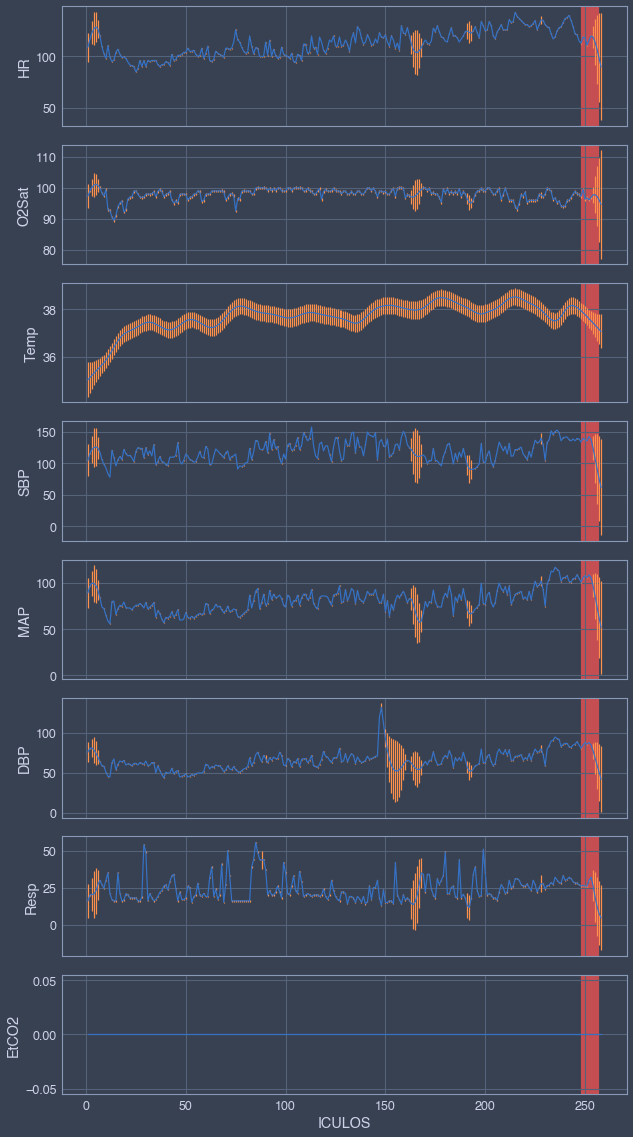

In [283]:
fig, ax = plt.subplots(8, 1, figsize=(9, 16), sharex=True)
for idx, measurement in enumerate(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']):
    ax[idx].errorbar(
        df['ICULOS'],
        df[measurement], df['%s_std' % (measurement)],
        ecolor='y'
    )
    ax[idx].set_ylabel(measurement)
    ax[idx].axvspan(
        df[df['SepsisLabel'] == 1].iloc[0].name,
        df[df['SepsisLabel'] == 1].iloc[-1].name,
        color='r'
    )
plt.xlabel('ICULOS')
plt.tight_layout()

In [366]:
df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Bilirubin_total_std,TroponinI_std,Hct_std,Hgb_std,PTT_std,WBC_std,Fibrinogen_std,Platelets_std,Unit1_std,Unit2_std
0,109.104008,97.396253,35.018177,104.877644,89.622988,76.370219,16.045649,0,-7.966614,22.530630,...,0,0,5.475432,1.698933,3.117906,3.867576,90.740592,29.898607,0,0
1,116.999523,98.999403,35.109173,115.999226,96.998450,80.997737,19.996831,0,-8.068610,22.906611,...,0,0,2.568056,0.926843,1.476996,1.955595,43.121197,12.989945,0,0
2,123.093884,100.175961,35.199477,122.252301,99.915130,81.302116,20.338993,0,-6.877292,23.288855,...,0,0,0.445515,0.434009,0.443561,0.445114,0.010333,0.447176,0,0
3,127.116660,100.897745,35.289071,125.254781,99.619215,78.701447,20.514058,0,-3.959220,23.673650,...,0,0,0.439440,0.401113,0.440661,0.444189,0.010333,0.447150,0,0
4,128.614798,101.137557,35.377939,126.204804,97.150639,74.629304,22.785979,0,-1.248058,24.042017,...,0,0,0.437498,0.399945,0.894928,1.354320,28.182855,7.887088,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,118.851631,97.747359,37.429836,124.514649,97.310424,77.805599,26.432335,0,-1.182346,24.457845,...,0,0,2.643475,0.865419,28.752802,10.402359,316.227766,170.463988,0,0
254,114.048606,97.809299,37.339731,108.129327,86.090128,68.901731,18.715683,0,-0.976192,24.636560,...,0,0,0.446772,0.442429,28.932152,10.675042,316.227766,185.295616,0,0
255,106.976898,97.254660,37.248798,91.426688,74.212847,59.591659,12.254397,0,-0.471320,24.808060,...,0,0,1.194901,0.505694,29.089633,10.867537,316.227766,198.838782,0,0
256,98.636274,96.180220,37.157055,75.796744,62.756580,50.633801,7.651880,0,-0.036779,24.970321,...,0,0,0.444615,0.420911,29.227728,11.002060,316.227766,211.169581,0,0


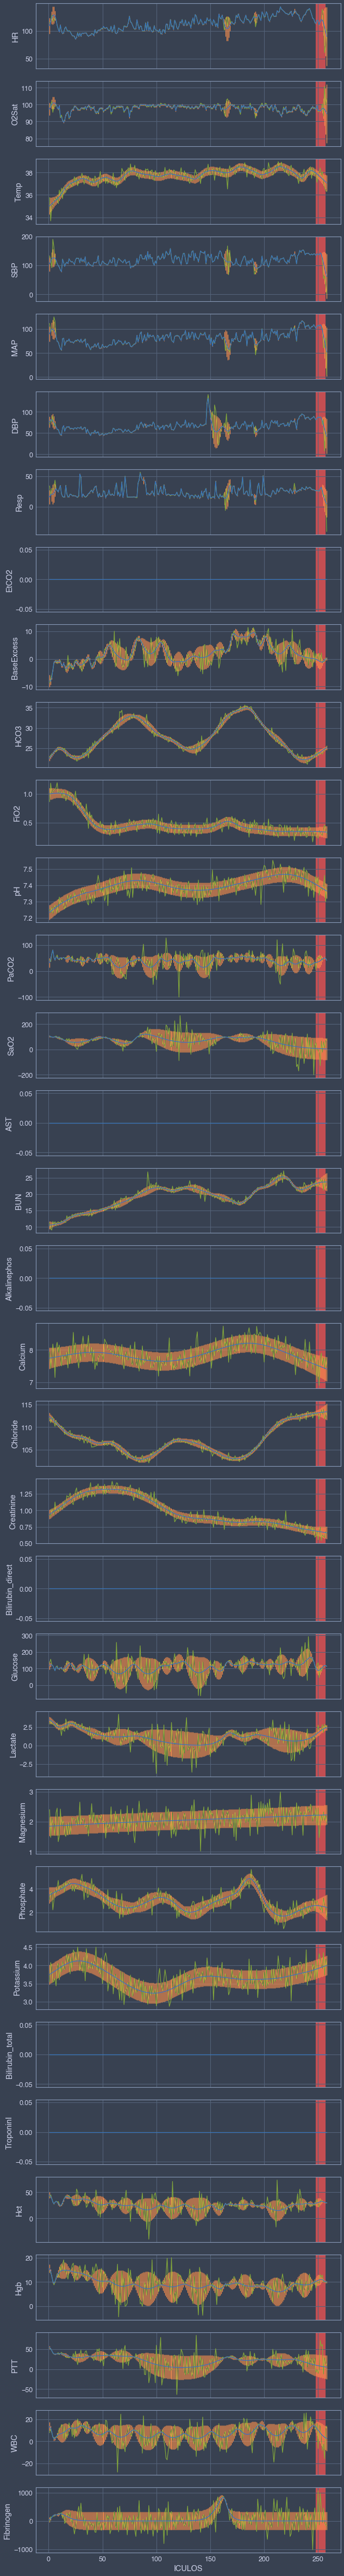

In [313]:
fig, ax = plt.subplots(33, 1, figsize=(9, 66), sharex=True)
for idx, measurement in enumerate(df.columns[1:34]):
    ax[idx].errorbar(
        df['ICULOS'],
        df[measurement], df['%s_std' % (measurement)],
        ecolor='y'
    )
    ax[idx].plot(
        df['ICULOS'],
        np.random.normal(df[measurement], df['%s_std' % (measurement)], len(df)),
        'g-'
    )
    ax[idx].set_ylabel(measurement)
    ax[idx].axvspan(
        df[df['SepsisLabel'] == 1].iloc[0].name,
        df[df['SepsisLabel'] == 1].iloc[-1].name,
        color='r'
    )
plt.xlabel('ICULOS')
plt.tight_layout()

In [363]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 0 to 257
Data columns (total 77 columns):
HR                      258 non-null float64
O2Sat                   258 non-null float64
Temp                    258 non-null float64
SBP                     258 non-null float64
MAP                     258 non-null float64
DBP                     258 non-null float64
Resp                    258 non-null float64
EtCO2                   258 non-null int64
BaseExcess              258 non-null float64
HCO3                    258 non-null float64
FiO2                    258 non-null float64
pH                      258 non-null float64
PaCO2                   258 non-null float64
SaO2                    258 non-null float64
AST                     258 non-null int64
BUN                     258 non-null float64
Alkalinephos            258 non-null int64
Calcium                 258 non-null float64
Chloride                258 non-null float64
Creatinine              258 non-null float64
B

In [367]:
df.to_numpy()

array([[1.091040e+02, 9.739625e+01, 3.501818e+01, 1.048776e+02, ..., 9.074059e+01, 2.989861e+01, 0.000000e+00,
        0.000000e+00],
       [1.169995e+02, 9.899940e+01, 3.510917e+01, 1.159992e+02, ..., 4.312120e+01, 1.298995e+01, 0.000000e+00,
        0.000000e+00],
       [1.230939e+02, 1.001760e+02, 3.519948e+01, 1.222523e+02, ..., 1.033323e-02, 4.471763e-01, 0.000000e+00,
        0.000000e+00],
       [1.271167e+02, 1.008977e+02, 3.528907e+01, 1.252548e+02, ..., 1.033324e-02, 4.471504e-01, 0.000000e+00,
        0.000000e+00],
       ...,
       [1.140486e+02, 9.780930e+01, 3.733973e+01, 1.081293e+02, ..., 3.162278e+02, 1.852956e+02, 0.000000e+00,
        0.000000e+00],
       [1.069769e+02, 9.725466e+01, 3.724880e+01, 9.142669e+01, ..., 3.162278e+02, 1.988388e+02, 0.000000e+00,
        0.000000e+00],
       [9.863627e+01, 9.618022e+01, 3.715705e+01, 7.579674e+01, ..., 3.162278e+02, 2.111696e+02, 0.000000e+00,
        0.000000e+00],
       [8.973497e+01, 9.467133e+01, 3.706452e+01, 

In [381]:
df.to_numpy().T.shape

(77, 258)

In [382]:
np.pad(df.to_numpy().T, ((0,0), (336-len(df), 0)))

array([[  0.      ,   0.      ,   0.      ,   0.      , ..., 114.048606, 106.976898,  98.636274,  89.734973],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,  97.809299,  97.25466 ,  96.18022 ,  94.671332],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,  37.339731,  37.248798,  37.157055,  37.06452 ],
       [  0.      ,   0.      ,   0.      ,   0.      , ..., 108.129327,  91.426688,  75.796744,  61.895415],
       ...,
       [  0.      ,   0.      ,   0.      ,   0.      , ..., 316.227766, 316.227766, 316.227766, 316.227766],
       [  0.      ,   0.      ,   0.      ,   0.      , ..., 185.295616, 198.838782, 211.169581, 222.36645 ],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ,   0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,   0.      ,   0.      ]])

In [720]:
# Saving labels
for file in os.listdir('challenge/interpolated/training'):
    if file.lower().endswith('psv'):
        label = pd.read_csv(f'challenge/interpolated/training/{file}', index_col=0)['SepsisLabel']
        label = np.pad(label.to_numpy(), (336-len(df), 0))
        np.savetxt(f'challenge/interpolated/labels/{file}', label, delimiter='|')
        print(file, end='\r')

In [744]:
# Saving best labels
labels = []
for idx, file in enumerate(os.listdir('challenge/interpolated/training')):
    if file.lower().endswith('psv'):
        label = pd.read_csv(f'challenge/interpolated/training/{file}', index_col=0)['SepsisLabel']
        label = np.pad(label.to_numpy(), (336-len(df), 0))
        if np.any(label):
            dt_early   = -12
            dt_optimal = -6
            dt_late    = 3
            t_sepsis   = np.argmax(label) - dt_optimal
            label[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, len(label))] = 1
        np.savetxt(f'challenge/interpolated/best_labels/{file}', label, delimiter='|')
        labels.append(label)
        print("[%s/%s] : %s" % (idx, len(os.listdir('challenge/interpolated/training')), file), end='\r')
        
np.save('challenge/interpolated/best_labels/y.npy', labels)

## FastAI data_block API

In [519]:
import torch
from fastai.basic_train import *
from fastai.metrics import *
from fastai import core, data_block

In [482]:
class patient_data(core.ItemBase):
    def __init__(self, df, sample=False, *args, **kwargs):
#         super().__init__(*args, **kwargs)
        self.data = torch.from_numpy(
            np.pad(df[df.columns[:40]].to_numpy().T, ((0,0), (336-len(df), 0)))
        )
        self.obj = df
        if sample:
            self.data = self.gaussian_sample()
        
    def __str__(self):
        return 'patient_data: {}'.format(self.obj.to_numpy().shape)

    def show(self):
        fig, ax = plt.subplots(8, 1, figsize=(9, 16), sharex=True)
        for idx, measurement in enumerate(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', \
                                           'DBP', 'Resp', 'EtCO2']):
            ax[idx].errorbar(
                self.obj['ICULOS'],
                self.obj[measurement], self.obj['%s_std' % (measurement)],
                ecolor='y'
            )
            ax[idx].set_ylabel(measurement)
            if self.obj['SepsisLabel'].max() == 1:
                ax[idx].axvspan(
                    self.obj[self.obj['SepsisLabel'] == 1].iloc[0].name,
                    self.obj[self.obj['SepsisLabel'] == 1].iloc[-1].name,
                    color='r'
                )
        plt.xlabel('ICULOS')
        plt.tight_layout()
        
    def gaussian_sample(self):
        sample = pd.DataFrame()
        for feature_std_name in self.obj.columns[41:]:
            feature = feature_std_name.split('_std')[0]
            sample[feature] = np.random.normal(
                self.obj[feature],
                self.obj[feature_std_name],
                len(self.obj)
            )
        sample[self.obj.columns[34:40]] = self.obj[self.obj.columns[34:40]]
        data = torch.from_numpy(np.pad(
            sample.to_numpy().T,
            ((0,0), (336-len(sample), 0))
        ))
        return data
    
    def apply_tfms(self, tfms, **kwargs):
        self.data = self.gaussian_sample()
        return self

In [483]:
df.columns[41]

'HR_std'

In [484]:
data = patient_data(df)

In [497]:
data.data[0][300:], data.gaussian_sample()[0][300:]

(tensor([129.9922, 132.0184, 134.9631, 126.0366, 130.9854, 135.6341, 134.9969,
         131.0034, 129.0041, 127.9914, 122.0009, 117.0046, 119.0025, 124.9951,
         127.9974, 129.0052, 133.0004, 136.9926, 138.0121, 139.9861, 135.0094,
         128.9892, 122.0175, 120.9827, 115.0041, 113.0126, 118.9906, 117.9860,
         111.0247, 115.9889, 119.9991, 118.8516, 114.0486, 106.9769,  98.6363,
          89.7350], dtype=torch.float64),
 tensor([129.2971, 131.7351, 134.2604, 126.0175, 131.1587, 136.2693, 135.9968,
         130.7858, 128.9571, 128.3191, 122.1210, 116.7523, 119.2518, 125.4073,
         127.6580, 128.2969, 132.5423, 136.9021, 138.2863, 139.8737, 135.0764,
         129.4171, 121.5319, 121.0845, 115.3579, 113.6386, 118.5704, 118.1365,
         111.4150, 115.7537, 119.7627, 135.0751, 102.0589, 118.1654, 151.1968,
         117.6727], dtype=torch.float64))

In [557]:
class data_list(data_block.ItemList):
    def __init__(self, items, sample=True, *args, **kwargs):
        super().__init__(items, **kwargs)
        self._sample = sample
    
    def get(self, i):
        filename = super().get(i)
        ret = self.open(filename)
        return ret
    
    def open(self, fn):
        df = pd.read_csv(fn, index_col=0)
        return patient_data(df, sample=self._sample)
    
    def reconstruct(self, t, x):
        ret = patient_data(
            pd.DataFrame(
                x,
                columns=[
                    'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', \
                    'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', \
                    'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', \
                    'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', \
                    'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', \
                    'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', \
                    'HospAdmTime', 'ICULOS'
                ]))
        ret['SepsisLabel'] = t.numpy()
        return ret

In [558]:
dl = data_list.from_folder('challenge/interpolated/training/')

In [349]:
dl.get(0).obj.columns[::41]

Index(['HR', 'HR_std'], dtype='object')

In [419]:
dl.get(0).data[0][300:], dl.get(0).gaussian_sample().data[0][300:]

(tensor([93.0560, 92.0679, 90.4789, 92.7042, 85.1133, 89.1344, 87.0275, 89.9860,
         90.6545, 87.6882, 91.1884, 88.3729, 90.5571, 90.8356, 90.2593, 89.9752,
         88.2954, 89.3088, 89.2807, 88.7672, 89.4668, 92.3693, 92.3734, 93.0692,
         88.2721, 89.9404, 95.3979, 95.0847, 97.8147, 95.9101, 86.9092, 90.8269,
         98.9285, 99.8094, 92.7702, 85.0825], dtype=torch.float64),
 tensor([94.8811, 90.9118, 90.1152, 93.3466, 84.8755, 89.0621, 87.0060, 90.1769,
         91.4272, 88.2831, 91.5721, 88.4674, 85.0461, 90.7200, 92.8640, 89.9120,
         87.1978, 89.0415, 89.5961, 89.0934, 89.3840, 92.1302, 93.1819, 86.4212,
         87.7792, 89.1835, 95.3653, 94.8665, 96.8489, 95.4887, 86.7137, 89.2411,
         99.4917, 99.9289, 92.5387, 84.6807], dtype=torch.float64))

In [114]:
label_cls = dl.get_label_cls(dl[10].obj['SepsisLabel']); label_cls

fastai.data_block.CategoryList

In [510]:
sd = dl.split_by_rand_pct(0.5, seed=42)

In [422]:
dl[0].apply_tfms([]).data[0][300:]

tensor([ 89.3359,  91.3986,  89.8151,  92.7620,  85.6120,  88.7704,  87.2818,
         90.3946,  91.6392,  87.9275,  91.0588,  88.5937,  89.5817,  90.8184,
         90.1362,  89.5349,  89.6952,  88.7025,  88.3204,  88.6948,  89.1157,
         95.6489,  92.7997,  89.0316,  93.5366,  89.0795,  94.2534,  95.4974,
         96.7948,  95.5055,  87.0672,  91.5490,  99.0178, 100.7085,  93.6086,
         84.3993], dtype=torch.float64)

In [72]:
torch.from_numpy(np.pad(dl[10].obj['SepsisLabel'].to_numpy(), (336-len(dl[10].obj), 0)))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [668]:
def zero_padder(fn):
    df = pd.read_csv(fn, index_col=0)
    sepsis_label = np.pad(df['SepsisLabel'].to_numpy(), (336-len(df), 0))
    if np.any(sepsis_label):
        dt_early   = -12
        dt_optimal = -6
        dt_late    = 3
        t_sepsis = np.argmax(sepsis_label) - dt_optimal
        sepsis_label[max(0, t_sepsis + dt_early) : min(t_sepsis + dt_late + 1, len(sepsis_label))] = 1
    print("%s: %s [%s]" % (fn, sepsis_label, str(1. in sepsis_label)), end='\r')
    return sepsis_label

In [669]:
ll = sd.label_from_func(
    zero_padder,
    classes=range(336),
    label_cls=data_block.MultiCategoryList,
    one_hot=True
)

In [751]:
ll = sd.label_from_func(
    lambda fn: pd.read_csv(f'challenge/interpolated/best_labels/{fn.parts[-1]}').to_numpy(),
    classes=range(336),
    label_cls=data_block.MultiCategoryList,
    one_hot=True
)

In [670]:
ll

LabelLists;

Train: LabelList (10168 items)
x: data_list
patient_data: (23, 75),patient_data: (48, 75),patient_data: (48, 75),patient_data: (23, 75),patient_data: (34, 77)
y: MultiCategoryList
,,,,320;321;322;323;324;325;326;327;328;329;330;331;332;333;334;335
Path: challenge/interpolated/training;

Valid: LabelList (10168 items)
x: data_list
patient_data: (20, 75),patient_data: (40, 77),patient_data: (22, 75),patient_data: (50, 77),patient_data: (15, 75)
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training;

Test: None

In [431]:
ll.x[0].apply_tfms(0).data.shape

torch.Size([33, 336])

In [ ]:
ll.x[0].obj

In [428]:
np.unique(ll.y.items, return_index=True, return_counts=True)

(array([0, 1], dtype=object), array([   0, 1670]), array([3407550,    8898]))

In [745]:
ll.label_from_lists()

MultiCategoryList (10168 items)
,,,,320;321;322;323;324;325;326;327;328;329;330;331;332;333;334;335
Path: challenge/interpolated/training

In [100]:
for idx, y in enumerate(ll.y):
    print('%d/%d: %s' % (idx, len(ll.y), y.raw), end='\r')
    if y.raw.max() > 0:
        print(idx)
        break

4


In [671]:
datab = ll.transform([]).databunch(); datab

DataBunch;

Train: LabelList (10168 items)
x: data_list
patient_data: (23, 75),patient_data: (48, 75),patient_data: (48, 75),patient_data: (23, 75),patient_data: (34, 77)
y: MultiCategoryList
,,,,320;321;322;323;324;325;326;327;328;329;330;331;332;333;334;335
Path: challenge/interpolated/training;

Valid: LabelList (10168 items)
x: data_list
patient_data: (20, 75),patient_data: (40, 77),patient_data: (22, 75),patient_data: (50, 77),patient_data: (15, 75)
y: MultiCategoryList
,,,,
Path: challenge/interpolated/training;

Test: None

In [531]:
datab.y[0].data

array([0., 0., 0., 0., ..., 0., 0., 0., 0.], dtype=float32)

In [566]:
datab.one_batch()

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.9500e+01,
            9.1995e+01,  9.0874e+01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  9.9319e+01,
            9.9463e+01,  9.9356e+01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.6110e+01,
            3.6047e+01,  3.6105e+01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0000e-02,
           -3.0000e-02, -3.0000e-02],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.4000e+01,
            1.5000e+01,  1.6000e+01]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.1954e+01,
            8.1754e+01,  8.0238e+01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  9.7550e+01,
            9.7917e+01,  9.7642e+01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.6557e+01,
            3.6524e+01,  3.6762e+01],
          ...,
    

## Protomodel

In [515]:
import torch.nn as nn
import torch.nn.functional as F

In [548]:
class protomodel(nn.Module):
    def __init__(self, input_shape, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 1 hidden layer
        self.hidden_layer = nn.Linear(input_shape, output_shape)
    
    def forward(self, x):
        x = F.relu(self.hidden_layer(x.float()).mean(1))
        return x

In [672]:
net = protomodel(336, 336)

In [721]:
learn = Learner(
    data=datab,
    model=net,
    loss_func=nn.BCEWithLogitsLoss(),
    path='prototyping'
)
learn.fit(100)

epoch,train_loss,valid_loss,time
0,0.700129,0.715292,03:26
1,0.701471,0.715436,03:27
2,0.701375,0.711427,03:24
3,0.699760,0.714347,03:21
4,0.696023,0.717346,03:41
5,0.699597,0.709360,03:42
6,0.698579,0.715170,03:51
7,0.699564,0.711978,03:46
8,0.694739,0.710671,03:42
9,0.697003,0.712246,03:45


In [722]:
preds, y, losses = get_preds(learn.model, datab.valid_dl, loss_func=nn.BCEWithLogitsLoss())

In [723]:
ppv, pos, neg, fnr = 0, 0, 0, 0
for idx, sepsis_l in enumerate(y):
    if sepsis_l.sum() > 0:
        pos += 1
        ppv += bool(preds[idx].sum()>0)
        print(idx, bool(preds[idx].sum()>0), sep='\t')
    else:
        neg += 1
        fnr += bool(preds[idx].sum()>0)
print("PPV:", ppv/pos)
print("FPR:", fnr/neg)

6	False
24	False
36	False
38	False
40	False
59	True
60	False
75	False
88	False
93	False
105	True
106	True
109	True
110	False
113	False
121	False
125	False
141	False
153	False
158	False
161	False
181	True
182	True
190	True
197	False
230	False
232	False
266	False
299	False
334	False
351	True
352	True
357	False
370	False
379	False
394	False
402	True
422	False
441	False
442	False
447	False
450	False
465	False
477	False
485	True
490	True
509	True
520	False
542	False
544	False
559	False
569	False
573	False
583	True
600	False
604	False
607	False
611	False
614	True
619	False
654	False
656	True
671	False
673	False
679	False
691	False
694	True
697	True
711	True
713	False
722	False
726	False
728	False
760	False
761	False
763	True
766	False
814	False
815	False
821	True
823	False
827	False
832	True
844	True
846	False
848	False
895	True
922	True
929	True
941	False
943	False
945	False
950	True
958	False
970	False
981	False
1007	False
1039	True
1043	True
1046	True
1066	False
1067	False
1084	True
1089	

In [724]:
idx=59
print(nn.Sigmoid()(preds[idx][300:]), y[idx][300:], losses[idx][300:], sep='\n')
print(
    normalised_utility(y[idx].numpy().astype('int'),
                       nn.Sigmoid()(preds[idx]).numpy().astype('int')),
    sep='\n'
)

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000, 1.0000,
        1.0000, 0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
        0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
        0.6931, 0.6931, 0.6931, 0.0000, 0.0000, 0.0000, 0.0000, 0.6931, 0.0000,
        0.0000, 0.6931, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
0.6031746031746031


In [742]:
datab.train_ds.x.items.data